In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NLP-Project/

Mounted at /content/drive
/content/drive/MyDrive/NLP-Project


In [ ]:
!mkdir -p dsg/data
!wget -q https://raw.githubusercontent.com/j-min/DSG/main/dsg/query_utils.py -O dsg/query_utils.py
!wget -q https://raw.githubusercontent.com/j-min/DSG/main/dsg/parse_utils.py -O dsg/parse_utils.py
!wget -q https://raw.githubusercontent.com/j-min/DSG/main/dsg/vqa_utils.py -O dsg/vqa_utils.py
!wget https://raw.githubusercontent.com/j-min/DSG/main/dsg/data/tifa160-dev-anns.csv -O dsg/data/tifa160-dev-anns.csv

--2025-06-22 04:29:48--  https://raw.githubusercontent.com/j-min/DSG/main/dsg/data/tifa160-dev-anns.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157720 (154K) [text/plain]
Saving to: ‘dsg/data/tifa160-dev-anns.csv’

dsg/data/tifa160-de 100%[===================>] 154.02K  --.-KB/s    in 0.01s   

2025-06-22 04:29:48 (12.8 MB/s) - ‘dsg/data/tifa160-dev-anns.csv’ saved [157720/157720]



In [ ]:
import importlib.util
import sys

# Load query_utils manually
spec = importlib.util.spec_from_file_location("query_utils", "./dsg/query_utils.py")
query_utils = importlib.util.module_from_spec(spec)
sys.modules["query_utils"] = query_utils
spec.loader.exec_module(query_utils)

# Repeat for parse_utils if needed
spec_p = importlib.util.spec_from_file_location("parse_utils", "./dsg/parse_utils.py")
parse_utils = importlib.util.module_from_spec(spec_p)
sys.modules["parse_utils"] = parse_utils
spec_p.loader.exec_module(parse_utils)

In [ ]:
import os
import re
import base64
import json
import time
from PIL import Image
import torch
import pandas as pd
from tqdm import tqdm
import sys
import io

# Add the dsg directory to the Python path to import local modules
sys.path.append('./dsg')

from transformers import CLIPModel, CLIPTokenizer, CLIPProcessor
from openai import OpenAI, RateLimitError
from query_utils import generate_dsg
from parse_utils import parse_tuple_output, parse_dependency_output, parse_question_output

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3-2730252089.py", line 7, in <cell line: 0>
    import torch
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1138, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1078, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1507, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1476, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1434, in _path_importer_cache
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
  

# **CLIP Interpolation & DSG Evaluation (Original Prompts → Generated Images)**


In [ ]:
# === 1) classify_answer unchanged ===
_yes_re = re.compile(r'''
    ^\s*
    (?:yes|yep|yeah|yup|affirmative|
       certainly|definitely|absolutely)\b
''', re.IGNORECASE | re.VERBOSE)

_no_re = re.compile(r'''
    ^\s*
    (?:no|nope|nah|negative|
       not\ at\ all|absolutely\ not|
       of\ course\ not)\b
''', re.IGNORECASE | re.VERBOSE)

def classify_answer(ans: str) -> float:
    text = ans.strip().lower()
    if _yes_re.match(text): return 1.0
    if _no_re.match(text):  return 0.0
    return 0.0

# === 2) Question generation with backoff ===
def openai_question(prompt: str, model: str = "gpt-3.5-turbo", temperature: float = 0):
    backoff = 1
    while True:
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=temperature,
                max_tokens=1024,
            )
            return resp.choices[0].message.content
        except RateLimitError:
            time.sleep(backoff)
            backoff = min(backoff * 2, 10)

# === 3) VQA answering with backoff ===
def openai_answer(data_uri: str, question: str, model: str = "gpt-4o-mini") -> str:
    parts = [
        {"type": "image_url", "image_url": {"url": data_uri}},
        {"type": "text",      "text": question}
    ]
    messages = [
        {"role": "system", "content":
            "You are a helpful assistant that answers image questions in a clear 'yes', 'no', or 'not sure' format with a short explanation."
        },
        {"role": "user", "content": parts}
    ]
    backoff = 1
    while True:
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=messages,
                max_tokens=100,
                temperature=0
            )
            return resp.choices[0].message.content.strip()
        except RateLimitError:
            time.sleep(backoff)
            backoff = min(backoff * 2, 10)

# === 4) Encode image to data URI ===
def encode_image_to_data_uri(image_path: str) -> str:
    # load and downsize image to reduce token length in data URI
    img = Image.open(image_path).convert('RGB')
    # resize to max 256x256, preserving aspect ratio
    img.thumbnail((256, 256), Image.LANCZOS)
    buffer = io.BytesIO()
    img.save(buffer, format='PNG')
    b64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return f'data:image/png;base64,{b64}'

# === 5) evaluate_dsg with retries ===
def evaluate_dsg(prompt: str, image_path: str, max_retries: int = 3) -> dict:
    for attempt in range(max_retries):
        try:
            data_uri = encode_image_to_data_uri(image_path)
            id2p = {'custom_0': {'input': prompt}}
            t_out, q_out, d_out = generate_dsg(id2p, generate_fn=openai_question)
            q2tuple    = parse_tuple_output(t_out['custom_0']['output'])
            q2question = parse_question_output(q_out['custom_0']['output'])
            q2parents  = parse_dependency_output(d_out['custom_0']['output'])

            answers, scores = {}, {}
            for qid, question in q2question.items():
                a = openai_answer(data_uri, question)
                answers[qid] = a
                scores[qid]  = classify_answer(a)

            for qid, parents in q2parents.items():
                if any(scores.get(pid,1)==0 for pid in parents if pid!=0):
                    scores[qid] = 0.0

            avg = sum(scores.values())/len(scores) if scores else 0.0
            return {
                "score": avg,
                "facts": list(q2tuple.values()),
                "questions": [q2question[q] for q in sorted(q2question)],
                "answers": [answers[q] for q in sorted(q2question)],
                "binary_scores": [scores[q] for q in sorted(q2question)]
            }
        except RateLimitError:
            sleep_time = (2 ** attempt)
            time.sleep(sleep_time)
        except Exception as e:
            print(f"evaluate_dsg() failed (attempt {attempt+1}):", e)
            if attempt < max_retries - 1:
                time.sleep(1)
            else:
                return {"score":0.0, "facts":[], "questions":[], "answers":[], "binary_scores":[]}

# === Setup OpenAI client ===
client = OpenAI(api_key="") # key hidden

# ─── PATH CONFIG ───────────────────────────────────────────────────────────
original_root = '/content/drive/MyDrive/NLP-Project/QWEN_200_images/original'
models = {
    "QWEN":     '/content/drive/MyDrive/NLP-Project/QWEN_200_images/generated',
    "BART":     '/content/drive/MyDrive/NLP-Project/BART_generated',
    "T5":       '/content/drive/MyDrive/NLP-Project/T5_generated',
    "DEEPSEEK": '/content/drive/MyDrive/NLP-Project/DEEPSEEK_generated',
    'original': '/content/drive/MyDrive/NLP-Project/QWEN_200_images/original',
}
N = 200

# ─── SET UP CLIP ─────────────────────────────────────────────────────────────
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval().to("cuda")
tok  = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def load_img(path): return Image.open(path).convert("RGB")
def cosine(a, b): return torch.nn.functional.cosine_similarity(a, b, dim=0).item()
def text_emb(prompt):
    tokens = tok.tokenize(prompt)
    chunks = [tokens[i:i+77] for i in range(0, len(tokens), 77)]
    embs = []
    for ch in chunks:
        ids = tok.convert_tokens_to_ids(ch)
        inp = {"input_ids": torch.tensor([ids]).to(clip.device)}
        with torch.no_grad(): embs.append(clip.get_text_features(**inp))
    return torch.mean(torch.stack(embs), dim=0).squeeze(0)

# ─── MAIN LOOP ───────────────────────────────────────────────────────────────
rows = []
for model_name, gen_folder in models.items():
    orig_folder = original_root
    for i in tqdm(range(1, N+1), desc=model_name):
        idx = str(i)
        # gen_txt = os.path.join(gen_folder, f"{idx}.txt")
        gen_png = os.path.join(gen_folder, f"{idx}.png")
        orig_txt = os.path.join(orig_folder, f"{idx}.txt")
        orig_png = os.path.join(orig_folder, f"{idx}.png") # This path is not used in the interpolation calculation, but kept for completeness.

        # if not all(os.path.isfile(p) for p in (gen_txt, gen_png, orig_txt, orig_png)):
        if not all(os.path.isfile(p) for p in (gen_png, orig_txt, orig_png)):
            print(f"Missing files for {model_name} {idx}")
            continue

        orig_p = open(orig_txt).read().strip()
        # gen_p  = open(gen_txt).read().strip()

        img_inputs = proc(images=load_img(gen_png), return_tensors="pt")
        img_inputs = {k: v.to(clip.device) for k,v in img_inputs.items()}
        with torch.no_grad(): gen_img_emb  = clip.get_image_features(**img_inputs).squeeze(0)

        orig_txt_emb = text_emb(orig_p)

        # Corrected interpolation: original text embedding with generated image embedding
        interp = cosine(orig_txt_emb, gen_img_emb)
        dsg_score = evaluate_dsg(orig_p, gen_png)["score"]

        rows.append({"image_id": int(idx), "model_name": model_name, "Interp_score": interp, "DSG_score": dsg_score})
        print(f"Added row {model_name} {idx}: Interp={interp:.4f}, DSG={dsg_score:.4f}")

# ─── SAVE & SHOW ────────────────────────────────────────────────────────────
df = pd.DataFrame(rows, columns=["image_id", "model_name", "Interp_score", "DSG_score"])
df.to_csv("t2i_interp_dsg_results_QWEN.csv", index=False)

HF:   0%|          | 0/200 [00:00<?, ?it/s]

Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1308.27it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12157.40it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic billboard with a sleek design, '
          'displaying an advertisement featuring a race car, accompanied by a '
          'modern, compact white car parked in front of it against a clear sky '
          'backdrop.',
 'output': '1 | entity - whole (billboard)\n'
           '2 | attribute - type (billboard, futuristic)\n'
           '3 | attribute - shape (billboard, sleek)\n'
           '4 | action - (billboard, display)\n'
           '5 | entity - whole (advertisement)\n'
           '6 | entity - whole (race car)\n'
           '7 | entity - whole (car)\n'
           '8 | attribute - type (car, modern)\n'
           '9 | attribute - color (car, white)\n'
           '10 | attribute - size (car, compact)\n'
           '11 | attribute - state (car, parked)\n'
           '12 | relation - spatial (car, billboard, in front of)\n'
           '13 | relation - spatial (car, sky, against)'}
Task 2:  ques


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3809.54it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10538.45it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic billboard with a sleek design, '
          'displaying an advertisement featuring a race car, accompanied by a '
          'modern, compact white car parked in front of it against a clear sky '
          'backdrop.\n'
          '1 | entity - whole (billboard)\n'
          '2 | attribute - type (billboard, futuristic)\n'
          '3 | attribute - shape (billboard, sleek)\n'
          '4 | action - (billboard, display)\n'
          '5 | entity - whole (advertisement)\n'
          '6 | entity - whole (race car)\n'
          '7 | entity - whole (car)\n'
          '8 | attribute - type (car, modern)\n'
          '9 | attribute - color (car, white)\n'
          '10 | attribute - size (car, compact)\n'
          '11 | attribute - state (car, parked)\n'
          '12 | relation - spatial (car, billboard, in front of)\n'
          '13 | relation - spatial (car, sky, against)',
 'output': '1 | Is there 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3847.99it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10979.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic billboard with a sleek design, '
          'displaying an advertisement featuring a race car, accompanied by a '
          'modern, compact white car parked in front of it against a clear sky '
          'backdrop.\n'
          '1 | entity - whole (billboard)\n'
          '2 | attribute - type (billboard, futuristic)\n'
          '3 | attribute - shape (billboard, sleek)\n'
          '4 | action - (billboard, display)\n'
          '5 | entity - whole (advertisement)\n'
          '6 | entity - whole (race car)\n'
          '7 | entity - whole (car)\n'
          '8 | attribute - type (car, modern)\n'
          '9 | attribute - color (car, white)\n'
          '10 | attribute - size (car, compact)\n'
          '11 | attribute - state (car, parked)\n'
          '12 | relation - spatial (car, billboard, in front of)\n'
          '13 | relation - spatial (car, sky, against)',
 'output': '1 | 0\n'
    

HF:   0%|          | 1/200 [00:18<1:02:31, 18.85s/it]

Added row HF 1: Interp=0.2916, DSG=0.8462
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 961.78it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9915.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a series of three character portraits of a '
          'woman with dark hair and varying expressions, presented alongside a '
          'larger, single detailed illustration of her face, all presented '
          'with a stylized, artistic flair.',
 'output': '1 | entity - whole (character portraits)\n'
           '2 | entity - whole (woman)\n'
           "3 | entity - part (woman's hair)\n"
           "4 | attribute - color (woman's hair, dark)\n"
           '5 | attribute - state (character portraits, varying expressions)\n'
           '6 | entity - whole (illustration)\n'
           '7 | entity - part (illustration, face)\n'
           '8 | attribute - size (illustration, larger)\n'
           '9 | attribute - level of detail (illustration, detailed)\n'
           '10 | attribute - style (illustration, stylized)\n'
           '11 | attribute - style (illustration, artistic)'}
Task 2:  question
Run infere


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2538.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11184.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a series of three character portraits of a '
          'woman with dark hair and varying expressions, presented alongside a '
          'larger, single detailed illustration of her face, all presented '
          'with a stylized, artistic flair.\n'
          '1 | entity - whole (character portraits)\n'
          '2 | entity - whole (woman)\n'
          "3 | entity - part (woman's hair)\n"
          "4 | attribute - color (woman's hair, dark)\n"
          '5 | attribute - state (character portraits, varying expressions)\n'
          '6 | entity - whole (illustration)\n'
          '7 | entity - part (illustration, face)\n'
          '8 | attribute - size (illustration, larger)\n'
          '9 | attribute - level of detail (illustration, detailed)\n'
          '10 | attribute - style (illustration, stylized)\n'
          '11 | attribute - style (illustration, artistic)',
 'output': '1 | Are there character po


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3930.93it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 4848.91it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a series of three character portraits of a '
          'woman with dark hair and varying expressions, presented alongside a '
          'larger, single detailed illustration of her face, all presented '
          'with a stylized, artistic flair.\n'
          '1 | entity - whole (character portraits)\n'
          '2 | entity - whole (woman)\n'
          "3 | entity - part (woman's hair)\n"
          "4 | attribute - color (woman's hair, dark)\n"
          '5 | attribute - state (character portraits, varying expressions)\n'
          '6 | entity - whole (illustration)\n'
          '7 | entity - part (illustration, face)\n'
          '8 | attribute - size (illustration, larger)\n'
          '9 | attribute - level of detail (illustration, detailed)\n'
          '10 | attribute - style (illustration, stylized)\n'
          '11 | attribute - style (illustration, artistic)',
 'output': '1 | 0\n'
           '2 | 1

HF:   1%|          | 2/200 [00:37<1:01:02, 18.50s/it]

Added row HF 2: Interp=0.2464, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2661.36it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11066.77it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a bustling, dimly-lit marketplace or workshop '
          'filled with various artifacts and bright, glowing lights, '
          'showcasing an assortment of hanging items and people engaged in '
          'trade and crafts within a rustic, industrial setting.',
 'output': '1 | global - (image)\n'
           '2 | attribute - state (marketplace/workshop, bustling)\n'
           '3 | attribute - state (marketplace/workshop, dimly-lit)\n'
           '4 | entity - whole (marketplace/workshop)\n'
           '5 | entity - whole (artifacts)\n'
           '6 | entity - whole (lights)\n'
           '7 | entity - whole (items)\n'
           '8 | entity - whole (people)\n'
           '9 | action - (people, trade)\n'
           '10 | action - (people, crafts)\n'
           '11 | attribute - type (setting, rustic)\n'
           '12 | attribute - type (setting, industrial)\n'
           '13 | relation - spatial (items, m


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3705.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9664.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a bustling, dimly-lit marketplace or workshop '
          'filled with various artifacts and bright, glowing lights, '
          'showcasing an assortment of hanging items and people engaged in '
          'trade and crafts within a rustic, industrial setting.\n'
          '1 | global - (image)\n'
          '2 | attribute - state (marketplace/workshop, bustling)\n'
          '3 | attribute - state (marketplace/workshop, dimly-lit)\n'
          '4 | entity - whole (marketplace/workshop)\n'
          '5 | entity - whole (artifacts)\n'
          '6 | entity - whole (lights)\n'
          '7 | entity - whole (items)\n'
          '8 | entity - whole (people)\n'
          '9 | action - (people, trade)\n'
          '10 | action - (people, crafts)\n'
          '11 | attribute - type (setting, rustic)\n'
          '12 | attribute - type (setting, industrial)\n'
          '13 | relation - spatial (items, marketplace/w


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2294.48it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a bustling, dimly-lit marketplace or workshop '
          'filled with various artifacts and bright, glowing lights, '
          'showcasing an assortment of hanging items and people engaged in '
          'trade and crafts within a rustic, industrial setting.\n'
          '1 | global - (image)\n'
          '2 | attribute - state (marketplace/workshop, bustling)\n'
          '3 | attribute - state (marketplace/workshop, dimly-lit)\n'
          '4 | entity - whole (marketplace/workshop)\n'
          '5 | entity - whole (artifacts)\n'
          '6 | entity - whole (lights)\n'
          '7 | entity - whole (items)\n'
          '8 | entity - whole (people)\n'
          '9 | action - (people, trade)\n'
          '10 | action - (people, crafts)\n'
          '11 | attribute - type (setting, rustic)\n'
          '12 | attribute - type (setting, industrial)\n'
          '13 | relation - spatial (items, marketplace/w

HF:   2%|▏         | 3/200 [00:58<1:05:12, 19.86s/it]

Added row HF 3: Interp=0.2105, DSG=0.7857
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2465.79it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13315.25it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic robotic figure with a metallic, '
          'gold-colored exterior, showcasing intricate mechanical details and '
          'tubing, set against a blue background.',
 'output': '1 | entity - whole (robotic figure)\n'
           '2 | attribute - material (robotic figure, metallic)\n'
           '3 | attribute - color (robotic figure, gold)\n'
           '4 | attribute - texture (robotic figure, intricate mechanical '
           'details)\n'
           '5 | attribute - texture (robotic figure, tubing)\n'
           '6 | global - (futuristic)\n'
           '7 | global - (blue background)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3844.46it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11184.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic robotic figure with a metallic, '
          'gold-colored exterior, showcasing intricate mechanical details and '
          'tubing, set against a blue background.\n'
          '1 | entity - whole (robotic figure)\n'
          '2 | attribute - material (robotic figure, metallic)\n'
          '3 | attribute - color (robotic figure, gold)\n'
          '4 | attribute - texture (robotic figure, intricate mechanical '
          'details)\n'
          '5 | attribute - texture (robotic figure, tubing)\n'
          '6 | global - (futuristic)\n'
          '7 | global - (blue background)',
 'output': '1 | Is there a robotic figure?\n'
           '2 | Is the robotic figure made of metal?\n'
           '3 | Is the robotic figure gold-colored?\n'
           '4 | Does the robotic figure showcase intricate mechanical '
           'details?\n'
           '5 | Does the robotic figure have tubing?\n'
           


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3560.53it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8738.13it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic robotic figure with a metallic, '
          'gold-colored exterior, showcasing intricate mechanical details and '
          'tubing, set against a blue background.\n'
          '1 | entity - whole (robotic figure)\n'
          '2 | attribute - material (robotic figure, metallic)\n'
          '3 | attribute - color (robotic figure, gold)\n'
          '4 | attribute - texture (robotic figure, intricate mechanical '
          'details)\n'
          '5 | attribute - texture (robotic figure, tubing)\n'
          '6 | global - (futuristic)\n'
          '7 | global - (blue background)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 0\n7 | 0'}


HF:   2%|▏         | 4/200 [01:10<54:41, 16.74s/it]  

Added row HF 4: Interp=0.2177, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 930.00it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with her back turned, standing in a '
          'futuristic landscape filled with machinery and soft lighting, '
          'suggesting a blend of elegance and industrial aesthetics.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - state (woman, back turned)\n'
           '3 | global - (futuristic landscape)\n'
           '4 | entity - whole (machinery)\n'
           '5 | attribute - state (landscape, filled with machinery)\n'
           '6 | attribute - state (landscape, soft lighting)\n'
           '7 | attribute - state (landscape, blend of elegance and industrial '
           'aesthetics)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3865.72it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with her back turned, standing in a '
          'futuristic landscape filled with machinery and soft lighting, '
          'suggesting a blend of elegance and industrial aesthetics.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - state (woman, back turned)\n'
          '3 | global - (futuristic landscape)\n'
          '4 | entity - whole (machinery)\n'
          '5 | attribute - state (landscape, filled with machinery)\n'
          '6 | attribute - state (landscape, soft lighting)\n'
          '7 | attribute - state (landscape, blend of elegance and industrial '
          'aesthetics)',
 'output': '1 | Is there a woman?\n'
           "2 | Is the woman's back turned?\n"
           '3 | Is the landscape futuristic?\n'
           '4 | Are there machinery in the landscape?\n'
           '5 | Is the landscape filled with machinery?\n'
           '6 | Is the landscape lit with soft 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3663.15it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10672.53it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with her back turned, standing in a '
          'futuristic landscape filled with machinery and soft lighting, '
          'suggesting a blend of elegance and industrial aesthetics.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - state (woman, back turned)\n'
          '3 | global - (futuristic landscape)\n'
          '4 | entity - whole (machinery)\n'
          '5 | attribute - state (landscape, filled with machinery)\n'
          '6 | attribute - state (landscape, soft lighting)\n'
          '7 | attribute - state (landscape, blend of elegance and industrial '
          'aesthetics)',
 'output': '1 | 0\n2 | 1\n3 | 0\n4 | 3\n5 | 3\n6 | 3'}


HF:   2%|▎         | 5/200 [01:23<50:17, 15.48s/it]

Added row HF 5: Interp=0.2531, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 255.19it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11983.73it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in profile, adorned in a flowing white '
          'gown, with a large black crow perched on her shoulder, set against '
          'a circular stained glass background that enhances the ethereal and '
          'dramatic atmosphere.',
 'output': '1 | entity - whole (woman)\n'
           '2 | entity - whole (gown)\n'
           '3 | entity - whole (crow)\n'
           '4 | entity - whole (shoulder)\n'
           '5 | entity - whole (background)\n'
           '6 | attribute - color (gown, white)\n'
           '7 | attribute - color (crow, black)\n'
           '8 | attribute - shape (background, circular)\n'
           '9 | attribute - texture (background, stained glass)\n'
           '10 | attribute - atmosphere (background, ethereal and dramatic)\n'
           '11 | relation - spatial (crow, woman, on)\n'
           '12 | relation - spatial (woman, background, against)'}
Task 2:  question
Run inferen


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3659.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in profile, adorned in a flowing white '
          'gown, with a large black crow perched on her shoulder, set against '
          'a circular stained glass background that enhances the ethereal and '
          'dramatic atmosphere.\n'
          '1 | entity - whole (woman)\n'
          '2 | entity - whole (gown)\n'
          '3 | entity - whole (crow)\n'
          '4 | entity - whole (shoulder)\n'
          '5 | entity - whole (background)\n'
          '6 | attribute - color (gown, white)\n'
          '7 | attribute - color (crow, black)\n'
          '8 | attribute - shape (background, circular)\n'
          '9 | attribute - texture (background, stained glass)\n'
          '10 | attribute - atmosphere (background, ethereal and dramatic)\n'
          '11 | relation - spatial (crow, woman, on)\n'
          '12 | relation - spatial (woman, background, against)',
 'output': '1 | Is there a woman?\n'
   


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1965.47it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12122.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in profile, adorned in a flowing white '
          'gown, with a large black crow perched on her shoulder, set against '
          'a circular stained glass background that enhances the ethereal and '
          'dramatic atmosphere.\n'
          '1 | entity - whole (woman)\n'
          '2 | entity - whole (gown)\n'
          '3 | entity - whole (crow)\n'
          '4 | entity - whole (shoulder)\n'
          '5 | entity - whole (background)\n'
          '6 | attribute - color (gown, white)\n'
          '7 | attribute - color (crow, black)\n'
          '8 | attribute - shape (background, circular)\n'
          '9 | attribute - texture (background, stained glass)\n'
          '10 | attribute - atmosphere (background, ethereal and dramatic)\n'
          '11 | relation - spatial (crow, woman, on)\n'
          '12 | relation - spatial (woman, background, against)',
 'output': '1 | 0\n'
           '2 | 1\n

HF:   3%|▎         | 6/200 [01:47<59:12, 18.31s/it]

Added row HF 6: Interp=0.2121, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2991.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11748.75it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with striking features and dark '
          'hair, wearing a white shirt, surrounded by floating bubbles against '
          'a warm, dreamy background.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - age (woman, young)\n'
           '3 | attribute - feature (woman, striking)\n'
           "4 | attribute - color (woman's hair, dark)\n"
           "5 | attribute - color (woman's shirt, white)\n"
           '6 | entity - whole (bubbles)\n'
           '7 | attribute - state (bubbles, floating)\n'
           '8 | global - (warm)\n'
           '9 | global - (dreamy)\n'
           '10 | relation - spatial (woman, bubbles, surrounded by)\n'
           '11 | relation - spatial (woman, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3916.25it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with striking features and dark '
          'hair, wearing a white shirt, surrounded by floating bubbles against '
          'a warm, dreamy background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          '3 | attribute - feature (woman, striking)\n'
          "4 | attribute - color (woman's hair, dark)\n"
          "5 | attribute - color (woman's shirt, white)\n"
          '6 | entity - whole (bubbles)\n'
          '7 | attribute - state (bubbles, floating)\n'
          '8 | global - (warm)\n'
          '9 | global - (dreamy)\n'
          '10 | relation - spatial (woman, bubbles, surrounded by)\n'
          '11 | relation - spatial (woman, background, against)',
 'output': '1 | Is there a woman?\n'
           '2 | Is the woman young?\n'
           '3 | Does the woman have striking features?\n'
           "4 | Is the woman's hair dark?\n"
    


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3698.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9939.11it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with striking features and dark '
          'hair, wearing a white shirt, surrounded by floating bubbles against '
          'a warm, dreamy background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          '3 | attribute - feature (woman, striking)\n'
          "4 | attribute - color (woman's hair, dark)\n"
          "5 | attribute - color (woman's shirt, white)\n"
          '6 | entity - whole (bubbles)\n'
          '7 | attribute - state (bubbles, floating)\n'
          '8 | global - (warm)\n'
          '9 | global - (dreamy)\n'
          '10 | relation - spatial (woman, bubbles, surrounded by)\n'
          '11 | relation - spatial (woman, background, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 0\n'
           '7 | 6\n'
           '8 | 0\n'
           '9 |

HF:   4%|▎         | 7/200 [02:15<1:09:18, 21.55s/it]

Added row HF 7: Interp=0.2512, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2468.69it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dark, fantasy character with wings and '
          'flowing purple attire, standing confidently on a rocky landscape '
          'against a dramatic, colorful sky.',
 'output': '1 | entity - whole (character)\n'
           '2 | attribute - color (character, dark)\n'
           '3 | attribute - type (character, fantasy)\n'
           "4 | entity - part (character's wings)\n"
           "5 | attribute - state (character's attire, flowing)\n"
           "6 | attribute - color (character's attire, purple)\n"
           '7 | attribute - state (character, confident)\n'
           '8 | entity - whole (landscape)\n'
           '9 | attribute - texture (landscape, rocky)\n'
           '10 | relation - spatial (character, landscape, on)\n'
           '11 | entity - whole (sky)\n'
           '12 | attribute - color (sky, colorful)\n'
           '13 | attribute - state (sky, dramatic)'}
Task 2:  question
Run inferenc


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3172.70it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10538.45it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dark, fantasy character with wings and '
          'flowing purple attire, standing confidently on a rocky landscape '
          'against a dramatic, colorful sky.\n'
          '1 | entity - whole (character)\n'
          '2 | attribute - color (character, dark)\n'
          '3 | attribute - type (character, fantasy)\n'
          "4 | entity - part (character's wings)\n"
          "5 | attribute - state (character's attire, flowing)\n"
          "6 | attribute - color (character's attire, purple)\n"
          '7 | attribute - state (character, confident)\n'
          '8 | entity - whole (landscape)\n'
          '9 | attribute - texture (landscape, rocky)\n'
          '10 | relation - spatial (character, landscape, on)\n'
          '11 | entity - whole (sky)\n'
          '12 | attribute - color (sky, colorful)\n'
          '13 | attribute - state (sky, dramatic)',
 'output': '1 | Is there a character?\n'
 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3751.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dark, fantasy character with wings and '
          'flowing purple attire, standing confidently on a rocky landscape '
          'against a dramatic, colorful sky.\n'
          '1 | entity - whole (character)\n'
          '2 | attribute - color (character, dark)\n'
          '3 | attribute - type (character, fantasy)\n'
          "4 | entity - part (character's wings)\n"
          "5 | attribute - state (character's attire, flowing)\n"
          "6 | attribute - color (character's attire, purple)\n"
          '7 | attribute - state (character, confident)\n'
          '8 | entity - whole (landscape)\n'
          '9 | attribute - texture (landscape, rocky)\n'
          '10 | relation - spatial (character, landscape, on)\n'
          '11 | entity - whole (sky)\n'
          '12 | attribute - color (sky, colorful)\n'
          '13 | attribute - state (sky, dramatic)',
 'output': '1 | 0\n'
           '2 | 1\n'


HF:   4%|▍         | 8/200 [02:45<1:17:13, 24.13s/it]

Added row HF 8: Interp=0.2653, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2631.31it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10618.49it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure in a hat standing next to a white '
          'horse on a path, surrounded by trees and hills in a serene, '
          'mountainous landscape.',
 'output': '1 | entity - whole (figure)\n'
           '2 | entity - whole (hat)\n'
           '3 | entity - whole (white horse)\n'
           '4 | entity - whole (path)\n'
           '5 | entity - whole (trees)\n'
           '6 | entity - whole (hills)\n'
           '7 | attribute - color (horse, white)\n'
           '8 | attribute - state (landscape, serene)\n'
           '9 | attribute - shape (landscape, mountainous)\n'
           '10 | relation - spatial (figure, hat, wear)\n'
           '11 | relation - spatial (figure, horse, next to)\n'
           '12 | relation - spatial (figure, path, on)\n'
           '13 | relation - spatial (figure, trees, surrounded by)\n'
           '14 | relation - spatial (figure, hills, surrounded by)'}
Task 2:  question
R


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3560.53it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11096.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure in a hat standing next to a white '
          'horse on a path, surrounded by trees and hills in a serene, '
          'mountainous landscape.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (hat)\n'
          '3 | entity - whole (white horse)\n'
          '4 | entity - whole (path)\n'
          '5 | entity - whole (trees)\n'
          '6 | entity - whole (hills)\n'
          '7 | attribute - color (horse, white)\n'
          '8 | attribute - state (landscape, serene)\n'
          '9 | attribute - shape (landscape, mountainous)\n'
          '10 | relation - spatial (figure, hat, wear)\n'
          '11 | relation - spatial (figure, horse, next to)\n'
          '12 | relation - spatial (figure, path, on)\n'
          '13 | relation - spatial (figure, trees, surrounded by)\n'
          '14 | relation - spatial (figure, hills, surrounded by)',
 'output': '1 | Is there a figur


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3953.16it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9709.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure in a hat standing next to a white '
          'horse on a path, surrounded by trees and hills in a serene, '
          'mountainous landscape.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (hat)\n'
          '3 | entity - whole (white horse)\n'
          '4 | entity - whole (path)\n'
          '5 | entity - whole (trees)\n'
          '6 | entity - whole (hills)\n'
          '7 | attribute - color (horse, white)\n'
          '8 | attribute - state (landscape, serene)\n'
          '9 | attribute - shape (landscape, mountainous)\n'
          '10 | relation - spatial (figure, hat, wear)\n'
          '11 | relation - spatial (figure, horse, next to)\n'
          '12 | relation - spatial (figure, path, on)\n'
          '13 | relation - spatial (figure, trees, surrounded by)\n'
          '14 | relation - spatial (figure, hills, surrounded by)',
 'output': '1 | 0\n'
           

HF:   4%|▍         | 9/200 [03:23<1:30:34, 28.45s/it]

Added row HF 9: Interp=0.2141, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2716.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking portrait of a young woman with '
          'vibrant, contrasting eyes, adorned with traditional jewelry and set '
          'against a colorful, abstract background.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (portrait)\n'
           '3 | entity - whole (woman)\n'
           '4 | attribute - age (woman, young)\n'
           "5 | attribute - state (woman's eyes, vibrant)\n"
           "6 | attribute - state (woman's eyes, contrasting)\n"
           "7 | attribute - type (woman's jewelry, traditional)\n"
           '8 | attribute - texture (background, colorful)\n'
           '9 | attribute - type (background, abstract)\n'
           '10 | relation - spatial (portrait, woman, of)\n'
           '11 | relation - spatial (woman, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2537.39it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13066.37it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking portrait of a young woman with '
          'vibrant, contrasting eyes, adorned with traditional jewelry and set '
          'against a colorful, abstract background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (portrait)\n'
          '3 | entity - whole (woman)\n'
          '4 | attribute - age (woman, young)\n'
          "5 | attribute - state (woman's eyes, vibrant)\n"
          "6 | attribute - state (woman's eyes, contrasting)\n"
          "7 | attribute - type (woman's jewelry, traditional)\n"
          '8 | attribute - texture (background, colorful)\n'
          '9 | attribute - type (background, abstract)\n'
          '10 | relation - spatial (portrait, woman, of)\n'
          '11 | relation - spatial (woman, background, against)',
 'output': '1 | Is this an image?\n'
           '2 | Is this a portrait?\n'
           '3 | Is there a woman?\n'
           '4 | Is the 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3872.86it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14614.30it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking portrait of a young woman with '
          'vibrant, contrasting eyes, adorned with traditional jewelry and set '
          'against a colorful, abstract background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (portrait)\n'
          '3 | entity - whole (woman)\n'
          '4 | attribute - age (woman, young)\n'
          "5 | attribute - state (woman's eyes, vibrant)\n"
          "6 | attribute - state (woman's eyes, contrasting)\n"
          "7 | attribute - type (woman's jewelry, traditional)\n"
          '8 | attribute - texture (background, colorful)\n'
          '9 | attribute - type (background, abstract)\n'
          '10 | relation - spatial (portrait, woman, of)\n'
          '11 | relation - spatial (woman, background, against)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 3\n'
           '5 | 3\n'
           '6 | 3\n'
          

HF:   5%|▌         | 10/200 [03:50<1:29:14, 28.18s/it]

Added row HF 10: Interp=0.1935, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2445.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10727.12it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic robotic figure, characterized by '
          'a metallic helmet with glowing blue accents and intricate '
          'mechanical details, set against a soft gradient background.',
 'output': '1 | entity - whole (robotic figure)\n'
           '2 | attribute - type (robotic figure, futuristic)\n'
           "3 | entity - part (robotic figure's helmet)\n"
           "4 | attribute - material (robotic figure's helmet, metallic)\n"
           "5 | attribute - color (robotic figure's helmet, glowing blue)\n"
           "6 | attribute - texture (robotic figure's helmet, intricate "
           'mechanical details)\n'
           '7 | global - (soft gradient background)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3382.50it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic robotic figure, characterized by '
          'a metallic helmet with glowing blue accents and intricate '
          'mechanical details, set against a soft gradient background.\n'
          '1 | entity - whole (robotic figure)\n'
          '2 | attribute - type (robotic figure, futuristic)\n'
          "3 | entity - part (robotic figure's helmet)\n"
          "4 | attribute - material (robotic figure's helmet, metallic)\n"
          "5 | attribute - color (robotic figure's helmet, glowing blue)\n"
          "6 | attribute - texture (robotic figure's helmet, intricate "
          'mechanical details)\n'
          '7 | global - (soft gradient background)',
 'output': '1 | Is there a robotic figure?\n'
           '2 | Is the robotic figure futuristic?\n'
           '3 | Does the robotic figure have a helmet?\n'
           '4 | Is the helmet made of metal?\n'
           '5 | Is the helmet glowing b


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3679.21it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9597.95it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic robotic figure, characterized by '
          'a metallic helmet with glowing blue accents and intricate '
          'mechanical details, set against a soft gradient background.\n'
          '1 | entity - whole (robotic figure)\n'
          '2 | attribute - type (robotic figure, futuristic)\n'
          "3 | entity - part (robotic figure's helmet)\n"
          "4 | attribute - material (robotic figure's helmet, metallic)\n"
          "5 | attribute - color (robotic figure's helmet, glowing blue)\n"
          "6 | attribute - texture (robotic figure's helmet, intricate "
          'mechanical details)\n'
          '7 | global - (soft gradient background)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 3\n5 | 3\n6 | 3\n7 | 0'}


HF:   6%|▌         | 11/200 [04:11<1:21:02, 25.73s/it]

Added row HF 11: Interp=0.2217, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2222.74it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12945.38it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up portrait of a young woman with '
          'flowing hair, set against a stormy urban backdrop illuminated by '
          'city lights and dramatic lightning in the sky.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (woman)\n'
           '3 | attribute - age (woman, young)\n'
           "4 | entity - part (woman's hair)\n"
           "5 | attribute - state (woman's hair, flowing)\n"
           '6 | entity - whole (urban backdrop)\n'
           '7 | attribute - weather (urban backdrop, stormy)\n'
           '8 | attribute - lighting (urban backdrop, city lights)\n'
           '9 | attribute - lighting (urban backdrop, dramatic lightning)\n'
           '10 | relation - spatial (woman, urban backdrop, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3631.43it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11683.30it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up portrait of a young woman with '
          'flowing hair, set against a stormy urban backdrop illuminated by '
          'city lights and dramatic lightning in the sky.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (woman)\n'
          '3 | attribute - age (woman, young)\n'
          "4 | entity - part (woman's hair)\n"
          "5 | attribute - state (woman's hair, flowing)\n"
          '6 | entity - whole (urban backdrop)\n'
          '7 | attribute - weather (urban backdrop, stormy)\n'
          '8 | attribute - lighting (urban backdrop, city lights)\n'
          '9 | attribute - lighting (urban backdrop, dramatic lightning)\n'
          '10 | relation - spatial (woman, urban backdrop, against)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a woman?\n'
           '3 | Is the woman young?\n'
           '4 | Does the woman have flowing hair?\n'
           


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3826.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up portrait of a young woman with '
          'flowing hair, set against a stormy urban backdrop illuminated by '
          'city lights and dramatic lightning in the sky.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (woman)\n'
          '3 | attribute - age (woman, young)\n'
          "4 | entity - part (woman's hair)\n"
          "5 | attribute - state (woman's hair, flowing)\n"
          '6 | entity - whole (urban backdrop)\n'
          '7 | attribute - weather (urban backdrop, stormy)\n'
          '8 | attribute - lighting (urban backdrop, city lights)\n'
          '9 | attribute - lighting (urban backdrop, dramatic lightning)\n'
          '10 | relation - spatial (woman, urban backdrop, against)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 2\n'
           '4 | 2\n'
           '5 | 4\n'
           '6 | 0\n'
           '7 | 6\n'
           '8 | 6\n'
         

HF:   6%|▌         | 12/200 [04:31<1:15:06, 23.97s/it]

Added row HF 12: Interp=0.2453, DSG=0.7778
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2321.14it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 4578.93it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious figure in a flowing white gown, '
          'standing before an ornate mirror that reflects an eerie, dark '
          'landscape, accentuating her ghostly appearance with dramatic '
          'lighting and shadow.',
 'output': '1 | entity - whole (figure)\n'
           '2 | entity - whole (gown)\n'
           '3 | entity - whole (mirror)\n'
           '4 | entity - whole (landscape)\n'
           '5 | attribute - color (gown, white)\n'
           '6 | attribute - state (figure, mysterious)\n'
           '7 | attribute - state (landscape, eerie, dark)\n'
           '8 | attribute - state (figure, ghostly)\n'
           '9 | attribute - state (lighting, dramatic)\n'
           '10 | attribute - state (shadow, dramatic)\n'
           '11 | relation - spatial (figure, mirror, in front of)\n'
           '12 | relation - spatial (mirror, landscape, reflect)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3569.62it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9776.93it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious figure in a flowing white gown, '
          'standing before an ornate mirror that reflects an eerie, dark '
          'landscape, accentuating her ghostly appearance with dramatic '
          'lighting and shadow.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (gown)\n'
          '3 | entity - whole (mirror)\n'
          '4 | entity - whole (landscape)\n'
          '5 | attribute - color (gown, white)\n'
          '6 | attribute - state (figure, mysterious)\n'
          '7 | attribute - state (landscape, eerie, dark)\n'
          '8 | attribute - state (figure, ghostly)\n'
          '9 | attribute - state (lighting, dramatic)\n'
          '10 | attribute - state (shadow, dramatic)\n'
          '11 | relation - spatial (figure, mirror, in front of)\n'
          '12 | relation - spatial (mirror, landscape, reflect)',
 'output': '1 | Is there a figure?\n'
           '2


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3421.13it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious figure in a flowing white gown, '
          'standing before an ornate mirror that reflects an eerie, dark '
          'landscape, accentuating her ghostly appearance with dramatic '
          'lighting and shadow.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (gown)\n'
          '3 | entity - whole (mirror)\n'
          '4 | entity - whole (landscape)\n'
          '5 | attribute - color (gown, white)\n'
          '6 | attribute - state (figure, mysterious)\n'
          '7 | attribute - state (landscape, eerie, dark)\n'
          '8 | attribute - state (figure, ghostly)\n'
          '9 | attribute - state (lighting, dramatic)\n'
          '10 | attribute - state (shadow, dramatic)\n'
          '11 | relation - spatial (figure, mirror, in front of)\n'
          '12 | relation - spatial (mirror, landscape, reflect)',
 'output': '1 | 0\n'
           '2 | 1\n'
         

HF:   6%|▋         | 13/200 [05:02<1:21:58, 26.30s/it]

Added row HF 13: Interp=0.1847, DSG=0.9167
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2263.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11748.75it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman dressed in an ornate, flowing outfit, '
          'gracefully posed amidst swirling tentacles, with a colorful, '
          'intricate background that includes a circular motif.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - type (woman, ornate outfit)\n'
           '3 | attribute - state (woman, flowing outfit)\n'
           '4 | attribute - state (woman, gracefully posed)\n'
           '5 | entity - whole (tentacles)\n'
           '6 | attribute - state (tentacles, swirling)\n'
           '7 | entity - whole (background)\n'
           '8 | attribute - color (background, colorful)\n'
           '9 | attribute - texture (background, intricate)\n'
           '10 | attribute - shape (background, circular motif)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3785.47it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10979.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman dressed in an ornate, flowing outfit, '
          'gracefully posed amidst swirling tentacles, with a colorful, '
          'intricate background that includes a circular motif.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - type (woman, ornate outfit)\n'
          '3 | attribute - state (woman, flowing outfit)\n'
          '4 | attribute - state (woman, gracefully posed)\n'
          '5 | entity - whole (tentacles)\n'
          '6 | attribute - state (tentacles, swirling)\n'
          '7 | entity - whole (background)\n'
          '8 | attribute - color (background, colorful)\n'
          '9 | attribute - texture (background, intricate)\n'
          '10 | attribute - shape (background, circular motif)',
 'output': '1 | Is there a woman?\n'
           '2 | Is the woman dressed in an ornate outfit?\n'
           '3 | Is the woman wearing a flowing outfit?\n'
           '4 | Is 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3533.53it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12372.58it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman dressed in an ornate, flowing outfit, '
          'gracefully posed amidst swirling tentacles, with a colorful, '
          'intricate background that includes a circular motif.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - type (woman, ornate outfit)\n'
          '3 | attribute - state (woman, flowing outfit)\n'
          '4 | attribute - state (woman, gracefully posed)\n'
          '5 | entity - whole (tentacles)\n'
          '6 | attribute - state (tentacles, swirling)\n'
          '7 | entity - whole (background)\n'
          '8 | attribute - color (background, colorful)\n'
          '9 | attribute - texture (background, intricate)\n'
          '10 | attribute - shape (background, circular motif)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 0\n'
           '6 | 5\n'
           '7 | 0\n'
           '8 | 7\n'
       

HF:   7%|▋         | 14/200 [05:30<1:22:49, 26.72s/it]

Added row HF 14: Interp=0.1781, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2721.81it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13066.37it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a group of finely dressed individuals in '
          'vibrant, ornate clothing, engaged in a ceremonial event under a '
          'glowing, starry sky.',
 'output': '1 | entity - whole (group)\n'
           '2 | attribute - state (individuals, finely dressed)\n'
           '3 | attribute - type (clothing, vibrant)\n'
           '4 | attribute - type (clothing, ornate)\n'
           '5 | action - (individuals, ceremonial event, engage in)\n'
           '6 | attribute - state (sky, glowing)\n'
           '7 | attribute - state (sky, starry)\n'
           '8 | relation - spatial (group, sky, under)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3872.86it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9510.89it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a group of finely dressed individuals in '
          'vibrant, ornate clothing, engaged in a ceremonial event under a '
          'glowing, starry sky.\n'
          '1 | entity - whole (group)\n'
          '2 | attribute - state (individuals, finely dressed)\n'
          '3 | attribute - type (clothing, vibrant)\n'
          '4 | attribute - type (clothing, ornate)\n'
          '5 | action - (individuals, ceremonial event, engage in)\n'
          '6 | attribute - state (sky, glowing)\n'
          '7 | attribute - state (sky, starry)\n'
          '8 | relation - spatial (group, sky, under)',
 'output': '1 | Is there a group?\n'
           '2 | Are the individuals finely dressed?\n'
           '3 | Is the clothing vibrant?\n'
           '4 | Is the clothing ornate?\n'
           '5 | Are the individuals engaging in a ceremonial event?\n'
           '6 | Is the sky glowing?\n'
           '7 | Is the sky starry


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3901.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11184.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a group of finely dressed individuals in '
          'vibrant, ornate clothing, engaged in a ceremonial event under a '
          'glowing, starry sky.\n'
          '1 | entity - whole (group)\n'
          '2 | attribute - state (individuals, finely dressed)\n'
          '3 | attribute - type (clothing, vibrant)\n'
          '4 | attribute - type (clothing, ornate)\n'
          '5 | action - (individuals, ceremonial event, engage in)\n'
          '6 | attribute - state (sky, glowing)\n'
          '7 | attribute - state (sky, starry)\n'
          '8 | relation - spatial (group, sky, under)',
 'output': '1 | 0\n2 | 1\n3 | 2\n4 | 3\n5 | 1\n6 | 6,7\n7 | 6,7'}


HF:   8%|▊         | 15/200 [05:47<1:13:07, 23.72s/it]

Added row HF 15: Interp=0.1819, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2649.59it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 3536.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure standing in a lush, vibrant forest, '
          'bathed in warm golden light emanating from a distant setting sun, '
          'surrounded by tall trees with red and orange foliage, creating an '
          'enchanting and mystical atmosphere.',
 'output': '1 | entity - whole (figure)\n'
           '2 | entity - whole (forest)\n'
           '3 | attribute - state (forest, lush)\n'
           '4 | attribute - state (forest, vibrant)\n'
           '5 | attribute - color (light, warm golden)\n'
           '6 | attribute - state (trees, tall)\n'
           "7 | attribute - color (trees' foliage, red)\n"
           "8 | attribute - color (trees' foliage, orange)\n"
           '9 | attribute - state (atmosphere, enchanting)\n'
           '10 | attribute - state (atmosphere, mystical)\n'
           '11 | relation - spatial (figure, forest, in)\n'
           '12 | relation - spatial (figure, light, emanatin


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2176.60it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 1107.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure standing in a lush, vibrant forest, '
          'bathed in warm golden light emanating from a distant setting sun, '
          'surrounded by tall trees with red and orange foliage, creating an '
          'enchanting and mystical atmosphere.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (forest)\n'
          '3 | attribute - state (forest, lush)\n'
          '4 | attribute - state (forest, vibrant)\n'
          '5 | attribute - color (light, warm golden)\n'
          '6 | attribute - state (trees, tall)\n'
          "7 | attribute - color (trees' foliage, red)\n"
          "8 | attribute - color (trees' foliage, orange)\n"
          '9 | attribute - state (atmosphere, enchanting)\n'
          '10 | attribute - state (atmosphere, mystical)\n'
          '11 | relation - spatial (figure, forest, in)\n'
          '12 | relation - spatial (figure, light, emanating from)\n'



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3498.17it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10754.63it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure standing in a lush, vibrant forest, '
          'bathed in warm golden light emanating from a distant setting sun, '
          'surrounded by tall trees with red and orange foliage, creating an '
          'enchanting and mystical atmosphere.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (forest)\n'
          '3 | attribute - state (forest, lush)\n'
          '4 | attribute - state (forest, vibrant)\n'
          '5 | attribute - color (light, warm golden)\n'
          '6 | attribute - state (trees, tall)\n'
          "7 | attribute - color (trees' foliage, red)\n"
          "8 | attribute - color (trees' foliage, orange)\n"
          '9 | attribute - state (atmosphere, enchanting)\n'
          '10 | attribute - state (atmosphere, mystical)\n'
          '11 | relation - spatial (figure, forest, in)\n'
          '12 | relation - spatial (figure, light, emanating from)\n'


HF:   8%|▊         | 16/200 [06:25<1:26:34, 28.23s/it]

Added row HF 16: Interp=0.2514, DSG=0.9286
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2174.34it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized portrait of a woman with blonde '
          'hair, known for her glamorous look, but with an artistic twist as '
          'her face exhibits a skull design, creating a striking contrast '
          'against a pink background.',
 'output': '1 | entity - whole (portrait)\n'
           '2 | entity - whole (woman)\n'
           "3 | attribute - color (woman's hair, blonde)\n"
           '4 | attribute - type (woman, glamorous)\n'
           "5 | attribute - type (woman's face, skull design)\n"
           "6 | attribute - state (woman's face, artistic)\n"
           '7 | attribute - texture (background, pink)\n'
           '8 | relation - spatial (woman, portrait, in front of)\n'
           '9 | relation - spatial (woman, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3778.65it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12557.80it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized portrait of a woman with blonde '
          'hair, known for her glamorous look, but with an artistic twist as '
          'her face exhibits a skull design, creating a striking contrast '
          'against a pink background.\n'
          '1 | entity - whole (portrait)\n'
          '2 | entity - whole (woman)\n'
          "3 | attribute - color (woman's hair, blonde)\n"
          '4 | attribute - type (woman, glamorous)\n'
          "5 | attribute - type (woman's face, skull design)\n"
          "6 | attribute - state (woman's face, artistic)\n"
          '7 | attribute - texture (background, pink)\n'
          '8 | relation - spatial (woman, portrait, in front of)\n'
          '9 | relation - spatial (woman, background, against)',
 'output': '1 | Is there a portrait?\n'
           '2 | Is there a woman?\n'
           "3 | Is the woman's hair blonde?\n"
           '4 | Is the woman known for her


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3625.15it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12787.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized portrait of a woman with blonde '
          'hair, known for her glamorous look, but with an artistic twist as '
          'her face exhibits a skull design, creating a striking contrast '
          'against a pink background.\n'
          '1 | entity - whole (portrait)\n'
          '2 | entity - whole (woman)\n'
          "3 | attribute - color (woman's hair, blonde)\n"
          '4 | attribute - type (woman, glamorous)\n'
          "5 | attribute - type (woman's face, skull design)\n"
          "6 | attribute - state (woman's face, artistic)\n"
          '7 | attribute - texture (background, pink)\n'
          '8 | relation - spatial (woman, portrait, in front of)\n'
          '9 | relation - spatial (woman, background, against)',
 'output': '1 | 0\n2 | 1\n3 | 2\n4 | 2\n5 | 2\n6 | 2\n7 | 1\n8 | 2,7'}


HF:   8%|▊         | 17/200 [06:47<1:20:16, 26.32s/it]

Added row HF 17: Interp=0.2449, DSG=0.7778
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2015.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10205.12it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, light blonde hair and '
          'large purple eyes, wearing a blue polo shirt, lying down with a '
          'playful expression.',
 'output': '1 | entity - whole (character)\n'
           "2 | entity - part (character's hair)\n"
           "3 | entity - part (character's eyes)\n"
           "4 | entity - part (character's shirt)\n"
           "5 | attribute - length (character's hair, long)\n"
           "6 | attribute - color (character's hair, light blonde)\n"
           "7 | attribute - size (character's eyes, large)\n"
           "8 | attribute - color (character's eyes, purple)\n"
           "9 | attribute - color (character's shirt, blue)\n"
           '10 | attribute - expression (character, playful)\n'
           '11 | action - (character, lie down)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3788.89it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8848.74it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, light blonde hair and '
          'large purple eyes, wearing a blue polo shirt, lying down with a '
          'playful expression.\n'
          '1 | entity - whole (character)\n'
          "2 | entity - part (character's hair)\n"
          "3 | entity - part (character's eyes)\n"
          "4 | entity - part (character's shirt)\n"
          "5 | attribute - length (character's hair, long)\n"
          "6 | attribute - color (character's hair, light blonde)\n"
          "7 | attribute - size (character's eyes, large)\n"
          "8 | attribute - color (character's eyes, purple)\n"
          "9 | attribute - color (character's shirt, blue)\n"
          '10 | attribute - expression (character, playful)\n'
          '11 | action - (character, lie down)',
 'output': '1 | Is there a character?\n'
           '2 | Does the character have long hair?\n'
           "3 | Are the character's eye


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3382.50it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11683.30it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, light blonde hair and '
          'large purple eyes, wearing a blue polo shirt, lying down with a '
          'playful expression.\n'
          '1 | entity - whole (character)\n'
          "2 | entity - part (character's hair)\n"
          "3 | entity - part (character's eyes)\n"
          "4 | entity - part (character's shirt)\n"
          "5 | attribute - length (character's hair, long)\n"
          "6 | attribute - color (character's hair, light blonde)\n"
          "7 | attribute - size (character's eyes, large)\n"
          "8 | attribute - color (character's eyes, purple)\n"
          "9 | attribute - color (character's shirt, blue)\n"
          '10 | attribute - expression (character, playful)\n'
          '11 | action - (character, lie down)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 2\n'
           '6 | 2\n'
        

HF:   9%|▉         | 18/200 [07:06<1:12:42, 23.97s/it]

Added row HF 18: Interp=0.2028, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2718.28it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a surreal, rocky landscape with dramatic '
          'cliffs illuminated by warm sunset hues, set against a soft, '
          'gradient sky that transitions from blue to pink.',
 'output': '1 | global - (image)\n'
           '2 | attribute - style (landscape, surreal)\n'
           '3 | attribute - texture (landscape, rocky)\n'
           '4 | attribute - state (cliffs, dramatic)\n'
           '5 | attribute - color (cliffs, warm sunset hues)\n'
           '6 | attribute - texture (sky, soft)\n'
           '7 | attribute - color (sky, blue)\n'
           '8 | attribute - color (sky, pink)\n'
           '9 | attribute - spatial (sky, gradient)\n'
           '10 | relation - spatial (cliffs, landscape, against)\n'
           '11 | relation - spatial (sky, landscape, set)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3597.17it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 1232.89it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a surreal, rocky landscape with dramatic '
          'cliffs illuminated by warm sunset hues, set against a soft, '
          'gradient sky that transitions from blue to pink.\n'
          '1 | global - (image)\n'
          '2 | attribute - style (landscape, surreal)\n'
          '3 | attribute - texture (landscape, rocky)\n'
          '4 | attribute - state (cliffs, dramatic)\n'
          '5 | attribute - color (cliffs, warm sunset hues)\n'
          '6 | attribute - texture (sky, soft)\n'
          '7 | attribute - color (sky, blue)\n'
          '8 | attribute - color (sky, pink)\n'
          '9 | attribute - spatial (sky, gradient)\n'
          '10 | relation - spatial (cliffs, landscape, against)\n'
          '11 | relation - spatial (sky, landscape, set)',
 'output': '1 | Is this an image?\n'
           '2 | Is the landscape surreal?\n'
           '3 | Is the landscape rocky?\n'
           '4 | Are the


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3799.19it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10951.19it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a surreal, rocky landscape with dramatic '
          'cliffs illuminated by warm sunset hues, set against a soft, '
          'gradient sky that transitions from blue to pink.\n'
          '1 | global - (image)\n'
          '2 | attribute - style (landscape, surreal)\n'
          '3 | attribute - texture (landscape, rocky)\n'
          '4 | attribute - state (cliffs, dramatic)\n'
          '5 | attribute - color (cliffs, warm sunset hues)\n'
          '6 | attribute - texture (sky, soft)\n'
          '7 | attribute - color (sky, blue)\n'
          '8 | attribute - color (sky, pink)\n'
          '9 | attribute - spatial (sky, gradient)\n'
          '10 | relation - spatial (cliffs, landscape, against)\n'
          '11 | relation - spatial (sky, landscape, set)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 2\n'
           '5 | 4\n'
           '6 | 6\n'
           '7 | 6\n'
 

HF:  10%|▉         | 19/200 [07:36<1:17:42, 25.76s/it]

Added row HF 19: Interp=0.2580, DSG=0.5455
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2439.97it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9118.05it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman sitting in a chair by a large '
          'window, absorbed in reading a book, with sunlight casting soft '
          'shadows on the floor and highlighting her thoughtful expression.',
 'output': '1 | entity - whole (woman)\n'
           '2 | entity - whole (chair)\n'
           '3 | entity - whole (window)\n'
           '4 | entity - whole (book)\n'
           '5 | entity - whole (sunlight)\n'
           '6 | attribute - age (woman, young)\n'
           '7 | attribute - state (woman, absorbed)\n'
           '8 | action - (woman, read)\n'
           '9 | attribute - state (floor, soft shadows)\n'
           '10 | attribute - state (woman, thoughtful expression)\n'
           '11 | relation - spatial (woman, chair, sit in)\n'
           '12 | relation - spatial (woman, window, by)\n'
           '13 | relation - spatial (sunlight, floor, cast)\n'
           '14 | relation - spatial (sunlight, w


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3032.76it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12018.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman sitting in a chair by a large '
          'window, absorbed in reading a book, with sunlight casting soft '
          'shadows on the floor and highlighting her thoughtful expression.\n'
          '1 | entity - whole (woman)\n'
          '2 | entity - whole (chair)\n'
          '3 | entity - whole (window)\n'
          '4 | entity - whole (book)\n'
          '5 | entity - whole (sunlight)\n'
          '6 | attribute - age (woman, young)\n'
          '7 | attribute - state (woman, absorbed)\n'
          '8 | action - (woman, read)\n'
          '9 | attribute - state (floor, soft shadows)\n'
          '10 | attribute - state (woman, thoughtful expression)\n'
          '11 | relation - spatial (woman, chair, sit in)\n'
          '12 | relation - spatial (woman, window, by)\n'
          '13 | relation - spatial (sunlight, floor, cast)\n'
          '14 | relation - spatial (sunlight, woman, highlig


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3066.01it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman sitting in a chair by a large '
          'window, absorbed in reading a book, with sunlight casting soft '
          'shadows on the floor and highlighting her thoughtful expression.\n'
          '1 | entity - whole (woman)\n'
          '2 | entity - whole (chair)\n'
          '3 | entity - whole (window)\n'
          '4 | entity - whole (book)\n'
          '5 | entity - whole (sunlight)\n'
          '6 | attribute - age (woman, young)\n'
          '7 | attribute - state (woman, absorbed)\n'
          '8 | action - (woman, read)\n'
          '9 | attribute - state (floor, soft shadows)\n'
          '10 | attribute - state (woman, thoughtful expression)\n'
          '11 | relation - spatial (woman, chair, sit in)\n'
          '12 | relation - spatial (woman, window, by)\n'
          '13 | relation - spatial (sunlight, floor, cast)\n'
          '14 | relation - spatial (sunlight, woman, highlig

HF:  10%|█         | 20/200 [08:14<1:28:51, 29.62s/it]

Added row HF 20: Interp=0.2382, DSG=0.9286
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2321.14it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11214.72it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an elegantly styled interior room featuring '
          'ornate white walls, a grand chandelier, a large window with flowing '
          'curtains, and sunlight casting shadows on a wooden floor.',
 'output': '1 | entity - whole (room)\n'
           '2 | attribute - style (room, elegant)\n'
           '3 | attribute - color (walls, white)\n'
           '4 | entity - whole (chandelier)\n'
           '5 | entity - whole (window)\n'
           '6 | entity - whole (curtains)\n'
           '7 | entity - whole (sunlight)\n'
           '8 | entity - whole (floor)\n'
           '9 | attribute - type (floor, wooden)\n'
           '10 | attribute - size (chandelier, grand)\n'
           '11 | attribute - state (curtains, flowing)\n'
           '12 | action - (sunlight, floor, cast shadows)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1453.83it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an elegantly styled interior room featuring '
          'ornate white walls, a grand chandelier, a large window with flowing '
          'curtains, and sunlight casting shadows on a wooden floor.\n'
          '1 | entity - whole (room)\n'
          '2 | attribute - style (room, elegant)\n'
          '3 | attribute - color (walls, white)\n'
          '4 | entity - whole (chandelier)\n'
          '5 | entity - whole (window)\n'
          '6 | entity - whole (curtains)\n'
          '7 | entity - whole (sunlight)\n'
          '8 | entity - whole (floor)\n'
          '9 | attribute - type (floor, wooden)\n'
          '10 | attribute - size (chandelier, grand)\n'
          '11 | attribute - state (curtains, flowing)\n'
          '12 | action - (sunlight, floor, cast shadows)',
 'output': '1 | Is there a room?\n'
           '2 | Is the room elegantly styled?\n'
           '3 | Are the walls white?\n'
           '4


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3869.28it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12446.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an elegantly styled interior room featuring '
          'ornate white walls, a grand chandelier, a large window with flowing '
          'curtains, and sunlight casting shadows on a wooden floor.\n'
          '1 | entity - whole (room)\n'
          '2 | attribute - style (room, elegant)\n'
          '3 | attribute - color (walls, white)\n'
          '4 | entity - whole (chandelier)\n'
          '5 | entity - whole (window)\n'
          '6 | entity - whole (curtains)\n'
          '7 | entity - whole (sunlight)\n'
          '8 | entity - whole (floor)\n'
          '9 | attribute - type (floor, wooden)\n'
          '10 | attribute - size (chandelier, grand)\n'
          '11 | attribute - state (curtains, flowing)\n'
          '12 | action - (sunlight, floor, cast shadows)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 1\n'
           '

HF:  10%|█         | 21/200 [08:43<1:27:38, 29.38s/it]

Added row HF 21: Interp=0.2426, DSG=0.9167
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2744.96it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 7584.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lush, rocky island surrounded by vibrant '
          'turquoise waters, with greenery covering the terrain and a mystical '
          'glow emanating from a cave at the center.',
 'output': '1 | entity - whole (island)\n'
           '2 | attribute - texture (island, rocky)\n'
           '3 | attribute - color (waters, vibrant turquoise)\n'
           '4 | attribute - state (terrain, covered with greenery)\n'
           '5 | entity - whole (cave)\n'
           '6 | attribute - state (cave, emanating mystical glow)\n'
           '7 | relation - spatial (cave, island, at the center)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3754.97it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11125.47it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lush, rocky island surrounded by vibrant '
          'turquoise waters, with greenery covering the terrain and a mystical '
          'glow emanating from a cave at the center.\n'
          '1 | entity - whole (island)\n'
          '2 | attribute - texture (island, rocky)\n'
          '3 | attribute - color (waters, vibrant turquoise)\n'
          '4 | attribute - state (terrain, covered with greenery)\n'
          '5 | entity - whole (cave)\n'
          '6 | attribute - state (cave, emanating mystical glow)\n'
          '7 | relation - spatial (cave, island, at the center)',
 'output': '1 | Is there an island?\n'
           '2 | Is the island rocky?\n'
           '3 | Are the waters vibrant turquoise?\n'
           '4 | Is the terrain covered with greenery?\n'
           '5 | Is there a cave?\n'
           '6 | Is the cave emanating a mystical glow?\n'
           '7 | Is the cave at the center of the isl


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3663.15it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10810.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lush, rocky island surrounded by vibrant '
          'turquoise waters, with greenery covering the terrain and a mystical '
          'glow emanating from a cave at the center.\n'
          '1 | entity - whole (island)\n'
          '2 | attribute - texture (island, rocky)\n'
          '3 | attribute - color (waters, vibrant turquoise)\n'
          '4 | attribute - state (terrain, covered with greenery)\n'
          '5 | entity - whole (cave)\n'
          '6 | attribute - state (cave, emanating mystical glow)\n'
          '7 | relation - spatial (cave, island, at the center)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 5\n7 | 1,5'}


HF:  11%|█         | 22/200 [09:01<1:17:15, 26.04s/it]

Added row HF 22: Interp=0.1974, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2388.56it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12787.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized character with green skin and '
          'glowing features, showcasing intense orange eyes and sharp facial '
          'contours against a dynamic, abstract background.',
 'output': '1 | entity - whole (character)\n'
           "2 | attribute - color (character's skin, green)\n"
           "3 | attribute - state (character's features, glowing)\n"
           "4 | attribute - color (character's eyes, intense orange)\n"
           "5 | attribute - shape (character's facial contours, sharp)\n"
           '6 | attribute - type (background, dynamic)\n'
           '7 | attribute - type (background, abstract)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3385.23it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12446.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized character with green skin and '
          'glowing features, showcasing intense orange eyes and sharp facial '
          'contours against a dynamic, abstract background.\n'
          '1 | entity - whole (character)\n'
          "2 | attribute - color (character's skin, green)\n"
          "3 | attribute - state (character's features, glowing)\n"
          "4 | attribute - color (character's eyes, intense orange)\n"
          "5 | attribute - shape (character's facial contours, sharp)\n"
          '6 | attribute - type (background, dynamic)\n'
          '7 | attribute - type (background, abstract)',
 'output': '1 | Is there a character?\n'
           "2 | Is the character's skin green?\n"
           "3 | Are the character's features glowing?\n"
           "4 | Are the character's eyes intense orange?\n"
           "5 | Are the character's facial contours sharp?\n"
           '6 | Is the backgroun


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3659.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8830.11it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized character with green skin and '
          'glowing features, showcasing intense orange eyes and sharp facial '
          'contours against a dynamic, abstract background.\n'
          '1 | entity - whole (character)\n'
          "2 | attribute - color (character's skin, green)\n"
          "3 | attribute - state (character's features, glowing)\n"
          "4 | attribute - color (character's eyes, intense orange)\n"
          "5 | attribute - shape (character's facial contours, sharp)\n"
          '6 | attribute - type (background, dynamic)\n'
          '7 | attribute - type (background, abstract)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 0\n7 | 0'}


HF:  12%|█▏        | 23/200 [09:20<1:10:24, 23.87s/it]

Added row HF 23: Interp=0.2377, DSG=0.8571
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2720.04it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 1602.10it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious figure in a flowing red cloak, '
          'standing with their back to the viewer in a dark, ethereal forest, '
          'illuminated by a bright light at the center that contrasts with the '
          'shadowy surroundings.',
 'output': '1 | entity - whole (figure)\n'
           "2 | entity - part (figure's cloak)\n"
           "3 | attribute - color (figure's cloak, red)\n"
           '4 | attribute - state (figure, mysterious)\n'
           '5 | relation - spatial (figure, viewer, back to)\n'
           '6 | entity - whole (forest)\n'
           '7 | attribute - state (forest, dark)\n'
           '8 | attribute - state (forest, ethereal)\n'
           '9 | entity - whole (light)\n'
           '10 | attribute - state (light, bright)\n'
           '11 | relation - spatial (light, forest, at the center)\n'
           '12 | relation - spatial (light, surroundings, contrast with)\n'
           


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2770.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11983.73it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious figure in a flowing red cloak, '
          'standing with their back to the viewer in a dark, ethereal forest, '
          'illuminated by a bright light at the center that contrasts with the '
          'shadowy surroundings.\n'
          '1 | entity - whole (figure)\n'
          "2 | entity - part (figure's cloak)\n"
          "3 | attribute - color (figure's cloak, red)\n"
          '4 | attribute - state (figure, mysterious)\n'
          '5 | relation - spatial (figure, viewer, back to)\n'
          '6 | entity - whole (forest)\n'
          '7 | attribute - state (forest, dark)\n'
          '8 | attribute - state (forest, ethereal)\n'
          '9 | entity - whole (light)\n'
          '10 | attribute - state (light, bright)\n'
          '11 | relation - spatial (light, forest, at the center)\n'
          '12 | relation - spatial (light, surroundings, contrast with)\n'
          '13 | relati


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3612.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9238.56it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious figure in a flowing red cloak, '
          'standing with their back to the viewer in a dark, ethereal forest, '
          'illuminated by a bright light at the center that contrasts with the '
          'shadowy surroundings.\n'
          '1 | entity - whole (figure)\n'
          "2 | entity - part (figure's cloak)\n"
          "3 | attribute - color (figure's cloak, red)\n"
          '4 | attribute - state (figure, mysterious)\n'
          '5 | relation - spatial (figure, viewer, back to)\n'
          '6 | entity - whole (forest)\n'
          '7 | attribute - state (forest, dark)\n'
          '8 | attribute - state (forest, ethereal)\n'
          '9 | entity - whole (light)\n'
          '10 | attribute - state (light, bright)\n'
          '11 | relation - spatial (light, forest, at the center)\n'
          '12 | relation - spatial (light, surroundings, contrast with)\n'
          '13 | relati

HF:  12%|█▏        | 24/200 [09:53<1:18:15, 26.68s/it]

Added row HF 24: Interp=0.2816, DSG=0.6154
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2517.59it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12520.31it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a highly detailed anatomical model of a human '
          'figure, showcasing an intricate network of red and blue veins and '
          'arteries, with the muscles and skeletal structure partially '
          'visible.',
 'output': '1 | entity - whole (anatomical model)\n'
           '2 | entity - whole (human figure)\n'
           '3 | attribute - detail (anatomical model, highly detailed)\n'
           '4 | attribute - color (veins, red)\n'
           '5 | attribute - color (arteries, blue)\n'
           '6 | attribute - state (muscles, partially visible)\n'
           '7 | attribute - state (skeletal structure, partially visible)\n'
           '8 | relation - spatial (veins, anatomical model, network)\n'
           '9 | relation - spatial (arteries, anatomical model, network)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3701.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8943.08it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a highly detailed anatomical model of a human '
          'figure, showcasing an intricate network of red and blue veins and '
          'arteries, with the muscles and skeletal structure partially '
          'visible.\n'
          '1 | entity - whole (anatomical model)\n'
          '2 | entity - whole (human figure)\n'
          '3 | attribute - detail (anatomical model, highly detailed)\n'
          '4 | attribute - color (veins, red)\n'
          '5 | attribute - color (arteries, blue)\n'
          '6 | attribute - state (muscles, partially visible)\n'
          '7 | attribute - state (skeletal structure, partially visible)\n'
          '8 | relation - spatial (veins, anatomical model, network)\n'
          '9 | relation - spatial (arteries, anatomical model, network)',
 'output': '1 | Is there an anatomical model?\n'
           '2 | Is there a human figure?\n'
           '3 | Is the anatomical model hi


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3551.49it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11881.88it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a highly detailed anatomical model of a human '
          'figure, showcasing an intricate network of red and blue veins and '
          'arteries, with the muscles and skeletal structure partially '
          'visible.\n'
          '1 | entity - whole (anatomical model)\n'
          '2 | entity - whole (human figure)\n'
          '3 | attribute - detail (anatomical model, highly detailed)\n'
          '4 | attribute - color (veins, red)\n'
          '5 | attribute - color (arteries, blue)\n'
          '6 | attribute - state (muscles, partially visible)\n'
          '7 | attribute - state (skeletal structure, partially visible)\n'
          '8 | relation - spatial (veins, anatomical model, network)\n'
          '9 | relation - spatial (arteries, anatomical model, network)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1\n8 | 1,2'}


HF:  12%|█▎        | 25/200 [10:15<1:13:38, 25.25s/it]

Added row HF 25: Interp=0.2775, DSG=0.8889
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2427.26it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11125.47it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with pink hair styled in a bob, '
          'dressed in a light-colored blazer, standing in a futuristic urban '
          'setting with tall buildings and a slight mist in the background.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's hair)\n"
           "3 | attribute - color (woman's hair, pink)\n"
           "4 | attribute - style (woman's hair, bob)\n"
           "5 | attribute - color (woman's blazer, light-colored)\n"
           "6 | attribute - type (woman's blazer, blazer)\n"
           '7 | relation - spatial (woman, urban setting, in)\n'
           '8 | attribute - state (buildings, tall)\n'
           '9 | attribute - state (background, slight mist)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3650.40it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9709.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with pink hair styled in a bob, '
          'dressed in a light-colored blazer, standing in a futuristic urban '
          'setting with tall buildings and a slight mist in the background.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | attribute - color (woman's hair, pink)\n"
          "4 | attribute - style (woman's hair, bob)\n"
          "5 | attribute - color (woman's blazer, light-colored)\n"
          "6 | attribute - type (woman's blazer, blazer)\n"
          '7 | relation - spatial (woman, urban setting, in)\n'
          '8 | attribute - state (buildings, tall)\n'
          '9 | attribute - state (background, slight mist)',
 'output': '1 | Is there a woman?\n'
           '2 | Is there hair?\n'
           '3 | Is the hair pink?\n'
           '4 | Is the hair styled in a bob?\n'
           '5 | Is the blazer light-colored?\n'
        


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4341.93it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with pink hair styled in a bob, '
          'dressed in a light-colored blazer, standing in a futuristic urban '
          'setting with tall buildings and a slight mist in the background.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | attribute - color (woman's hair, pink)\n"
          "4 | attribute - style (woman's hair, bob)\n"
          "5 | attribute - color (woman's blazer, light-colored)\n"
          "6 | attribute - type (woman's blazer, blazer)\n"
          '7 | relation - spatial (woman, urban setting, in)\n'
          '8 | attribute - state (buildings, tall)\n'
          '9 | attribute - state (background, slight mist)',
 'output': '1 | 0\n2 | 1\n3 | 2\n4 | 2\n5 | 1\n6 | 5\n7 | 1\n8 | 7\n9 | 8'}


HF:  13%|█▎        | 26/200 [10:41<1:13:11, 25.24s/it]

Added row HF 26: Interp=0.2754, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2321.14it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10837.99it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a colossal stone face carved into a rocky '
          'mountain, with dramatic lighting and a misty landscape surrounding '
          'it, suggesting a surreal and mystical atmosphere.',
 'output': '1 | entity - whole (stone face)\n'
           '2 | entity - whole (mountain)\n'
           '3 | entity - whole (landscape)\n'
           '4 | attribute - size (stone face, colossal)\n'
           '5 | attribute - material (stone face, stone)\n'
           '6 | attribute - texture (mountain, rocky)\n'
           '7 | attribute - lighting (stone face, dramatic)\n'
           '8 | attribute - state (landscape, misty)\n'
           '9 | attribute - atmosphere (stone face, surreal and mystical)\n'
           '10 | relation - spatial (stone face, mountain, carved into)\n'
           '11 | relation - spatial (stone face, landscape, surrounded by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1981.25it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9892.23it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a colossal stone face carved into a rocky '
          'mountain, with dramatic lighting and a misty landscape surrounding '
          'it, suggesting a surreal and mystical atmosphere.\n'
          '1 | entity - whole (stone face)\n'
          '2 | entity - whole (mountain)\n'
          '3 | entity - whole (landscape)\n'
          '4 | attribute - size (stone face, colossal)\n'
          '5 | attribute - material (stone face, stone)\n'
          '6 | attribute - texture (mountain, rocky)\n'
          '7 | attribute - lighting (stone face, dramatic)\n'
          '8 | attribute - state (landscape, misty)\n'
          '9 | attribute - atmosphere (stone face, surreal and mystical)\n'
          '10 | relation - spatial (stone face, mountain, carved into)\n'
          '11 | relation - spatial (stone face, landscape, surrounded by)',
 'output': '1 | Is there a stone face?\n'
           '2 | Is there a mountain?\n'


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3819.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a colossal stone face carved into a rocky '
          'mountain, with dramatic lighting and a misty landscape surrounding '
          'it, suggesting a surreal and mystical atmosphere.\n'
          '1 | entity - whole (stone face)\n'
          '2 | entity - whole (mountain)\n'
          '3 | entity - whole (landscape)\n'
          '4 | attribute - size (stone face, colossal)\n'
          '5 | attribute - material (stone face, stone)\n'
          '6 | attribute - texture (mountain, rocky)\n'
          '7 | attribute - lighting (stone face, dramatic)\n'
          '8 | attribute - state (landscape, misty)\n'
          '9 | attribute - atmosphere (stone face, surreal and mystical)\n'
          '10 | relation - spatial (stone face, mountain, carved into)\n'
          '11 | relation - spatial (stone face, landscape, surrounded by)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 1\

HF:  14%|█▎        | 27/200 [11:09<1:15:50, 26.30s/it]

Added row HF 27: Interp=0.1607, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2654.62it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12865.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic humanoid robot standing in a '
          'brightly lit space with vibrant green and pink neon lights, '
          'showcasing intricate metallic designs and a sleek, high-tech '
          'appearance.',
 'output': '1 | entity - whole (robot)\n'
           '2 | global - (futuristic)\n'
           '3 | global - (humanoid)\n'
           '4 | global - (space)\n'
           '5 | attribute - color (lights, green)\n'
           '6 | attribute - color (lights, pink)\n'
           '7 | attribute - texture (robot, metallic)\n'
           '8 | attribute - state (robot, intricate design)\n'
           '9 | attribute - state (robot, sleek)\n'
           '10 | attribute - state (robot, high-tech)\n'
           '11 | relation - spatial (robot, space, in)\n'
           '12 | relation - spatial (lights, space, with)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3971.88it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9362.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic humanoid robot standing in a '
          'brightly lit space with vibrant green and pink neon lights, '
          'showcasing intricate metallic designs and a sleek, high-tech '
          'appearance.\n'
          '1 | entity - whole (robot)\n'
          '2 | global - (futuristic)\n'
          '3 | global - (humanoid)\n'
          '4 | global - (space)\n'
          '5 | attribute - color (lights, green)\n'
          '6 | attribute - color (lights, pink)\n'
          '7 | attribute - texture (robot, metallic)\n'
          '8 | attribute - state (robot, intricate design)\n'
          '9 | attribute - state (robot, sleek)\n'
          '10 | attribute - state (robot, high-tech)\n'
          '11 | relation - spatial (robot, space, in)\n'
          '12 | relation - spatial (lights, space, with)',
 'output': '1 | Is there a robot?\n'
           '2 | Is the robot futuristic?\n'
           '3 | Is the r


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3862.16it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11848.32it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic humanoid robot standing in a '
          'brightly lit space with vibrant green and pink neon lights, '
          'showcasing intricate metallic designs and a sleek, high-tech '
          'appearance.\n'
          '1 | entity - whole (robot)\n'
          '2 | global - (futuristic)\n'
          '3 | global - (humanoid)\n'
          '4 | global - (space)\n'
          '5 | attribute - color (lights, green)\n'
          '6 | attribute - color (lights, pink)\n'
          '7 | attribute - texture (robot, metallic)\n'
          '8 | attribute - state (robot, intricate design)\n'
          '9 | attribute - state (robot, sleek)\n'
          '10 | attribute - state (robot, high-tech)\n'
          '11 | relation - spatial (robot, space, in)\n'
          '12 | relation - spatial (lights, space, with)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 0\n'
           '5 | 1\n'


HF:  14%|█▍        | 28/200 [11:40<1:18:44, 27.47s/it]

Added row HF 28: Interp=0.2897, DSG=0.9167
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2231.01it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11848.32it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking female figure wearing a '
          'form-fitting, metallic gold bodysuit, set against a futuristic '
          'cityscape with high-tech buildings and a moody atmosphere.',
 'output': '1 | entity - whole (female figure)\n'
           '2 | attribute - gender (female figure, female)\n'
           '3 | attribute - appearance (female figure, striking)\n'
           '4 | attribute - clothing (female figure, form-fitting, metallic '
           'gold bodysuit)\n'
           '5 | entity - whole (cityscape)\n'
           '6 | attribute - type (cityscape, futuristic)\n'
           '7 | attribute - shape (buildings, high-tech)\n'
           '8 | attribute - atmosphere (cityscape, moody)\n'
           '9 | relation - spatial (female figure, cityscape, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3669.56it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 2890.63it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking female figure wearing a '
          'form-fitting, metallic gold bodysuit, set against a futuristic '
          'cityscape with high-tech buildings and a moody atmosphere.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - gender (female figure, female)\n'
          '3 | attribute - appearance (female figure, striking)\n'
          '4 | attribute - clothing (female figure, form-fitting, metallic '
          'gold bodysuit)\n'
          '5 | entity - whole (cityscape)\n'
          '6 | attribute - type (cityscape, futuristic)\n'
          '7 | attribute - shape (buildings, high-tech)\n'
          '8 | attribute - atmosphere (cityscape, moody)\n'
          '9 | relation - spatial (female figure, cityscape, against)',
 'output': '1 | Is there a female figure?\n'
           '2 | Is the female figure female?\n'
           '3 | Is the female figure striking?\n'
           '4


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3840.94it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking female figure wearing a '
          'form-fitting, metallic gold bodysuit, set against a futuristic '
          'cityscape with high-tech buildings and a moody atmosphere.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - gender (female figure, female)\n'
          '3 | attribute - appearance (female figure, striking)\n'
          '4 | attribute - clothing (female figure, form-fitting, metallic '
          'gold bodysuit)\n'
          '5 | entity - whole (cityscape)\n'
          '6 | attribute - type (cityscape, futuristic)\n'
          '7 | attribute - shape (buildings, high-tech)\n'
          '8 | attribute - atmosphere (cityscape, moody)\n'
          '9 | relation - spatial (female figure, cityscape, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 0\n6 | 5\n7 | 5\n8 | 5'}


HF:  14%|█▍        | 29/200 [12:02<1:14:17, 26.07s/it]

Added row HF 29: Interp=0.3009, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2763.05it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.52s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a surreal scene featuring a figure lying on a '
          'flat surface with long, ethereal strands extending from the '
          'ceiling, set in a dimly lit room with large windows.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (figure)\n'
           '3 | entity - whole (surface)\n'
           '4 | entity - whole (strands)\n'
           '5 | entity - whole (ceiling)\n'
           '6 | entity - whole (room)\n'
           '7 | attribute - state (figure, lying)\n'
           '8 | attribute - state (strands, ethereal)\n'
           '9 | attribute - size (windows, large)\n'
           '10 | attribute - lighting (room, dimly lit)\n'
           '11 | relation - spatial (figure, surface, on)\n'
           '12 | relation - spatial (strands, ceiling, extending from)\n'
           '13 | relation - spatial (room, windows, with)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3211.57it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9731.56it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a surreal scene featuring a figure lying on a '
          'flat surface with long, ethereal strands extending from the '
          'ceiling, set in a dimly lit room with large windows.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (figure)\n'
          '3 | entity - whole (surface)\n'
          '4 | entity - whole (strands)\n'
          '5 | entity - whole (ceiling)\n'
          '6 | entity - whole (room)\n'
          '7 | attribute - state (figure, lying)\n'
          '8 | attribute - state (strands, ethereal)\n'
          '9 | attribute - size (windows, large)\n'
          '10 | attribute - lighting (room, dimly lit)\n'
          '11 | relation - spatial (figure, surface, on)\n'
          '12 | relation - spatial (strands, ceiling, extending from)\n'
          '13 | relation - spatial (room, windows, with)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a figure?\n'
 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2943.37it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 3261.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a surreal scene featuring a figure lying on a '
          'flat surface with long, ethereal strands extending from the '
          'ceiling, set in a dimly lit room with large windows.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (figure)\n'
          '3 | entity - whole (surface)\n'
          '4 | entity - whole (strands)\n'
          '5 | entity - whole (ceiling)\n'
          '6 | entity - whole (room)\n'
          '7 | attribute - state (figure, lying)\n'
          '8 | attribute - state (strands, ethereal)\n'
          '9 | attribute - size (windows, large)\n'
          '10 | attribute - lighting (room, dimly lit)\n'
          '11 | relation - spatial (figure, surface, on)\n'
          '12 | relation - spatial (strands, ceiling, extending from)\n'
          '13 | relation - spatial (room, windows, with)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4

HF:  15%|█▌        | 30/200 [12:34<1:18:26, 27.69s/it]

Added row HF 30: Interp=0.2688, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2656.30it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13486.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a vibrant, cartoonish workspace with a '
          'colorful computer, shelves, and abstract shapes, set against a '
          'background of bold stripes in various colors.',
 'output': '1 | global - (image)\n'
           '2 | attribute - style (workspace, vibrant, cartoonish)\n'
           '3 | entity - whole (computer)\n'
           '4 | entity - whole (shelves)\n'
           '5 | entity - whole (abstract shapes)\n'
           '6 | entity - whole (stripes)\n'
           '7 | attribute - color (computer, colorful)\n'
           '8 | attribute - color (shelves, colorful)\n'
           '9 | attribute - color (abstract shapes, colorful)\n'
           '10 | attribute - color (stripes, various)\n'
           '11 | relation - spatial (computer, workspace, in)\n'
           '12 | relation - spatial (shelves, workspace, in)\n'
           '13 | relation - spatial (abstract shapes, workspace, in)\n'
           '14 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4084.04it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10433.59it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a vibrant, cartoonish workspace with a '
          'colorful computer, shelves, and abstract shapes, set against a '
          'background of bold stripes in various colors.\n'
          '1 | global - (image)\n'
          '2 | attribute - style (workspace, vibrant, cartoonish)\n'
          '3 | entity - whole (computer)\n'
          '4 | entity - whole (shelves)\n'
          '5 | entity - whole (abstract shapes)\n'
          '6 | entity - whole (stripes)\n'
          '7 | attribute - color (computer, colorful)\n'
          '8 | attribute - color (shelves, colorful)\n'
          '9 | attribute - color (abstract shapes, colorful)\n'
          '10 | attribute - color (stripes, various)\n'
          '11 | relation - spatial (computer, workspace, in)\n'
          '12 | relation - spatial (shelves, workspace, in)\n'
          '13 | relation - spatial (abstract shapes, workspace, in)\n'
          '14 | relation - 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3837.42it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13662.23it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a vibrant, cartoonish workspace with a '
          'colorful computer, shelves, and abstract shapes, set against a '
          'background of bold stripes in various colors.\n'
          '1 | global - (image)\n'
          '2 | attribute - style (workspace, vibrant, cartoonish)\n'
          '3 | entity - whole (computer)\n'
          '4 | entity - whole (shelves)\n'
          '5 | entity - whole (abstract shapes)\n'
          '6 | entity - whole (stripes)\n'
          '7 | attribute - color (computer, colorful)\n'
          '8 | attribute - color (shelves, colorful)\n'
          '9 | attribute - color (abstract shapes, colorful)\n'
          '10 | attribute - color (stripes, various)\n'
          '11 | relation - spatial (computer, workspace, in)\n'
          '12 | relation - spatial (shelves, workspace, in)\n'
          '13 | relation - spatial (abstract shapes, workspace, in)\n'
          '14 | relation - 

HF:  16%|█▌        | 31/200 [13:09<1:24:29, 30.00s/it]

Added row HF 31: Interp=0.2378, DSG=0.7857
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1075.74it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene underwater scene illuminated by rays '
          'of sunlight filtering through the water, revealing vibrant coral '
          'reefs and aquatic plants, with a tranquil atmosphere enhanced by '
          'lush green foliage above.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (underwater scene)\n'
           '3 | entity - whole (rays of sunlight)\n'
           '4 | entity - whole (water)\n'
           '5 | entity - whole (coral reefs)\n'
           '6 | entity - whole (aquatic plants)\n'
           '7 | entity - whole (atmosphere)\n'
           '8 | entity - whole (green foliage)\n'
           '9 | attribute - state (underwater scene, serene)\n'
           '10 | attribute - state (coral reefs, vibrant)\n'
           '11 | attribute - state (aquatic plants, vibrant)\n'
           '12 | attribute - state (atmosphere, tranquil)\n'
           '13 | attribute - state (green folia


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3792.32it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12052.60it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene underwater scene illuminated by rays '
          'of sunlight filtering through the water, revealing vibrant coral '
          'reefs and aquatic plants, with a tranquil atmosphere enhanced by '
          'lush green foliage above.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (underwater scene)\n'
          '3 | entity - whole (rays of sunlight)\n'
          '4 | entity - whole (water)\n'
          '5 | entity - whole (coral reefs)\n'
          '6 | entity - whole (aquatic plants)\n'
          '7 | entity - whole (atmosphere)\n'
          '8 | entity - whole (green foliage)\n'
          '9 | attribute - state (underwater scene, serene)\n'
          '10 | attribute - state (coral reefs, vibrant)\n'
          '11 | attribute - state (aquatic plants, vibrant)\n'
          '12 | attribute - state (atmosphere, tranquil)\n'
          '13 | attribute - state (green foliage, lush)\n'


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3622.02it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11554.56it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene underwater scene illuminated by rays '
          'of sunlight filtering through the water, revealing vibrant coral '
          'reefs and aquatic plants, with a tranquil atmosphere enhanced by '
          'lush green foliage above.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (underwater scene)\n'
          '3 | entity - whole (rays of sunlight)\n'
          '4 | entity - whole (water)\n'
          '5 | entity - whole (coral reefs)\n'
          '6 | entity - whole (aquatic plants)\n'
          '7 | entity - whole (atmosphere)\n'
          '8 | entity - whole (green foliage)\n'
          '9 | attribute - state (underwater scene, serene)\n'
          '10 | attribute - state (coral reefs, vibrant)\n'
          '11 | attribute - state (aquatic plants, vibrant)\n'
          '12 | attribute - state (atmosphere, tranquil)\n'
          '13 | attribute - state (green foliage, lush)\n'

HF:  16%|█▌        | 32/200 [13:56<1:38:28, 35.17s/it]

Added row HF 32: Interp=0.2701, DSG=0.8235
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2584.29it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.55s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9664.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a large, monstrous creature with a prominent '
          'central eye and multiple limbs, looming over a smaller, insect-like '
          'creature with a segmented body and several tiny eyes, set against a '
          'hazy background.',
 'output': '1 | entity - whole (large creature)\n'
           '2 | entity - whole (small creature)\n'
           '3 | attribute - size (large creature, large)\n'
           '4 | attribute - size (small creature, small)\n'
           '5 | attribute - appearance (large creature, monstrous)\n'
           '6 | attribute - appearance (small creature, insect-like)\n'
           "7 | entity - part (large creature's eye)\n"
           "8 | attribute - count (large creature's eye, ==1)\n"
           "9 | entity - part (small creature's body)\n"
           "10 | attribute - count (small creature's eyes, ==several)\n"
           "11 | attribute - state (small creature's body, segment


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3495.25it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 7269.16it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a large, monstrous creature with a prominent '
          'central eye and multiple limbs, looming over a smaller, insect-like '
          'creature with a segmented body and several tiny eyes, set against a '
          'hazy background.\n'
          '1 | entity - whole (large creature)\n'
          '2 | entity - whole (small creature)\n'
          '3 | attribute - size (large creature, large)\n'
          '4 | attribute - size (small creature, small)\n'
          '5 | attribute - appearance (large creature, monstrous)\n'
          '6 | attribute - appearance (small creature, insect-like)\n'
          "7 | entity - part (large creature's eye)\n"
          "8 | attribute - count (large creature's eye, ==1)\n"
          "9 | entity - part (small creature's body)\n"
          "10 | attribute - count (small creature's eyes, ==several)\n"
          "11 | attribute - state (small creature's body, segmented)\n"
   


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3512.82it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a large, monstrous creature with a prominent '
          'central eye and multiple limbs, looming over a smaller, insect-like '
          'creature with a segmented body and several tiny eyes, set against a '
          'hazy background.\n'
          '1 | entity - whole (large creature)\n'
          '2 | entity - whole (small creature)\n'
          '3 | attribute - size (large creature, large)\n'
          '4 | attribute - size (small creature, small)\n'
          '5 | attribute - appearance (large creature, monstrous)\n'
          '6 | attribute - appearance (small creature, insect-like)\n'
          "7 | entity - part (large creature's eye)\n"
          "8 | attribute - count (large creature's eye, ==1)\n"
          "9 | entity - part (small creature's body)\n"
          "10 | attribute - count (small creature's eyes, ==several)\n"
          "11 | attribute - state (small creature's body, segmented)\n"
   

HF:  16%|█▋        | 33/200 [14:32<1:37:50, 35.15s/it]

Added row HF 33: Interp=0.2706, DSG=0.9286
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2523.65it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13189.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a side profile of a female elf with long, '
          'flowing orange hair and pointed ears, adorned in a stylish outfit '
          'with intricate details, set against a backdrop of a circular, '
          'futuristic window with geometric designs.',
 'output': '1 | entity - whole (female elf)\n'
           "2 | entity - part (female elf's hair)\n"
           "3 | entity - part (female elf's ears)\n"
           "4 | attribute - length (female elf's hair, long)\n"
           "5 | attribute - color (female elf's hair, orange)\n"
           "6 | attribute - shape (female elf's ears, pointed)\n"
           "7 | attribute - type (female elf's outfit, stylish)\n"
           "8 | attribute - detail (female elf's outfit, intricate)\n"
           '9 | relation - spatial (female elf, backdrop, against)\n'
           '10 | entity - whole (window)\n'
           '11 | attribute - shape (window, circular)\n'
          


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 971.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12787.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a side profile of a female elf with long, '
          'flowing orange hair and pointed ears, adorned in a stylish outfit '
          'with intricate details, set against a backdrop of a circular, '
          'futuristic window with geometric designs.\n'
          '1 | entity - whole (female elf)\n'
          "2 | entity - part (female elf's hair)\n"
          "3 | entity - part (female elf's ears)\n"
          "4 | attribute - length (female elf's hair, long)\n"
          "5 | attribute - color (female elf's hair, orange)\n"
          "6 | attribute - shape (female elf's ears, pointed)\n"
          "7 | attribute - type (female elf's outfit, stylish)\n"
          "8 | attribute - detail (female elf's outfit, intricate)\n"
          '9 | relation - spatial (female elf, backdrop, against)\n'
          '10 | entity - whole (window)\n'
          '11 | attribute - shape (window, circular)\n'
          '12 | attr


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3738.24it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 5817.34it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a side profile of a female elf with long, '
          'flowing orange hair and pointed ears, adorned in a stylish outfit '
          'with intricate details, set against a backdrop of a circular, '
          'futuristic window with geometric designs.\n'
          '1 | entity - whole (female elf)\n'
          "2 | entity - part (female elf's hair)\n"
          "3 | entity - part (female elf's ears)\n"
          "4 | attribute - length (female elf's hair, long)\n"
          "5 | attribute - color (female elf's hair, orange)\n"
          "6 | attribute - shape (female elf's ears, pointed)\n"
          "7 | attribute - type (female elf's outfit, stylish)\n"
          "8 | attribute - detail (female elf's outfit, intricate)\n"
          '9 | relation - spatial (female elf, backdrop, against)\n'
          '10 | entity - whole (window)\n'
          '11 | attribute - shape (window, circular)\n'
          '12 | attr

HF:  17%|█▋        | 34/200 [14:55<1:27:07, 31.49s/it]

Added row HF 34: Interp=0.1821, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1222.83it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12336.19it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene female figure with dark hair and '
          'ethereal wings, adorned in delicate golden attire, set against a '
          'circular decorative background that creates a mystical atmosphere.',
 'output': '1 | entity - whole (female figure)\n'
           "2 | entity - part (female figure's hair)\n"
           "3 | entity - part (female figure's wings)\n"
           "4 | entity - part (female figure's attire)\n"
           '5 | attribute - state (female figure, serene)\n'
           "6 | attribute - color (female figure's hair, dark)\n"
           "7 | attribute - color (female figure's attire, golden)\n"
           "8 | attribute - type (female figure's wings, ethereal)\n"
           '9 | attribute - shape (background, circular)\n'
           '10 | attribute - texture (background, decorative)\n'
           '11 | attribute - state (background, mystical)\n'
           '12 | relation - spatial (female 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 767.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10782.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene female figure with dark hair and '
          'ethereal wings, adorned in delicate golden attire, set against a '
          'circular decorative background that creates a mystical atmosphere.\n'
          '1 | entity - whole (female figure)\n'
          "2 | entity - part (female figure's hair)\n"
          "3 | entity - part (female figure's wings)\n"
          "4 | entity - part (female figure's attire)\n"
          '5 | attribute - state (female figure, serene)\n'
          "6 | attribute - color (female figure's hair, dark)\n"
          "7 | attribute - color (female figure's attire, golden)\n"
          "8 | attribute - type (female figure's wings, ethereal)\n"
          '9 | attribute - shape (background, circular)\n'
          '10 | attribute - texture (background, decorative)\n'
          '11 | attribute - state (background, mystical)\n'
          '12 | relation - spatial (female figure, bac


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3876.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12157.40it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene female figure with dark hair and '
          'ethereal wings, adorned in delicate golden attire, set against a '
          'circular decorative background that creates a mystical atmosphere.\n'
          '1 | entity - whole (female figure)\n'
          "2 | entity - part (female figure's hair)\n"
          "3 | entity - part (female figure's wings)\n"
          "4 | entity - part (female figure's attire)\n"
          '5 | attribute - state (female figure, serene)\n'
          "6 | attribute - color (female figure's hair, dark)\n"
          "7 | attribute - color (female figure's attire, golden)\n"
          "8 | attribute - type (female figure's wings, ethereal)\n"
          '9 | attribute - shape (background, circular)\n'
          '10 | attribute - texture (background, decorative)\n'
          '11 | attribute - state (background, mystical)\n'
          '12 | relation - spatial (female figure, bac

HF:  18%|█▊        | 35/200 [15:27<1:27:02, 31.65s/it]

Added row HF 35: Interp=0.2015, DSG=0.8333
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1164.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8035.07it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman adorned in intricate jewelry and a '
          'revealing outfit, standing confidently in a vibrant, ornate setting '
          'filled with mechanical and mystical elements.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - type (woman, adorned)\n'
           '3 | attribute - type (woman, revealing outfit)\n'
           '4 | attribute - state (woman, confident)\n'
           '5 | attribute - state (setting, vibrant)\n'
           '6 | attribute - state (setting, ornate)\n'
           '7 | attribute - state (setting, filled with mechanical elements)\n'
           '8 | attribute - state (setting, filled with mystical elements)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3949.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10155.70it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman adorned in intricate jewelry and a '
          'revealing outfit, standing confidently in a vibrant, ornate setting '
          'filled with mechanical and mystical elements.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - type (woman, adorned)\n'
          '3 | attribute - type (woman, revealing outfit)\n'
          '4 | attribute - state (woman, confident)\n'
          '5 | attribute - state (setting, vibrant)\n'
          '6 | attribute - state (setting, ornate)\n'
          '7 | attribute - state (setting, filled with mechanical elements)\n'
          '8 | attribute - state (setting, filled with mystical elements)',
 'output': '1 | Is there a woman?\n'
           '2 | Is the woman adorned in intricate jewelry?\n'
           '3 | Is the woman wearing a revealing outfit?\n'
           '4 | Is the woman standing confidently?\n'
           '5 | Is the setting vibrant?\n'
     


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3584.88it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13842.59it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman adorned in intricate jewelry and a '
          'revealing outfit, standing confidently in a vibrant, ornate setting '
          'filled with mechanical and mystical elements.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - type (woman, adorned)\n'
          '3 | attribute - type (woman, revealing outfit)\n'
          '4 | attribute - state (woman, confident)\n'
          '5 | attribute - state (setting, vibrant)\n'
          '6 | attribute - state (setting, ornate)\n'
          '7 | attribute - state (setting, filled with mechanical elements)\n'
          '8 | attribute - state (setting, filled with mystical elements)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1\n8 | 1'}


HF:  18%|█▊        | 36/200 [15:50<1:19:33, 29.11s/it]

Added row HF 36: Interp=0.2106, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2563.76it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11781.75it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a simple logo consisting of a yellow, stylized '
          'design resembling an abstract flower or butterfly, accompanied by '
          'the text "Minimal Craving" below it, all set against a gray '
          'background.',
 'output': '1 | entity - whole (logo)\n'
           '2 | attribute - color (logo, yellow)\n'
           '3 | attribute - shape (logo, stylized)\n'
           '4 | attribute - type (logo, abstract flower or butterfly)\n'
           '5 | other - text rendering (text, "Minimal Craving")\n'
           '6 | attribute - color (background, gray)\n'
           '7 | relation - spatial (logo, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3751.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11983.73it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a simple logo consisting of a yellow, stylized '
          'design resembling an abstract flower or butterfly, accompanied by '
          'the text "Minimal Craving" below it, all set against a gray '
          'background.\n'
          '1 | entity - whole (logo)\n'
          '2 | attribute - color (logo, yellow)\n'
          '3 | attribute - shape (logo, stylized)\n'
          '4 | attribute - type (logo, abstract flower or butterfly)\n'
          '5 | other - text rendering (text, "Minimal Craving")\n'
          '6 | attribute - color (background, gray)\n'
          '7 | relation - spatial (logo, background, against)',
 'output': '1 | Is there a logo?\n'
           '2 | Is the logo yellow?\n'
           '3 | Is the logo stylized?\n'
           '4 | Does the logo resemble an abstract flower or butterfly?\n'
           '5 | Does the text say "Minimal Craving"?\n'
           '6 | Is the background gray?\n'
 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3437.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 7928.74it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a simple logo consisting of a yellow, stylized '
          'design resembling an abstract flower or butterfly, accompanied by '
          'the text "Minimal Craving" below it, all set against a gray '
          'background.\n'
          '1 | entity - whole (logo)\n'
          '2 | attribute - color (logo, yellow)\n'
          '3 | attribute - shape (logo, stylized)\n'
          '4 | attribute - type (logo, abstract flower or butterfly)\n'
          '5 | other - text rendering (text, "Minimal Craving")\n'
          '6 | attribute - color (background, gray)\n'
          '7 | relation - spatial (logo, background, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 0\n6 | 1\n7 | 1,6'}


HF:  18%|█▊        | 37/200 [16:03<1:06:27, 24.46s/it]

Added row HF 37: Interp=0.2626, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2870.84it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, cybernetic human figure with '
          'glowing mechanical components and a sleek, high-tech suit, set '
          'against a backdrop of abstract urban architecture.',
 'output': '1 | entity - whole (human figure)\n'
           '2 | attribute - type (human figure, futuristic)\n'
           '3 | attribute - type (human figure, cybernetic)\n'
           '4 | attribute - state (human figure, glowing)\n'
           "5 | attribute - type (human figure's components, mechanical)\n"
           "6 | attribute - type (human figure's suit, sleek)\n"
           "7 | attribute - type (human figure's suit, high-tech)\n"
           '8 | entity - whole (urban architecture)\n'
           '9 | attribute - type (urban architecture, abstract)\n'
           '10 | relation - spatial (human figure, urban architecture, '
           'against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3795.75it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12633.45it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, cybernetic human figure with '
          'glowing mechanical components and a sleek, high-tech suit, set '
          'against a backdrop of abstract urban architecture.\n'
          '1 | entity - whole (human figure)\n'
          '2 | attribute - type (human figure, futuristic)\n'
          '3 | attribute - type (human figure, cybernetic)\n'
          '4 | attribute - state (human figure, glowing)\n'
          "5 | attribute - type (human figure's components, mechanical)\n"
          "6 | attribute - type (human figure's suit, sleek)\n"
          "7 | attribute - type (human figure's suit, high-tech)\n"
          '8 | entity - whole (urban architecture)\n'
          '9 | attribute - type (urban architecture, abstract)\n'
          '10 | relation - spatial (human figure, urban architecture, against)',
 'output': '1 | Is there a human figure?\n'
           '2 | Is the human figure futuristic?\n'


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3214.03it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8405.42it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, cybernetic human figure with '
          'glowing mechanical components and a sleek, high-tech suit, set '
          'against a backdrop of abstract urban architecture.\n'
          '1 | entity - whole (human figure)\n'
          '2 | attribute - type (human figure, futuristic)\n'
          '3 | attribute - type (human figure, cybernetic)\n'
          '4 | attribute - state (human figure, glowing)\n'
          "5 | attribute - type (human figure's components, mechanical)\n"
          "6 | attribute - type (human figure's suit, sleek)\n"
          "7 | attribute - type (human figure's suit, high-tech)\n"
          '8 | entity - whole (urban architecture)\n'
          '9 | attribute - type (urban architecture, abstract)\n'
          '10 | relation - spatial (human figure, urban architecture, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
          

HF:  19%|█▉        | 38/200 [16:33<1:10:07, 25.97s/it]

Added row HF 38: Interp=0.2480, DSG=0.9000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2554.39it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of shows a robotic clown with a pale blue face, '
          'exaggerated facial features, bright red hair, and a colorful '
          'costume, set against a neutral background.',
 'output': '1 | entity - whole (robotic clown)\n'
           "2 | attribute - color (robotic clown's face, pale blue)\n"
           "3 | attribute - state (robotic clown's facial features, "
           'exaggerated)\n'
           "4 | attribute - color (robotic clown's hair, bright red)\n"
           "5 | attribute - color (robotic clown's costume, colorful)\n"
           '6 | attribute - texture (background, neutral)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3560.53it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11397.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of shows a robotic clown with a pale blue face, '
          'exaggerated facial features, bright red hair, and a colorful '
          'costume, set against a neutral background.\n'
          '1 | entity - whole (robotic clown)\n'
          "2 | attribute - color (robotic clown's face, pale blue)\n"
          "3 | attribute - state (robotic clown's facial features, "
          'exaggerated)\n'
          "4 | attribute - color (robotic clown's hair, bright red)\n"
          "5 | attribute - color (robotic clown's costume, colorful)\n"
          '6 | attribute - texture (background, neutral)',
 'output': '1 | Is there a robotic clown?\n'
           "2 | Is the robotic clown's face pale blue?\n"
           "3 | Are the robotic clown's facial features exaggerated?\n"
           "4 | Is the robotic clown's hair bright red?\n"
           "5 | Is the robotic clown's costume colorful?\n"
           '6 | Is the backgrou


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3578.76it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of shows a robotic clown with a pale blue face, '
          'exaggerated facial features, bright red hair, and a colorful '
          'costume, set against a neutral background.\n'
          '1 | entity - whole (robotic clown)\n'
          "2 | attribute - color (robotic clown's face, pale blue)\n"
          "3 | attribute - state (robotic clown's facial features, "
          'exaggerated)\n'
          "4 | attribute - color (robotic clown's hair, bright red)\n"
          "5 | attribute - color (robotic clown's costume, colorful)\n"
          '6 | attribute - texture (background, neutral)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 0'}


HF:  20%|█▉        | 39/200 [16:46<59:04, 22.02s/it]  

Added row HF 39: Interp=0.1931, DSG=0.8333
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1329.84it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12018.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lone adventurer standing in a vibrant, lush '
          'landscape with rolling green hills and distant purple mountains '
          'under a bright blue sky dotted with fluffy clouds.',
 'output': '1 | entity - whole (adventurer)\n'
           '2 | entity - whole (landscape)\n'
           '3 | entity - whole (hills)\n'
           '4 | entity - whole (mountains)\n'
           '5 | entity - whole (sky)\n'
           '6 | attribute - color (landscape, vibrant)\n'
           '7 | attribute - texture (hills, rolling)\n'
           '8 | attribute - color (mountains, purple)\n'
           '9 | attribute - color (sky, bright blue)\n'
           '10 | attribute - texture (sky, fluffy clouds)\n'
           '11 | relation - spatial (adventurer, landscape, in)\n'
           '12 | relation - spatial (hills, landscape, in)\n'
           '13 | relation - spatial (mountains, landscape, in)\n'
           '14 | relation -


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3715.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9845.78it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lone adventurer standing in a vibrant, lush '
          'landscape with rolling green hills and distant purple mountains '
          'under a bright blue sky dotted with fluffy clouds.\n'
          '1 | entity - whole (adventurer)\n'
          '2 | entity - whole (landscape)\n'
          '3 | entity - whole (hills)\n'
          '4 | entity - whole (mountains)\n'
          '5 | entity - whole (sky)\n'
          '6 | attribute - color (landscape, vibrant)\n'
          '7 | attribute - texture (hills, rolling)\n'
          '8 | attribute - color (mountains, purple)\n'
          '9 | attribute - color (sky, bright blue)\n'
          '10 | attribute - texture (sky, fluffy clouds)\n'
          '11 | relation - spatial (adventurer, landscape, in)\n'
          '12 | relation - spatial (hills, landscape, in)\n'
          '13 | relation - spatial (mountains, landscape, in)\n'
          '14 | relation - spatial (sky


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3688.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13443.28it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lone adventurer standing in a vibrant, lush '
          'landscape with rolling green hills and distant purple mountains '
          'under a bright blue sky dotted with fluffy clouds.\n'
          '1 | entity - whole (adventurer)\n'
          '2 | entity - whole (landscape)\n'
          '3 | entity - whole (hills)\n'
          '4 | entity - whole (mountains)\n'
          '5 | entity - whole (sky)\n'
          '6 | attribute - color (landscape, vibrant)\n'
          '7 | attribute - texture (hills, rolling)\n'
          '8 | attribute - color (mountains, purple)\n'
          '9 | attribute - color (sky, bright blue)\n'
          '10 | attribute - texture (sky, fluffy clouds)\n'
          '11 | relation - spatial (adventurer, landscape, in)\n'
          '12 | relation - spatial (hills, landscape, in)\n'
          '13 | relation - spatial (mountains, landscape, in)\n'
          '14 | relation - spatial (sky

HF:  20%|██        | 40/200 [17:25<1:12:41, 27.26s/it]

Added row HF 40: Interp=0.2079, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2212.19it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12985.46it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a majestic lion’s head emerging from a lush '
          'jungle landscape, with a snake coiling around a rocky outcrop in '
          'the foreground under a bright, atmospheric sky.',
 'output': "1 | entity - whole (lion's head)\n"
           '2 | entity - whole (jungle landscape)\n'
           '3 | entity - whole (snake)\n'
           '4 | entity - whole (rocky outcrop)\n'
           '5 | entity - whole (sky)\n'
           "6 | attribute - state (lion's head, majestic)\n"
           '7 | attribute - texture (jungle landscape, lush)\n'
           '8 | attribute - shape (snake, coiling)\n'
           '9 | relation - spatial (snake, rocky outcrop, around)\n'
           '10 | relation - spatial (rocky outcrop, foreground, in)\n'
           '11 | attribute - color (sky, bright)\n'
           '12 | attribute - state (sky, atmospheric)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3554.49it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10459.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a majestic lion’s head emerging from a lush '
          'jungle landscape, with a snake coiling around a rocky outcrop in '
          'the foreground under a bright, atmospheric sky.\n'
          "1 | entity - whole (lion's head)\n"
          '2 | entity - whole (jungle landscape)\n'
          '3 | entity - whole (snake)\n'
          '4 | entity - whole (rocky outcrop)\n'
          '5 | entity - whole (sky)\n'
          "6 | attribute - state (lion's head, majestic)\n"
          '7 | attribute - texture (jungle landscape, lush)\n'
          '8 | attribute - shape (snake, coiling)\n'
          '9 | relation - spatial (snake, rocky outcrop, around)\n'
          '10 | relation - spatial (rocky outcrop, foreground, in)\n'
          '11 | attribute - color (sky, bright)\n'
          '12 | attribute - state (sky, atmospheric)',
 'output': "1 | Is there a lion's head?\n"
           '2 | Is there a jungle landscape


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3675.99it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13888.42it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a majestic lion’s head emerging from a lush '
          'jungle landscape, with a snake coiling around a rocky outcrop in '
          'the foreground under a bright, atmospheric sky.\n'
          "1 | entity - whole (lion's head)\n"
          '2 | entity - whole (jungle landscape)\n'
          '3 | entity - whole (snake)\n'
          '4 | entity - whole (rocky outcrop)\n'
          '5 | entity - whole (sky)\n'
          "6 | attribute - state (lion's head, majestic)\n"
          '7 | attribute - texture (jungle landscape, lush)\n'
          '8 | attribute - shape (snake, coiling)\n'
          '9 | relation - spatial (snake, rocky outcrop, around)\n'
          '10 | relation - spatial (rocky outcrop, foreground, in)\n'
          '11 | attribute - color (sky, bright)\n'
          '12 | attribute - state (sky, atmospheric)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 0\n'
  

HF:  20%|██        | 41/200 [17:54<1:13:27, 27.72s/it]

Added row HF 41: Interp=0.2309, DSG=0.7500
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3426.72it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.60s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a desolate, mist-shrouded landscape featuring '
          'a dark, twisted tree in the foreground and a crumbling, '
          'Gothic-style castle in the background, under a cloudy sky that '
          'enhances the eerie atmosphere.',
 'output': '1 | global - (image)\n'
           '2 | attribute - state (landscape, desolate)\n'
           '3 | attribute - state (landscape, mist-shrouded)\n'
           '4 | entity - whole (tree)\n'
           '5 | attribute - color (tree, dark)\n'
           '6 | attribute - shape (tree, twisted)\n'
           '7 | entity - whole (castle)\n'
           '8 | attribute - state (castle, crumbling)\n'
           '9 | attribute - type (castle, Gothic-style)\n'
           '10 | attribute - state (sky, cloudy)\n'
           '11 | attribute - state (atmosphere, eerie)\n'
           '12 | relation - spatial (tree, foreground, in)\n'
           '13 | relation - spatial (castle, back


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3125.41it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9510.89it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a desolate, mist-shrouded landscape featuring '
          'a dark, twisted tree in the foreground and a crumbling, '
          'Gothic-style castle in the background, under a cloudy sky that '
          'enhances the eerie atmosphere.\n'
          '1 | global - (image)\n'
          '2 | attribute - state (landscape, desolate)\n'
          '3 | attribute - state (landscape, mist-shrouded)\n'
          '4 | entity - whole (tree)\n'
          '5 | attribute - color (tree, dark)\n'
          '6 | attribute - shape (tree, twisted)\n'
          '7 | entity - whole (castle)\n'
          '8 | attribute - state (castle, crumbling)\n'
          '9 | attribute - type (castle, Gothic-style)\n'
          '10 | attribute - state (sky, cloudy)\n'
          '11 | attribute - state (atmosphere, eerie)\n'
          '12 | relation - spatial (tree, foreground, in)\n'
          '13 | relation - spatial (castle, background, in)'


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3640.89it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9198.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a desolate, mist-shrouded landscape featuring '
          'a dark, twisted tree in the foreground and a crumbling, '
          'Gothic-style castle in the background, under a cloudy sky that '
          'enhances the eerie atmosphere.\n'
          '1 | global - (image)\n'
          '2 | attribute - state (landscape, desolate)\n'
          '3 | attribute - state (landscape, mist-shrouded)\n'
          '4 | entity - whole (tree)\n'
          '5 | attribute - color (tree, dark)\n'
          '6 | attribute - shape (tree, twisted)\n'
          '7 | entity - whole (castle)\n'
          '8 | attribute - state (castle, crumbling)\n'
          '9 | attribute - type (castle, Gothic-style)\n'
          '10 | attribute - state (sky, cloudy)\n'
          '11 | attribute - state (atmosphere, eerie)\n'
          '12 | relation - spatial (tree, foreground, in)\n'
          '13 | relation - spatial (castle, background, in)'

HF:  21%|██        | 42/200 [18:27<1:17:26, 29.41s/it]

Added row HF 42: Interp=0.2086, DSG=0.9231
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2545.09it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10280.16it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, vividly colored portrait of a man '
          'with a stern expression, set against a futuristic background filled '
          'with intricate structures and glowing elements.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (portrait)\n'
           '3 | entity - whole (man)\n'
           '4 | attribute - style (portrait, stylized)\n'
           '5 | attribute - color (portrait, vivid)\n'
           '6 | attribute - expression (man, stern)\n'
           '7 | entity - whole (background)\n'
           '8 | attribute - style (background, futuristic)\n'
           '9 | attribute - texture (background, intricate)\n'
           '10 | attribute - state (background, glowing)\n'
           '11 | relation - spatial (portrait, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3606.45it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13066.37it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, vividly colored portrait of a man '
          'with a stern expression, set against a futuristic background filled '
          'with intricate structures and glowing elements.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (portrait)\n'
          '3 | entity - whole (man)\n'
          '4 | attribute - style (portrait, stylized)\n'
          '5 | attribute - color (portrait, vivid)\n'
          '6 | attribute - expression (man, stern)\n'
          '7 | entity - whole (background)\n'
          '8 | attribute - style (background, futuristic)\n'
          '9 | attribute - texture (background, intricate)\n'
          '10 | attribute - state (background, glowing)\n'
          '11 | relation - spatial (portrait, background, against)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a portrait?\n'
           '3 | Is there a man?\n'
           '4 | Is the portrait styli


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3840.94it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8648.05it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, vividly colored portrait of a man '
          'with a stern expression, set against a futuristic background filled '
          'with intricate structures and glowing elements.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (portrait)\n'
          '3 | entity - whole (man)\n'
          '4 | attribute - style (portrait, stylized)\n'
          '5 | attribute - color (portrait, vivid)\n'
          '6 | attribute - expression (man, stern)\n'
          '7 | entity - whole (background)\n'
          '8 | attribute - style (background, futuristic)\n'
          '9 | attribute - texture (background, intricate)\n'
          '10 | attribute - state (background, glowing)\n'
          '11 | relation - spatial (portrait, background, against)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 2\n'
           '4 | 3\n'
           '5 | 3\n'
           '6 | 3\n'
           '7 | 0\n'
  

HF:  22%|██▏       | 43/200 [18:54<1:14:59, 28.66s/it]

Added row HF 43: Interp=0.2056, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 161.87it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14463.12it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a determined female warrior with striking red '
          'hair, wielding a glowing turquoise lightsaber and dressed in a '
          'futuristic, armored outfit, set against a starry background.',
 'output': '1 | entity - whole (female warrior)\n'
           "2 | entity - part (female warrior's hair)\n"
           "3 | entity - part (female warrior's lightsaber)\n"
           "4 | attribute - color (female warrior's hair, red)\n"
           "5 | attribute - color (female warrior's lightsaber, turquoise)\n"
           "6 | attribute - type (female warrior's outfit, futuristic)\n"
           "7 | attribute - type (female warrior's outfit, armored)\n"
           '8 | global - (starry background)\n'
           '9 | relation - spatial (female warrior, starry background, '
           'against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3708.49it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8097.11it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a determined female warrior with striking red '
          'hair, wielding a glowing turquoise lightsaber and dressed in a '
          'futuristic, armored outfit, set against a starry background.\n'
          '1 | entity - whole (female warrior)\n'
          "2 | entity - part (female warrior's hair)\n"
          "3 | entity - part (female warrior's lightsaber)\n"
          "4 | attribute - color (female warrior's hair, red)\n"
          "5 | attribute - color (female warrior's lightsaber, turquoise)\n"
          "6 | attribute - type (female warrior's outfit, futuristic)\n"
          "7 | attribute - type (female warrior's outfit, armored)\n"
          '8 | global - (starry background)\n'
          '9 | relation - spatial (female warrior, starry background, against)',
 'output': '1 | Is there a female warrior?\n'
           '2 | Does the female warrior have striking red hair?\n'
           '3 | Is the fema


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3698.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10082.46it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a determined female warrior with striking red '
          'hair, wielding a glowing turquoise lightsaber and dressed in a '
          'futuristic, armored outfit, set against a starry background.\n'
          '1 | entity - whole (female warrior)\n'
          "2 | entity - part (female warrior's hair)\n"
          "3 | entity - part (female warrior's lightsaber)\n"
          "4 | attribute - color (female warrior's hair, red)\n"
          "5 | attribute - color (female warrior's lightsaber, turquoise)\n"
          "6 | attribute - type (female warrior's outfit, futuristic)\n"
          "7 | attribute - type (female warrior's outfit, armored)\n"
          '8 | global - (starry background)\n'
          '9 | relation - spatial (female warrior, starry background, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 2\n5 | 3\n6 | 1\n7 | 1\n8 | 0\n9 | 1,8'}


HF:  22%|██▏       | 44/200 [19:10<1:04:43, 24.89s/it]

Added row HF 44: Interp=0.2205, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1951.75it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dark, dramatic scene featuring a hooded '
          'figure wielding weapons, flanked by menacing armored warriors, all '
          'set against a fiery, ominous background that suggests a '
          'supernatural realm.',
 'output': '1 | global - (image)\n'
           '2 | attribute - lighting (scene, dark)\n'
           '3 | attribute - mood (scene, dramatic)\n'
           '4 | entity - whole (hooded figure)\n'
           '5 | action - (hooded figure, wield weapons)\n'
           '6 | entity - whole (armored warriors)\n'
           '7 | attribute - mood (armored warriors, menacing)\n'
           '8 | relation - spatial (hooded figure, armored warriors, flanked '
           'by)\n'
           '9 | attribute - background (scene, fiery)\n'
           '10 | attribute - background (scene, ominous)\n'
           '11 | attribute - background (scene, supernatural realm)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3741.57it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 7973.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dark, dramatic scene featuring a hooded '
          'figure wielding weapons, flanked by menacing armored warriors, all '
          'set against a fiery, ominous background that suggests a '
          'supernatural realm.\n'
          '1 | global - (image)\n'
          '2 | attribute - lighting (scene, dark)\n'
          '3 | attribute - mood (scene, dramatic)\n'
          '4 | entity - whole (hooded figure)\n'
          '5 | action - (hooded figure, wield weapons)\n'
          '6 | entity - whole (armored warriors)\n'
          '7 | attribute - mood (armored warriors, menacing)\n'
          '8 | relation - spatial (hooded figure, armored warriors, flanked '
          'by)\n'
          '9 | attribute - background (scene, fiery)\n'
          '10 | attribute - background (scene, ominous)\n'
          '11 | attribute - background (scene, supernatural realm)',
 'output': '1 | Is this an image?\n'
           '


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4056.39it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10180.35it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dark, dramatic scene featuring a hooded '
          'figure wielding weapons, flanked by menacing armored warriors, all '
          'set against a fiery, ominous background that suggests a '
          'supernatural realm.\n'
          '1 | global - (image)\n'
          '2 | attribute - lighting (scene, dark)\n'
          '3 | attribute - mood (scene, dramatic)\n'
          '4 | entity - whole (hooded figure)\n'
          '5 | action - (hooded figure, wield weapons)\n'
          '6 | entity - whole (armored warriors)\n'
          '7 | attribute - mood (armored warriors, menacing)\n'
          '8 | relation - spatial (hooded figure, armored warriors, flanked '
          'by)\n'
          '9 | attribute - background (scene, fiery)\n'
          '10 | attribute - background (scene, ominous)\n'
          '11 | attribute - background (scene, supernatural realm)',
 'output': '1 | 0\n'
           '2 | 1\n'
       

HF:  22%|██▎       | 45/200 [19:39<1:07:35, 26.16s/it]

Added row HF 45: Interp=0.2182, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2395.38it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stern-looking man in military attire, '
          'prominently featuring a tailored uniform with multiple pockets and '
          'holding two pistols, set against a muted background.',
 'output': '1 | entity - whole (man)\n'
           '2 | attribute - state (man, stern-looking)\n'
           '3 | attribute - type (man, military attire)\n'
           "4 | entity - part (man's uniform)\n"
           "5 | attribute - type (man's uniform, tailored)\n"
           "6 | other - count (man's uniform pockets, >1)\n"
           '7 | entity - whole (pistols)\n'
           '8 | other - count (pistols, ==2)\n'
           '9 | relation - spatial (man, pistols, hold)\n'
           '10 | attribute - state (background, muted)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3728.27it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stern-looking man in military attire, '
          'prominently featuring a tailored uniform with multiple pockets and '
          'holding two pistols, set against a muted background.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - state (man, stern-looking)\n'
          '3 | attribute - type (man, military attire)\n'
          "4 | entity - part (man's uniform)\n"
          "5 | attribute - type (man's uniform, tailored)\n"
          "6 | other - count (man's uniform pockets, >1)\n"
          '7 | entity - whole (pistols)\n'
          '8 | other - count (pistols, ==2)\n'
          '9 | relation - spatial (man, pistols, hold)\n'
          '10 | attribute - state (background, muted)',
 'output': '1 | Is there a man?\n'
           '2 | Does the man look stern?\n'
           '3 | Is the man in military attire?\n'
           "4 | Is the man's uniform tailored?\n"
           "5 | Does the 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3258.98it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14217.98it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stern-looking man in military attire, '
          'prominently featuring a tailored uniform with multiple pockets and '
          'holding two pistols, set against a muted background.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - state (man, stern-looking)\n'
          '3 | attribute - type (man, military attire)\n'
          "4 | entity - part (man's uniform)\n"
          "5 | attribute - type (man's uniform, tailored)\n"
          "6 | other - count (man's uniform pockets, >1)\n"
          '7 | entity - whole (pistols)\n'
          '8 | other - count (pistols, ==2)\n'
          '9 | relation - spatial (man, pistols, hold)\n'
          '10 | attribute - state (background, muted)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 4\n'
           '6 | 4\n'
           '7 | 0\n'
           '8 | 0\n'
           '9 | 1,7\n'
           '1

HF:  23%|██▎       | 46/200 [20:07<1:08:20, 26.63s/it]

Added row HF 46: Interp=0.1953, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2666.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a joyful family of four, including two women, '
          'a man, and a young boy, all smiling and embracing each other while '
          'sitting outdoors, possibly at the beach, with bright and warm '
          'colors in the background.',
 'output': '1 | entity - whole (family)\n'
           '2 | other - count (family members, ==4)\n'
           '3 | entity - whole (women)\n'
           '4 | other - count (women, ==2)\n'
           '5 | entity - whole (man)\n'
           '6 | entity - whole (young boy)\n'
           '7 | attribute - state (family, joyful)\n'
           '8 | attribute - state (family, smiling)\n'
           '9 | action - (family, embrace)\n'
           '10 | attribute - state (outdoors)\n'
           '11 | attribute - state (beach)\n'
           '12 | attribute - color (background, bright and warm)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3880.02it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10754.63it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a joyful family of four, including two women, '
          'a man, and a young boy, all smiling and embracing each other while '
          'sitting outdoors, possibly at the beach, with bright and warm '
          'colors in the background.\n'
          '1 | entity - whole (family)\n'
          '2 | other - count (family members, ==4)\n'
          '3 | entity - whole (women)\n'
          '4 | other - count (women, ==2)\n'
          '5 | entity - whole (man)\n'
          '6 | entity - whole (young boy)\n'
          '7 | attribute - state (family, joyful)\n'
          '8 | attribute - state (family, smiling)\n'
          '9 | action - (family, embrace)\n'
          '10 | attribute - state (outdoors)\n'
          '11 | attribute - state (beach)\n'
          '12 | attribute - color (background, bright and warm)',
 'output': '1 | Is there a family?\n'
           '2 | Are there four family members?\n'
           '


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3799.19it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 450.56it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a joyful family of four, including two women, '
          'a man, and a young boy, all smiling and embracing each other while '
          'sitting outdoors, possibly at the beach, with bright and warm '
          'colors in the background.\n'
          '1 | entity - whole (family)\n'
          '2 | other - count (family members, ==4)\n'
          '3 | entity - whole (women)\n'
          '4 | other - count (women, ==2)\n'
          '5 | entity - whole (man)\n'
          '6 | entity - whole (young boy)\n'
          '7 | attribute - state (family, joyful)\n'
          '8 | attribute - state (family, smiling)\n'
          '9 | action - (family, embrace)\n'
          '10 | attribute - state (outdoors)\n'
          '11 | attribute - state (beach)\n'
          '12 | attribute - color (background, bright and warm)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 2\n'
           '5 | 

HF:  24%|██▎       | 47/200 [20:36<1:09:28, 27.25s/it]

Added row HF 47: Interp=0.2259, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2124.77it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9532.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with flowing blonde hair adorned '
          'with flowers, wearing a softly textured outfit, set against a dark '
          'background that highlights her ethereal beauty and serene '
          'expression.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's hair)\n"
           "3 | entity - part (woman's hair's flowers)\n"
           "4 | attribute - color (woman's hair, blonde)\n"
           "5 | attribute - state (woman's outfit, softly textured)\n"
           '6 | attribute - state (woman, young)\n'
           '7 | attribute - state (woman, ethereal beauty)\n'
           '8 | attribute - state (woman, serene)\n'
           '9 | attribute - state (woman, adorned with flowers)\n'
           '10 | attribute - color (background, dark)\n'
           '11 | relation - spatial (woman, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3037.15it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with flowing blonde hair adorned '
          'with flowers, wearing a softly textured outfit, set against a dark '
          'background that highlights her ethereal beauty and serene '
          'expression.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | entity - part (woman's hair's flowers)\n"
          "4 | attribute - color (woman's hair, blonde)\n"
          "5 | attribute - state (woman's outfit, softly textured)\n"
          '6 | attribute - state (woman, young)\n'
          '7 | attribute - state (woman, ethereal beauty)\n'
          '8 | attribute - state (woman, serene)\n'
          '9 | attribute - state (woman, adorned with flowers)\n'
          '10 | attribute - color (background, dark)\n'
          '11 | relation - spatial (woman, background, against)',
 'output': '1 | Is there a woman?\n'
           '2 | Is there hair?\


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3404.47it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10512.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with flowing blonde hair adorned '
          'with flowers, wearing a softly textured outfit, set against a dark '
          'background that highlights her ethereal beauty and serene '
          'expression.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | entity - part (woman's hair's flowers)\n"
          "4 | attribute - color (woman's hair, blonde)\n"
          "5 | attribute - state (woman's outfit, softly textured)\n"
          '6 | attribute - state (woman, young)\n'
          '7 | attribute - state (woman, ethereal beauty)\n'
          '8 | attribute - state (woman, serene)\n'
          '9 | attribute - state (woman, adorned with flowers)\n'
          '10 | attribute - color (background, dark)\n'
          '11 | relation - spatial (woman, background, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 2\n'
     

HF:  24%|██▍       | 48/200 [21:05<1:10:27, 27.81s/it]

Added row HF 48: Interp=0.2642, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2924.90it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13662.23it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mystical forest with tall, slender trees '
          'rising from a serene, reflective body of water, illuminated by '
          'soft, ethereal light filtering through the foliage.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (forest)\n'
           '3 | entity - whole (trees)\n'
           '4 | entity - whole (body of water)\n'
           '5 | attribute - size (trees, tall, slender)\n'
           '6 | attribute - state (body of water, serene, reflective)\n'
           '7 | attribute - light (light, soft, ethereal)\n'
           '8 | action - (light, filter through foliage)\n'
           '9 | relation - spatial (trees, body of water, rising from)\n'
           '10 | relation - spatial (trees, light, illuminated by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4017.53it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10727.12it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mystical forest with tall, slender trees '
          'rising from a serene, reflective body of water, illuminated by '
          'soft, ethereal light filtering through the foliage.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (forest)\n'
          '3 | entity - whole (trees)\n'
          '4 | entity - whole (body of water)\n'
          '5 | attribute - size (trees, tall, slender)\n'
          '6 | attribute - state (body of water, serene, reflective)\n'
          '7 | attribute - light (light, soft, ethereal)\n'
          '8 | action - (light, filter through foliage)\n'
          '9 | relation - spatial (trees, body of water, rising from)\n'
          '10 | relation - spatial (trees, light, illuminated by)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a forest?\n'
           '3 | Are there trees?\n'
           '4 | Is there a body of water?\n'
           '5 | Are 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3679.21it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14665.40it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mystical forest with tall, slender trees '
          'rising from a serene, reflective body of water, illuminated by '
          'soft, ethereal light filtering through the foliage.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (forest)\n'
          '3 | entity - whole (trees)\n'
          '4 | entity - whole (body of water)\n'
          '5 | attribute - size (trees, tall, slender)\n'
          '6 | attribute - state (body of water, serene, reflective)\n'
          '7 | attribute - light (light, soft, ethereal)\n'
          '8 | action - (light, filter through foliage)\n'
          '9 | relation - spatial (trees, body of water, rising from)\n'
          '10 | relation - spatial (trees, light, illuminated by)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 2\n'
           '4 | 0\n'
           '5 | 3\n'
           '6 | 4\n'
           '7 | 0\n'
           '8 | 7\n'
        

HF:  24%|██▍       | 49/200 [21:33<1:09:50, 27.75s/it]

Added row HF 49: Interp=0.2358, DSG=0.9000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2470.14it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.61s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12122.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an elderly man with long, gray hair and a '
          'beard, wearing a dark hooded cloak, and holding a glowing object, '
          'conveying a mystical or wise appearance against a softly lit '
          'background.',
 'output': '1 | entity - whole (man)\n'
           '2 | attribute - age (man, elderly)\n'
           "3 | attribute - length (man's hair, long)\n"
           "4 | attribute - color (man's hair, gray)\n"
           "5 | entity - part (man's beard)\n"
           "6 | attribute - length (man's beard, long)\n"
           "7 | attribute - color (man's beard, gray)\n"
           '8 | entity - whole (cloak)\n'
           '9 | attribute - color (cloak, dark)\n'
           '10 | attribute - type (cloak, hooded)\n'
           '11 | entity - whole (object)\n'
           '12 | attribute - state (object, glowing)\n'
           '13 | attribute - mood (man, mystical)\n'
           '14 | attribute - mood 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3698.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.33s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8507.72it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an elderly man with long, gray hair and a '
          'beard, wearing a dark hooded cloak, and holding a glowing object, '
          'conveying a mystical or wise appearance against a softly lit '
          'background.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - age (man, elderly)\n'
          "3 | attribute - length (man's hair, long)\n"
          "4 | attribute - color (man's hair, gray)\n"
          "5 | entity - part (man's beard)\n"
          "6 | attribute - length (man's beard, long)\n"
          "7 | attribute - color (man's beard, gray)\n"
          '8 | entity - whole (cloak)\n'
          '9 | attribute - color (cloak, dark)\n'
          '10 | attribute - type (cloak, hooded)\n'
          '11 | entity - whole (object)\n'
          '12 | attribute - state (object, glowing)\n'
          '13 | attribute - mood (man, mystical)\n'
          '14 | attribute - mood (man, wise)\n


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3625.15it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an elderly man with long, gray hair and a '
          'beard, wearing a dark hooded cloak, and holding a glowing object, '
          'conveying a mystical or wise appearance against a softly lit '
          'background.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - age (man, elderly)\n'
          "3 | attribute - length (man's hair, long)\n"
          "4 | attribute - color (man's hair, gray)\n"
          "5 | entity - part (man's beard)\n"
          "6 | attribute - length (man's beard, long)\n"
          "7 | attribute - color (man's beard, gray)\n"
          '8 | entity - whole (cloak)\n'
          '9 | attribute - color (cloak, dark)\n'
          '10 | attribute - type (cloak, hooded)\n'
          '11 | entity - whole (object)\n'
          '12 | attribute - state (object, glowing)\n'
          '13 | attribute - mood (man, mystical)\n'
          '14 | attribute - mood (man, wise)\n

HF:  25%|██▌       | 50/200 [22:06<1:13:29, 29.40s/it]

Added row HF 50: Interp=0.2355, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2410.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure wearing a flowing dress, standing in '
          'a dreamlike environment filled with vibrant, swirling light '
          'patterns that create a mystical atmosphere.',
 'output': '1 | entity - whole (figure)\n'
           '2 | entity - whole (dress)\n'
           '3 | entity - whole (environment)\n'
           '4 | attribute - state (dress, flowing)\n'
           '5 | attribute - state (environment, dreamlike)\n'
           '6 | attribute - texture (environment, vibrant)\n'
           '7 | attribute - shape (light patterns, swirling)\n'
           '8 | attribute - state (light patterns, mystical)\n'
           '9 | relation - spatial (figure, environment, in)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3692.17it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure wearing a flowing dress, standing in '
          'a dreamlike environment filled with vibrant, swirling light '
          'patterns that create a mystical atmosphere.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (dress)\n'
          '3 | entity - whole (environment)\n'
          '4 | attribute - state (dress, flowing)\n'
          '5 | attribute - state (environment, dreamlike)\n'
          '6 | attribute - texture (environment, vibrant)\n'
          '7 | attribute - shape (light patterns, swirling)\n'
          '8 | attribute - state (light patterns, mystical)\n'
          '9 | relation - spatial (figure, environment, in)',
 'output': '1 | Is there a figure?\n'
           '2 | Is the figure wearing a dress?\n'
           '3 | Is there an environment?\n'
           '4 | Is the dress flowing?\n'
           '5 | Is the environment dreamlike?\n'
           '6 | Is the env


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3446.43it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11983.73it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure wearing a flowing dress, standing in '
          'a dreamlike environment filled with vibrant, swirling light '
          'patterns that create a mystical atmosphere.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (dress)\n'
          '3 | entity - whole (environment)\n'
          '4 | attribute - state (dress, flowing)\n'
          '5 | attribute - state (environment, dreamlike)\n'
          '6 | attribute - texture (environment, vibrant)\n'
          '7 | attribute - shape (light patterns, swirling)\n'
          '8 | attribute - state (light patterns, mystical)\n'
          '9 | relation - spatial (figure, environment, in)',
 'output': '1 | 0\n2 | 1\n3 | 0\n4 | 2\n5 | 3\n6 | 3\n7 | 3\n8 | 7'}


HF:  26%|██▌       | 51/200 [22:28<1:07:50, 27.32s/it]

Added row HF 51: Interp=0.2150, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2442.81it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10782.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a knight in ornate armor riding a strong black '
          'horse, set against a dramatic landscape with a hint of a '
          'mountainous background and a few goats grazing nearby.',
 'output': '1 | entity - whole (knight)\n'
           '2 | entity - whole (armor)\n'
           '3 | entity - whole (horse)\n'
           '4 | entity - whole (landscape)\n'
           '5 | entity - whole (mountain)\n'
           '6 | entity - whole (goats)\n'
           '7 | attribute - type (armor, ornate)\n'
           '8 | attribute - color (horse, black)\n'
           '9 | attribute - state (horse, strong)\n'
           '10 | relation - spatial (knight, horse, riding)\n'
           '11 | relation - spatial (knight, landscape, against)\n'
           '12 | relation - spatial (mountain, landscape, in background)\n'
           '13 | relation - spatial (goats, landscape, nearby)\n'
           '14 | action - (goats, graze)'}



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3594.09it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11184.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a knight in ornate armor riding a strong black '
          'horse, set against a dramatic landscape with a hint of a '
          'mountainous background and a few goats grazing nearby.\n'
          '1 | entity - whole (knight)\n'
          '2 | entity - whole (armor)\n'
          '3 | entity - whole (horse)\n'
          '4 | entity - whole (landscape)\n'
          '5 | entity - whole (mountain)\n'
          '6 | entity - whole (goats)\n'
          '7 | attribute - type (armor, ornate)\n'
          '8 | attribute - color (horse, black)\n'
          '9 | attribute - state (horse, strong)\n'
          '10 | relation - spatial (knight, horse, riding)\n'
          '11 | relation - spatial (knight, landscape, against)\n'
          '12 | relation - spatial (mountain, landscape, in background)\n'
          '13 | relation - spatial (goats, landscape, nearby)\n'
          '14 | action - (goats, graze)',
 'output': '1


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3371.63it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12905.55it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a knight in ornate armor riding a strong black '
          'horse, set against a dramatic landscape with a hint of a '
          'mountainous background and a few goats grazing nearby.\n'
          '1 | entity - whole (knight)\n'
          '2 | entity - whole (armor)\n'
          '3 | entity - whole (horse)\n'
          '4 | entity - whole (landscape)\n'
          '5 | entity - whole (mountain)\n'
          '6 | entity - whole (goats)\n'
          '7 | attribute - type (armor, ornate)\n'
          '8 | attribute - color (horse, black)\n'
          '9 | attribute - state (horse, strong)\n'
          '10 | relation - spatial (knight, horse, riding)\n'
          '11 | relation - spatial (knight, landscape, against)\n'
          '12 | relation - spatial (mountain, landscape, in background)\n'
          '13 | relation - spatial (goats, landscape, nearby)\n'
          '14 | action - (goats, graze)',
 'output': '1

HF:  26%|██▌       | 52/200 [23:03<1:13:05, 29.63s/it]

Added row HF 52: Interp=0.2116, DSG=0.7857
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2775.85it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, lavender hair and large '
          'expressive eyes, wearing a blue shirt and a white jacket, set '
          'against a soft, dark background.',
 'output': '1 | entity - whole (character)\n'
           "2 | attribute - length (character's hair, long)\n"
           "3 | attribute - color (character's hair, lavender)\n"
           "4 | attribute - size (character's eyes, large)\n"
           "5 | attribute - state (character's eyes, expressive)\n"
           "6 | attribute - color (character's shirt, blue)\n"
           "7 | attribute - color (character's jacket, white)\n"
           '8 | attribute - texture (background, soft)\n'
           '9 | attribute - color (background, dark)\n'
           '10 | relation - spatial (character, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3612.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, lavender hair and large '
          'expressive eyes, wearing a blue shirt and a white jacket, set '
          'against a soft, dark background.\n'
          '1 | entity - whole (character)\n'
          "2 | attribute - length (character's hair, long)\n"
          "3 | attribute - color (character's hair, lavender)\n"
          "4 | attribute - size (character's eyes, large)\n"
          "5 | attribute - state (character's eyes, expressive)\n"
          "6 | attribute - color (character's shirt, blue)\n"
          "7 | attribute - color (character's jacket, white)\n"
          '8 | attribute - texture (background, soft)\n'
          '9 | attribute - color (background, dark)\n'
          '10 | relation - spatial (character, background, against)',
 'output': '1 | Is there a character?\n'
           "2 | Is the character's hair long?\n"
           "3 | Is the character's hair lavender?\n


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4563.99it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11459.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, lavender hair and large '
          'expressive eyes, wearing a blue shirt and a white jacket, set '
          'against a soft, dark background.\n'
          '1 | entity - whole (character)\n'
          "2 | attribute - length (character's hair, long)\n"
          "3 | attribute - color (character's hair, lavender)\n"
          "4 | attribute - size (character's eyes, large)\n"
          "5 | attribute - state (character's eyes, expressive)\n"
          "6 | attribute - color (character's shirt, blue)\n"
          "7 | attribute - color (character's jacket, white)\n"
          '8 | attribute - texture (background, soft)\n'
          '9 | attribute - color (background, dark)\n'
          '10 | relation - spatial (character, background, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 2\n'
           '4 | 2\n'
           '5 | 4\n'
           '6 | 1\n'
           '7 |

HF:  26%|██▋       | 53/200 [23:28<1:09:03, 28.18s/it]

Added row HF 53: Interp=0.1662, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1959.96it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with a futuristic appearance, wearing '
          'sleek metallic attire and headphones, illuminated by a soft, warm '
          'glow that accentuates her facial features and a vibrant background.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - appearance (woman, futuristic)\n'
           '3 | attribute - type (attire, metallic)\n'
           '4 | entity - whole (headphones)\n'
           '5 | attribute - texture (headphones, sleek)\n'
           '6 | attribute - color (glow, soft, warm)\n'
           '7 | attribute - color (background, vibrant)\n'
           '8 | relation - spatial (glow, woman, illuminate)\n'
           '9 | relation - spatial (background, woman, in)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3708.49it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8422.30it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with a futuristic appearance, wearing '
          'sleek metallic attire and headphones, illuminated by a soft, warm '
          'glow that accentuates her facial features and a vibrant '
          'background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - appearance (woman, futuristic)\n'
          '3 | attribute - type (attire, metallic)\n'
          '4 | entity - whole (headphones)\n'
          '5 | attribute - texture (headphones, sleek)\n'
          '6 | attribute - color (glow, soft, warm)\n'
          '7 | attribute - color (background, vibrant)\n'
          '8 | relation - spatial (glow, woman, illuminate)\n'
          '9 | relation - spatial (background, woman, in)',
 'output': '1 | Is there a woman?\n'
           '2 | Does the woman have a futuristic appearance?\n'
           '3 | Is the attire metallic?\n'
           '4 | Are there headphones?\n'
           '5 | A


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3289.65it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12336.19it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with a futuristic appearance, wearing '
          'sleek metallic attire and headphones, illuminated by a soft, warm '
          'glow that accentuates her facial features and a vibrant '
          'background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - appearance (woman, futuristic)\n'
          '3 | attribute - type (attire, metallic)\n'
          '4 | entity - whole (headphones)\n'
          '5 | attribute - texture (headphones, sleek)\n'
          '6 | attribute - color (glow, soft, warm)\n'
          '7 | attribute - color (background, vibrant)\n'
          '8 | relation - spatial (glow, woman, illuminate)\n'
          '9 | relation - spatial (background, woman, in)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 0\n5 | 4\n6 | 6\n7 | 7\n8 | 6,1'}


HF:  27%|██▋       | 54/200 [23:54<1:06:34, 27.36s/it]

Added row HF 54: Interp=0.2577, DSG=0.8889
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1959.04it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8867.45it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a colorful, stylized miniature scene with a '
          'geometric tree at its center, surrounded by various abstract '
          'structures, including a vehicle and several shapes, all set on a '
          'grassy base.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (scene)\n'
           '3 | entity - whole (tree)\n'
           '4 | entity - whole (structures)\n'
           '5 | entity - whole (vehicle)\n'
           '6 | entity - whole (shapes)\n'
           '7 | attribute - color (scene, colorful)\n'
           '8 | attribute - style (scene, stylized)\n'
           '9 | attribute - type (tree, geometric)\n'
           '10 | attribute - type (structures, abstract)\n'
           '11 | attribute - type (vehicle, abstract)\n'
           '12 | attribute - type (shapes, abstract)\n'
           '13 | attribute - texture (base, grassy)\n'
           '14 | relation - spatial (tree, scene, a


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3578.76it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.51s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a colorful, stylized miniature scene with a '
          'geometric tree at its center, surrounded by various abstract '
          'structures, including a vehicle and several shapes, all set on a '
          'grassy base.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (scene)\n'
          '3 | entity - whole (tree)\n'
          '4 | entity - whole (structures)\n'
          '5 | entity - whole (vehicle)\n'
          '6 | entity - whole (shapes)\n'
          '7 | attribute - color (scene, colorful)\n'
          '8 | attribute - style (scene, stylized)\n'
          '9 | attribute - type (tree, geometric)\n'
          '10 | attribute - type (structures, abstract)\n'
          '11 | attribute - type (vehicle, abstract)\n'
          '12 | attribute - type (shapes, abstract)\n'
          '13 | attribute - texture (base, grassy)\n'
          '14 | relation - spatial (tree, scene, at center)\n'



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3851.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a colorful, stylized miniature scene with a '
          'geometric tree at its center, surrounded by various abstract '
          'structures, including a vehicle and several shapes, all set on a '
          'grassy base.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (scene)\n'
          '3 | entity - whole (tree)\n'
          '4 | entity - whole (structures)\n'
          '5 | entity - whole (vehicle)\n'
          '6 | entity - whole (shapes)\n'
          '7 | attribute - color (scene, colorful)\n'
          '8 | attribute - style (scene, stylized)\n'
          '9 | attribute - type (tree, geometric)\n'
          '10 | attribute - type (structures, abstract)\n'
          '11 | attribute - type (vehicle, abstract)\n'
          '12 | attribute - type (shapes, abstract)\n'
          '13 | attribute - texture (base, grassy)\n'
          '14 | relation - spatial (tree, scene, at center)\n'


HF:  28%|██▊       | 55/200 [24:35<1:16:07, 31.50s/it]

Added row HF 55: Interp=0.2405, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2214.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9157.87it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an artistic representation of a woman with '
          'blonde hair and a striking expression, set against a vibrant blue '
          'background, all within the pages of an open notebook resting on a '
          'wooden surface.',
 'output': '1 | entity - whole (woman)\n'
           "2 | attribute - color (woman's hair, blonde)\n"
           '3 | attribute - expression (woman, striking)\n'
           '4 | attribute - color (background, vibrant blue)\n'
           '5 | entity - whole (pages of notebook)\n'
           '6 | entity - whole (notebook)\n'
           '7 | entity - whole (wooden surface)\n'
           '8 | relation - spatial (woman, pages of notebook, in)\n'
           '9 | relation - spatial (pages of notebook, notebook, on)\n'
           '10 | relation - spatial (notebook, wooden surface, on)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3695.42it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10672.53it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an artistic representation of a woman with '
          'blonde hair and a striking expression, set against a vibrant blue '
          'background, all within the pages of an open notebook resting on a '
          'wooden surface.\n'
          '1 | entity - whole (woman)\n'
          "2 | attribute - color (woman's hair, blonde)\n"
          '3 | attribute - expression (woman, striking)\n'
          '4 | attribute - color (background, vibrant blue)\n'
          '5 | entity - whole (pages of notebook)\n'
          '6 | entity - whole (notebook)\n'
          '7 | entity - whole (wooden surface)\n'
          '8 | relation - spatial (woman, pages of notebook, in)\n'
          '9 | relation - spatial (pages of notebook, notebook, on)\n'
          '10 | relation - spatial (notebook, wooden surface, on)',
 'output': '1 | Is there a woman?\n'
           "2 | Is the woman's hair blonde?\n"
           '3 | Does the wo


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3653.57it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11781.75it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an artistic representation of a woman with '
          'blonde hair and a striking expression, set against a vibrant blue '
          'background, all within the pages of an open notebook resting on a '
          'wooden surface.\n'
          '1 | entity - whole (woman)\n'
          "2 | attribute - color (woman's hair, blonde)\n"
          '3 | attribute - expression (woman, striking)\n'
          '4 | attribute - color (background, vibrant blue)\n'
          '5 | entity - whole (pages of notebook)\n'
          '6 | entity - whole (notebook)\n'
          '7 | entity - whole (wooden surface)\n'
          '8 | relation - spatial (woman, pages of notebook, in)\n'
          '9 | relation - spatial (pages of notebook, notebook, on)\n'
          '10 | relation - spatial (notebook, wooden surface, on)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 0\n'
      

HF:  28%|██▊       | 56/200 [25:00<1:11:06, 29.63s/it]

Added row HF 56: Interp=0.2469, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2480.37it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9709.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two armored female figures standing '
          'back-to-back in a dramatic, ethereal setting, illuminated by warm, '
          'golden light filtering through an archway.',
 'output': '1 | entity - whole (armored female figures)\n'
           '2 | other - count (armored female figures, ==2)\n'
           '3 | attribute - gender (armored female figures, female)\n'
           '4 | attribute - state (armored, figures)\n'
           '5 | relation - spatial (armored female figure_1, armored female '
           'figure_2, back-to-back)\n'
           '6 | attribute - state (setting, dramatic)\n'
           '7 | attribute - state (setting, ethereal)\n'
           '8 | action - (setting, light, filter through)\n'
           '9 | attribute - color (light, warm golden)\n'
           '10 | entity - part (archway)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3587.94it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9731.56it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two armored female figures standing '
          'back-to-back in a dramatic, ethereal setting, illuminated by warm, '
          'golden light filtering through an archway.\n'
          '1 | entity - whole (armored female figures)\n'
          '2 | other - count (armored female figures, ==2)\n'
          '3 | attribute - gender (armored female figures, female)\n'
          '4 | attribute - state (armored, figures)\n'
          '5 | relation - spatial (armored female figure_1, armored female '
          'figure_2, back-to-back)\n'
          '6 | attribute - state (setting, dramatic)\n'
          '7 | attribute - state (setting, ethereal)\n'
          '8 | action - (setting, light, filter through)\n'
          '9 | attribute - color (light, warm golden)\n'
          '10 | entity - part (archway)',
 'output': '1 | Are there armored female figures?\n'
           '2 | Are there two armored female figures?\n'
    


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3880.02it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9341.43it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two armored female figures standing '
          'back-to-back in a dramatic, ethereal setting, illuminated by warm, '
          'golden light filtering through an archway.\n'
          '1 | entity - whole (armored female figures)\n'
          '2 | other - count (armored female figures, ==2)\n'
          '3 | attribute - gender (armored female figures, female)\n'
          '4 | attribute - state (armored, figures)\n'
          '5 | relation - spatial (armored female figure_1, armored female '
          'figure_2, back-to-back)\n'
          '6 | attribute - state (setting, dramatic)\n'
          '7 | attribute - state (setting, ethereal)\n'
          '8 | action - (setting, light, filter through)\n'
          '9 | attribute - color (light, warm golden)\n'
          '10 | entity - part (archway)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 2\n'
         

HF:  28%|██▊       | 57/200 [25:24<1:06:33, 27.93s/it]

Added row HF 57: Interp=0.2423, DSG=0.9000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2732.45it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12557.80it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular warrior in ancient armor, striking '
          'a powerful pose against a sunset sky, with architectural structures '
          'in the background.',
 'output': '1 | entity - whole (warrior)\n'
           '2 | attribute - type (warrior, muscular)\n'
           '3 | attribute - type (warrior, ancient armor)\n'
           '4 | action - (warrior, strike a pose)\n'
           '5 | global - (sunset sky)\n'
           '6 | entity - whole (architectural structures)\n'
           '7 | relation - spatial (warrior, sunset sky, against)\n'
           '8 | relation - spatial (warrior, architectural structures, in the '
           'background)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3486.54it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10591.68it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular warrior in ancient armor, striking '
          'a powerful pose against a sunset sky, with architectural structures '
          'in the background.\n'
          '1 | entity - whole (warrior)\n'
          '2 | attribute - type (warrior, muscular)\n'
          '3 | attribute - type (warrior, ancient armor)\n'
          '4 | action - (warrior, strike a pose)\n'
          '5 | global - (sunset sky)\n'
          '6 | entity - whole (architectural structures)\n'
          '7 | relation - spatial (warrior, sunset sky, against)\n'
          '8 | relation - spatial (warrior, architectural structures, in the '
          'background)',
 'output': '1 | Is there a warrior?\n'
           '2 | Is the warrior muscular?\n'
           '3 | Is the warrior wearing ancient armor?\n'
           '4 | Is the warrior striking a pose?\n'
           '5 | Is there a sunset sky?\n'
           '6 | Are there architectural str


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4025.24it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11881.88it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular warrior in ancient armor, striking '
          'a powerful pose against a sunset sky, with architectural structures '
          'in the background.\n'
          '1 | entity - whole (warrior)\n'
          '2 | attribute - type (warrior, muscular)\n'
          '3 | attribute - type (warrior, ancient armor)\n'
          '4 | action - (warrior, strike a pose)\n'
          '5 | global - (sunset sky)\n'
          '6 | entity - whole (architectural structures)\n'
          '7 | relation - spatial (warrior, sunset sky, against)\n'
          '8 | relation - spatial (warrior, architectural structures, in the '
          'background)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 0\n6 | 0\n7 | 1,5\n8 | 1,6'}


HF:  29%|██▉       | 58/200 [25:50<1:04:58, 27.45s/it]

Added row HF 58: Interp=0.1612, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2566.89it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11428.62it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a young woman with flowing hair '
          'and a contemplative expression, illuminated by a light source above '
          'her, set against a soft, abstract background.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (woman)\n'
           '3 | attribute - age (woman, young)\n'
           "4 | entity - part (woman's hair)\n"
           '5 | attribute - state (woman, contemplative)\n'
           '6 | attribute - state (woman, illuminated)\n'
           '7 | relation - spatial (light source, woman, above)\n'
           '8 | attribute - texture (background, soft)\n'
           '9 | attribute - type (background, abstract)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3189.58it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 7781.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a young woman with flowing hair '
          'and a contemplative expression, illuminated by a light source above '
          'her, set against a soft, abstract background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (woman)\n'
          '3 | attribute - age (woman, young)\n'
          "4 | entity - part (woman's hair)\n"
          '5 | attribute - state (woman, contemplative)\n'
          '6 | attribute - state (woman, illuminated)\n'
          '7 | relation - spatial (light source, woman, above)\n'
          '8 | attribute - texture (background, soft)\n'
          '9 | attribute - type (background, abstract)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a woman?\n'
           '3 | Is the woman young?\n'
           '4 | Does the woman have flowing hair?\n'
           '5 | Is the woman contemplative?\n'
           '6 | Is the woman illuminated?\n'
     


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4006.02it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10082.46it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a young woman with flowing hair '
          'and a contemplative expression, illuminated by a light source above '
          'her, set against a soft, abstract background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (woman)\n'
          '3 | attribute - age (woman, young)\n'
          "4 | entity - part (woman's hair)\n"
          '5 | attribute - state (woman, contemplative)\n'
          '6 | attribute - state (woman, illuminated)\n'
          '7 | relation - spatial (light source, woman, above)\n'
          '8 | attribute - texture (background, soft)\n'
          '9 | attribute - type (background, abstract)',
 'output': '1 | 0\n2 | 0\n3 | 2\n4 | 2\n5 | 2\n6 | 2\n7 | 2\n8 | 1'}


HF:  30%|██▉       | 59/200 [26:12<1:00:33, 25.77s/it]

Added row HF 59: Interp=0.1905, DSG=0.8889
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1842.84it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12409.18it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, black-and-white illustration of a '
          'woman with wavy hair, wearing a form-fitting black dress, striking '
          'a dramatic pose against a textured background.',
 'output': '1 | global - (image)\n'
           '2 | global - (illustration)\n'
           '3 | entity - whole (woman)\n'
           "4 | entity - part (woman's hair)\n"
           "5 | entity - part (woman's dress)\n"
           '6 | attribute - style (illustration, stylized)\n'
           '7 | attribute - color (illustration, black-and-white)\n'
           '8 | attribute - texture (woman, wavy)\n'
           "9 | attribute - color (woman's dress, black)\n"
           "10 | attribute - shape (woman's dress, form-fitting)\n"
           '11 | action - (woman, pose, strike)\n'
           '12 | attribute - state (woman, dramatic)\n'
           '13 | relation - spatial (woman, background, against)\n'
           '14 | attribute 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3594.09it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10230.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, black-and-white illustration of a '
          'woman with wavy hair, wearing a form-fitting black dress, striking '
          'a dramatic pose against a textured background.\n'
          '1 | global - (image)\n'
          '2 | global - (illustration)\n'
          '3 | entity - whole (woman)\n'
          "4 | entity - part (woman's hair)\n"
          "5 | entity - part (woman's dress)\n"
          '6 | attribute - style (illustration, stylized)\n'
          '7 | attribute - color (illustration, black-and-white)\n'
          '8 | attribute - texture (woman, wavy)\n'
          "9 | attribute - color (woman's dress, black)\n"
          "10 | attribute - shape (woman's dress, form-fitting)\n"
          '11 | action - (woman, pose, strike)\n'
          '12 | attribute - state (woman, dramatic)\n'
          '13 | relation - spatial (woman, background, against)\n'
          '14 | attribute - texture (ba


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3323.54it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11397.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, black-and-white illustration of a '
          'woman with wavy hair, wearing a form-fitting black dress, striking '
          'a dramatic pose against a textured background.\n'
          '1 | global - (image)\n'
          '2 | global - (illustration)\n'
          '3 | entity - whole (woman)\n'
          "4 | entity - part (woman's hair)\n"
          "5 | entity - part (woman's dress)\n"
          '6 | attribute - style (illustration, stylized)\n'
          '7 | attribute - color (illustration, black-and-white)\n'
          '8 | attribute - texture (woman, wavy)\n'
          "9 | attribute - color (woman's dress, black)\n"
          "10 | attribute - shape (woman's dress, form-fitting)\n"
          '11 | action - (woman, pose, strike)\n'
          '12 | attribute - state (woman, dramatic)\n'
          '13 | relation - spatial (woman, background, against)\n'
          '14 | attribute - texture (ba

HF:  30%|███       | 60/200 [26:50<1:08:45, 29.46s/it]

Added row HF 60: Interp=0.2255, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2779.53it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': "Generate an image of a close-up of a person's face with vibrant, "
          'multicolored abstract paint patterns, strikingly mismatched '
          'eyes—one red and one purple—and an intense expression that combines '
          'elements of both realism and digital art.',
 'output': '1 | global - (image)\n'
           '2 | global - (close-up)\n'
           '3 | entity - whole (person)\n'
           "4 | entity - part (person's face)\n"
           "5 | attribute - color (person's face, vibrant, multicolored)\n"
           "6 | attribute - texture (person's face, abstract paint patterns)\n"
           "7 | attribute - state (person's eyes, strikingly mismatched)\n"
           "8 | attribute - color (person's eyes, one red, one purple)\n"
           "9 | attribute - state (person's expression, intense)\n"
           "10 | attribute - type (person's expression, realism)\n"
           "11 | attribute - type (person's expression, 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3554.49it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13107.20it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': "Generate an image of a close-up of a person's face with vibrant, "
          'multicolored abstract paint patterns, strikingly mismatched '
          'eyes—one red and one purple—and an intense expression that combines '
          'elements of both realism and digital art.\n'
          '1 | global - (image)\n'
          '2 | global - (close-up)\n'
          '3 | entity - whole (person)\n'
          "4 | entity - part (person's face)\n"
          "5 | attribute - color (person's face, vibrant, multicolored)\n"
          "6 | attribute - texture (person's face, abstract paint patterns)\n"
          "7 | attribute - state (person's eyes, strikingly mismatched)\n"
          "8 | attribute - color (person's eyes, one red, one purple)\n"
          "9 | attribute - state (person's expression, intense)\n"
          "10 | attribute - type (person's expression, realism)\n"
          "11 | attribute - type (person's expression, digital ar


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1356.50it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13107.20it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': "Generate an image of a close-up of a person's face with vibrant, "
          'multicolored abstract paint patterns, strikingly mismatched '
          'eyes—one red and one purple—and an intense expression that combines '
          'elements of both realism and digital art.\n'
          '1 | global - (image)\n'
          '2 | global - (close-up)\n'
          '3 | entity - whole (person)\n'
          "4 | entity - part (person's face)\n"
          "5 | attribute - color (person's face, vibrant, multicolored)\n"
          "6 | attribute - texture (person's face, abstract paint patterns)\n"
          "7 | attribute - state (person's eyes, strikingly mismatched)\n"
          "8 | attribute - color (person's eyes, one red, one purple)\n"
          "9 | attribute - state (person's expression, intense)\n"
          "10 | attribute - type (person's expression, realism)\n"
          "11 | attribute - type (person's expression, digital ar

HF:  30%|███       | 61/200 [27:13<1:03:42, 27.50s/it]

Added row HF 61: Interp=0.2339, DSG=0.9091
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1619.42it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8848.74it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an ornate golden clock with a black face and '
          'Roman numerals, elegantly designed with intricate details and a '
          'handle on top.',
 'output': '1 | entity - whole (clock)\n'
           '2 | attribute - color (clock, golden)\n'
           '3 | attribute - color (clock face, black)\n'
           '4 | attribute - type (clock face, Roman numerals)\n'
           '5 | attribute - state (clock, ornate)\n'
           '6 | attribute - state (clock, elegantly designed)\n'
           '7 | attribute - state (clock, intricate details)\n'
           "8 | entity - part (clock's handle)\n"
           '9 | relation - spatial (handle, clock, on top)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3474.98it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10951.19it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an ornate golden clock with a black face and '
          'Roman numerals, elegantly designed with intricate details and a '
          'handle on top.\n'
          '1 | entity - whole (clock)\n'
          '2 | attribute - color (clock, golden)\n'
          '3 | attribute - color (clock face, black)\n'
          '4 | attribute - type (clock face, Roman numerals)\n'
          '5 | attribute - state (clock, ornate)\n'
          '6 | attribute - state (clock, elegantly designed)\n'
          '7 | attribute - state (clock, intricate details)\n'
          "8 | entity - part (clock's handle)\n"
          '9 | relation - spatial (handle, clock, on top)',
 'output': '1 | Is there a clock?\n'
           '2 | Is the clock golden?\n'
           '3 | Is the clock face black?\n'
           '4 | Does the clock face have Roman numerals?\n'
           '5 | Is the clock ornate?\n'
           '6 | Is the clock elegantly design


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3622.02it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an ornate golden clock with a black face and '
          'Roman numerals, elegantly designed with intricate details and a '
          'handle on top.\n'
          '1 | entity - whole (clock)\n'
          '2 | attribute - color (clock, golden)\n'
          '3 | attribute - color (clock face, black)\n'
          '4 | attribute - type (clock face, Roman numerals)\n'
          '5 | attribute - state (clock, ornate)\n'
          '6 | attribute - state (clock, elegantly designed)\n'
          '7 | attribute - state (clock, intricate details)\n'
          "8 | entity - part (clock's handle)\n"
          '9 | relation - spatial (handle, clock, on top)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1\n8 | 1'}


HF:  31%|███       | 62/200 [27:37<1:00:40, 26.38s/it]

Added row HF 62: Interp=0.2073, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2695.57it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12446.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long, flowing brunette hair '
          'and a serious expression, dressed in a simple white top against a '
          'neutral background.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - age (woman, young)\n'
           "3 | attribute - length (woman's hair, long)\n"
           "4 | attribute - color (woman's hair, brunette)\n"
           '5 | attribute - expression (woman, serious)\n'
           "6 | attribute - type (woman's top, white)\n"
           "7 | attribute - style (woman's top, simple)\n"
           '8 | attribute - color (background, neutral)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3233.85it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long, flowing brunette hair '
          'and a serious expression, dressed in a simple white top against a '
          'neutral background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          "3 | attribute - length (woman's hair, long)\n"
          "4 | attribute - color (woman's hair, brunette)\n"
          '5 | attribute - expression (woman, serious)\n'
          "6 | attribute - type (woman's top, white)\n"
          "7 | attribute - style (woman's top, simple)\n"
          '8 | attribute - color (background, neutral)',
 'output': '1 | Is there a woman?\n'
           '2 | Is the woman young?\n'
           '3 | Does the woman have long hair?\n'
           "4 | Is the woman's hair brunette?\n"
           '5 | Does the woman have a serious expression?\n'
           '6 | Is the woman wearing a white top?\n'
           "7 | Is the woman's 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3986.98it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 4236.67it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long, flowing brunette hair '
          'and a serious expression, dressed in a simple white top against a '
          'neutral background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          "3 | attribute - length (woman's hair, long)\n"
          "4 | attribute - color (woman's hair, brunette)\n"
          '5 | attribute - expression (woman, serious)\n'
          "6 | attribute - type (woman's top, white)\n"
          "7 | attribute - style (woman's top, simple)\n"
          '8 | attribute - color (background, neutral)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1\n8 | 0'}


HF:  32%|███▏      | 63/200 [27:56<55:03, 24.11s/it]  

Added row HF 63: Interp=0.2266, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2652.94it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10230.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long, flowing dark hair, '
          'wearing a minimalist white garment and a necklace, set against a '
          'richly decorated circular background that includes intricate '
          'patterns and vibrant colors.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's hair)\n"
           '3 | attribute - age (woman, young)\n'
           "4 | attribute - color (woman's hair, dark)\n"
           '5 | attribute - type (garment, minimalist white)\n'
           '6 | entity - whole (necklace)\n'
           '7 | entity - whole (background)\n'
           '8 | attribute - shape (background, circular)\n'
           '9 | attribute - texture (background, richly decorated)\n'
           '10 | attribute - texture (background, intricate patterns)\n'
           '11 | attribute - color (background, vibrant)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3778.65it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long, flowing dark hair, '
          'wearing a minimalist white garment and a necklace, set against a '
          'richly decorated circular background that includes intricate '
          'patterns and vibrant colors.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          '3 | attribute - age (woman, young)\n'
          "4 | attribute - color (woman's hair, dark)\n"
          '5 | attribute - type (garment, minimalist white)\n'
          '6 | entity - whole (necklace)\n'
          '7 | entity - whole (background)\n'
          '8 | attribute - shape (background, circular)\n'
          '9 | attribute - texture (background, richly decorated)\n'
          '10 | attribute - texture (background, intricate patterns)\n'
          '11 | attribute - color (background, vibrant)',
 'output': '1 | Is there a woman?\n'
           '2 | Does the woman have l


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3647.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11335.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long, flowing dark hair, '
          'wearing a minimalist white garment and a necklace, set against a '
          'richly decorated circular background that includes intricate '
          'patterns and vibrant colors.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          '3 | attribute - age (woman, young)\n'
          "4 | attribute - color (woman's hair, dark)\n"
          '5 | attribute - type (garment, minimalist white)\n'
          '6 | entity - whole (necklace)\n'
          '7 | entity - whole (background)\n'
          '8 | attribute - shape (background, circular)\n'
          '9 | attribute - texture (background, richly decorated)\n'
          '10 | attribute - texture (background, intricate patterns)\n'
          '11 | attribute - color (background, vibrant)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           

HF:  32%|███▏      | 64/200 [28:21<55:17, 24.39s/it]

Added row HF 64: Interp=0.1851, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2732.45it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13617.87it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a solitary figure standing on a bridge amid a '
          'desolate landscape with towering structures, a tranquil body of '
          'water reflecting the soft glow of a distant, mysterious building '
          'against a colorful sunset.',
 'output': '1 | entity - whole (figure)\n'
           '2 | entity - whole (bridge)\n'
           '3 | entity - whole (landscape)\n'
           '4 | entity - whole (structures)\n'
           '5 | entity - whole (body of water)\n'
           '6 | entity - whole (building)\n'
           '7 | entity - whole (sunset)\n'
           '8 | attribute - state (figure, solitary)\n'
           '9 | attribute - state (landscape, desolate)\n'
           '10 | attribute - size (structures, towering)\n'
           '11 | attribute - state (body of water, tranquil)\n'
           '12 | attribute - state (building, distant, mysterious)\n'
           '13 | attribute - color (sunset, colorfu


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3054.85it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10034.22it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a solitary figure standing on a bridge amid a '
          'desolate landscape with towering structures, a tranquil body of '
          'water reflecting the soft glow of a distant, mysterious building '
          'against a colorful sunset.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (bridge)\n'
          '3 | entity - whole (landscape)\n'
          '4 | entity - whole (structures)\n'
          '5 | entity - whole (body of water)\n'
          '6 | entity - whole (building)\n'
          '7 | entity - whole (sunset)\n'
          '8 | attribute - state (figure, solitary)\n'
          '9 | attribute - state (landscape, desolate)\n'
          '10 | attribute - size (structures, towering)\n'
          '11 | attribute - state (body of water, tranquil)\n'
          '12 | attribute - state (building, distant, mysterious)\n'
          '13 | attribute - color (sunset, colorful)\n'
      


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3631.43it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9137.92it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a solitary figure standing on a bridge amid a '
          'desolate landscape with towering structures, a tranquil body of '
          'water reflecting the soft glow of a distant, mysterious building '
          'against a colorful sunset.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (bridge)\n'
          '3 | entity - whole (landscape)\n'
          '4 | entity - whole (structures)\n'
          '5 | entity - whole (body of water)\n'
          '6 | entity - whole (building)\n'
          '7 | entity - whole (sunset)\n'
          '8 | attribute - state (figure, solitary)\n'
          '9 | attribute - state (landscape, desolate)\n'
          '10 | attribute - size (structures, towering)\n'
          '11 | attribute - state (body of water, tranquil)\n'
          '12 | attribute - state (building, distant, mysterious)\n'
          '13 | attribute - color (sunset, colorful)\n'
      

HF:  32%|███▎      | 65/200 [29:11<1:12:36, 32.27s/it]

Added row HF 65: Interp=0.1853, DSG=0.8421
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2619.80it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12748.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure with striking, pale skin and '
          'intricate, fantastical headgear resembling aquatic elements, '
          'adorned with elaborate clothing and accessories that convey a '
          'mysterious and otherworldly presence.',
 'output': '1 | entity - whole (figure)\n'
           "2 | attribute - color (figure's skin, pale)\n"
           "3 | attribute - type (figure's headgear, fantastical)\n"
           "4 | attribute - type (figure's headgear, aquatic elements)\n"
           "5 | attribute - state (figure's headgear, intricate)\n"
           "6 | attribute - state (figure's clothing, elaborate)\n"
           "7 | attribute - state (figure's accessories, elaborate)\n"
           '8 | attribute - state (figure, mysterious)\n'
           '9 | attribute - state (figure, otherworldly)\n'
           '10 | relation - spatial (figure, presence, striking)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3061.54it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure with striking, pale skin and '
          'intricate, fantastical headgear resembling aquatic elements, '
          'adorned with elaborate clothing and accessories that convey a '
          'mysterious and otherworldly presence.\n'
          '1 | entity - whole (figure)\n'
          "2 | attribute - color (figure's skin, pale)\n"
          "3 | attribute - type (figure's headgear, fantastical)\n"
          "4 | attribute - type (figure's headgear, aquatic elements)\n"
          "5 | attribute - state (figure's headgear, intricate)\n"
          "6 | attribute - state (figure's clothing, elaborate)\n"
          "7 | attribute - state (figure's accessories, elaborate)\n"
          '8 | attribute - state (figure, mysterious)\n'
          '9 | attribute - state (figure, otherworldly)\n'
          '10 | relation - spatial (figure, presence, striking)',
 'output': '1 | Is there a figure?\n'
           "2 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3792.32it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11096.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure with striking, pale skin and '
          'intricate, fantastical headgear resembling aquatic elements, '
          'adorned with elaborate clothing and accessories that convey a '
          'mysterious and otherworldly presence.\n'
          '1 | entity - whole (figure)\n'
          "2 | attribute - color (figure's skin, pale)\n"
          "3 | attribute - type (figure's headgear, fantastical)\n"
          "4 | attribute - type (figure's headgear, aquatic elements)\n"
          "5 | attribute - state (figure's headgear, intricate)\n"
          "6 | attribute - state (figure's clothing, elaborate)\n"
          "7 | attribute - state (figure's accessories, elaborate)\n"
          '8 | attribute - state (figure, mysterious)\n'
          '9 | attribute - state (figure, otherworldly)\n'
          '10 | relation - spatial (figure, presence, striking)',
 'output': '1 | 0\n'
           '2 | 1\n'
          

HF:  33%|███▎      | 66/200 [29:33<1:05:03, 29.13s/it]

Added row HF 66: Interp=0.2380, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2508.56it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11491.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a simple black silhouette of a cat sitting '
          'upright, with a curved tail and pointed ears, against a transparent '
          'background.',
 'output': '1 | entity - whole (cat)\n'
           '2 | attribute - color (cat, black)\n'
           '3 | attribute - shape (cat, silhouette)\n'
           '4 | attribute - pose (cat, sitting upright)\n'
           "5 | attribute - shape (cat's tail, curved)\n"
           "6 | attribute - shape (cat's ears, pointed)\n"
           '7 | global - (transparent background)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3711.77it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11848.32it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a simple black silhouette of a cat sitting '
          'upright, with a curved tail and pointed ears, against a transparent '
          'background.\n'
          '1 | entity - whole (cat)\n'
          '2 | attribute - color (cat, black)\n'
          '3 | attribute - shape (cat, silhouette)\n'
          '4 | attribute - pose (cat, sitting upright)\n'
          "5 | attribute - shape (cat's tail, curved)\n"
          "6 | attribute - shape (cat's ears, pointed)\n"
          '7 | global - (transparent background)',
 'output': '1 | Is there a cat?\n'
           '2 | Is the cat black?\n'
           '3 | Is the cat in silhouette form?\n'
           '4 | Is the cat sitting upright?\n'
           "5 | Is the cat's tail curved?\n"
           "6 | Are the cat's ears pointed?\n"
           '7 | Is the background transparent?'}
Task 3:  dependency
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3724.96it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13025.79it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a simple black silhouette of a cat sitting '
          'upright, with a curved tail and pointed ears, against a transparent '
          'background.\n'
          '1 | entity - whole (cat)\n'
          '2 | attribute - color (cat, black)\n'
          '3 | attribute - shape (cat, silhouette)\n'
          '4 | attribute - pose (cat, sitting upright)\n'
          "5 | attribute - shape (cat's tail, curved)\n"
          "6 | attribute - shape (cat's ears, pointed)\n"
          '7 | global - (transparent background)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 0'}


HF:  34%|███▎      | 67/200 [30:11<1:10:26, 31.78s/it]

Added row HF 67: Interp=0.2152, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2624.72it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene, ethereal scene featuring a young '
          'woman with flowing white hair, dressed in a brown outfit, gently '
          'interacting with a majestic white dragon against a backdrop of '
          'colorful clouds and soft light.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (woman)\n'
           '3 | entity - whole (dragon)\n'
           '4 | entity - whole (clouds)\n'
           '5 | attribute - state (scene, serene)\n'
           "6 | attribute - state (woman's hair, flowing white)\n"
           "7 | attribute - color (woman's outfit, brown)\n"
           '8 | attribute - color (dragon, white)\n'
           '9 | attribute - state (light, soft)\n'
           '10 | action - (woman, dragon, interact)\n'
           '11 | relation - spatial (woman, dragon, against)\n'
           '12 | relation - spatial (woman, clouds, in)\n'
           '13 | relation - spatial (dragon, clou


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3666.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene, ethereal scene featuring a young '
          'woman with flowing white hair, dressed in a brown outfit, gently '
          'interacting with a majestic white dragon against a backdrop of '
          'colorful clouds and soft light.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (woman)\n'
          '3 | entity - whole (dragon)\n'
          '4 | entity - whole (clouds)\n'
          '5 | attribute - state (scene, serene)\n'
          "6 | attribute - state (woman's hair, flowing white)\n"
          "7 | attribute - color (woman's outfit, brown)\n"
          '8 | attribute - color (dragon, white)\n'
          '9 | attribute - state (light, soft)\n'
          '10 | action - (woman, dragon, interact)\n'
          '11 | relation - spatial (woman, dragon, against)\n'
          '12 | relation - spatial (woman, clouds, in)\n'
          '13 | relation - spatial (dragon, clouds, in)',
 '


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3901.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.97s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12671.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene, ethereal scene featuring a young '
          'woman with flowing white hair, dressed in a brown outfit, gently '
          'interacting with a majestic white dragon against a backdrop of '
          'colorful clouds and soft light.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (woman)\n'
          '3 | entity - whole (dragon)\n'
          '4 | entity - whole (clouds)\n'
          '5 | attribute - state (scene, serene)\n'
          "6 | attribute - state (woman's hair, flowing white)\n"
          "7 | attribute - color (woman's outfit, brown)\n"
          '8 | attribute - color (dragon, white)\n'
          '9 | attribute - state (light, soft)\n'
          '10 | action - (woman, dragon, interact)\n'
          '11 | relation - spatial (woman, dragon, against)\n'
          '12 | relation - spatial (woman, clouds, in)\n'
          '13 | relation - spatial (dragon, clouds, in)',
 '

HF:  34%|███▍      | 68/200 [32:01<2:01:45, 55.34s/it]

Added row HF 68: Interp=0.2756, DSG=0.8462
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2626.36it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8793.09it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure walking through a flooded urban '
          'street at night, with a police car in the foreground and soft glow '
          'from street lamps creating a rainy, atmospheric scene.',
 'output': '1 | entity - whole (figure)\n'
           '2 | entity - whole (urban street)\n'
           '3 | entity - whole (night)\n'
           '4 | entity - whole (police car)\n'
           '5 | entity - whole (street lamps)\n'
           '6 | attribute - state (urban street, flooded)\n'
           '7 | attribute - state (night, rainy)\n'
           '8 | attribute - state (scene, atmospheric)\n'
           '9 | action - (figure, walk)\n'
           '10 | relation - spatial (figure, urban street, through)\n'
           '11 | relation - spatial (police car, scene, in the foreground)\n'
           '12 | relation - spatial (street lamps, urban street, on)\n'
           '13 | relation - spatial (street lamps, scene, creati


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3463.50it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure walking through a flooded urban '
          'street at night, with a police car in the foreground and soft glow '
          'from street lamps creating a rainy, atmospheric scene.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (urban street)\n'
          '3 | entity - whole (night)\n'
          '4 | entity - whole (police car)\n'
          '5 | entity - whole (street lamps)\n'
          '6 | attribute - state (urban street, flooded)\n'
          '7 | attribute - state (night, rainy)\n'
          '8 | attribute - state (scene, atmospheric)\n'
          '9 | action - (figure, walk)\n'
          '10 | relation - spatial (figure, urban street, through)\n'
          '11 | relation - spatial (police car, scene, in the foreground)\n'
          '12 | relation - spatial (street lamps, urban street, on)\n'
          '13 | relation - spatial (street lamps, scene, creating soft glow


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3701.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12409.18it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure walking through a flooded urban '
          'street at night, with a police car in the foreground and soft glow '
          'from street lamps creating a rainy, atmospheric scene.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (urban street)\n'
          '3 | entity - whole (night)\n'
          '4 | entity - whole (police car)\n'
          '5 | entity - whole (street lamps)\n'
          '6 | attribute - state (urban street, flooded)\n'
          '7 | attribute - state (night, rainy)\n'
          '8 | attribute - state (scene, atmospheric)\n'
          '9 | action - (figure, walk)\n'
          '10 | relation - spatial (figure, urban street, through)\n'
          '11 | relation - spatial (police car, scene, in the foreground)\n'
          '12 | relation - spatial (street lamps, urban street, on)\n'
          '13 | relation - spatial (street lamps, scene, creating soft glow

HF:  34%|███▍      | 69/200 [34:10<2:48:28, 77.16s/it]

Added row HF 69: Interp=0.3058, DSG=0.6154
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3385.23it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10618.49it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a graceful figure adorned in gold and '
          'intricate jewelry, with flowing hair and a captivating expression, '
          'set against a backdrop of ornate golden patterns and a mystical '
          'circular element.',
 'output': '1 | entity - whole (figure)\n'
           '2 | attribute - color (figure, gold)\n'
           '3 | attribute - type (jewelry, intricate)\n'
           '4 | attribute - state (hair, flowing)\n'
           '5 | attribute - state (expression, captivating)\n'
           '6 | entity - whole (backdrop)\n'
           '7 | attribute - type (patterns, ornate)\n'
           '8 | entity - whole (element)\n'
           '9 | attribute - type (element, mystical)\n'
           '10 | attribute - shape (element, circular)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3705.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9576.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a graceful figure adorned in gold and '
          'intricate jewelry, with flowing hair and a captivating expression, '
          'set against a backdrop of ornate golden patterns and a mystical '
          'circular element.\n'
          '1 | entity - whole (figure)\n'
          '2 | attribute - color (figure, gold)\n'
          '3 | attribute - type (jewelry, intricate)\n'
          '4 | attribute - state (hair, flowing)\n'
          '5 | attribute - state (expression, captivating)\n'
          '6 | entity - whole (backdrop)\n'
          '7 | attribute - type (patterns, ornate)\n'
          '8 | entity - whole (element)\n'
          '9 | attribute - type (element, mystical)\n'
          '10 | attribute - shape (element, circular)',
 'output': '1 | Is there a figure?\n'
           '2 | Is the figure adorned in gold?\n'
           '3 | Is the jewelry intricate?\n'
           '4 | Is the hair flowing?\n'
   


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3606.45it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11335.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a graceful figure adorned in gold and '
          'intricate jewelry, with flowing hair and a captivating expression, '
          'set against a backdrop of ornate golden patterns and a mystical '
          'circular element.\n'
          '1 | entity - whole (figure)\n'
          '2 | attribute - color (figure, gold)\n'
          '3 | attribute - type (jewelry, intricate)\n'
          '4 | attribute - state (hair, flowing)\n'
          '5 | attribute - state (expression, captivating)\n'
          '6 | entity - whole (backdrop)\n'
          '7 | attribute - type (patterns, ornate)\n'
          '8 | entity - whole (element)\n'
          '9 | attribute - type (element, mystical)\n'
          '10 | attribute - shape (element, circular)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 0\n'
           '7 | 6\n'
           '8 | 0\n'
        

HF:  35%|███▌      | 70/200 [35:11<2:36:40, 72.31s/it]

Added row HF 70: Interp=0.1876, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2657.99it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10591.68it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of SpongeBob SquarePants, a cheerful yellow sea '
          'sponge with big eyes and a wide smile, posed in a scenic underwater '
          'setting with rocks and water in the background.',
 'output': '1 | entity - whole (SpongeBob SquarePants)\n'
           '2 | attribute - color (SpongeBob SquarePants, yellow)\n'
           '3 | attribute - type (SpongeBob SquarePants, sea sponge)\n'
           '4 | attribute - state (SpongeBob SquarePants, cheerful)\n'
           '5 | attribute - size (SpongeBob SquarePants, big eyes)\n'
           '6 | attribute - state (SpongeBob SquarePants, wide smile)\n'
           '7 | global - (scenic)\n'
           '8 | global - (underwater setting)\n'
           '9 | entity - whole (rocks)\n'
           '10 | entity - whole (water)\n'
           '11 | relation - spatial (SpongeBob SquarePants, rocks, in)\n'
           '12 | relation - spatial (SpongeBob SquarePants, water, in)'}



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3606.45it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9686.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of SpongeBob SquarePants, a cheerful yellow sea '
          'sponge with big eyes and a wide smile, posed in a scenic underwater '
          'setting with rocks and water in the background.\n'
          '1 | entity - whole (SpongeBob SquarePants)\n'
          '2 | attribute - color (SpongeBob SquarePants, yellow)\n'
          '3 | attribute - type (SpongeBob SquarePants, sea sponge)\n'
          '4 | attribute - state (SpongeBob SquarePants, cheerful)\n'
          '5 | attribute - size (SpongeBob SquarePants, big eyes)\n'
          '6 | attribute - state (SpongeBob SquarePants, wide smile)\n'
          '7 | global - (scenic)\n'
          '8 | global - (underwater setting)\n'
          '9 | entity - whole (rocks)\n'
          '10 | entity - whole (water)\n'
          '11 | relation - spatial (SpongeBob SquarePants, rocks, in)\n'
          '12 | relation - spatial (SpongeBob SquarePants, water, in)',
 'output': 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3622.02it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10512.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of SpongeBob SquarePants, a cheerful yellow sea '
          'sponge with big eyes and a wide smile, posed in a scenic underwater '
          'setting with rocks and water in the background.\n'
          '1 | entity - whole (SpongeBob SquarePants)\n'
          '2 | attribute - color (SpongeBob SquarePants, yellow)\n'
          '3 | attribute - type (SpongeBob SquarePants, sea sponge)\n'
          '4 | attribute - state (SpongeBob SquarePants, cheerful)\n'
          '5 | attribute - size (SpongeBob SquarePants, big eyes)\n'
          '6 | attribute - state (SpongeBob SquarePants, wide smile)\n'
          '7 | global - (scenic)\n'
          '8 | global - (underwater setting)\n'
          '9 | entity - whole (rocks)\n'
          '10 | entity - whole (water)\n'
          '11 | relation - spatial (SpongeBob SquarePants, rocks, in)\n'
          '12 | relation - spatial (SpongeBob SquarePants, water, in)',
 'output': 

HF:  36%|███▌      | 71/200 [37:08<3:04:49, 85.96s/it]

Added row HF 71: Interp=0.2433, DSG=0.7500
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2389.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10565.00it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up portrait of a young woman with dark '
          'hair and striking facial features, portrayed with a soft, artistic '
          'style and a muted background.',
 'output': '1 | global - (image)\n'
           '2 | global - (portrait)\n'
           '3 | entity - whole (woman)\n'
           '4 | attribute - age (woman, young)\n'
           "5 | attribute - color (woman's hair, dark)\n"
           "6 | attribute - state (woman's facial features, striking)\n"
           '7 | attribute - style (portrait, soft, artistic)\n'
           '8 | attribute - color (background, muted)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3024.01it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 7752.87it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up portrait of a young woman with dark '
          'hair and striking facial features, portrayed with a soft, artistic '
          'style and a muted background.\n'
          '1 | global - (image)\n'
          '2 | global - (portrait)\n'
          '3 | entity - whole (woman)\n'
          '4 | attribute - age (woman, young)\n'
          "5 | attribute - color (woman's hair, dark)\n"
          "6 | attribute - state (woman's facial features, striking)\n"
          '7 | attribute - style (portrait, soft, artistic)\n'
          '8 | attribute - color (background, muted)',
 'output': '1 | Is this an image?\n'
           '2 | Is this a portrait?\n'
           '3 | Is there a woman?\n'
           '4 | Is the woman young?\n'
           "5 | Is the woman's hair dark?\n"
           "6 | Are the woman's facial features striking?\n"
           '7 | Is the portrait in a soft, artistic style?\n'
           '8 | I


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3382.50it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12446.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up portrait of a young woman with dark '
          'hair and striking facial features, portrayed with a soft, artistic '
          'style and a muted background.\n'
          '1 | global - (image)\n'
          '2 | global - (portrait)\n'
          '3 | entity - whole (woman)\n'
          '4 | attribute - age (woman, young)\n'
          "5 | attribute - color (woman's hair, dark)\n"
          "6 | attribute - state (woman's facial features, striking)\n"
          '7 | attribute - style (portrait, soft, artistic)\n'
          '8 | attribute - color (background, muted)',
 'output': '1 | 0\n2 | 0\n3 | 1\n4 | 3\n5 | 3\n6 | 3\n7 | 2\n8 | 2'}


HF:  36%|███▌      | 72/200 [38:35<3:04:03, 86.28s/it]

Added row HF 72: Interp=0.2067, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2182.26it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic cityscape with sleek, modern '
          'buildings lining a narrow, illuminated street, creating a vibrant '
          'and dynamic atmosphere under a hazy sky.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (cityscape)\n'
           '3 | attribute - type (buildings, sleek, modern)\n'
           '4 | attribute - shape (street, narrow)\n'
           '5 | attribute - state (street, illuminated)\n'
           '6 | attribute - state (atmosphere, vibrant and dynamic)\n'
           '7 | attribute - texture (sky, hazy)\n'
           '8 | relation - spatial (buildings, street, lining)\n'
           '9 | relation - spatial (street, atmosphere, under)\n'
           '10 | relation - spatial (sky, atmosphere, under)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 807.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12905.55it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic cityscape with sleek, modern '
          'buildings lining a narrow, illuminated street, creating a vibrant '
          'and dynamic atmosphere under a hazy sky.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (cityscape)\n'
          '3 | attribute - type (buildings, sleek, modern)\n'
          '4 | attribute - shape (street, narrow)\n'
          '5 | attribute - state (street, illuminated)\n'
          '6 | attribute - state (atmosphere, vibrant and dynamic)\n'
          '7 | attribute - texture (sky, hazy)\n'
          '8 | relation - spatial (buildings, street, lining)\n'
          '9 | relation - spatial (street, atmosphere, under)\n'
          '10 | relation - spatial (sky, atmosphere, under)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a cityscape?\n'
           '3 | Are the buildings sleek and modern?\n'
           '4 | Is the street narrow?\n'
   


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2286.97it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic cityscape with sleek, modern '
          'buildings lining a narrow, illuminated street, creating a vibrant '
          'and dynamic atmosphere under a hazy sky.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (cityscape)\n'
          '3 | attribute - type (buildings, sleek, modern)\n'
          '4 | attribute - shape (street, narrow)\n'
          '5 | attribute - state (street, illuminated)\n'
          '6 | attribute - state (atmosphere, vibrant and dynamic)\n'
          '7 | attribute - texture (sky, hazy)\n'
          '8 | relation - spatial (buildings, street, lining)\n'
          '9 | relation - spatial (street, atmosphere, under)\n'
          '10 | relation - spatial (sky, atmosphere, under)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 2\n'
           '4 | 2\n'
           '5 | 4\n'
           '6 | 4\n'
           '7 | 7\n'
           '8 | 3,2\n'
       

HF:  36%|███▋      | 73/200 [39:44<2:51:32, 81.04s/it]

Added row HF 73: Interp=0.2798, DSG=0.9000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2557.50it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10230.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, humanoid figure with pointed ears '
          'and a futuristic, cybernetic device on one side of their head, '
          'thoughtfully holding a cocktail glass filled with a red liquid '
          'while wearing a suit against a bright blue background.',
 'output': '1 | entity - whole (figure)\n'
           '2 | attribute - type (figure, humanoid)\n'
           '3 | attribute - state (figure, stylized)\n'
           '4 | attribute - shape (figure, pointed ears)\n'
           "5 | entity - part (figure's head)\n"
           "6 | entity - part (figure's head's side)\n"
           "7 | entity - part (figure's head's cybernetic device)\n"
           "8 | attribute - type (figure's head's cybernetic device, "
           'futuristic)\n'
           '9 | action - (figure, hold)\n'
           '10 | entity - whole (cocktail glass)\n'
           '11 | attribute - state (cocktail glass, filled with red liq


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3663.15it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10433.59it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, humanoid figure with pointed ears '
          'and a futuristic, cybernetic device on one side of their head, '
          'thoughtfully holding a cocktail glass filled with a red liquid '
          'while wearing a suit against a bright blue background.\n'
          '1 | entity - whole (figure)\n'
          '2 | attribute - type (figure, humanoid)\n'
          '3 | attribute - state (figure, stylized)\n'
          '4 | attribute - shape (figure, pointed ears)\n'
          "5 | entity - part (figure's head)\n"
          "6 | entity - part (figure's head's side)\n"
          "7 | entity - part (figure's head's cybernetic device)\n"
          "8 | attribute - type (figure's head's cybernetic device, "
          'futuristic)\n'
          '9 | action - (figure, hold)\n'
          '10 | entity - whole (cocktail glass)\n'
          '11 | attribute - state (cocktail glass, filled with red liquid)\n'
   


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2985.27it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11715.93it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, humanoid figure with pointed ears '
          'and a futuristic, cybernetic device on one side of their head, '
          'thoughtfully holding a cocktail glass filled with a red liquid '
          'while wearing a suit against a bright blue background.\n'
          '1 | entity - whole (figure)\n'
          '2 | attribute - type (figure, humanoid)\n'
          '3 | attribute - state (figure, stylized)\n'
          '4 | attribute - shape (figure, pointed ears)\n'
          "5 | entity - part (figure's head)\n"
          "6 | entity - part (figure's head's side)\n"
          "7 | entity - part (figure's head's cybernetic device)\n"
          "8 | attribute - type (figure's head's cybernetic device, "
          'futuristic)\n'
          '9 | action - (figure, hold)\n'
          '10 | entity - whole (cocktail glass)\n'
          '11 | attribute - state (cocktail glass, filled with red liquid)\n'
   

HF:  37%|███▋      | 74/200 [41:44<3:14:25, 92.58s/it]

Added row HF 74: Interp=0.2045, DSG=0.9286
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2584.29it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13888.42it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a person standing on the ground, looking up in '
          'awe at two large, fantastical whales soaring through a dreamlike '
          'sky filled with soft clouds.',
 'output': '1 | entity - whole (person)\n'
           '2 | entity - whole (ground)\n'
           '3 | entity - whole (whales)\n'
           '4 | entity - whole (sky)\n'
           '5 | entity - whole (clouds)\n'
           '6 | attribute - state (person, standing)\n'
           '7 | attribute - state (person, look up in awe)\n'
           '8 | attribute - size (whales, large)\n'
           '9 | attribute - type (whales, fantastical)\n'
           '10 | attribute - state (sky, dreamlike)\n'
           '11 | attribute - texture (sky, soft)\n'
           '12 | relation - spatial (person, ground, on)\n'
           '13 | relation - spatial (person, whales, look up at)\n'
           '14 | relation - spatial (whales, sky, soar)\n'
           '15 | 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3751.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8867.45it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a person standing on the ground, looking up in '
          'awe at two large, fantastical whales soaring through a dreamlike '
          'sky filled with soft clouds.\n'
          '1 | entity - whole (person)\n'
          '2 | entity - whole (ground)\n'
          '3 | entity - whole (whales)\n'
          '4 | entity - whole (sky)\n'
          '5 | entity - whole (clouds)\n'
          '6 | attribute - state (person, standing)\n'
          '7 | attribute - state (person, look up in awe)\n'
          '8 | attribute - size (whales, large)\n'
          '9 | attribute - type (whales, fantastical)\n'
          '10 | attribute - state (sky, dreamlike)\n'
          '11 | attribute - texture (sky, soft)\n'
          '12 | relation - spatial (person, ground, on)\n'
          '13 | relation - spatial (person, whales, look up at)\n'
          '14 | relation - spatial (whales, sky, soar)\n'
          '15 | relation - spa


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3432.33it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13189.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a person standing on the ground, looking up in '
          'awe at two large, fantastical whales soaring through a dreamlike '
          'sky filled with soft clouds.\n'
          '1 | entity - whole (person)\n'
          '2 | entity - whole (ground)\n'
          '3 | entity - whole (whales)\n'
          '4 | entity - whole (sky)\n'
          '5 | entity - whole (clouds)\n'
          '6 | attribute - state (person, standing)\n'
          '7 | attribute - state (person, look up in awe)\n'
          '8 | attribute - size (whales, large)\n'
          '9 | attribute - type (whales, fantastical)\n'
          '10 | attribute - state (sky, dreamlike)\n'
          '11 | attribute - texture (sky, soft)\n'
          '12 | relation - spatial (person, ground, on)\n'
          '13 | relation - spatial (person, whales, look up at)\n'
          '14 | relation - spatial (whales, sky, soar)\n'
          '15 | relation - spa

HF:  38%|███▊      | 75/200 [43:53<3:35:42, 103.54s/it]

Added row HF 75: Interp=0.2297, DSG=0.8000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2624.72it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9510.89it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic woman with vibrant pink hair and '
          'a cybernetic head display, set against a backdrop of towering, '
          'illuminated urban buildings.',
 'output': '1 | entity - whole (woman)\n'
           "2 | attribute - color (woman's hair, vibrant pink)\n"
           "3 | entity - part (woman's head)\n"
           "4 | attribute - type (woman's head, cybernetic display)\n"
           '5 | entity - whole (buildings)\n'
           '6 | attribute - state (buildings, illuminated)\n'
           '7 | attribute - size (buildings, towering)\n'
           '8 | relation - spatial (woman, buildings, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3509.88it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11459.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic woman with vibrant pink hair and '
          'a cybernetic head display, set against a backdrop of towering, '
          'illuminated urban buildings.\n'
          '1 | entity - whole (woman)\n'
          "2 | attribute - color (woman's hair, vibrant pink)\n"
          "3 | entity - part (woman's head)\n"
          "4 | attribute - type (woman's head, cybernetic display)\n"
          '5 | entity - whole (buildings)\n'
          '6 | attribute - state (buildings, illuminated)\n'
          '7 | attribute - size (buildings, towering)\n'
          '8 | relation - spatial (woman, buildings, against)',
 'output': '1 | Is there a woman?\n'
           "2 | Is the woman's hair vibrant pink?\n"
           '3 | Does the woman have a cybernetic head display?\n'
           '4 | Are there buildings?\n'
           '5 | Are the buildings illuminated?\n'
           '6 | Are the buildings towering?\n'
          


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3708.49it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11214.72it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic woman with vibrant pink hair and '
          'a cybernetic head display, set against a backdrop of towering, '
          'illuminated urban buildings.\n'
          '1 | entity - whole (woman)\n'
          "2 | attribute - color (woman's hair, vibrant pink)\n"
          "3 | entity - part (woman's head)\n"
          "4 | attribute - type (woman's head, cybernetic display)\n"
          '5 | entity - whole (buildings)\n'
          '6 | attribute - state (buildings, illuminated)\n'
          '7 | attribute - size (buildings, towering)\n'
          '8 | relation - spatial (woman, buildings, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 3\n5 | 0\n6 | 5\n7 | 5\n8 | 1,5'}


HF:  38%|███▊      | 76/200 [44:56<3:09:07, 91.51s/it] 

Added row HF 76: Interp=0.2270, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2736.01it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8905.10it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman standing in shallow water by a serene '
          'lake, wearing a flowing, elegant dress with intricate detailing, '
          'while surrounded by lush greenery and a calm sky.',
 'output': '1 | entity - whole (woman)\n'
           '2 | entity - whole (water)\n'
           '3 | entity - whole (lake)\n'
           '4 | attribute - state (water, shallow)\n'
           '5 | attribute - state (lake, serene)\n'
           '6 | attribute - type (dress, flowing)\n'
           '7 | attribute - type (dress, elegant)\n'
           '8 | attribute - texture (dress, intricate detailing)\n'
           '9 | entity - whole (greenery)\n'
           '10 | entity - whole (sky)\n'
           '11 | attribute - state (greenery, lush)\n'
           '12 | attribute - state (sky, calm)\n'
           '13 | relation - spatial (woman, water, in)\n'
           '14 | relation - spatial (woman, lake, by)\n'
           '15 | rel


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3634.58it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9939.11it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman standing in shallow water by a serene '
          'lake, wearing a flowing, elegant dress with intricate detailing, '
          'while surrounded by lush greenery and a calm sky.\n'
          '1 | entity - whole (woman)\n'
          '2 | entity - whole (water)\n'
          '3 | entity - whole (lake)\n'
          '4 | attribute - state (water, shallow)\n'
          '5 | attribute - state (lake, serene)\n'
          '6 | attribute - type (dress, flowing)\n'
          '7 | attribute - type (dress, elegant)\n'
          '8 | attribute - texture (dress, intricate detailing)\n'
          '9 | entity - whole (greenery)\n'
          '10 | entity - whole (sky)\n'
          '11 | attribute - state (greenery, lush)\n'
          '12 | attribute - state (sky, calm)\n'
          '13 | relation - spatial (woman, water, in)\n'
          '14 | relation - spatial (woman, lake, by)\n'
          '15 | relation - spatia


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3647.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9510.89it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman standing in shallow water by a serene '
          'lake, wearing a flowing, elegant dress with intricate detailing, '
          'while surrounded by lush greenery and a calm sky.\n'
          '1 | entity - whole (woman)\n'
          '2 | entity - whole (water)\n'
          '3 | entity - whole (lake)\n'
          '4 | attribute - state (water, shallow)\n'
          '5 | attribute - state (lake, serene)\n'
          '6 | attribute - type (dress, flowing)\n'
          '7 | attribute - type (dress, elegant)\n'
          '8 | attribute - texture (dress, intricate detailing)\n'
          '9 | entity - whole (greenery)\n'
          '10 | entity - whole (sky)\n'
          '11 | attribute - state (greenery, lush)\n'
          '12 | attribute - state (sky, calm)\n'
          '13 | relation - spatial (woman, water, in)\n'
          '14 | relation - spatial (woman, lake, by)\n'
          '15 | relation - spatia

HF:  38%|███▊      | 77/200 [47:24<3:42:19, 108.45s/it]

Added row HF 77: Interp=0.2117, DSG=0.8750
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2418.86it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11715.93it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, humanoid figure composed of '
          'transparent, mechanical components and intricate wiring, set '
          'against a soft, illuminated background.',
 'output': '1 | entity - whole (futuristic humanoid figure)\n'
           '2 | attribute - type (futuristic humanoid figure, transparent)\n'
           '3 | attribute - type (futuristic humanoid figure, mechanical)\n'
           '4 | attribute - type (futuristic humanoid figure, intricate '
           'wiring)\n'
           '5 | attribute - state (background, soft)\n'
           '6 | attribute - state (background, illuminated)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3396.20it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, humanoid figure composed of '
          'transparent, mechanical components and intricate wiring, set '
          'against a soft, illuminated background.\n'
          '1 | entity - whole (futuristic humanoid figure)\n'
          '2 | attribute - type (futuristic humanoid figure, transparent)\n'
          '3 | attribute - type (futuristic humanoid figure, mechanical)\n'
          '4 | attribute - type (futuristic humanoid figure, intricate '
          'wiring)\n'
          '5 | attribute - state (background, soft)\n'
          '6 | attribute - state (background, illuminated)',
 'output': '1 | Is there a futuristic humanoid figure?\n'
           '2 | Is the futuristic humanoid figure transparent?\n'
           '3 | Is the futuristic humanoid figure mechanical?\n'
           '4 | Does the futuristic humanoid figure have intricate wiring?\n'
           '5 | Is the background soft?\n'
           '


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3765.08it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, humanoid figure composed of '
          'transparent, mechanical components and intricate wiring, set '
          'against a soft, illuminated background.\n'
          '1 | entity - whole (futuristic humanoid figure)\n'
          '2 | attribute - type (futuristic humanoid figure, transparent)\n'
          '3 | attribute - type (futuristic humanoid figure, mechanical)\n'
          '4 | attribute - type (futuristic humanoid figure, intricate '
          'wiring)\n'
          '5 | attribute - state (background, soft)\n'
          '6 | attribute - state (background, illuminated)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 0\n6 | 0'}


HF:  39%|███▉      | 78/200 [48:10<3:02:32, 89.77s/it] 

Added row HF 78: Interp=0.2133, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2183.40it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12300.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with glasses and long hair, seated '
          'against a backdrop with intricate, stained glass-like patterns, '
          'conveying a sense of elegance and artistry.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's glasses)\n"
           "3 | entity - part (woman's hair)\n"
           "4 | attribute - length (woman's hair, long)\n"
           '5 | entity - whole (backdrop)\n'
           '6 | attribute - texture (backdrop, intricate)\n'
           '7 | attribute - texture (backdrop, stained glass-like)\n'
           '8 | attribute - state (backdrop, elegant)\n'
           '9 | attribute - state (backdrop, artistic)\n'
           '10 | relation - spatial (woman, backdrop, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3695.42it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10280.16it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with glasses and long hair, seated '
          'against a backdrop with intricate, stained glass-like patterns, '
          'conveying a sense of elegance and artistry.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's glasses)\n"
          "3 | entity - part (woman's hair)\n"
          "4 | attribute - length (woman's hair, long)\n"
          '5 | entity - whole (backdrop)\n'
          '6 | attribute - texture (backdrop, intricate)\n'
          '7 | attribute - texture (backdrop, stained glass-like)\n'
          '8 | attribute - state (backdrop, elegant)\n'
          '9 | attribute - state (backdrop, artistic)\n'
          '10 | relation - spatial (woman, backdrop, against)',
 'output': '1 | Is there a woman?\n'
           '2 | Does the woman wear glasses?\n'
           '3 | Does the woman have long hair?\n'
           '4 | Is there a backdrop?\n'
           '5 | Is 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3883.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.52s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11305.40it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with glasses and long hair, seated '
          'against a backdrop with intricate, stained glass-like patterns, '
          'conveying a sense of elegance and artistry.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's glasses)\n"
          "3 | entity - part (woman's hair)\n"
          "4 | attribute - length (woman's hair, long)\n"
          '5 | entity - whole (backdrop)\n'
          '6 | attribute - texture (backdrop, intricate)\n'
          '7 | attribute - texture (backdrop, stained glass-like)\n'
          '8 | attribute - state (backdrop, elegant)\n'
          '9 | attribute - state (backdrop, artistic)\n'
          '10 | relation - spatial (woman, backdrop, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 3\n'
           '5 | 0\n'
           '6 | 5\n'
           '7 | 5\n'
           '8 | 5\n'
           '9 | 5\n'
     

HF:  40%|███▉      | 79/200 [49:10<2:42:36, 80.63s/it]

Added row HF 79: Interp=0.2613, DSG=0.8889
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2360.33it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12671.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic van, with a character peering out '
          'from the back, surrounded by neon lights and a blurred cityscape in '
          'the background.',
 'output': '1 | entity - whole (van)\n'
           '2 | entity - whole (character)\n'
           '3 | global - (futuristic)\n'
           '4 | attribute - state (character, peering out)\n'
           '5 | attribute - state (cityscape, blurred)\n'
           '6 | attribute - color (neon lights, neon)\n'
           '7 | relation - spatial (character, van, back)\n'
           '8 | relation - spatial (character, neon lights, surrounded by)\n'
           '9 | relation - spatial (neon lights, van, around)\n'
           '10 | relation - spatial (cityscape, background, in)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3603.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14027.77it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic van, with a character peering out '
          'from the back, surrounded by neon lights and a blurred cityscape in '
          'the background.\n'
          '1 | entity - whole (van)\n'
          '2 | entity - whole (character)\n'
          '3 | global - (futuristic)\n'
          '4 | attribute - state (character, peering out)\n'
          '5 | attribute - state (cityscape, blurred)\n'
          '6 | attribute - color (neon lights, neon)\n'
          '7 | relation - spatial (character, van, back)\n'
          '8 | relation - spatial (character, neon lights, surrounded by)\n'
          '9 | relation - spatial (neon lights, van, around)\n'
          '10 | relation - spatial (cityscape, background, in)',
 'output': '1 | Is there a van?\n'
           '2 | Is there a character?\n'
           '3 | Is the van futuristic?\n'
           '4 | Is the character peering out?\n'
           '5 | Is the citysc


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2666.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic van, with a character peering out '
          'from the back, surrounded by neon lights and a blurred cityscape in '
          'the background.\n'
          '1 | entity - whole (van)\n'
          '2 | entity - whole (character)\n'
          '3 | global - (futuristic)\n'
          '4 | attribute - state (character, peering out)\n'
          '5 | attribute - state (cityscape, blurred)\n'
          '6 | attribute - color (neon lights, neon)\n'
          '7 | relation - spatial (character, van, back)\n'
          '8 | relation - spatial (character, neon lights, surrounded by)\n'
          '9 | relation - spatial (neon lights, van, around)\n'
          '10 | relation - spatial (cityscape, background, in)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 1\n'
           '4 | 2\n'
           '5 | 10\n'
           '6 | 6\n'
           '7 | 1,2\n'
           '8 | 2,6\n'
           '9 | 6,1\n'


HF:  40%|████      | 80/200 [50:48<2:51:57, 85.98s/it]

Added row HF 80: Interp=0.2212, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1384.72it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9686.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman clad in flowing, ethereal '
          'garments standing confidently against a dreamy, cosmic background '
          'filled with soft, glowing orbs and shimmering particles.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - age (woman, young)\n'
           '3 | attribute - clothing (woman, flowing, ethereal)\n'
           '4 | attribute - state (woman, confident)\n'
           '5 | entity - whole (background)\n'
           '6 | attribute - type (background, dreamy, cosmic)\n'
           '7 | other - count (background, filled with soft, glowing orbs and '
           'shimmering particles)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3647.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13400.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman clad in flowing, ethereal '
          'garments standing confidently against a dreamy, cosmic background '
          'filled with soft, glowing orbs and shimmering particles.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          '3 | attribute - clothing (woman, flowing, ethereal)\n'
          '4 | attribute - state (woman, confident)\n'
          '5 | entity - whole (background)\n'
          '6 | attribute - type (background, dreamy, cosmic)\n'
          '7 | other - count (background, filled with soft, glowing orbs and '
          'shimmering particles)',
 'output': '1 | Is there a woman?\n'
           '2 | Is the woman young?\n'
           '3 | Is the woman wearing flowing, ethereal garments?\n'
           '4 | Is the woman confident?\n'
           '5 | Is there a background?\n'
           '6 | Is the background dreamy and cosmic?\n'
        


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3765.08it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11125.47it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman clad in flowing, ethereal '
          'garments standing confidently against a dreamy, cosmic background '
          'filled with soft, glowing orbs and shimmering particles.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          '3 | attribute - clothing (woman, flowing, ethereal)\n'
          '4 | attribute - state (woman, confident)\n'
          '5 | entity - whole (background)\n'
          '6 | attribute - type (background, dreamy, cosmic)\n'
          '7 | other - count (background, filled with soft, glowing orbs and '
          'shimmering particles)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 0\n6 | 5'}


HF:  40%|████      | 81/200 [52:00<2:42:11, 81.77s/it]

Added row HF 81: Interp=0.2100, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2520.62it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11305.40it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with long, blonde hair wearing a pink '
          'gown, standing gracefully in a lush, vibrant forest with soft pink '
          'flowers in the background.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's hair)\n"
           "3 | attribute - length (woman's hair, long)\n"
           "4 | attribute - color (woman's hair, blonde)\n"
           "5 | entity - part (woman's gown)\n"
           "6 | attribute - color (woman's gown, pink)\n"
           '7 | attribute - state (woman, graceful)\n'
           '8 | entity - whole (forest)\n'
           '9 | attribute - texture (forest, lush)\n'
           '10 | attribute - color (forest, vibrant)\n'
           '11 | entity - whole (flowers)\n'
           '12 | attribute - color (flowers, soft pink)\n'
           '13 | relation - spatial (woman, forest, in)\n'
           '14 | relation - spatial (flowers, background, in)'}
Ta


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3521.67it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10082.46it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with long, blonde hair wearing a pink '
          'gown, standing gracefully in a lush, vibrant forest with soft pink '
          'flowers in the background.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | attribute - length (woman's hair, long)\n"
          "4 | attribute - color (woman's hair, blonde)\n"
          "5 | entity - part (woman's gown)\n"
          "6 | attribute - color (woman's gown, pink)\n"
          '7 | attribute - state (woman, graceful)\n'
          '8 | entity - whole (forest)\n'
          '9 | attribute - texture (forest, lush)\n'
          '10 | attribute - color (forest, vibrant)\n'
          '11 | entity - whole (flowers)\n'
          '12 | attribute - color (flowers, soft pink)\n'
          '13 | relation - spatial (woman, forest, in)\n'
          '14 | relation - spatial (flowers, background, in)',
 'output': '1 |


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3705.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10699.76it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with long, blonde hair wearing a pink '
          'gown, standing gracefully in a lush, vibrant forest with soft pink '
          'flowers in the background.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | attribute - length (woman's hair, long)\n"
          "4 | attribute - color (woman's hair, blonde)\n"
          "5 | entity - part (woman's gown)\n"
          "6 | attribute - color (woman's gown, pink)\n"
          '7 | attribute - state (woman, graceful)\n'
          '8 | entity - whole (forest)\n'
          '9 | attribute - texture (forest, lush)\n'
          '10 | attribute - color (forest, vibrant)\n'
          '11 | entity - whole (flowers)\n'
          '12 | attribute - color (flowers, soft pink)\n'
          '13 | relation - spatial (woman, forest, in)\n'
          '14 | relation - spatial (flowers, background, in)',
 'output': '1 |

HF:  41%|████      | 82/200 [53:58<3:02:11, 92.64s/it]

Added row HF 82: Interp=0.2166, DSG=0.9231
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2030.16it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10979.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': "Generate an image of a close-up of a cartoon character's face "
          'surrounded by colorful, swirling patterns and bubbles, creating a '
          'vibrant and whimsical atmosphere.',
 'output': '1 | global - (image)\n'
           '2 | global - (close-up)\n'
           '3 | entity - whole (cartoon character)\n'
           "4 | entity - part (cartoon character's face)\n"
           '5 | attribute - state (patterns, colorful)\n'
           '6 | attribute - state (atmosphere, vibrant)\n'
           '7 | attribute - state (atmosphere, whimsical)\n'
           '8 | action - (patterns, swirl)\n'
           '9 | action - (patterns, create)\n'
           '10 | action - (bubbles, surround)\n'
           "11 | relation - spatial (cartoon character's face, patterns, "
           'surrounded by)\n'
           "12 | relation - spatial (cartoon character's face, bubbles, "
           'surrounded by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3761.71it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11683.30it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': "Generate an image of a close-up of a cartoon character's face "
          'surrounded by colorful, swirling patterns and bubbles, creating a '
          'vibrant and whimsical atmosphere.\n'
          '1 | global - (image)\n'
          '2 | global - (close-up)\n'
          '3 | entity - whole (cartoon character)\n'
          "4 | entity - part (cartoon character's face)\n"
          '5 | attribute - state (patterns, colorful)\n'
          '6 | attribute - state (atmosphere, vibrant)\n'
          '7 | attribute - state (atmosphere, whimsical)\n'
          '8 | action - (patterns, swirl)\n'
          '9 | action - (patterns, create)\n'
          '10 | action - (bubbles, surround)\n'
          "11 | relation - spatial (cartoon character's face, patterns, "
          'surrounded by)\n'
          "12 | relation - spatial (cartoon character's face, bubbles, "
          'surrounded by)',
 'output': '1 | Is this an image?\n'
          


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3744.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10894.30it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': "Generate an image of a close-up of a cartoon character's face "
          'surrounded by colorful, swirling patterns and bubbles, creating a '
          'vibrant and whimsical atmosphere.\n'
          '1 | global - (image)\n'
          '2 | global - (close-up)\n'
          '3 | entity - whole (cartoon character)\n'
          "4 | entity - part (cartoon character's face)\n"
          '5 | attribute - state (patterns, colorful)\n'
          '6 | attribute - state (atmosphere, vibrant)\n'
          '7 | attribute - state (atmosphere, whimsical)\n'
          '8 | action - (patterns, swirl)\n'
          '9 | action - (patterns, create)\n'
          '10 | action - (bubbles, surround)\n'
          "11 | relation - spatial (cartoon character's face, patterns, "
          'surrounded by)\n'
          "12 | relation - spatial (cartoon character's face, bubbles, "
          'surrounded by)',
 'output': '1 | 0\n'
           '2 | 0\n'
     

HF:  42%|████▏     | 83/200 [55:20<2:54:15, 89.36s/it]

Added row HF 83: Interp=0.2671, DSG=0.8333
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2389.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an abstract, colorful composition with a '
          'three-dimensional cubic shape suspended in a vibrant, geometric '
          'environment, characterized by bold lines and contrasting colors.',
 'output': '1 | global - (image)\n'
           '2 | attribute - type (composition, abstract)\n'
           '3 | attribute - color (composition, colorful)\n'
           '4 | attribute - shape (shape, cubic)\n'
           '5 | attribute - state (shape, suspended)\n'
           '6 | attribute - texture (environment, geometric)\n'
           '7 | attribute - state (environment, vibrant)\n'
           '8 | attribute - shape (environment, bold lines)\n'
           '9 | attribute - color (environment, contrasting)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3489.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11459.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an abstract, colorful composition with a '
          'three-dimensional cubic shape suspended in a vibrant, geometric '
          'environment, characterized by bold lines and contrasting colors.\n'
          '1 | global - (image)\n'
          '2 | attribute - type (composition, abstract)\n'
          '3 | attribute - color (composition, colorful)\n'
          '4 | attribute - shape (shape, cubic)\n'
          '5 | attribute - state (shape, suspended)\n'
          '6 | attribute - texture (environment, geometric)\n'
          '7 | attribute - state (environment, vibrant)\n'
          '8 | attribute - shape (environment, bold lines)\n'
          '9 | attribute - color (environment, contrasting)',
 'output': '1 | Is this an image?\n'
           '2 | Is the composition abstract?\n'
           '3 | Is the composition colorful?\n'
           '4 | Is there a cubic shape?\n'
           '5 | Is the shape suspended?


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3930.93it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12748.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an abstract, colorful composition with a '
          'three-dimensional cubic shape suspended in a vibrant, geometric '
          'environment, characterized by bold lines and contrasting colors.\n'
          '1 | global - (image)\n'
          '2 | attribute - type (composition, abstract)\n'
          '3 | attribute - color (composition, colorful)\n'
          '4 | attribute - shape (shape, cubic)\n'
          '5 | attribute - state (shape, suspended)\n'
          '6 | attribute - texture (environment, geometric)\n'
          '7 | attribute - state (environment, vibrant)\n'
          '8 | attribute - shape (environment, bold lines)\n'
          '9 | attribute - color (environment, contrasting)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 4\n6 | 3\n7 | 3\n8 | 6\n9 | 6'}


HF:  42%|████▏     | 84/200 [56:39<2:47:04, 86.42s/it]

Added row HF 84: Interp=0.2269, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2786.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12372.58it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, cartoonish character with a round, '
          'large body and a small face, expressing a humorous or exaggerated '
          'emotion, while standing with its arms crossed and looking directly '
          'at the viewer.',
 'output': '1 | entity - whole (character)\n'
           "2 | attribute - shape (character's body, round, large)\n"
           "3 | attribute - shape (character's face, small)\n"
           '4 | attribute - style (character, stylized, cartoonish)\n'
           '5 | attribute - emotion (character, humorous, exaggerated)\n'
           '6 | action - (character, arms, cross)\n'
           '7 | action - (character, look, directly at viewer)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3211.57it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12336.19it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, cartoonish character with a round, '
          'large body and a small face, expressing a humorous or exaggerated '
          'emotion, while standing with its arms crossed and looking directly '
          'at the viewer.\n'
          '1 | entity - whole (character)\n'
          "2 | attribute - shape (character's body, round, large)\n"
          "3 | attribute - shape (character's face, small)\n"
          '4 | attribute - style (character, stylized, cartoonish)\n'
          '5 | attribute - emotion (character, humorous, exaggerated)\n'
          '6 | action - (character, arms, cross)\n'
          '7 | action - (character, look, directly at viewer)',
 'output': '1 | Is there a character?\n'
           "2 | Is the character's body round and large?\n"
           "3 | Is the character's face small?\n"
           '4 | Is the character stylized and cartoonish?\n'
           '5 | Is the character exp


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3628.29it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 15033.35it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, cartoonish character with a round, '
          'large body and a small face, expressing a humorous or exaggerated '
          'emotion, while standing with its arms crossed and looking directly '
          'at the viewer.\n'
          '1 | entity - whole (character)\n'
          "2 | attribute - shape (character's body, round, large)\n"
          "3 | attribute - shape (character's face, small)\n"
          '4 | attribute - style (character, stylized, cartoonish)\n'
          '5 | attribute - emotion (character, humorous, exaggerated)\n'
          '6 | action - (character, arms, cross)\n'
          '7 | action - (character, look, directly at viewer)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1'}


HF:  42%|████▎     | 85/200 [57:44<2:33:20, 80.00s/it]

Added row HF 85: Interp=0.2328, DSG=0.5714
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2475.98it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 5584.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a detailed artistic rendering of a man '
          'resembling a politician on the left, with a serious expression and '
          'formal attire, while the right side displays a menacing, '
          'fantastical creature with red eyes and sharp teeth.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (man)\n'
           '3 | entity - whole (politician)\n'
           '4 | attribute - state (man, serious expression)\n'
           '5 | attribute - type (man, formal attire)\n'
           '6 | entity - whole (creature)\n'
           '7 | attribute - state (creature, menacing)\n'
           '8 | attribute - state (creature, fantastical)\n'
           '9 | attribute - color (creature, red eyes)\n'
           '10 | attribute - shape (creature, sharp teeth)\n'
           '11 | relation - spatial (man, left)\n'
           '12 | relation - spatial (creature, right)'}
Task 2:  question
Run inferenc


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3591.01it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8830.11it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a detailed artistic rendering of a man '
          'resembling a politician on the left, with a serious expression and '
          'formal attire, while the right side displays a menacing, '
          'fantastical creature with red eyes and sharp teeth.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (man)\n'
          '3 | entity - whole (politician)\n'
          '4 | attribute - state (man, serious expression)\n'
          '5 | attribute - type (man, formal attire)\n'
          '6 | entity - whole (creature)\n'
          '7 | attribute - state (creature, menacing)\n'
          '8 | attribute - state (creature, fantastical)\n'
          '9 | attribute - color (creature, red eyes)\n'
          '10 | attribute - shape (creature, sharp teeth)\n'
          '11 | relation - spatial (man, left)\n'
          '12 | relation - spatial (creature, right)',
 'output': '1 | Is this an image?\n'
    


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3575.71it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a detailed artistic rendering of a man '
          'resembling a politician on the left, with a serious expression and '
          'formal attire, while the right side displays a menacing, '
          'fantastical creature with red eyes and sharp teeth.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (man)\n'
          '3 | entity - whole (politician)\n'
          '4 | attribute - state (man, serious expression)\n'
          '5 | attribute - type (man, formal attire)\n'
          '6 | entity - whole (creature)\n'
          '7 | attribute - state (creature, menacing)\n'
          '8 | attribute - state (creature, fantastical)\n'
          '9 | attribute - color (creature, red eyes)\n'
          '10 | attribute - shape (creature, sharp teeth)\n'
          '11 | relation - spatial (man, left)\n'
          '12 | relation - spatial (creature, right)',
 'output': '1 | 0\n'
           '2 | 1\n'

HF:  43%|████▎     | 86/200 [59:24<2:43:20, 85.97s/it]

Added row HF 86: Interp=0.1879, DSG=0.8333
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1843.65it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a rustic barn set in a lush, green landscape, '
          'surrounded by vibrant flowers and tall grass under a softly '
          'illuminated sky.',
 'output': '1 | entity - whole (barn)\n'
           '2 | entity - whole (landscape)\n'
           '3 | entity - whole (flowers)\n'
           '4 | entity - whole (grass)\n'
           '5 | entity - whole (sky)\n'
           '6 | attribute - type (barn, rustic)\n'
           '7 | attribute - texture (barn, lush)\n'
           '8 | attribute - color (landscape, green)\n'
           '9 | attribute - color (flowers, vibrant)\n'
           '10 | attribute - height (grass, tall)\n'
           '11 | attribute - lighting (sky, softly illuminated)\n'
           '12 | relation - spatial (barn, landscape, set in)\n'
           '13 | relation - spatial (flowers, landscape, surrounded by)\n'
           '14 | relation - spatial (grass, landscape, surrounded by)'}
Task 2:  


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3792.32it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12264.05it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a rustic barn set in a lush, green landscape, '
          'surrounded by vibrant flowers and tall grass under a softly '
          'illuminated sky.\n'
          '1 | entity - whole (barn)\n'
          '2 | entity - whole (landscape)\n'
          '3 | entity - whole (flowers)\n'
          '4 | entity - whole (grass)\n'
          '5 | entity - whole (sky)\n'
          '6 | attribute - type (barn, rustic)\n'
          '7 | attribute - texture (barn, lush)\n'
          '8 | attribute - color (landscape, green)\n'
          '9 | attribute - color (flowers, vibrant)\n'
          '10 | attribute - height (grass, tall)\n'
          '11 | attribute - lighting (sky, softly illuminated)\n'
          '12 | relation - spatial (barn, landscape, set in)\n'
          '13 | relation - spatial (flowers, landscape, surrounded by)\n'
          '14 | relation - spatial (grass, landscape, surrounded by)',
 'output': '1 | Is the


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3557.51it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:03<00:00,  3.92s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12945.38it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a rustic barn set in a lush, green landscape, '
          'surrounded by vibrant flowers and tall grass under a softly '
          'illuminated sky.\n'
          '1 | entity - whole (barn)\n'
          '2 | entity - whole (landscape)\n'
          '3 | entity - whole (flowers)\n'
          '4 | entity - whole (grass)\n'
          '5 | entity - whole (sky)\n'
          '6 | attribute - type (barn, rustic)\n'
          '7 | attribute - texture (barn, lush)\n'
          '8 | attribute - color (landscape, green)\n'
          '9 | attribute - color (flowers, vibrant)\n'
          '10 | attribute - height (grass, tall)\n'
          '11 | attribute - lighting (sky, softly illuminated)\n'
          '12 | relation - spatial (barn, landscape, set in)\n'
          '13 | relation - spatial (flowers, landscape, surrounded by)\n'
          '14 | relation - spatial (grass, landscape, surrounded by)',
 'output': '1 | 0\n'
 

HF:  44%|████▎     | 87/200 [1:01:32<3:05:20, 98.41s/it]

Added row HF 87: Interp=0.2834, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1326.05it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10837.99it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized figure resembling an ancient '
          'Egyptian deity, with an elongated face, cat-like ears, and a '
          'flowing garment, holding a knife and posed against a glowing '
          'background.',
 'output': '1 | entity - whole (figure)\n'
           '2 | attribute - type (figure, stylized)\n'
           '3 | attribute - type (figure, ancient Egyptian deity)\n'
           '4 | attribute - shape (figure, elongated face)\n'
           '5 | attribute - shape (figure, cat-like ears)\n'
           '6 | attribute - shape (figure, flowing garment)\n'
           "7 | entity - part (figure's knife)\n"
           '8 | action - (figure, hold)\n'
           '9 | relation - spatial (figure, background, against)\n'
           '10 | attribute - visual (background, glowing)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3446.43it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12671.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized figure resembling an ancient '
          'Egyptian deity, with an elongated face, cat-like ears, and a '
          'flowing garment, holding a knife and posed against a glowing '
          'background.\n'
          '1 | entity - whole (figure)\n'
          '2 | attribute - type (figure, stylized)\n'
          '3 | attribute - type (figure, ancient Egyptian deity)\n'
          '4 | attribute - shape (figure, elongated face)\n'
          '5 | attribute - shape (figure, cat-like ears)\n'
          '6 | attribute - shape (figure, flowing garment)\n'
          "7 | entity - part (figure's knife)\n"
          '8 | action - (figure, hold)\n'
          '9 | relation - spatial (figure, background, against)\n'
          '10 | attribute - visual (background, glowing)',
 'output': '1 | Is there a figure?\n'
           '2 | Is the figure stylized?\n'
           '3 | Is the figure an ancient Egyptian deity?\n'


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3718.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized figure resembling an ancient '
          'Egyptian deity, with an elongated face, cat-like ears, and a '
          'flowing garment, holding a knife and posed against a glowing '
          'background.\n'
          '1 | entity - whole (figure)\n'
          '2 | attribute - type (figure, stylized)\n'
          '3 | attribute - type (figure, ancient Egyptian deity)\n'
          '4 | attribute - shape (figure, elongated face)\n'
          '5 | attribute - shape (figure, cat-like ears)\n'
          '6 | attribute - shape (figure, flowing garment)\n'
          "7 | entity - part (figure's knife)\n"
          '8 | action - (figure, hold)\n'
          '9 | relation - spatial (figure, background, against)\n'
          '10 | attribute - visual (background, glowing)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 1\n'
           '7 

HF:  44%|████▍     | 88/200 [1:02:58<2:57:04, 94.86s/it]

Added row HF 88: Interp=0.2192, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2531.26it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12157.40it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lush, futuristic landscape featuring '
          'intricate stone structures intertwined with large trees, surrounded '
          'by rolling hills and a serene sky.',
 'output': '1 | global - (image)\n'
           '2 | attribute - state (landscape, lush)\n'
           '3 | attribute - state (landscape, futuristic)\n'
           '4 | attribute - material (structures, stone)\n'
           '5 | attribute - size (trees, large)\n'
           '6 | attribute - shape (structures, intricate)\n'
           '7 | attribute - state (hills, rolling)\n'
           '8 | attribute - state (sky, serene)\n'
           '9 | relation - spatial (structures, trees, intertwined)\n'
           '10 | relation - spatial (structures, hills, surrounded by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3799.19it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10512.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lush, futuristic landscape featuring '
          'intricate stone structures intertwined with large trees, surrounded '
          'by rolling hills and a serene sky.\n'
          '1 | global - (image)\n'
          '2 | attribute - state (landscape, lush)\n'
          '3 | attribute - state (landscape, futuristic)\n'
          '4 | attribute - material (structures, stone)\n'
          '5 | attribute - size (trees, large)\n'
          '6 | attribute - shape (structures, intricate)\n'
          '7 | attribute - state (hills, rolling)\n'
          '8 | attribute - state (sky, serene)\n'
          '9 | relation - spatial (structures, trees, intertwined)\n'
          '10 | relation - spatial (structures, hills, surrounded by)',
 'output': '1 | Is this an image?\n'
           '2 | Is the landscape lush?\n'
           '3 | Is the landscape futuristic?\n'
           '4 | Are the structures made of stone?\n'
      


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3034.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12826.62it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lush, futuristic landscape featuring '
          'intricate stone structures intertwined with large trees, surrounded '
          'by rolling hills and a serene sky.\n'
          '1 | global - (image)\n'
          '2 | attribute - state (landscape, lush)\n'
          '3 | attribute - state (landscape, futuristic)\n'
          '4 | attribute - material (structures, stone)\n'
          '5 | attribute - size (trees, large)\n'
          '6 | attribute - shape (structures, intricate)\n'
          '7 | attribute - state (hills, rolling)\n'
          '8 | attribute - state (sky, serene)\n'
          '9 | relation - spatial (structures, trees, intertwined)\n'
          '10 | relation - spatial (structures, hills, surrounded by)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 1\n'
           '7 | 1\n'
           '8 | 1\n'
           '9 | 4,

HF:  44%|████▍     | 89/200 [1:04:08<2:41:26, 87.26s/it]

Added row HF 89: Interp=0.2333, DSG=0.7000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1572.67it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a beautifully styled woman with dark hair and '
          'bold makeup, including striking red lips and dramatic eyeliner, set '
          'against a vibrant, gradient background.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - style (woman, beautifully)\n'
           "3 | attribute - color (woman's hair, dark)\n"
           '4 | attribute - makeup (woman, bold)\n'
           "5 | attribute - color (woman's lips, striking red)\n"
           "6 | attribute - makeup (woman's eyes, dramatic eyeliner)\n"
           '7 | entity - whole (background)\n'
           '8 | attribute - texture (background, vibrant)\n'
           '9 | attribute - color (background, gradient)\n'
           '10 | relation - spatial (woman, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3721.65it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9300.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a beautifully styled woman with dark hair and '
          'bold makeup, including striking red lips and dramatic eyeliner, set '
          'against a vibrant, gradient background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - style (woman, beautifully)\n'
          "3 | attribute - color (woman's hair, dark)\n"
          '4 | attribute - makeup (woman, bold)\n'
          "5 | attribute - color (woman's lips, striking red)\n"
          "6 | attribute - makeup (woman's eyes, dramatic eyeliner)\n"
          '7 | entity - whole (background)\n'
          '8 | attribute - texture (background, vibrant)\n'
          '9 | attribute - color (background, gradient)\n'
          '10 | relation - spatial (woman, background, against)',
 'output': '1 | Is there a woman?\n'
           '2 | Is the woman styled beautifully?\n'
           "3 | Is the woman's hair dark?\n"
           "4 | Is the woman's


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3581.81it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12905.55it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a beautifully styled woman with dark hair and '
          'bold makeup, including striking red lips and dramatic eyeliner, set '
          'against a vibrant, gradient background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - style (woman, beautifully)\n'
          "3 | attribute - color (woman's hair, dark)\n"
          '4 | attribute - makeup (woman, bold)\n'
          "5 | attribute - color (woman's lips, striking red)\n"
          "6 | attribute - makeup (woman's eyes, dramatic eyeliner)\n"
          '7 | entity - whole (background)\n'
          '8 | attribute - texture (background, vibrant)\n'
          '9 | attribute - color (background, gradient)\n'
          '10 | relation - spatial (woman, background, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 1\n'
           '7 | 0\n'
           '8 | 7

HF:  45%|████▌     | 90/200 [1:05:52<2:49:09, 92.27s/it]

Added row HF 90: Interp=0.2501, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2730.67it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12052.60it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic urban landscape with towering '
          'robotic structures flanking a narrow waterway, illuminated by soft '
          'twilight, and featuring a small figure standing in the foreground.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (urban landscape)\n'
           '3 | entity - whole (robotic structures)\n'
           '4 | entity - whole (waterway)\n'
           '5 | entity - whole (twilight)\n'
           '6 | entity - whole (figure)\n'
           '7 | attribute - type (urban landscape, futuristic)\n'
           '8 | attribute - size (robotic structures, towering)\n'
           '9 | attribute - shape (waterway, narrow)\n'
           '10 | attribute - light (twilight, soft)\n'
           '11 | relation - spatial (robotic structures, waterway, flanking)\n'
           '12 | relation - spatial (figure, urban landscape, in foreground)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3744.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9597.95it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic urban landscape with towering '
          'robotic structures flanking a narrow waterway, illuminated by soft '
          'twilight, and featuring a small figure standing in the foreground.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (urban landscape)\n'
          '3 | entity - whole (robotic structures)\n'
          '4 | entity - whole (waterway)\n'
          '5 | entity - whole (twilight)\n'
          '6 | entity - whole (figure)\n'
          '7 | attribute - type (urban landscape, futuristic)\n'
          '8 | attribute - size (robotic structures, towering)\n'
          '9 | attribute - shape (waterway, narrow)\n'
          '10 | attribute - light (twilight, soft)\n'
          '11 | relation - spatial (robotic structures, waterway, flanking)\n'
          '12 | relation - spatial (figure, urban landscape, in foreground)',
 'output': '1 | Is this an image?\n'
          


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3672.77it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 4821.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic urban landscape with towering '
          'robotic structures flanking a narrow waterway, illuminated by soft '
          'twilight, and featuring a small figure standing in the foreground.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (urban landscape)\n'
          '3 | entity - whole (robotic structures)\n'
          '4 | entity - whole (waterway)\n'
          '5 | entity - whole (twilight)\n'
          '6 | entity - whole (figure)\n'
          '7 | attribute - type (urban landscape, futuristic)\n'
          '8 | attribute - size (robotic structures, towering)\n'
          '9 | attribute - shape (waterway, narrow)\n'
          '10 | attribute - light (twilight, soft)\n'
          '11 | relation - spatial (robotic structures, waterway, flanking)\n'
          '12 | relation - spatial (figure, urban landscape, in foreground)',
 'output': '1 | 0\n'
           '2 | 1\n'
     

HF:  46%|████▌     | 91/200 [1:07:37<2:54:35, 96.11s/it]

Added row HF 91: Interp=0.2058, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2411.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10591.68it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular man with a bald head, wearing a '
          'sleeveless outfit, holding glowing light sabers in each hand '
          'against a dramatic, cloudy background.',
 'output': '1 | entity - whole (man)\n'
           '2 | attribute - type (man, muscular)\n'
           '3 | attribute - type (man, bald)\n'
           "4 | attribute - type (man's outfit, sleeveless)\n"
           "5 | entity - part (man's hands)\n"
           '6 | entity - whole (light sabers)\n'
           '7 | attribute - state (light sabers, glowing)\n'
           '8 | relation - spatial (man, light sabers, hold in each hand)\n'
           '9 | attribute - state (background, dramatic)\n'
           '10 | attribute - texture (background, cloudy)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1716.16it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9446.63it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular man with a bald head, wearing a '
          'sleeveless outfit, holding glowing light sabers in each hand '
          'against a dramatic, cloudy background.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - type (man, muscular)\n'
          '3 | attribute - type (man, bald)\n'
          "4 | attribute - type (man's outfit, sleeveless)\n"
          "5 | entity - part (man's hands)\n"
          '6 | entity - whole (light sabers)\n'
          '7 | attribute - state (light sabers, glowing)\n'
          '8 | relation - spatial (man, light sabers, hold in each hand)\n'
          '9 | attribute - state (background, dramatic)\n'
          '10 | attribute - texture (background, cloudy)',
 'output': '1 | Is there a man?\n'
           '2 | Is the man muscular?\n'
           '3 | Is the man bald?\n'
           '4 | Is the man wearing a sleeveless outfit?\n'
           '5 | Does the man ha


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3785.47it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12264.05it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular man with a bald head, wearing a '
          'sleeveless outfit, holding glowing light sabers in each hand '
          'against a dramatic, cloudy background.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - type (man, muscular)\n'
          '3 | attribute - type (man, bald)\n'
          "4 | attribute - type (man's outfit, sleeveless)\n"
          "5 | entity - part (man's hands)\n"
          '6 | entity - whole (light sabers)\n'
          '7 | attribute - state (light sabers, glowing)\n'
          '8 | relation - spatial (man, light sabers, hold in each hand)\n'
          '9 | attribute - state (background, dramatic)\n'
          '10 | attribute - texture (background, cloudy)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 0\n'
           '7 | 6\n'
           '8 | 1,6\n'
           '9 | 9\n'
          

HF:  46%|████▌     | 92/200 [1:08:46<2:38:31, 88.07s/it]

Added row HF 92: Interp=0.2404, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2130.17it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long brown hair styled in a '
          'bun, wearing a dark outfit adorned with a star emblem, as she '
          'interacts with intricate mechanical components in a futuristic '
          'setting.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's hair)\n"
           "3 | attribute - color (woman's hair, brown)\n"
           "4 | attribute - style (woman's hair, bun)\n"
           "5 | attribute - color (woman's outfit, dark)\n"
           "6 | attribute - pattern (woman's outfit, star emblem)\n"
           '7 | action - (woman, mechanical components, interact)\n'
           '8 | attribute - complexity (mechanical components, intricate)\n'
           '9 | attribute - setting (futuristic)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3734.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9709.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long brown hair styled in a '
          'bun, wearing a dark outfit adorned with a star emblem, as she '
          'interacts with intricate mechanical components in a futuristic '
          'setting.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | attribute - color (woman's hair, brown)\n"
          "4 | attribute - style (woman's hair, bun)\n"
          "5 | attribute - color (woman's outfit, dark)\n"
          "6 | attribute - pattern (woman's outfit, star emblem)\n"
          '7 | action - (woman, mechanical components, interact)\n'
          '8 | attribute - complexity (mechanical components, intricate)\n'
          '9 | attribute - setting (futuristic)',
 'output': '1 | Is there a young woman?\n'
           '2 | Does the woman have long hair?\n'
           "3 | Is the woman's hair brown?\n"
           "4 | Is the woman's hair


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3379.78it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10106.76it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long brown hair styled in a '
          'bun, wearing a dark outfit adorned with a star emblem, as she '
          'interacts with intricate mechanical components in a futuristic '
          'setting.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | attribute - color (woman's hair, brown)\n"
          "4 | attribute - style (woman's hair, bun)\n"
          "5 | attribute - color (woman's outfit, dark)\n"
          "6 | attribute - pattern (woman's outfit, star emblem)\n"
          '7 | action - (woman, mechanical components, interact)\n'
          '8 | attribute - complexity (mechanical components, intricate)\n'
          '9 | attribute - setting (futuristic)',
 'output': '1 | 0\n2 | 1\n3 | 2\n4 | 2\n5 | 1\n6 | 1\n7 | 1,8\n8 | 1'}


HF:  46%|████▋     | 93/200 [1:10:19<2:39:19, 89.34s/it]

Added row HF 93: Interp=0.1942, DSG=0.8889
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3266.59it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9686.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a smiling rider wearing a helmet, sitting on a '
          'stylish motorcycle, with a focus on its sleek design and bold lines '
          'against a simple background.',
 'output': '1 | entity - whole (rider)\n'
           '2 | entity - whole (helmet)\n'
           '3 | entity - whole (motorcycle)\n'
           '4 | attribute - state (rider, smiling)\n'
           '5 | attribute - type (motorcycle, stylish)\n'
           '6 | attribute - shape (motorcycle, sleek)\n'
           '7 | attribute - shape (motorcycle, bold lines)\n'
           '8 | attribute - texture (background, simple)\n'
           '9 | relation - spatial (rider, motorcycle, sitting on)\n'
           '10 | relation - spatial (motorcycle, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3600.26it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11459.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a smiling rider wearing a helmet, sitting on a '
          'stylish motorcycle, with a focus on its sleek design and bold lines '
          'against a simple background.\n'
          '1 | entity - whole (rider)\n'
          '2 | entity - whole (helmet)\n'
          '3 | entity - whole (motorcycle)\n'
          '4 | attribute - state (rider, smiling)\n'
          '5 | attribute - type (motorcycle, stylish)\n'
          '6 | attribute - shape (motorcycle, sleek)\n'
          '7 | attribute - shape (motorcycle, bold lines)\n'
          '8 | attribute - texture (background, simple)\n'
          '9 | relation - spatial (rider, motorcycle, sitting on)\n'
          '10 | relation - spatial (motorcycle, background, against)',
 'output': '1 | Is there a rider?\n'
           '2 | Is there a helmet?\n'
           '3 | Is there a motorcycle?\n'
           '4 | Is the rider smiling?\n'
           '5 | Is the motorcycle 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3751.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11155.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a smiling rider wearing a helmet, sitting on a '
          'stylish motorcycle, with a focus on its sleek design and bold lines '
          'against a simple background.\n'
          '1 | entity - whole (rider)\n'
          '2 | entity - whole (helmet)\n'
          '3 | entity - whole (motorcycle)\n'
          '4 | attribute - state (rider, smiling)\n'
          '5 | attribute - type (motorcycle, stylish)\n'
          '6 | attribute - shape (motorcycle, sleek)\n'
          '7 | attribute - shape (motorcycle, bold lines)\n'
          '8 | attribute - texture (background, simple)\n'
          '9 | relation - spatial (rider, motorcycle, sitting on)\n'
          '10 | relation - spatial (motorcycle, background, against)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 1\n'
           '5 | 3\n'
           '6 | 3\n'
           '7 | 3\n'
           '8 | 8\n'
           '9 | 1,3\n'
 

HF:  47%|████▋     | 94/200 [1:11:27<2:27:02, 83.23s/it]

Added row HF 94: Interp=0.1999, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2727.12it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11983.73it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young person with short blue hair, seated '
          'and wearing a loose white shirt, surrounded by swirling blue and '
          'aqua-colored smoke or mist in a dramatic, cloudy background.',
 'output': '1 | entity - whole (young person)\n'
           "2 | entity - part (young person's hair)\n"
           "3 | attribute - color (young person's hair, blue)\n"
           "4 | attribute - length (young person's hair, short)\n"
           "5 | attribute - type (young person's shirt, loose)\n"
           "6 | attribute - color (young person's shirt, white)\n"
           '7 | relation - spatial (young person, seated)\n'
           '8 | entity - whole (smoke)\n'
           '9 | attribute - color (smoke, blue)\n'
           '10 | attribute - color (smoke, aqua)\n'
           '11 | attribute - state (smoke, swirling)\n'
           '12 | global - (dramatic background)\n'
           '13 | attribute - texture (ba


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 295.96it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11066.77it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young person with short blue hair, seated '
          'and wearing a loose white shirt, surrounded by swirling blue and '
          'aqua-colored smoke or mist in a dramatic, cloudy background.\n'
          '1 | entity - whole (young person)\n'
          "2 | entity - part (young person's hair)\n"
          "3 | attribute - color (young person's hair, blue)\n"
          "4 | attribute - length (young person's hair, short)\n"
          "5 | attribute - type (young person's shirt, loose)\n"
          "6 | attribute - color (young person's shirt, white)\n"
          '7 | relation - spatial (young person, seated)\n'
          '8 | entity - whole (smoke)\n'
          '9 | attribute - color (smoke, blue)\n'
          '10 | attribute - color (smoke, aqua)\n'
          '11 | attribute - state (smoke, swirling)\n'
          '12 | global - (dramatic background)\n'
          '13 | attribute - texture (background, cl


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3785.47it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11428.62it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young person with short blue hair, seated '
          'and wearing a loose white shirt, surrounded by swirling blue and '
          'aqua-colored smoke or mist in a dramatic, cloudy background.\n'
          '1 | entity - whole (young person)\n'
          "2 | entity - part (young person's hair)\n"
          "3 | attribute - color (young person's hair, blue)\n"
          "4 | attribute - length (young person's hair, short)\n"
          "5 | attribute - type (young person's shirt, loose)\n"
          "6 | attribute - color (young person's shirt, white)\n"
          '7 | relation - spatial (young person, seated)\n'
          '8 | entity - whole (smoke)\n'
          '9 | attribute - color (smoke, blue)\n'
          '10 | attribute - color (smoke, aqua)\n'
          '11 | attribute - state (smoke, swirling)\n'
          '12 | global - (dramatic background)\n'
          '13 | attribute - texture (background, cl

HF:  48%|████▊     | 95/200 [1:13:25<2:43:25, 93.39s/it]

Added row HF 95: Interp=0.2085, DSG=0.9167
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2176.60it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10591.68it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with an elaborate, colorful headdress '
          'and intricate attire, standing with her hands clasped in prayer, '
          'surrounded by abstract patterns and vibrant details that enhance '
          'the ethereal quality of the scene.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's headdress)\n"
           "3 | entity - part (woman's attire)\n"
           "4 | attribute - type (woman's headdress, elaborate)\n"
           "5 | attribute - color (woman's headdress, colorful)\n"
           "6 | attribute - type (woman's attire, intricate)\n"
           '7 | attribute - state (woman, standing)\n'
           '8 | action - (woman, hands, clasp)\n'
           '9 | action - (woman, prayer)\n'
           '10 | relation - spatial (woman, abstract patterns, surrounded by)\n'
           '11 | attribute - state (abstract patterns, vibrant)\n'
           '12 | attribute -


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2794.34it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12122.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with an elaborate, colorful headdress '
          'and intricate attire, standing with her hands clasped in prayer, '
          'surrounded by abstract patterns and vibrant details that enhance '
          'the ethereal quality of the scene.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's headdress)\n"
          "3 | entity - part (woman's attire)\n"
          "4 | attribute - type (woman's headdress, elaborate)\n"
          "5 | attribute - color (woman's headdress, colorful)\n"
          "6 | attribute - type (woman's attire, intricate)\n"
          '7 | attribute - state (woman, standing)\n'
          '8 | action - (woman, hands, clasp)\n'
          '9 | action - (woman, prayer)\n'
          '10 | relation - spatial (woman, abstract patterns, surrounded by)\n'
          '11 | attribute - state (abstract patterns, vibrant)\n'
          '12 | attribute - state (sce


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3916.25it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11096.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with an elaborate, colorful headdress '
          'and intricate attire, standing with her hands clasped in prayer, '
          'surrounded by abstract patterns and vibrant details that enhance '
          'the ethereal quality of the scene.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's headdress)\n"
          "3 | entity - part (woman's attire)\n"
          "4 | attribute - type (woman's headdress, elaborate)\n"
          "5 | attribute - color (woman's headdress, colorful)\n"
          "6 | attribute - type (woman's attire, intricate)\n"
          '7 | attribute - state (woman, standing)\n'
          '8 | action - (woman, hands, clasp)\n'
          '9 | action - (woman, prayer)\n'
          '10 | relation - spatial (woman, abstract patterns, surrounded by)\n'
          '11 | attribute - state (abstract patterns, vibrant)\n'
          '12 | attribute - state (sce

HF:  48%|████▊     | 96/200 [1:14:58<2:41:49, 93.36s/it]

Added row HF 96: Interp=0.2547, DSG=0.9167
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2803.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular woman with long black hair, adorned '
          'in intricate jewelry and traditional attire, positioned in front of '
          'a glowing circular backdrop that enhances her powerful presence.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - type (woman, muscular)\n'
           "3 | attribute - color (woman's hair, black)\n"
           '4 | attribute - state (woman, adorned)\n'
           "5 | attribute - type (woman's attire, traditional)\n"
           "6 | attribute - state (woman's attire, intricate)\n"
           '7 | attribute - state (backdrop, glowing)\n'
           '8 | attribute - shape (backdrop, circular)\n'
           '9 | attribute - state (woman, powerful)\n'
           '10 | relation - spatial (woman, backdrop, in front of)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3724.96it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10894.30it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular woman with long black hair, adorned '
          'in intricate jewelry and traditional attire, positioned in front of '
          'a glowing circular backdrop that enhances her powerful presence.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - type (woman, muscular)\n'
          "3 | attribute - color (woman's hair, black)\n"
          '4 | attribute - state (woman, adorned)\n'
          "5 | attribute - type (woman's attire, traditional)\n"
          "6 | attribute - state (woman's attire, intricate)\n"
          '7 | attribute - state (backdrop, glowing)\n'
          '8 | attribute - shape (backdrop, circular)\n'
          '9 | attribute - state (woman, powerful)\n'
          '10 | relation - spatial (woman, backdrop, in front of)',
 'output': '1 | Is there a woman?\n'
           '2 | Is the woman muscular?\n'
           "3 | Is the woman's hair black?\n"
           '4 | I


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3606.45it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9467.95it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular woman with long black hair, adorned '
          'in intricate jewelry and traditional attire, positioned in front of '
          'a glowing circular backdrop that enhances her powerful presence.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - type (woman, muscular)\n'
          "3 | attribute - color (woman's hair, black)\n"
          '4 | attribute - state (woman, adorned)\n'
          "5 | attribute - type (woman's attire, traditional)\n"
          "6 | attribute - state (woman's attire, intricate)\n"
          '7 | attribute - state (backdrop, glowing)\n'
          '8 | attribute - shape (backdrop, circular)\n'
          '9 | attribute - state (woman, powerful)\n'
          '10 | relation - spatial (woman, backdrop, in front of)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1\n8 | 7\n9 | 1,8'}


HF:  48%|████▊     | 97/200 [1:16:27<2:38:15, 92.19s/it]

Added row HF 97: Interp=0.2398, DSG=0.9000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2664.74it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized cat with intricate patterns and '
          'designs on its fur, posed confidently against a softly illuminated '
          'background.',
 'output': '1 | entity - whole (cat)\n'
           '2 | attribute - style (cat, stylized)\n'
           "3 | attribute - pattern (cat's fur, intricate)\n"
           "4 | attribute - design (cat's fur, intricate)\n"
           '5 | attribute - state (cat, confident)\n'
           '6 | attribute - lighting (background, softly illuminated)\n'
           '7 | relation - spatial (cat, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3806.08it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9892.23it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized cat with intricate patterns and '
          'designs on its fur, posed confidently against a softly illuminated '
          'background.\n'
          '1 | entity - whole (cat)\n'
          '2 | attribute - style (cat, stylized)\n'
          "3 | attribute - pattern (cat's fur, intricate)\n"
          "4 | attribute - design (cat's fur, intricate)\n"
          '5 | attribute - state (cat, confident)\n'
          '6 | attribute - lighting (background, softly illuminated)\n'
          '7 | relation - spatial (cat, background, against)',
 'output': '1 | Is there a cat?\n'
           '2 | Is the cat stylized?\n'
           '3 | Does the cat have intricate patterns on its fur?\n'
           '4 | Does the cat have intricate designs on its fur?\n'
           '5 | Is the cat posed confidently?\n'
           '6 | Is the background softly illuminated?\n'
           '7 | Is the cat against the background?'}



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3261.51it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12264.05it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized cat with intricate patterns and '
          'designs on its fur, posed confidently against a softly illuminated '
          'background.\n'
          '1 | entity - whole (cat)\n'
          '2 | attribute - style (cat, stylized)\n'
          "3 | attribute - pattern (cat's fur, intricate)\n"
          "4 | attribute - design (cat's fur, intricate)\n"
          '5 | attribute - state (cat, confident)\n'
          '6 | attribute - lighting (background, softly illuminated)\n'
          '7 | relation - spatial (cat, background, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1,6'}


HF:  49%|████▉     | 98/200 [1:17:35<2:24:16, 84.87s/it]

Added row HF 98: Interp=0.2108, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2841.67it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:04<00:00,  4.58s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female rider in a black jacket '
          'and helmet, posing on a sleek, modified motorcycle in a neon-lit '
          'urban setting, surrounded by glowing signs and empty streets.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (rider)\n'
           '3 | entity - whole (motorcycle)\n'
           '4 | attribute - gender (rider, female)\n'
           "5 | attribute - color (rider's jacket, black)\n"
           "6 | attribute - color (rider's helmet, black)\n"
           '7 | attribute - state (motorcycle, modified)\n'
           '8 | attribute - texture (motorcycle, sleek)\n'
           '9 | global - (futuristic)\n'
           '10 | global - (neon-lit)\n'
           '11 | global - (urban setting)\n'
           '12 | entity - whole (signs)\n'
           '13 | entity - whole (streets)\n'
           '14 | attribute - state (streets, empty)\n'
           '15 | attribute - sta


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3584.88it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11491.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female rider in a black jacket '
          'and helmet, posing on a sleek, modified motorcycle in a neon-lit '
          'urban setting, surrounded by glowing signs and empty streets.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (rider)\n'
          '3 | entity - whole (motorcycle)\n'
          '4 | attribute - gender (rider, female)\n'
          "5 | attribute - color (rider's jacket, black)\n"
          "6 | attribute - color (rider's helmet, black)\n"
          '7 | attribute - state (motorcycle, modified)\n'
          '8 | attribute - texture (motorcycle, sleek)\n'
          '9 | global - (futuristic)\n'
          '10 | global - (neon-lit)\n'
          '11 | global - (urban setting)\n'
          '12 | entity - whole (signs)\n'
          '13 | entity - whole (streets)\n'
          '14 | attribute - state (streets, empty)\n'
          '15 | attribute - state (signs, glo


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3894.43it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10381.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female rider in a black jacket '
          'and helmet, posing on a sleek, modified motorcycle in a neon-lit '
          'urban setting, surrounded by glowing signs and empty streets.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (rider)\n'
          '3 | entity - whole (motorcycle)\n'
          '4 | attribute - gender (rider, female)\n'
          "5 | attribute - color (rider's jacket, black)\n"
          "6 | attribute - color (rider's helmet, black)\n"
          '7 | attribute - state (motorcycle, modified)\n'
          '8 | attribute - texture (motorcycle, sleek)\n'
          '9 | global - (futuristic)\n'
          '10 | global - (neon-lit)\n'
          '11 | global - (urban setting)\n'
          '12 | entity - whole (signs)\n'
          '13 | entity - whole (streets)\n'
          '14 | attribute - state (streets, empty)\n'
          '15 | attribute - state (signs, glo

HF:  50%|████▉     | 99/200 [1:20:26<3:06:13, 110.63s/it]

Added row HF 99: Interp=0.2281, DSG=0.8500
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2480.37it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12336.19it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized caricature of an elderly man with '
          'white hair and glasses, wearing a lab coat over a collared shirt, '
          'displaying a confident and intense expression.',
 'output': '1 | entity - whole (caricature)\n'
           '2 | entity - whole (man)\n'
           '3 | attribute - age (man, elderly)\n'
           "4 | attribute - color (man's hair, white)\n"
           "5 | attribute - type (man's glasses)\n"
           '6 | attribute - clothing (man, lab coat)\n'
           '7 | attribute - clothing (man, collared shirt)\n'
           '8 | attribute - expression (man, confident)\n'
           '9 | attribute - expression (man, intense)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3572.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13025.79it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized caricature of an elderly man with '
          'white hair and glasses, wearing a lab coat over a collared shirt, '
          'displaying a confident and intense expression.\n'
          '1 | entity - whole (caricature)\n'
          '2 | entity - whole (man)\n'
          '3 | attribute - age (man, elderly)\n'
          "4 | attribute - color (man's hair, white)\n"
          "5 | attribute - type (man's glasses)\n"
          '6 | attribute - clothing (man, lab coat)\n'
          '7 | attribute - clothing (man, collared shirt)\n'
          '8 | attribute - expression (man, confident)\n'
          '9 | attribute - expression (man, intense)',
 'output': '1 | Is there a caricature?\n'
           '2 | Is there a man?\n'
           '3 | Is the man elderly?\n'
           "4 | Is the man's hair white?\n"
           '5 | Is the man wearing glasses?\n'
           '6 | Is the man wearing a lab coat?\n'
      


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3741.57it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8224.13it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized caricature of an elderly man with '
          'white hair and glasses, wearing a lab coat over a collared shirt, '
          'displaying a confident and intense expression.\n'
          '1 | entity - whole (caricature)\n'
          '2 | entity - whole (man)\n'
          '3 | attribute - age (man, elderly)\n'
          "4 | attribute - color (man's hair, white)\n"
          "5 | attribute - type (man's glasses)\n"
          '6 | attribute - clothing (man, lab coat)\n'
          '7 | attribute - clothing (man, collared shirt)\n'
          '8 | attribute - expression (man, confident)\n'
          '9 | attribute - expression (man, intense)',
 'output': '1 | 0\n2 | 1\n3 | 2\n4 | 2\n5 | 2\n6 | 2\n7 | 2\n8 | 2\n9 | 2'}


HF:  50%|█████     | 100/200 [1:21:43<2:47:44, 100.65s/it]

Added row HF 100: Interp=0.2243, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 556.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8981.38it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a warrior clad in armor, riding a majestic '
          'horse while holding a spear, with a dramatic, illuminated mountain '
          'in the background.',
 'output': '1 | entity - whole (warrior)\n'
           '2 | entity - whole (horse)\n'
           '3 | entity - whole (spear)\n'
           '4 | entity - whole (mountain)\n'
           '5 | attribute - type (warrior, armor-clad)\n'
           '6 | attribute - state (horse, majestic)\n'
           '7 | attribute - state (mountain, dramatic)\n'
           '8 | attribute - state (mountain, illuminated)\n'
           '9 | action - (warrior, ride)\n'
           '10 | action - (warrior, hold)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3495.25it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12052.60it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a warrior clad in armor, riding a majestic '
          'horse while holding a spear, with a dramatic, illuminated mountain '
          'in the background.\n'
          '1 | entity - whole (warrior)\n'
          '2 | entity - whole (horse)\n'
          '3 | entity - whole (spear)\n'
          '4 | entity - whole (mountain)\n'
          '5 | attribute - type (warrior, armor-clad)\n'
          '6 | attribute - state (horse, majestic)\n'
          '7 | attribute - state (mountain, dramatic)\n'
          '8 | attribute - state (mountain, illuminated)\n'
          '9 | action - (warrior, ride)\n'
          '10 | action - (warrior, hold)',
 'output': '1 | Is there a warrior?\n'
           '2 | Is there a horse?\n'
           '3 | Is there a spear?\n'
           '4 | Is there a mountain?\n'
           '5 | Is the warrior clad in armor?\n'
           '6 | Is the horse majestic?\n'
           '7 | Is the mountain dra


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3894.43it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10565.00it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a warrior clad in armor, riding a majestic '
          'horse while holding a spear, with a dramatic, illuminated mountain '
          'in the background.\n'
          '1 | entity - whole (warrior)\n'
          '2 | entity - whole (horse)\n'
          '3 | entity - whole (spear)\n'
          '4 | entity - whole (mountain)\n'
          '5 | attribute - type (warrior, armor-clad)\n'
          '6 | attribute - state (horse, majestic)\n'
          '7 | attribute - state (mountain, dramatic)\n'
          '8 | attribute - state (mountain, illuminated)\n'
          '9 | action - (warrior, ride)\n'
          '10 | action - (warrior, hold)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 0\n'
           '5 | 1\n'
           '6 | 2\n'
           '7 | 4\n'
           '8 | 4\n'
           '9 | 1,2\n'
           '10 | 1,3'}


HF:  50%|█████     | 101/200 [1:23:02<2:35:28, 94.23s/it] 

Added row HF 101: Interp=0.2806, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2325.00it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6017.65it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized portrait of a middle-aged man with '
          'a serious expression, framed by a circular design decorated with '
          'red, white, and blue colors and stars.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (portrait)\n'
           '3 | entity - whole (man)\n'
           '4 | attribute - age (man, middle-aged)\n'
           '5 | attribute - expression (man, serious)\n'
           "6 | entity - part (portrait's frame)\n"
           '7 | attribute - shape (frame, circular)\n'
           '8 | attribute - color (frame, red)\n'
           '9 | attribute - color (frame, white)\n'
           '10 | attribute - color (frame, blue)\n'
           '11 | attribute - shape (frame, decorated with stars)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3669.56it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10330.80it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized portrait of a middle-aged man with '
          'a serious expression, framed by a circular design decorated with '
          'red, white, and blue colors and stars.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (portrait)\n'
          '3 | entity - whole (man)\n'
          '4 | attribute - age (man, middle-aged)\n'
          '5 | attribute - expression (man, serious)\n'
          "6 | entity - part (portrait's frame)\n"
          '7 | attribute - shape (frame, circular)\n'
          '8 | attribute - color (frame, red)\n'
          '9 | attribute - color (frame, white)\n'
          '10 | attribute - color (frame, blue)\n'
          '11 | attribute - shape (frame, decorated with stars)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a portrait?\n'
           '3 | Is there a man?\n'
           '4 | Is the man middle-aged?\n'
           '5 | Does the man have a s


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3734.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 5053.38it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized portrait of a middle-aged man with '
          'a serious expression, framed by a circular design decorated with '
          'red, white, and blue colors and stars.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (portrait)\n'
          '3 | entity - whole (man)\n'
          '4 | attribute - age (man, middle-aged)\n'
          '5 | attribute - expression (man, serious)\n'
          "6 | entity - part (portrait's frame)\n"
          '7 | attribute - shape (frame, circular)\n'
          '8 | attribute - color (frame, red)\n'
          '9 | attribute - color (frame, white)\n'
          '10 | attribute - color (frame, blue)\n'
          '11 | attribute - shape (frame, decorated with stars)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 2\n'
           '4 | 3\n'
           '5 | 3\n'
           '6 | 2\n'
           '7 | 6\n'
           '8 | 6\n'
           '9 | 6\n'
   

HF:  51%|█████     | 102/200 [1:24:24<2:27:51, 90.53s/it]

Added row HF 102: Interp=0.2218, DSG=0.9091
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2755.78it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a polar bear wearing a spacesuit and helmet, '
          'set against a colorful starry background.',
 'output': '1 | entity - whole (polar bear)\n'
           "2 | entity - part (polar bear's spacesuit)\n"
           "3 | entity - part (polar bear's helmet)\n"
           '4 | global - (image)\n'
           "5 | attribute - type (polar bear's spacesuit, spacesuit)\n"
           "6 | attribute - type (polar bear's helmet, helmet)\n"
           '7 | attribute - color (background, colorful)\n'
           '8 | attribute - texture (background, starry)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3708.49it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12122.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a polar bear wearing a spacesuit and helmet, '
          'set against a colorful starry background.\n'
          '1 | entity - whole (polar bear)\n'
          "2 | entity - part (polar bear's spacesuit)\n"
          "3 | entity - part (polar bear's helmet)\n"
          '4 | global - (image)\n'
          "5 | attribute - type (polar bear's spacesuit, spacesuit)\n"
          "6 | attribute - type (polar bear's helmet, helmet)\n"
          '7 | attribute - color (background, colorful)\n'
          '8 | attribute - texture (background, starry)',
 'output': '1 | Is there a polar bear?\n'
           '2 | Is the polar bear wearing a spacesuit?\n'
           '3 | Is the polar bear wearing a helmet?\n'
           '4 | Is this an image?\n'
           '5 | Is the spacesuit a spacesuit?\n'
           '6 | Is the helmet a helmet?\n'
           '7 | Is the background colorful?\n'
           '8 | Is the background starry?


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3865.72it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12945.38it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a polar bear wearing a spacesuit and helmet, '
          'set against a colorful starry background.\n'
          '1 | entity - whole (polar bear)\n'
          "2 | entity - part (polar bear's spacesuit)\n"
          "3 | entity - part (polar bear's helmet)\n"
          '4 | global - (image)\n'
          "5 | attribute - type (polar bear's spacesuit, spacesuit)\n"
          "6 | attribute - type (polar bear's helmet, helmet)\n"
          '7 | attribute - color (background, colorful)\n'
          '8 | attribute - texture (background, starry)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 0\n5 | 2\n6 | 3\n7 | 0'}


HF:  52%|█████▏    | 103/200 [1:25:44<2:21:11, 87.34s/it]

Added row HF 103: Interp=0.2527, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2666.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12710.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, pale hair and striking '
          'blue eyes, dressed in a dark military-style outfit, standing '
          'against a swirling, atmospheric background that enhances a dramatic '
          'and mysterious vibe.',
 'output': '1 | entity - whole (character)\n'
           "2 | attribute - length (character's hair, long)\n"
           "3 | attribute - color (character's hair, pale)\n"
           "4 | attribute - color (character's eyes, striking blue)\n"
           "5 | attribute - type (character's outfit, military-style)\n"
           "6 | attribute - color (character's outfit, dark)\n"
           '7 | relation - spatial (character, background, against)\n'
           '8 | attribute - texture (background, swirling, atmospheric)\n'
           '9 | attribute - mood (background, dramatic, mysterious)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3634.58it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12905.55it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, pale hair and striking '
          'blue eyes, dressed in a dark military-style outfit, standing '
          'against a swirling, atmospheric background that enhances a dramatic '
          'and mysterious vibe.\n'
          '1 | entity - whole (character)\n'
          "2 | attribute - length (character's hair, long)\n"
          "3 | attribute - color (character's hair, pale)\n"
          "4 | attribute - color (character's eyes, striking blue)\n"
          "5 | attribute - type (character's outfit, military-style)\n"
          "6 | attribute - color (character's outfit, dark)\n"
          '7 | relation - spatial (character, background, against)\n'
          '8 | attribute - texture (background, swirling, atmospheric)\n'
          '9 | attribute - mood (background, dramatic, mysterious)',
 'output': '1 | Is there a character?\n'
           '2 | Does the character have long hair?\n'
 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4009.85it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11008.67it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, pale hair and striking '
          'blue eyes, dressed in a dark military-style outfit, standing '
          'against a swirling, atmospheric background that enhances a dramatic '
          'and mysterious vibe.\n'
          '1 | entity - whole (character)\n'
          "2 | attribute - length (character's hair, long)\n"
          "3 | attribute - color (character's hair, pale)\n"
          "4 | attribute - color (character's eyes, striking blue)\n"
          "5 | attribute - type (character's outfit, military-style)\n"
          "6 | attribute - color (character's outfit, dark)\n"
          '7 | relation - spatial (character, background, against)\n'
          '8 | attribute - texture (background, swirling, atmospheric)\n'
          '9 | attribute - mood (background, dramatic, mysterious)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1,8\n8 | 1,9'}


HF:  52%|█████▏    | 104/200 [1:27:09<2:18:40, 86.67s/it]

Added row HF 104: Interp=0.2264, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2267.19it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13573.80it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a majestic female figure adorned in elaborate, '
          'golden jewelry and a striking, ornate headdress, with long, flowing '
          'purple hair and a captivating expression against a softly gradient '
          'background.',
 'output': '1 | entity - whole (female figure)\n'
           '2 | attribute - state (female figure, majestic)\n'
           '3 | attribute - type (female figure, adorned)\n'
           '4 | attribute - color (jewelry, golden)\n'
           '5 | attribute - type (headdress, ornate)\n'
           '6 | attribute - color (hair, purple)\n'
           '7 | attribute - state (expression, captivating)\n'
           '8 | attribute - texture (background, gradient)\n'
           '9 | relation - spatial (female figure, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3865.72it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11459.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a majestic female figure adorned in elaborate, '
          'golden jewelry and a striking, ornate headdress, with long, flowing '
          'purple hair and a captivating expression against a softly gradient '
          'background.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - state (female figure, majestic)\n'
          '3 | attribute - type (female figure, adorned)\n'
          '4 | attribute - color (jewelry, golden)\n'
          '5 | attribute - type (headdress, ornate)\n'
          '6 | attribute - color (hair, purple)\n'
          '7 | attribute - state (expression, captivating)\n'
          '8 | attribute - texture (background, gradient)\n'
          '9 | relation - spatial (female figure, background, against)',
 'output': '1 | Is there a female figure?\n'
           '2 | Is the female figure majestic?\n'
           '3 | Is the female figure adorned?\n'
           '4


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2084.64it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12372.58it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a majestic female figure adorned in elaborate, '
          'golden jewelry and a striking, ornate headdress, with long, flowing '
          'purple hair and a captivating expression against a softly gradient '
          'background.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - state (female figure, majestic)\n'
          '3 | attribute - type (female figure, adorned)\n'
          '4 | attribute - color (jewelry, golden)\n'
          '5 | attribute - type (headdress, ornate)\n'
          '6 | attribute - color (hair, purple)\n'
          '7 | attribute - state (expression, captivating)\n'
          '8 | attribute - texture (background, gradient)\n'
          '9 | relation - spatial (female figure, background, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 3\n6 | 1\n7 | 1\n8 | 1,9'}


HF:  52%|█████▎    | 105/200 [1:28:28<2:13:21, 84.22s/it]

Added row HF 105: Interp=0.1960, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2294.48it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9799.78it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dramatic, otherworldly landscape with '
          'towering mountains and swirling clouds under a vibrant, starry sky.',
 'output': '1 | global - (image)\n'
           '2 | attribute - mood (landscape, dramatic)\n'
           '3 | attribute - type (landscape, otherworldly)\n'
           '4 | entity - whole (mountains)\n'
           '5 | entity - whole (clouds)\n'
           '6 | entity - whole (sky)\n'
           '7 | attribute - color (sky, vibrant)\n'
           '8 | attribute - state (sky, starry)\n'
           '9 | relation - spatial (mountains, landscape, tower)\n'
           '10 | relation - spatial (clouds, landscape, swirl under)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1303.39it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10305.42it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dramatic, otherworldly landscape with '
          'towering mountains and swirling clouds under a vibrant, starry '
          'sky.\n'
          '1 | global - (image)\n'
          '2 | attribute - mood (landscape, dramatic)\n'
          '3 | attribute - type (landscape, otherworldly)\n'
          '4 | entity - whole (mountains)\n'
          '5 | entity - whole (clouds)\n'
          '6 | entity - whole (sky)\n'
          '7 | attribute - color (sky, vibrant)\n'
          '8 | attribute - state (sky, starry)\n'
          '9 | relation - spatial (mountains, landscape, tower)\n'
          '10 | relation - spatial (clouds, landscape, swirl under)',
 'output': '1 | Is this an image?\n'
           '2 | Is the landscape dramatic?\n'
           '3 | Is the landscape otherworldly?\n'
           '4 | Are there mountains?\n'
           '5 | Are there clouds?\n'
           '6 | Is there a sky?\n'
           '7 | Is th


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3705.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9489.38it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dramatic, otherworldly landscape with '
          'towering mountains and swirling clouds under a vibrant, starry '
          'sky.\n'
          '1 | global - (image)\n'
          '2 | attribute - mood (landscape, dramatic)\n'
          '3 | attribute - type (landscape, otherworldly)\n'
          '4 | entity - whole (mountains)\n'
          '5 | entity - whole (clouds)\n'
          '6 | entity - whole (sky)\n'
          '7 | attribute - color (sky, vibrant)\n'
          '8 | attribute - state (sky, starry)\n'
          '9 | relation - spatial (mountains, landscape, tower)\n'
          '10 | relation - spatial (clouds, landscape, swirl under)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 1\n'
           '7 | 6\n'
           '8 | 6\n'
           '9 | 1\n'
           '10 | 1'}


HF:  53%|█████▎    | 106/200 [1:29:46<2:09:15, 82.50s/it]

Added row HF 106: Interp=0.2380, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2820.65it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12748.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with striking yellow eyes and '
          'intricate hairstyle adorned with orange fruits and flowers, '
          'elegantly posed with golden ribbons framing her figure against a '
          'soft, muted background.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - age (woman, young)\n'
           "3 | attribute - color (woman's eyes, yellow)\n"
           "4 | attribute - type (woman's hairstyle, intricate)\n"
           "5 | attribute - state (woman's hairstyle, adorned with orange "
           'fruits and flowers)\n'
           "6 | attribute - state (woman's pose, elegant)\n"
           '7 | attribute - color (ribbons, golden)\n'
           '8 | attribute - texture (background, soft, muted)\n'
           '9 | relation - spatial (ribbons, woman, frame)\n'
           '10 | relation - spatial (woman, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2951.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9664.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with striking yellow eyes and '
          'intricate hairstyle adorned with orange fruits and flowers, '
          'elegantly posed with golden ribbons framing her figure against a '
          'soft, muted background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          "3 | attribute - color (woman's eyes, yellow)\n"
          "4 | attribute - type (woman's hairstyle, intricate)\n"
          "5 | attribute - state (woman's hairstyle, adorned with orange "
          'fruits and flowers)\n'
          "6 | attribute - state (woman's pose, elegant)\n"
          '7 | attribute - color (ribbons, golden)\n'
          '8 | attribute - texture (background, soft, muted)\n'
          '9 | relation - spatial (ribbons, woman, frame)\n'
          '10 | relation - spatial (woman, background, against)',
 'output': '1 | Is there a woman?\n'
           '2 | Is 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3243.85it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12710.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with striking yellow eyes and '
          'intricate hairstyle adorned with orange fruits and flowers, '
          'elegantly posed with golden ribbons framing her figure against a '
          'soft, muted background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          "3 | attribute - color (woman's eyes, yellow)\n"
          "4 | attribute - type (woman's hairstyle, intricate)\n"
          "5 | attribute - state (woman's hairstyle, adorned with orange "
          'fruits and flowers)\n'
          "6 | attribute - state (woman's pose, elegant)\n"
          '7 | attribute - color (ribbons, golden)\n'
          '8 | attribute - texture (background, soft, muted)\n'
          '9 | relation - spatial (ribbons, woman, frame)\n'
          '10 | relation - spatial (woman, background, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 

HF:  54%|█████▎    | 107/200 [1:31:30<2:17:30, 88.71s/it]

Added row HF 107: Interp=0.2974, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2044.01it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9383.23it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious figure cloaked in dark robes, '
          'adorned with fiery orange wings, amidst a backdrop of swirling '
          'clouds and flames, holding a staff in one hand.',
 'output': '1 | entity - whole (figure)\n'
           '2 | attribute - state (figure, mysterious)\n'
           '3 | attribute - type (figure, cloaked)\n'
           '4 | attribute - color (robes, dark)\n'
           '5 | entity - whole (wings)\n'
           '6 | attribute - color (wings, fiery orange)\n'
           '7 | entity - whole (backdrop)\n'
           '8 | entity - whole (clouds)\n'
           '9 | entity - whole (flames)\n'
           '10 | action - (figure, hold)\n'
           '11 | entity - whole (staff)\n'
           "12 | entity - part (figure's hand)"}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3572.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious figure cloaked in dark robes, '
          'adorned with fiery orange wings, amidst a backdrop of swirling '
          'clouds and flames, holding a staff in one hand.\n'
          '1 | entity - whole (figure)\n'
          '2 | attribute - state (figure, mysterious)\n'
          '3 | attribute - type (figure, cloaked)\n'
          '4 | attribute - color (robes, dark)\n'
          '5 | entity - whole (wings)\n'
          '6 | attribute - color (wings, fiery orange)\n'
          '7 | entity - whole (backdrop)\n'
          '8 | entity - whole (clouds)\n'
          '9 | entity - whole (flames)\n'
          '10 | action - (figure, hold)\n'
          '11 | entity - whole (staff)\n'
          "12 | entity - part (figure's hand)",
 'output': '1 | Is there a figure?\n'
           '2 | Is the figure mysterious?\n'
           '3 | Is the figure cloaked?\n'
           '4 | Are the robes dark?\n'
           


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3256.45it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 4675.92it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious figure cloaked in dark robes, '
          'adorned with fiery orange wings, amidst a backdrop of swirling '
          'clouds and flames, holding a staff in one hand.\n'
          '1 | entity - whole (figure)\n'
          '2 | attribute - state (figure, mysterious)\n'
          '3 | attribute - type (figure, cloaked)\n'
          '4 | attribute - color (robes, dark)\n'
          '5 | entity - whole (wings)\n'
          '6 | attribute - color (wings, fiery orange)\n'
          '7 | entity - whole (backdrop)\n'
          '8 | entity - whole (clouds)\n'
          '9 | entity - whole (flames)\n'
          '10 | action - (figure, hold)\n'
          '11 | entity - whole (staff)\n'
          "12 | entity - part (figure's hand)",
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 5\n'
           '7 | 0\n'
           '8 | 7\n'
       

HF:  54%|█████▍    | 108/200 [1:33:14<2:23:28, 93.57s/it]

Added row HF 108: Interp=0.1760, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2461.45it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long blonde hair sitting on '
          'a grassy slope, dressed in a flowing, light-colored garment, set '
          'against a backdrop of soft blue mountains.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - age (woman, young)\n'
           "3 | attribute - color (woman's hair, blonde)\n"
           "4 | attribute - length (woman's hair, long)\n"
           '5 | attribute - state (woman, sit)\n'
           '6 | entity - whole (slope)\n'
           '7 | attribute - texture (slope, grassy)\n'
           '8 | entity - whole (garment)\n'
           '9 | attribute - type (garment, flowing)\n'
           '10 | attribute - color (garment, light-colored)\n'
           '11 | entity - whole (mountains)\n'
           '12 | attribute - color (mountains, soft blue)\n'
           '13 | relation - spatial (woman, slope, on)\n'
           '14 | relation - spatial (woman, mountai


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3705.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6278.90it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long blonde hair sitting on '
          'a grassy slope, dressed in a flowing, light-colored garment, set '
          'against a backdrop of soft blue mountains.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          "3 | attribute - color (woman's hair, blonde)\n"
          "4 | attribute - length (woman's hair, long)\n"
          '5 | attribute - state (woman, sit)\n'
          '6 | entity - whole (slope)\n'
          '7 | attribute - texture (slope, grassy)\n'
          '8 | entity - whole (garment)\n'
          '9 | attribute - type (garment, flowing)\n'
          '10 | attribute - color (garment, light-colored)\n'
          '11 | entity - whole (mountains)\n'
          '12 | attribute - color (mountains, soft blue)\n'
          '13 | relation - spatial (woman, slope, on)\n'
          '14 | relation - spatial (woman, mountains, against)'


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3953.16it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11184.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long blonde hair sitting on '
          'a grassy slope, dressed in a flowing, light-colored garment, set '
          'against a backdrop of soft blue mountains.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          "3 | attribute - color (woman's hair, blonde)\n"
          "4 | attribute - length (woman's hair, long)\n"
          '5 | attribute - state (woman, sit)\n'
          '6 | entity - whole (slope)\n'
          '7 | attribute - texture (slope, grassy)\n'
          '8 | entity - whole (garment)\n'
          '9 | attribute - type (garment, flowing)\n'
          '10 | attribute - color (garment, light-colored)\n'
          '11 | entity - whole (mountains)\n'
          '12 | attribute - color (mountains, soft blue)\n'
          '13 | relation - spatial (woman, slope, on)\n'
          '14 | relation - spatial (woman, mountains, against)'

HF:  55%|█████▍    | 109/200 [1:34:47<2:21:19, 93.18s/it]

Added row HF 109: Interp=0.2593, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2189.09it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.50s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13486.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic urban train station bustling with '
          'pedestrians, sleek trains, and towering glass buildings illuminated '
          'by bright advertisements.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (train station)\n'
           '3 | entity - whole (pedestrians)\n'
           '4 | entity - whole (trains)\n'
           '5 | entity - whole (buildings)\n'
           '6 | attribute - type (trains, sleek)\n'
           '7 | attribute - material (buildings, glass)\n'
           '8 | attribute - state (buildings, illuminated)\n'
           '9 | attribute - state (advertisements, bright)\n'
           '10 | action - (pedestrians, train station, bustle)\n'
           '11 | relation - spatial (pedestrians, train station, in)\n'
           '12 | relation - spatial (trains, train station, in)\n'
           '13 | relation - spatial (buildings, train station, near)\n'
           '14 |


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3412.78it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10645.44it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic urban train station bustling with '
          'pedestrians, sleek trains, and towering glass buildings illuminated '
          'by bright advertisements.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (train station)\n'
          '3 | entity - whole (pedestrians)\n'
          '4 | entity - whole (trains)\n'
          '5 | entity - whole (buildings)\n'
          '6 | attribute - type (trains, sleek)\n'
          '7 | attribute - material (buildings, glass)\n'
          '8 | attribute - state (buildings, illuminated)\n'
          '9 | attribute - state (advertisements, bright)\n'
          '10 | action - (pedestrians, train station, bustle)\n'
          '11 | relation - spatial (pedestrians, train station, in)\n'
          '12 | relation - spatial (trains, train station, in)\n'
          '13 | relation - spatial (buildings, train station, near)\n'
          '14 | relation - s


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4009.85it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10330.80it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic urban train station bustling with '
          'pedestrians, sleek trains, and towering glass buildings illuminated '
          'by bright advertisements.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (train station)\n'
          '3 | entity - whole (pedestrians)\n'
          '4 | entity - whole (trains)\n'
          '5 | entity - whole (buildings)\n'
          '6 | attribute - type (trains, sleek)\n'
          '7 | attribute - material (buildings, glass)\n'
          '8 | attribute - state (buildings, illuminated)\n'
          '9 | attribute - state (advertisements, bright)\n'
          '10 | action - (pedestrians, train station, bustle)\n'
          '11 | relation - spatial (pedestrians, train station, in)\n'
          '12 | relation - spatial (trains, train station, in)\n'
          '13 | relation - spatial (buildings, train station, near)\n'
          '14 | relation - s

HF:  55%|█████▌    | 110/200 [1:37:00<2:37:38, 105.10s/it]

Added row HF 110: Interp=0.2363, DSG=0.9286
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2649.59it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6452.78it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of three cartoonish characters with large, '
          'muscular builds, one prominently larger than the others, all '
          'wearing futuristic armor with orange and yellow accents, set '
          'against a misty, gradient background.',
 'output': '1 | entity - whole (cartoonish characters)\n'
           '2 | other - count (cartoonish characters, ==3)\n'
           '3 | attribute - size (largest character, prominently larger)\n'
           '4 | attribute - size (other characters, large)\n'
           '5 | attribute - build (cartoonish characters, muscular)\n'
           '6 | attribute - type (cartoonish characters, futuristic armor)\n'
           '7 | attribute - color (futuristic armor, orange)\n'
           '8 | attribute - color (futuristic armor, yellow)\n'
           '9 | attribute - state (background, misty)\n'
           '10 | attribute - texture (background, gradient)'}
Task 2:  question
Run inf


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3587.94it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of three cartoonish characters with large, '
          'muscular builds, one prominently larger than the others, all '
          'wearing futuristic armor with orange and yellow accents, set '
          'against a misty, gradient background.\n'
          '1 | entity - whole (cartoonish characters)\n'
          '2 | other - count (cartoonish characters, ==3)\n'
          '3 | attribute - size (largest character, prominently larger)\n'
          '4 | attribute - size (other characters, large)\n'
          '5 | attribute - build (cartoonish characters, muscular)\n'
          '6 | attribute - type (cartoonish characters, futuristic armor)\n'
          '7 | attribute - color (futuristic armor, orange)\n'
          '8 | attribute - color (futuristic armor, yellow)\n'
          '9 | attribute - state (background, misty)\n'
          '10 | attribute - texture (background, gradient)',
 'output': '1 | Are there cartooni


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3659.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12748.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of three cartoonish characters with large, '
          'muscular builds, one prominently larger than the others, all '
          'wearing futuristic armor with orange and yellow accents, set '
          'against a misty, gradient background.\n'
          '1 | entity - whole (cartoonish characters)\n'
          '2 | other - count (cartoonish characters, ==3)\n'
          '3 | attribute - size (largest character, prominently larger)\n'
          '4 | attribute - size (other characters, large)\n'
          '5 | attribute - build (cartoonish characters, muscular)\n'
          '6 | attribute - type (cartoonish characters, futuristic armor)\n'
          '7 | attribute - color (futuristic armor, orange)\n'
          '8 | attribute - color (futuristic armor, yellow)\n'
          '9 | attribute - state (background, misty)\n'
          '10 | attribute - texture (background, gradient)',
 'output': '1 | 0\n2 | 1\n3 | 2\n4

HF:  56%|█████▌    | 111/200 [1:38:25<2:27:12, 99.24s/it] 

Added row HF 111: Interp=0.2127, DSG=0.8000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2483.31it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female figure with glowing, '
          'orange and yellow accents, standing between circular light sources '
          'in a high-tech environment, exuding a powerful and dynamic '
          'presence.',
 'output': '1 | entity - whole (female figure)\n'
           '2 | attribute - type (female figure, futuristic)\n'
           '3 | attribute - color (female figure, glowing orange)\n'
           '4 | attribute - color (female figure, glowing yellow)\n'
           '5 | entity - whole (circular light sources)\n'
           '6 | attribute - shape (circular light sources, circular)\n'
           '7 | attribute - state (environment, high-tech)\n'
           '8 | attribute - state (female figure, powerful)\n'
           '9 | attribute - state (female figure, dynamic)\n'
           '10 | relation - spatial (female figure, circular light sources, '
           'between)\n'
           '11 | relation - sp


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3127.74it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6932.73it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female figure with glowing, '
          'orange and yellow accents, standing between circular light sources '
          'in a high-tech environment, exuding a powerful and dynamic '
          'presence.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - type (female figure, futuristic)\n'
          '3 | attribute - color (female figure, glowing orange)\n'
          '4 | attribute - color (female figure, glowing yellow)\n'
          '5 | entity - whole (circular light sources)\n'
          '6 | attribute - shape (circular light sources, circular)\n'
          '7 | attribute - state (environment, high-tech)\n'
          '8 | attribute - state (female figure, powerful)\n'
          '9 | attribute - state (female figure, dynamic)\n'
          '10 | relation - spatial (female figure, circular light sources, '
          'between)\n'
          '11 | relation - spatial (fema


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3705.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14266.34it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female figure with glowing, '
          'orange and yellow accents, standing between circular light sources '
          'in a high-tech environment, exuding a powerful and dynamic '
          'presence.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - type (female figure, futuristic)\n'
          '3 | attribute - color (female figure, glowing orange)\n'
          '4 | attribute - color (female figure, glowing yellow)\n'
          '5 | entity - whole (circular light sources)\n'
          '6 | attribute - shape (circular light sources, circular)\n'
          '7 | attribute - state (environment, high-tech)\n'
          '8 | attribute - state (female figure, powerful)\n'
          '9 | attribute - state (female figure, dynamic)\n'
          '10 | relation - spatial (female figure, circular light sources, '
          'between)\n'
          '11 | relation - spatial (fema

HF:  56%|█████▌    | 112/200 [1:40:33<2:37:54, 107.66s/it]

Added row HF 112: Interp=0.2046, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2600.31it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, vibrant blue hair and '
          'striking blue eyes, wearing a gray top with a high collar, set '
          'against a light background.',
 'output': '1 | entity - whole (character)\n'
           "2 | entity - part (character's hair)\n"
           "3 | entity - part (character's eyes)\n"
           "4 | entity - part (character's top)\n"
           "5 | attribute - length (character's hair, long)\n"
           "6 | attribute - color (character's hair, vibrant blue)\n"
           "7 | attribute - color (character's eyes, striking blue)\n"
           "8 | attribute - color (character's top, gray)\n"
           "9 | attribute - type (character's top, high collar)\n"
           '10 | relation - spatial (character, background, against)\n'
           '11 | attribute - color (background, light)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3486.54it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10010.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, vibrant blue hair and '
          'striking blue eyes, wearing a gray top with a high collar, set '
          'against a light background.\n'
          '1 | entity - whole (character)\n'
          "2 | entity - part (character's hair)\n"
          "3 | entity - part (character's eyes)\n"
          "4 | entity - part (character's top)\n"
          "5 | attribute - length (character's hair, long)\n"
          "6 | attribute - color (character's hair, vibrant blue)\n"
          "7 | attribute - color (character's eyes, striking blue)\n"
          "8 | attribute - color (character's top, gray)\n"
          "9 | attribute - type (character's top, high collar)\n"
          '10 | relation - spatial (character, background, against)\n'
          '11 | attribute - color (background, light)',
 'output': '1 | Is there a character?\n'
           '2 | Does the character have long hair?\n'
         


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3919.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12748.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, vibrant blue hair and '
          'striking blue eyes, wearing a gray top with a high collar, set '
          'against a light background.\n'
          '1 | entity - whole (character)\n'
          "2 | entity - part (character's hair)\n"
          "3 | entity - part (character's eyes)\n"
          "4 | entity - part (character's top)\n"
          "5 | attribute - length (character's hair, long)\n"
          "6 | attribute - color (character's hair, vibrant blue)\n"
          "7 | attribute - color (character's eyes, striking blue)\n"
          "8 | attribute - color (character's top, gray)\n"
          "9 | attribute - type (character's top, high collar)\n"
          '10 | relation - spatial (character, background, against)\n'
          '11 | attribute - color (background, light)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 2\n'

HF:  56%|█████▋    | 113/200 [1:41:33<2:15:23, 93.37s/it] 

Added row HF 113: Interp=0.1865, DSG=0.8889
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2766.69it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9489.38it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young girl with dark, tousled hair, dressed '
          'in a brown leather outfit adorned with armor pieces, holding a '
          'small dagger, and is set against a softly glowing background.',
 'output': '1 | entity - whole (girl)\n'
           '2 | attribute - age (girl, young)\n'
           "3 | attribute - color (girl's hair, dark)\n"
           "4 | attribute - texture (girl's hair, tousled)\n"
           "5 | attribute - color (girl's outfit, brown)\n"
           "6 | attribute - material (girl's outfit, leather)\n"
           "7 | attribute - state (girl's outfit, adorned with armor pieces)\n"
           '8 | entity - whole (dagger)\n'
           '9 | attribute - size (dagger, small)\n'
           '10 | relation - spatial (girl, dagger, hold)\n'
           '11 | attribute - state (background, softly glowing)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3236.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11848.32it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young girl with dark, tousled hair, dressed '
          'in a brown leather outfit adorned with armor pieces, holding a '
          'small dagger, and is set against a softly glowing background.\n'
          '1 | entity - whole (girl)\n'
          '2 | attribute - age (girl, young)\n'
          "3 | attribute - color (girl's hair, dark)\n"
          "4 | attribute - texture (girl's hair, tousled)\n"
          "5 | attribute - color (girl's outfit, brown)\n"
          "6 | attribute - material (girl's outfit, leather)\n"
          "7 | attribute - state (girl's outfit, adorned with armor pieces)\n"
          '8 | entity - whole (dagger)\n'
          '9 | attribute - size (dagger, small)\n'
          '10 | relation - spatial (girl, dagger, hold)\n'
          '11 | attribute - state (background, softly glowing)',
 'output': '1 | Is there a girl?\n'
           '2 | Is the girl young?\n'
           "3 | Is the


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3908.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9776.93it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young girl with dark, tousled hair, dressed '
          'in a brown leather outfit adorned with armor pieces, holding a '
          'small dagger, and is set against a softly glowing background.\n'
          '1 | entity - whole (girl)\n'
          '2 | attribute - age (girl, young)\n'
          "3 | attribute - color (girl's hair, dark)\n"
          "4 | attribute - texture (girl's hair, tousled)\n"
          "5 | attribute - color (girl's outfit, brown)\n"
          "6 | attribute - material (girl's outfit, leather)\n"
          "7 | attribute - state (girl's outfit, adorned with armor pieces)\n"
          '8 | entity - whole (dagger)\n'
          '9 | attribute - size (dagger, small)\n'
          '10 | relation - spatial (girl, dagger, hold)\n'
          '11 | attribute - state (background, softly glowing)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '

HF:  57%|█████▋    | 114/200 [1:43:12<2:16:30, 95.23s/it]

Added row HF 114: Interp=0.2224, DSG=0.9091
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2709.50it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12865.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular man wearing sunglasses and a '
          'sleeveless shirt, standing confidently against a rocky backdrop.',
 'output': '1 | entity - whole (man)\n'
           '2 | attribute - type (man, muscular)\n'
           '3 | attribute - type (man, wearing sunglasses)\n'
           '4 | attribute - type (man, wearing sleeveless shirt)\n'
           '5 | attribute - state (man, confident)\n'
           '6 | entity - whole (rocky backdrop)\n'
           '7 | relation - spatial (man, rocky backdrop, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2920.82it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13400.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular man wearing sunglasses and a '
          'sleeveless shirt, standing confidently against a rocky backdrop.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - type (man, muscular)\n'
          '3 | attribute - type (man, wearing sunglasses)\n'
          '4 | attribute - type (man, wearing sleeveless shirt)\n'
          '5 | attribute - state (man, confident)\n'
          '6 | entity - whole (rocky backdrop)\n'
          '7 | relation - spatial (man, rocky backdrop, against)',
 'output': '1 | Is there a man?\n'
           '2 | Is the man muscular?\n'
           '3 | Is the man wearing sunglasses?\n'
           '4 | Is the man wearing a sleeveless shirt?\n'
           '5 | Is the man confident?\n'
           '6 | Is there a rocky backdrop?\n'
           '7 | Is the man standing against the rocky backdrop?'}
Task 3:  dependency
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4056.39it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12557.80it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular man wearing sunglasses and a '
          'sleeveless shirt, standing confidently against a rocky backdrop.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - type (man, muscular)\n'
          '3 | attribute - type (man, wearing sunglasses)\n'
          '4 | attribute - type (man, wearing sleeveless shirt)\n'
          '5 | attribute - state (man, confident)\n'
          '6 | entity - whole (rocky backdrop)\n'
          '7 | relation - spatial (man, rocky backdrop, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 0\n7 | 1,6'}


HF:  57%|█████▊    | 115/200 [1:44:00<1:54:35, 80.88s/it]

Added row HF 115: Interp=0.2357, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3279.36it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12985.46it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a person with striking glowing '
          'green eyes and ethereal wings, creating a surreal and otherworldly '
          'appearance.',
 'output': '1 | global - (image)\n'
           '2 | global - (close-up)\n'
           '3 | entity - whole (person)\n'
           "4 | attribute - color (person's eyes, glowing green)\n"
           "5 | entity - part (person's wings)\n"
           "6 | attribute - type (person's wings, ethereal)\n"
           '7 | attribute - state (person, surreal)\n'
           '8 | attribute - state (person, otherworldly)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4843.31it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13486.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a person with striking glowing '
          'green eyes and ethereal wings, creating a surreal and otherworldly '
          'appearance.\n'
          '1 | global - (image)\n'
          '2 | global - (close-up)\n'
          '3 | entity - whole (person)\n'
          "4 | attribute - color (person's eyes, glowing green)\n"
          "5 | entity - part (person's wings)\n"
          "6 | attribute - type (person's wings, ethereal)\n"
          '7 | attribute - state (person, surreal)\n'
          '8 | attribute - state (person, otherworldly)',
 'output': '1 | Is this an image?\n'
           '2 | Is this a close-up?\n'
           '3 | Is there a person?\n'
           "4 | Are the person's eyes glowing green?\n"
           '5 | Does the person have wings?\n'
           '6 | Are the wings ethereal?\n'
           '7 | Does the person look surreal?\n'
           '8 | Does the person look otherworldly?'}



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3504.01it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10034.22it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a person with striking glowing '
          'green eyes and ethereal wings, creating a surreal and otherworldly '
          'appearance.\n'
          '1 | global - (image)\n'
          '2 | global - (close-up)\n'
          '3 | entity - whole (person)\n'
          "4 | attribute - color (person's eyes, glowing green)\n"
          "5 | entity - part (person's wings)\n"
          "6 | attribute - type (person's wings, ethereal)\n"
          '7 | attribute - state (person, surreal)\n'
          '8 | attribute - state (person, otherworldly)',
 'output': '1 | 0\n2 | 0\n3 | 0\n4 | 3\n5 | 3\n6 | 3\n7 | 3\n8 | 3'}


HF:  58%|█████▊    | 116/200 [1:45:06<1:47:13, 76.59s/it]

Added row HF 116: Interp=0.2897, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2657.99it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13842.59it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, shirtless warrior with long red '
          'hair, wielding a sword, and dressed in dark, flowing pants with a '
          'sash, standing confidently against a misty backdrop.',
 'output': '1 | entity - whole (warrior)\n'
           '2 | attribute - type (warrior, muscular)\n'
           '3 | attribute - state (warrior, shirtless)\n'
           "4 | attribute - color (warrior's hair, red)\n"
           '5 | action - (warrior, sword, wield)\n'
           "6 | attribute - type (warrior's pants, dark)\n"
           "7 | attribute - state (warrior's pants, flowing)\n"
           "8 | attribute - type (warrior's sash, dark)\n"
           '9 | attribute - state (warrior, stand confidently)\n'
           '10 | relation - spatial (warrior, backdrop, against)\n'
           '11 | attribute - texture (backdrop, misty)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3949.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6009.03it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, shirtless warrior with long red '
          'hair, wielding a sword, and dressed in dark, flowing pants with a '
          'sash, standing confidently against a misty backdrop.\n'
          '1 | entity - whole (warrior)\n'
          '2 | attribute - type (warrior, muscular)\n'
          '3 | attribute - state (warrior, shirtless)\n'
          "4 | attribute - color (warrior's hair, red)\n"
          '5 | action - (warrior, sword, wield)\n'
          "6 | attribute - type (warrior's pants, dark)\n"
          "7 | attribute - state (warrior's pants, flowing)\n"
          "8 | attribute - type (warrior's sash, dark)\n"
          '9 | attribute - state (warrior, stand confidently)\n'
          '10 | relation - spatial (warrior, backdrop, against)\n'
          '11 | attribute - texture (backdrop, misty)',
 'output': '1 | Is there a warrior?\n'
           '2 | Is the warrior muscular?\n'
           '3


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4116.10it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12483.05it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, shirtless warrior with long red '
          'hair, wielding a sword, and dressed in dark, flowing pants with a '
          'sash, standing confidently against a misty backdrop.\n'
          '1 | entity - whole (warrior)\n'
          '2 | attribute - type (warrior, muscular)\n'
          '3 | attribute - state (warrior, shirtless)\n'
          "4 | attribute - color (warrior's hair, red)\n"
          '5 | action - (warrior, sword, wield)\n'
          "6 | attribute - type (warrior's pants, dark)\n"
          "7 | attribute - state (warrior's pants, flowing)\n"
          "8 | attribute - type (warrior's sash, dark)\n"
          '9 | attribute - state (warrior, stand confidently)\n'
          '10 | relation - spatial (warrior, backdrop, against)\n'
          '11 | attribute - texture (backdrop, misty)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '

HF:  58%|█████▊    | 117/200 [1:46:31<1:49:14, 78.97s/it]

Added row HF 117: Interp=0.2367, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2669.83it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 2874.78it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized humanoid figure with vibrant, '
          'colorful hair and glowing pink eyes, adorned in a futuristic outfit '
          'with intricate details and accessories, set against a glowing green '
          'background.',
 'output': '1 | entity - whole (humanoid figure)\n'
           '2 | attribute - type (humanoid figure, stylized)\n'
           "3 | attribute - color (humanoid figure's hair, vibrant, colorful)\n"
           "4 | attribute - color (humanoid figure's eyes, glowing pink)\n"
           '5 | attribute - state (humanoid figure, adorned)\n'
           "6 | attribute - type (humanoid figure's outfit, futuristic)\n"
           "7 | attribute - state (humanoid figure's outfit, intricate)\n"
           "8 | attribute - state (humanoid figure's accessories, intricate)\n"
           '9 | attribute - texture (background, glowing green)\n'
           '10 | relation - spatial (humanoid figure, ba


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 336.30it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6605.20it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized humanoid figure with vibrant, '
          'colorful hair and glowing pink eyes, adorned in a futuristic outfit '
          'with intricate details and accessories, set against a glowing green '
          'background.\n'
          '1 | entity - whole (humanoid figure)\n'
          '2 | attribute - type (humanoid figure, stylized)\n'
          "3 | attribute - color (humanoid figure's hair, vibrant, colorful)\n"
          "4 | attribute - color (humanoid figure's eyes, glowing pink)\n"
          '5 | attribute - state (humanoid figure, adorned)\n'
          "6 | attribute - type (humanoid figure's outfit, futuristic)\n"
          "7 | attribute - state (humanoid figure's outfit, intricate)\n"
          "8 | attribute - state (humanoid figure's accessories, intricate)\n"
          '9 | attribute - texture (background, glowing green)\n'
          '10 | relation - spatial (humanoid figure, background,


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3806.08it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13934.56it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized humanoid figure with vibrant, '
          'colorful hair and glowing pink eyes, adorned in a futuristic outfit '
          'with intricate details and accessories, set against a glowing green '
          'background.\n'
          '1 | entity - whole (humanoid figure)\n'
          '2 | attribute - type (humanoid figure, stylized)\n'
          "3 | attribute - color (humanoid figure's hair, vibrant, colorful)\n"
          "4 | attribute - color (humanoid figure's eyes, glowing pink)\n"
          '5 | attribute - state (humanoid figure, adorned)\n'
          "6 | attribute - type (humanoid figure's outfit, futuristic)\n"
          "7 | attribute - state (humanoid figure's outfit, intricate)\n"
          "8 | attribute - state (humanoid figure's accessories, intricate)\n"
          '9 | attribute - texture (background, glowing green)\n'
          '10 | relation - spatial (humanoid figure, background,

HF:  59%|█████▉    | 118/200 [1:48:14<1:57:44, 86.15s/it]

Added row HF 118: Interp=0.2097, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2606.78it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11554.56it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in an intricately designed costume '
          'made of leaves and plants, striking a graceful pose amidst a lush '
          'green forest backdrop filled with dense foliage and soft, diffused '
          'light.',
 'output': '1 | entity - whole (woman)\n'
           '2 | entity - whole (costume)\n'
           '3 | entity - whole (leaves)\n'
           '4 | entity - whole (plants)\n'
           '5 | entity - whole (forest)\n'
           '6 | entity - whole (foliage)\n'
           '7 | entity - whole (light)\n'
           '8 | attribute - design (costume, intricately)\n'
           '9 | attribute - material (costume, leaves)\n'
           '10 | attribute - material (costume, plants)\n'
           '11 | attribute - color (forest, green)\n'
           '12 | attribute - state (foliage, dense)\n'
           '13 | attribute - state (light, soft, diffused)\n'
           '14 | action - (woman, pose)\n'
   


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3908.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12520.31it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in an intricately designed costume '
          'made of leaves and plants, striking a graceful pose amidst a lush '
          'green forest backdrop filled with dense foliage and soft, diffused '
          'light.\n'
          '1 | entity - whole (woman)\n'
          '2 | entity - whole (costume)\n'
          '3 | entity - whole (leaves)\n'
          '4 | entity - whole (plants)\n'
          '5 | entity - whole (forest)\n'
          '6 | entity - whole (foliage)\n'
          '7 | entity - whole (light)\n'
          '8 | attribute - design (costume, intricately)\n'
          '9 | attribute - material (costume, leaves)\n'
          '10 | attribute - material (costume, plants)\n'
          '11 | attribute - color (forest, green)\n'
          '12 | attribute - state (foliage, dense)\n'
          '13 | attribute - state (light, soft, diffused)\n'
          '14 | action - (woman, pose)\n'
          '15 | 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3734.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 7371.36it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in an intricately designed costume '
          'made of leaves and plants, striking a graceful pose amidst a lush '
          'green forest backdrop filled with dense foliage and soft, diffused '
          'light.\n'
          '1 | entity - whole (woman)\n'
          '2 | entity - whole (costume)\n'
          '3 | entity - whole (leaves)\n'
          '4 | entity - whole (plants)\n'
          '5 | entity - whole (forest)\n'
          '6 | entity - whole (foliage)\n'
          '7 | entity - whole (light)\n'
          '8 | attribute - design (costume, intricately)\n'
          '9 | attribute - material (costume, leaves)\n'
          '10 | attribute - material (costume, plants)\n'
          '11 | attribute - color (forest, green)\n'
          '12 | attribute - state (foliage, dense)\n'
          '13 | attribute - state (light, soft, diffused)\n'
          '14 | action - (woman, pose)\n'
          '15 | 

HF:  60%|█████▉    | 119/200 [1:50:25<2:14:48, 99.85s/it]

Added row HF 119: Interp=0.2710, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2244.14it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12826.62it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a man with an Afro hairstyle, wearing a '
          'light-colored shirt that reveals a blood-stained wound on his '
          'shoulder, set against a misty, forested background with eerie '
          'lighting.',
 'output': '1 | entity - whole (man)\n'
           "2 | entity - part (man's hairstyle)\n"
           "3 | attribute - type (man's hairstyle, Afro)\n"
           '4 | entity - whole (shirt)\n'
           '5 | attribute - color (shirt, light-colored)\n'
           '6 | attribute - state (shirt, reveal)\n'
           '7 | entity - whole (wound)\n'
           '8 | attribute - state (wound, blood-stained)\n'
           '9 | entity - whole (shoulder)\n'
           '10 | global - (image)\n'
           '11 | entity - whole (background)\n'
           '12 | attribute - texture (background, misty)\n'
           '13 | attribute - state (background, forested)\n'
           '14 | attribute - lighting (backgro


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3919.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12865.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a man with an Afro hairstyle, wearing a '
          'light-colored shirt that reveals a blood-stained wound on his '
          'shoulder, set against a misty, forested background with eerie '
          'lighting.\n'
          '1 | entity - whole (man)\n'
          "2 | entity - part (man's hairstyle)\n"
          "3 | attribute - type (man's hairstyle, Afro)\n"
          '4 | entity - whole (shirt)\n'
          '5 | attribute - color (shirt, light-colored)\n'
          '6 | attribute - state (shirt, reveal)\n'
          '7 | entity - whole (wound)\n'
          '8 | attribute - state (wound, blood-stained)\n'
          '9 | entity - whole (shoulder)\n'
          '10 | global - (image)\n'
          '11 | entity - whole (background)\n'
          '12 | attribute - texture (background, misty)\n'
          '13 | attribute - state (background, forested)\n'
          '14 | attribute - lighting (background, eerie)',


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4088.02it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10565.00it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a man with an Afro hairstyle, wearing a '
          'light-colored shirt that reveals a blood-stained wound on his '
          'shoulder, set against a misty, forested background with eerie '
          'lighting.\n'
          '1 | entity - whole (man)\n'
          "2 | entity - part (man's hairstyle)\n"
          "3 | attribute - type (man's hairstyle, Afro)\n"
          '4 | entity - whole (shirt)\n'
          '5 | attribute - color (shirt, light-colored)\n'
          '6 | attribute - state (shirt, reveal)\n'
          '7 | entity - whole (wound)\n'
          '8 | attribute - state (wound, blood-stained)\n'
          '9 | entity - whole (shoulder)\n'
          '10 | global - (image)\n'
          '11 | entity - whole (background)\n'
          '12 | attribute - texture (background, misty)\n'
          '13 | attribute - state (background, forested)\n'
          '14 | attribute - lighting (background, eerie)',

HF:  60%|██████    | 120/200 [1:51:54<2:08:44, 96.56s/it]

Added row HF 120: Interp=0.1933, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2505.56it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11915.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene landscape featuring rolling hills, '
          'lush green trees, and a winding path, illuminated by soft sunlight '
          'filtering through dramatic clouds.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (landscape)\n'
           '3 | entity - whole (hills)\n'
           '4 | entity - whole (trees)\n'
           '5 | entity - whole (path)\n'
           '6 | entity - whole (sunlight)\n'
           '7 | entity - whole (clouds)\n'
           '8 | attribute - state (landscape, serene)\n'
           '9 | attribute - texture (hills, rolling)\n'
           '10 | attribute - color (trees, lush green)\n'
           '11 | attribute - shape (path, winding)\n'
           '12 | attribute - state (sunlight, soft)\n'
           '13 | attribute - state (clouds, dramatic)\n'
           '14 | relation - spatial (sunlight, clouds, filtering through)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3644.05it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10381.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene landscape featuring rolling hills, '
          'lush green trees, and a winding path, illuminated by soft sunlight '
          'filtering through dramatic clouds.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (landscape)\n'
          '3 | entity - whole (hills)\n'
          '4 | entity - whole (trees)\n'
          '5 | entity - whole (path)\n'
          '6 | entity - whole (sunlight)\n'
          '7 | entity - whole (clouds)\n'
          '8 | attribute - state (landscape, serene)\n'
          '9 | attribute - texture (hills, rolling)\n'
          '10 | attribute - color (trees, lush green)\n'
          '11 | attribute - shape (path, winding)\n'
          '12 | attribute - state (sunlight, soft)\n'
          '13 | attribute - state (clouds, dramatic)\n'
          '14 | relation - spatial (sunlight, clouds, filtering through)',
 'output': '1 | Is this an image?\n'
           '2 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3802.63it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6297.75it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene landscape featuring rolling hills, '
          'lush green trees, and a winding path, illuminated by soft sunlight '
          'filtering through dramatic clouds.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (landscape)\n'
          '3 | entity - whole (hills)\n'
          '4 | entity - whole (trees)\n'
          '5 | entity - whole (path)\n'
          '6 | entity - whole (sunlight)\n'
          '7 | entity - whole (clouds)\n'
          '8 | attribute - state (landscape, serene)\n'
          '9 | attribute - texture (hills, rolling)\n'
          '10 | attribute - color (trees, lush green)\n'
          '11 | attribute - shape (path, winding)\n'
          '12 | attribute - state (sunlight, soft)\n'
          '13 | attribute - state (clouds, dramatic)\n'
          '14 | relation - spatial (sunlight, clouds, filtering through)',
 'output': '1 | 0\n'
           '2 | 1\n'
         

HF:  60%|██████    | 121/200 [1:53:43<2:12:00, 100.26s/it]

Added row HF 121: Interp=0.2547, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2641.25it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9532.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene young woman with long, flowing white '
          'hair, adorned with a floral crown, amidst a lush, colorful array of '
          'flowers in a mystical forest setting.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's hair)\n"
           "3 | entity - part (woman's floral crown)\n"
           '4 | entity - whole (flowers)\n'
           '5 | entity - whole (forest)\n'
           '6 | attribute - age (woman, young)\n'
           "7 | attribute - color (woman's hair, white)\n"
           "8 | attribute - type (woman's hair, flowing)\n"
           "9 | attribute - type (woman's floral crown, adorned)\n"
           '10 | attribute - type (flowers, lush)\n'
           '11 | attribute - type (flowers, colorful)\n'
           '12 | attribute - type (forest, mystical)\n'
           '13 | relation - spatial (woman, flowers, amidst)\n'
           '14 | relation - spatial (wom


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3236.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10782.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene young woman with long, flowing white '
          'hair, adorned with a floral crown, amidst a lush, colorful array of '
          'flowers in a mystical forest setting.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | entity - part (woman's floral crown)\n"
          '4 | entity - whole (flowers)\n'
          '5 | entity - whole (forest)\n'
          '6 | attribute - age (woman, young)\n'
          "7 | attribute - color (woman's hair, white)\n"
          "8 | attribute - type (woman's hair, flowing)\n"
          "9 | attribute - type (woman's floral crown, adorned)\n"
          '10 | attribute - type (flowers, lush)\n'
          '11 | attribute - type (flowers, colorful)\n'
          '12 | attribute - type (forest, mystical)\n'
          '13 | relation - spatial (woman, flowers, amidst)\n'
          '14 | relation - spatial (woman, forest, i


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3572.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11428.62it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene young woman with long, flowing white '
          'hair, adorned with a floral crown, amidst a lush, colorful array of '
          'flowers in a mystical forest setting.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | entity - part (woman's floral crown)\n"
          '4 | entity - whole (flowers)\n'
          '5 | entity - whole (forest)\n'
          '6 | attribute - age (woman, young)\n'
          "7 | attribute - color (woman's hair, white)\n"
          "8 | attribute - type (woman's hair, flowing)\n"
          "9 | attribute - type (woman's floral crown, adorned)\n"
          '10 | attribute - type (flowers, lush)\n'
          '11 | attribute - type (flowers, colorful)\n'
          '12 | attribute - type (forest, mystical)\n'
          '13 | relation - spatial (woman, flowers, amidst)\n'
          '14 | relation - spatial (woman, forest, i

HF:  61%|██████    | 122/200 [1:55:43<2:18:06, 106.23s/it]

Added row HF 122: Interp=0.2147, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2532.79it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13797.05it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an enchanting, intricately designed castle '
          'with tall spires and vibrant colors, set against a twilight sky '
          'filled with stars, creating a magical atmosphere.',
 'output': '1 | entity - whole (castle)\n'
           '2 | attribute - design (castle, intricately designed)\n'
           '3 | attribute - size (castle, tall)\n'
           '4 | attribute - color (castle, vibrant)\n'
           '5 | attribute - state (sky, twilight)\n'
           '6 | attribute - color (sky, filled with stars)\n'
           '7 | attribute - atmosphere (castle, magical)\n'
           '8 | relation - spatial (castle, sky, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2360.33it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10866.07it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an enchanting, intricately designed castle '
          'with tall spires and vibrant colors, set against a twilight sky '
          'filled with stars, creating a magical atmosphere.\n'
          '1 | entity - whole (castle)\n'
          '2 | attribute - design (castle, intricately designed)\n'
          '3 | attribute - size (castle, tall)\n'
          '4 | attribute - color (castle, vibrant)\n'
          '5 | attribute - state (sky, twilight)\n'
          '6 | attribute - color (sky, filled with stars)\n'
          '7 | attribute - atmosphere (castle, magical)\n'
          '8 | relation - spatial (castle, sky, against)',
 'output': '1 | Is there a castle?\n'
           '2 | Is the castle intricately designed?\n'
           '3 | Is the castle tall?\n'
           '4 | Is the castle vibrant in color?\n'
           '5 | Is the sky in twilight?\n'
           '6 | Is the sky filled with stars?\n'
           '7 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3855.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10433.59it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an enchanting, intricately designed castle '
          'with tall spires and vibrant colors, set against a twilight sky '
          'filled with stars, creating a magical atmosphere.\n'
          '1 | entity - whole (castle)\n'
          '2 | attribute - design (castle, intricately designed)\n'
          '3 | attribute - size (castle, tall)\n'
          '4 | attribute - color (castle, vibrant)\n'
          '5 | attribute - state (sky, twilight)\n'
          '6 | attribute - color (sky, filled with stars)\n'
          '7 | attribute - atmosphere (castle, magical)\n'
          '8 | relation - spatial (castle, sky, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 5\n7 | 1'}


HF:  62%|██████▏   | 123/200 [1:57:12<2:09:23, 100.83s/it]

Added row HF 123: Interp=0.2641, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2238.16it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13107.20it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a grand, ancient structure with a circular '
          'platform and intricate architectural details, set against a '
          'dramatic, moody sky, with a lantern placed on the ground.',
 'output': '1 | entity - whole (structure)\n'
           '2 | entity - whole (platform)\n'
           '3 | entity - whole (sky)\n'
           '4 | entity - whole (lantern)\n'
           '5 | attribute - scale (structure, grand)\n'
           '6 | attribute - age (structure, ancient)\n'
           '7 | attribute - shape (platform, circular)\n'
           '8 | attribute - texture (structure, intricate architectural '
           'details)\n'
           '9 | attribute - mood (sky, dramatic, moody)\n'
           '10 | relation - spatial (lantern, ground, on)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3708.49it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11915.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a grand, ancient structure with a circular '
          'platform and intricate architectural details, set against a '
          'dramatic, moody sky, with a lantern placed on the ground.\n'
          '1 | entity - whole (structure)\n'
          '2 | entity - whole (platform)\n'
          '3 | entity - whole (sky)\n'
          '4 | entity - whole (lantern)\n'
          '5 | attribute - scale (structure, grand)\n'
          '6 | attribute - age (structure, ancient)\n'
          '7 | attribute - shape (platform, circular)\n'
          '8 | attribute - texture (structure, intricate architectural '
          'details)\n'
          '9 | attribute - mood (sky, dramatic, moody)\n'
          '10 | relation - spatial (lantern, ground, on)',
 'output': '1 | Is there a grand structure?\n'
           '2 | Is there a circular platform?\n'
           '3 | Is there a sky?\n'
           '4 | Is there a lantern?\n'
         


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2587.48it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 1781.78it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a grand, ancient structure with a circular '
          'platform and intricate architectural details, set against a '
          'dramatic, moody sky, with a lantern placed on the ground.\n'
          '1 | entity - whole (structure)\n'
          '2 | entity - whole (platform)\n'
          '3 | entity - whole (sky)\n'
          '4 | entity - whole (lantern)\n'
          '5 | attribute - scale (structure, grand)\n'
          '6 | attribute - age (structure, ancient)\n'
          '7 | attribute - shape (platform, circular)\n'
          '8 | attribute - texture (structure, intricate architectural '
          'details)\n'
          '9 | attribute - mood (sky, dramatic, moody)\n'
          '10 | relation - spatial (lantern, ground, on)',
 'output': '1 | 0\n2 | 1\n3 | 0\n4 | 0\n5 | 1\n6 | 1\n7 | 1\n8 | 1\n9 | 3'}


HF:  62%|██████▏   | 124/200 [1:58:21<1:55:53, 91.49s/it] 

Added row HF 124: Interp=0.1203, DSG=0.8000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2843.60it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14315.03it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a rugged cowboy in a brown felt hat and a tan '
          'jacket, holding a silver revolver with an intense expression '
          'against a neutral background.',
 'output': '1 | entity - whole (cowboy)\n'
           "2 | entity - part (cowboy's hat)\n"
           "3 | entity - part (cowboy's jacket)\n"
           "4 | entity - part (cowboy's revolver)\n"
           "5 | attribute - color (cowboy's hat, brown)\n"
           "6 | attribute - color (cowboy's jacket, tan)\n"
           "7 | attribute - color (cowboy's revolver, silver)\n"
           '8 | attribute - state (cowboy, rugged)\n'
           '9 | attribute - expression (cowboy, intense)\n'
           '10 | relation - spatial (cowboy, background, against)\n'
           '11 | attribute - texture (background, neutral)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3474.98it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10894.30it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a rugged cowboy in a brown felt hat and a tan '
          'jacket, holding a silver revolver with an intense expression '
          'against a neutral background.\n'
          '1 | entity - whole (cowboy)\n'
          "2 | entity - part (cowboy's hat)\n"
          "3 | entity - part (cowboy's jacket)\n"
          "4 | entity - part (cowboy's revolver)\n"
          "5 | attribute - color (cowboy's hat, brown)\n"
          "6 | attribute - color (cowboy's jacket, tan)\n"
          "7 | attribute - color (cowboy's revolver, silver)\n"
          '8 | attribute - state (cowboy, rugged)\n'
          '9 | attribute - expression (cowboy, intense)\n'
          '10 | relation - spatial (cowboy, background, against)\n'
          '11 | attribute - texture (background, neutral)',
 'output': '1 | Is there a cowboy?\n'
           '2 | Is the cowboy wearing a hat?\n'
           '3 | Is the cowboy wearing a jacket?\n'
     


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3666.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10082.46it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a rugged cowboy in a brown felt hat and a tan '
          'jacket, holding a silver revolver with an intense expression '
          'against a neutral background.\n'
          '1 | entity - whole (cowboy)\n'
          "2 | entity - part (cowboy's hat)\n"
          "3 | entity - part (cowboy's jacket)\n"
          "4 | entity - part (cowboy's revolver)\n"
          "5 | attribute - color (cowboy's hat, brown)\n"
          "6 | attribute - color (cowboy's jacket, tan)\n"
          "7 | attribute - color (cowboy's revolver, silver)\n"
          '8 | attribute - state (cowboy, rugged)\n'
          '9 | attribute - expression (cowboy, intense)\n'
          '10 | relation - spatial (cowboy, background, against)\n'
          '11 | attribute - texture (background, neutral)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 2\n'
           '6 | 3\n'
           '7 | 

HF:  62%|██████▎   | 125/200 [1:59:55<1:55:21, 92.29s/it]

Added row HF 125: Interp=0.2806, DSG=0.9091
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2504.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a wise, elderly man with a prominent white '
          'beard and long gray hair, wearing a draped garment, and has '
          'intricate markings on his forehead, suggesting an air of wisdom and '
          'experience.',
 'output': '1 | entity - whole (man)\n'
           '2 | attribute - age (man, elderly)\n'
           "3 | entity - part (man's beard)\n"
           "4 | attribute - color (man's beard, white)\n"
           "5 | entity - part (man's hair)\n"
           "6 | attribute - color (man's hair, gray)\n"
           "7 | entity - part (man's garment)\n"
           "8 | attribute - type (man's garment, draped)\n"
           "9 | entity - part (man's forehead)\n"
           "10 | attribute - texture (man's forehead, intricate markings)\n"
           '11 | attribute - state (man, wise)\n'
           '12 | attribute - state (man, experienced)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3622.02it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14169.95it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a wise, elderly man with a prominent white '
          'beard and long gray hair, wearing a draped garment, and has '
          'intricate markings on his forehead, suggesting an air of wisdom and '
          'experience.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - age (man, elderly)\n'
          "3 | entity - part (man's beard)\n"
          "4 | attribute - color (man's beard, white)\n"
          "5 | entity - part (man's hair)\n"
          "6 | attribute - color (man's hair, gray)\n"
          "7 | entity - part (man's garment)\n"
          "8 | attribute - type (man's garment, draped)\n"
          "9 | entity - part (man's forehead)\n"
          "10 | attribute - texture (man's forehead, intricate markings)\n"
          '11 | attribute - state (man, wise)\n'
          '12 | attribute - state (man, experienced)',
 'output': '1 | Is there a man?\n'
           '2 | Is the man elderl


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3775.25it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11155.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a wise, elderly man with a prominent white '
          'beard and long gray hair, wearing a draped garment, and has '
          'intricate markings on his forehead, suggesting an air of wisdom and '
          'experience.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - age (man, elderly)\n'
          "3 | entity - part (man's beard)\n"
          "4 | attribute - color (man's beard, white)\n"
          "5 | entity - part (man's hair)\n"
          "6 | attribute - color (man's hair, gray)\n"
          "7 | entity - part (man's garment)\n"
          "8 | attribute - type (man's garment, draped)\n"
          "9 | entity - part (man's forehead)\n"
          "10 | attribute - texture (man's forehead, intricate markings)\n"
          '11 | attribute - state (man, wise)\n'
          '12 | attribute - state (man, experienced)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
     

HF:  63%|██████▎   | 126/200 [2:01:45<2:00:16, 97.52s/it]

Added row HF 126: Interp=0.1718, DSG=0.6667
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2441.39it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13025.79it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two futuristic, robotic dogs and a humanoid '
          'figure in a high-tech environment, with glowing elements and a '
          'vibrant, otherworldly atmosphere.',
 'output': '1 | entity - whole (dogs)\n'
           '2 | entity - whole (figure)\n'
           '3 | attribute - type (dogs, futuristic)\n'
           '4 | attribute - type (dogs, robotic)\n'
           '5 | attribute - type (figure, humanoid)\n'
           '6 | attribute - state (environment, high-tech)\n'
           '7 | attribute - state (elements, glowing)\n'
           '8 | attribute - state (atmosphere, vibrant)\n'
           '9 | attribute - state (atmosphere, otherworldly)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3625.15it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14027.77it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two futuristic, robotic dogs and a humanoid '
          'figure in a high-tech environment, with glowing elements and a '
          'vibrant, otherworldly atmosphere.\n'
          '1 | entity - whole (dogs)\n'
          '2 | entity - whole (figure)\n'
          '3 | attribute - type (dogs, futuristic)\n'
          '4 | attribute - type (dogs, robotic)\n'
          '5 | attribute - type (figure, humanoid)\n'
          '6 | attribute - state (environment, high-tech)\n'
          '7 | attribute - state (elements, glowing)\n'
          '8 | attribute - state (atmosphere, vibrant)\n'
          '9 | attribute - state (atmosphere, otherworldly)',
 'output': '1 | Are there dogs?\n'
           '2 | Is there a humanoid figure?\n'
           '3 | Are the dogs futuristic?\n'
           '4 | Are the dogs robotic?\n'
           '5 | Is the figure humanoid?\n'
           '6 | Is the environment high-tech?\n'
           '7


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4056.39it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11066.77it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two futuristic, robotic dogs and a humanoid '
          'figure in a high-tech environment, with glowing elements and a '
          'vibrant, otherworldly atmosphere.\n'
          '1 | entity - whole (dogs)\n'
          '2 | entity - whole (figure)\n'
          '3 | attribute - type (dogs, futuristic)\n'
          '4 | attribute - type (dogs, robotic)\n'
          '5 | attribute - type (figure, humanoid)\n'
          '6 | attribute - state (environment, high-tech)\n'
          '7 | attribute - state (elements, glowing)\n'
          '8 | attribute - state (atmosphere, vibrant)\n'
          '9 | attribute - state (atmosphere, otherworldly)',
 'output': '1 | 0\n2 | 0\n3 | 1\n4 | 1\n5 | 2\n6 | 0\n7 | 0\n8 | 0\n9 | 0'}


HF:  64%|██████▎   | 127/200 [2:03:03<1:51:26, 91.59s/it]

Added row HF 127: Interp=0.2633, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2028.19it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13315.25it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up portrait of a young man with short, '
          'styled hair and a confident expression, wearing a futuristic black '
          'outfit with subtle details against a soft gradient background.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (man)\n'
           '3 | attribute - age (man, young)\n'
           '4 | attribute - state (man, confident)\n'
           "5 | attribute - type (man's hair, short, styled)\n"
           "6 | attribute - color (man's outfit, black)\n"
           "7 | attribute - texture (man's outfit, futuristic)\n"
           "8 | attribute - texture (man's outfit, subtle details)\n"
           '9 | attribute - texture (background, soft gradient)\n'
           "10 | entity - part (man's hair)"}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3837.42it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6278.90it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up portrait of a young man with short, '
          'styled hair and a confident expression, wearing a futuristic black '
          'outfit with subtle details against a soft gradient background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (man)\n'
          '3 | attribute - age (man, young)\n'
          '4 | attribute - state (man, confident)\n'
          "5 | attribute - type (man's hair, short, styled)\n"
          "6 | attribute - color (man's outfit, black)\n"
          "7 | attribute - texture (man's outfit, futuristic)\n"
          "8 | attribute - texture (man's outfit, subtle details)\n"
          '9 | attribute - texture (background, soft gradient)\n'
          "10 | entity - part (man's hair)",
 'output': '1 | Is this an image?\n'
           '2 | Is there a man?\n'
           '3 | Is the man young?\n'
           '4 | Does the man have a confident expression?\n'
    


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10280.16it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up portrait of a young man with short, '
          'styled hair and a confident expression, wearing a futuristic black '
          'outfit with subtle details against a soft gradient background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (man)\n'
          '3 | attribute - age (man, young)\n'
          '4 | attribute - state (man, confident)\n'
          "5 | attribute - type (man's hair, short, styled)\n"
          "6 | attribute - color (man's outfit, black)\n"
          "7 | attribute - texture (man's outfit, futuristic)\n"
          "8 | attribute - texture (man's outfit, subtle details)\n"
          '9 | attribute - texture (background, soft gradient)\n'
          "10 | entity - part (man's hair)",
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 2\n'
           '4 | 2\n'
           '5 | 2\n'
           '6 | 2\n'
           '7 | 2\n'
           '8 | 2\n'
      

HF:  64%|██████▍   | 128/200 [2:04:06<1:39:39, 83.05s/it]

Added row HF 128: Interp=0.2226, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2325.00it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking female figure with long, dark hair '
          'highlighted in teal, possessing large, intricately detailed wings '
          'behind her, set against a soft, light background that enhances her '
          'enchanting and mystical appearance.',
 'output': '1 | entity - whole (female figure)\n'
           "2 | entity - part (female figure's hair)\n"
           "3 | attribute - length (female figure's hair, long)\n"
           "4 | attribute - color (female figure's hair, dark)\n"
           "5 | attribute - color (female figure's hair, teal)\n"
           "6 | entity - part (female figure's wings)\n"
           "7 | attribute - size (female figure's wings, large)\n"
           "8 | attribute - detail (female figure's wings, intricately "
           'detailed)\n'
           '9 | attribute - state (background, soft)\n'
           '10 | attribute - color (background, light)\n'
           '11 | attrib


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3695.42it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12557.80it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking female figure with long, dark hair '
          'highlighted in teal, possessing large, intricately detailed wings '
          'behind her, set against a soft, light background that enhances her '
          'enchanting and mystical appearance.\n'
          '1 | entity - whole (female figure)\n'
          "2 | entity - part (female figure's hair)\n"
          "3 | attribute - length (female figure's hair, long)\n"
          "4 | attribute - color (female figure's hair, dark)\n"
          "5 | attribute - color (female figure's hair, teal)\n"
          "6 | entity - part (female figure's wings)\n"
          "7 | attribute - size (female figure's wings, large)\n"
          "8 | attribute - detail (female figure's wings, intricately "
          'detailed)\n'
          '9 | attribute - state (background, soft)\n'
          '10 | attribute - color (background, light)\n'
          '11 | attribute - appea


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3938.31it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12409.18it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking female figure with long, dark hair '
          'highlighted in teal, possessing large, intricately detailed wings '
          'behind her, set against a soft, light background that enhances her '
          'enchanting and mystical appearance.\n'
          '1 | entity - whole (female figure)\n'
          "2 | entity - part (female figure's hair)\n"
          "3 | attribute - length (female figure's hair, long)\n"
          "4 | attribute - color (female figure's hair, dark)\n"
          "5 | attribute - color (female figure's hair, teal)\n"
          "6 | entity - part (female figure's wings)\n"
          "7 | attribute - size (female figure's wings, large)\n"
          "8 | attribute - detail (female figure's wings, intricately "
          'detailed)\n'
          '9 | attribute - state (background, soft)\n'
          '10 | attribute - color (background, light)\n'
          '11 | attribute - appea

HF:  64%|██████▍   | 129/200 [2:06:09<1:52:35, 95.15s/it]

Added row HF 129: Interp=0.2578, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1612.57it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, anthropomorphic fox with striking '
          'orange and black fur, sharp fangs, and a fierce expression, framed '
          'by wild hair and set against a soft background.',
 'output': '1 | entity - whole (fox)\n'
           '2 | attribute - type (fox, anthropomorphic)\n'
           "3 | attribute - color (fox's fur, orange)\n"
           "4 | attribute - color (fox's fur, black)\n"
           '5 | attribute - state (fox, striking)\n'
           "6 | entity - part (fox's fangs)\n"
           "7 | attribute - state (fox's expression, fierce)\n"
           "8 | entity - part (fox's hair)\n"
           "9 | attribute - state (fox's hair, wild)\n"
           '10 | attribute - texture (background, soft)\n'
           '11 | relation - spatial (fox, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3521.67it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10205.12it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, anthropomorphic fox with striking '
          'orange and black fur, sharp fangs, and a fierce expression, framed '
          'by wild hair and set against a soft background.\n'
          '1 | entity - whole (fox)\n'
          '2 | attribute - type (fox, anthropomorphic)\n'
          "3 | attribute - color (fox's fur, orange)\n"
          "4 | attribute - color (fox's fur, black)\n"
          '5 | attribute - state (fox, striking)\n'
          "6 | entity - part (fox's fangs)\n"
          "7 | attribute - state (fox's expression, fierce)\n"
          "8 | entity - part (fox's hair)\n"
          "9 | attribute - state (fox's hair, wild)\n"
          '10 | attribute - texture (background, soft)\n'
          '11 | relation - spatial (fox, background, against)',
 'output': '1 | Is there a fox?\n'
           '2 | Is the fox anthropomorphic?\n'
           "3 | Is the fox's fur orange?\n"
           "4


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2861.05it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11983.73it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, anthropomorphic fox with striking '
          'orange and black fur, sharp fangs, and a fierce expression, framed '
          'by wild hair and set against a soft background.\n'
          '1 | entity - whole (fox)\n'
          '2 | attribute - type (fox, anthropomorphic)\n'
          "3 | attribute - color (fox's fur, orange)\n"
          "4 | attribute - color (fox's fur, black)\n"
          '5 | attribute - state (fox, striking)\n'
          "6 | entity - part (fox's fangs)\n"
          "7 | attribute - state (fox's expression, fierce)\n"
          "8 | entity - part (fox's hair)\n"
          "9 | attribute - state (fox's hair, wild)\n"
          '10 | attribute - texture (background, soft)\n'
          '11 | relation - spatial (fox, background, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 1\n'
           '7

HF:  65%|██████▌   | 130/200 [2:07:29<1:45:29, 90.42s/it]

Added row HF 130: Interp=0.2171, DSG=0.7273
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2264.74it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12372.58it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female character with striking '
          'features, wearing a sleek, technologically advanced outfit, '
          'illuminated by a glowing halo-like effect in the background.',
 'output': '1 | entity - whole (futuristic female character)\n'
           '2 | attribute - gender (futuristic female character, female)\n'
           '3 | attribute - state (futuristic female character, striking '
           'features)\n'
           "4 | attribute - type (futuristic female character's outfit, "
           'technologically advanced)\n'
           "5 | attribute - state (futuristic female character's outfit, "
           'sleek)\n'
           '6 | attribute - visual effect (background, glowing halo-like)\n'
           '7 | relation - spatial (futuristic female character, background, '
           'illuminated by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3407.23it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13400.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female character with striking '
          'features, wearing a sleek, technologically advanced outfit, '
          'illuminated by a glowing halo-like effect in the background.\n'
          '1 | entity - whole (futuristic female character)\n'
          '2 | attribute - gender (futuristic female character, female)\n'
          '3 | attribute - state (futuristic female character, striking '
          'features)\n'
          "4 | attribute - type (futuristic female character's outfit, "
          'technologically advanced)\n'
          "5 | attribute - state (futuristic female character's outfit, "
          'sleek)\n'
          '6 | attribute - visual effect (background, glowing halo-like)\n'
          '7 | relation - spatial (futuristic female character, background, '
          'illuminated by)',
 'output': '1 | Is there a futuristic female character?\n'
           '2 | Is the futuristic charac


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3698.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11096.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female character with striking '
          'features, wearing a sleek, technologically advanced outfit, '
          'illuminated by a glowing halo-like effect in the background.\n'
          '1 | entity - whole (futuristic female character)\n'
          '2 | attribute - gender (futuristic female character, female)\n'
          '3 | attribute - state (futuristic female character, striking '
          'features)\n'
          "4 | attribute - type (futuristic female character's outfit, "
          'technologically advanced)\n'
          "5 | attribute - state (futuristic female character's outfit, "
          'sleek)\n'
          '6 | attribute - visual effect (background, glowing halo-like)\n'
          '7 | relation - spatial (futuristic female character, background, '
          'illuminated by)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 7'}


HF:  66%|██████▌   | 131/200 [2:08:25<1:32:15, 80.22s/it]

Added row HF 131: Interp=0.2636, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2277.04it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12985.46it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young man with long hair, wearing an '
          'elaborate golden robe and a futuristic crown, standing against a '
          'mystical, ethereal background with a luminous halo surrounding his '
          'head.',
 'output': '1 | entity - whole (man)\n'
           "2 | entity - part (man's hair)\n"
           "3 | entity - part (man's robe)\n"
           "4 | entity - part (man's crown)\n"
           '5 | attribute - age (man, young)\n'
           "6 | attribute - length (man's hair, long)\n"
           "7 | attribute - color (man's robe, golden)\n"
           "8 | attribute - type (man's crown, futuristic)\n"
           '9 | relation - spatial (man, background, against)\n'
           '10 | attribute - type (background, mystical)\n'
           '11 | attribute - type (background, ethereal)\n'
           '12 | entity - part (halo)\n'
           '13 | attribute - state (halo, luminous)\n'
           "14 | 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3609.56it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young man with long hair, wearing an '
          'elaborate golden robe and a futuristic crown, standing against a '
          'mystical, ethereal background with a luminous halo surrounding his '
          'head.\n'
          '1 | entity - whole (man)\n'
          "2 | entity - part (man's hair)\n"
          "3 | entity - part (man's robe)\n"
          "4 | entity - part (man's crown)\n"
          '5 | attribute - age (man, young)\n'
          "6 | attribute - length (man's hair, long)\n"
          "7 | attribute - color (man's robe, golden)\n"
          "8 | attribute - type (man's crown, futuristic)\n"
          '9 | relation - spatial (man, background, against)\n'
          '10 | attribute - type (background, mystical)\n'
          '11 | attribute - type (background, ethereal)\n'
          '12 | entity - part (halo)\n'
          '13 | attribute - state (halo, luminous)\n'
          "14 | relation - sp


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3682.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12052.60it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young man with long hair, wearing an '
          'elaborate golden robe and a futuristic crown, standing against a '
          'mystical, ethereal background with a luminous halo surrounding his '
          'head.\n'
          '1 | entity - whole (man)\n'
          "2 | entity - part (man's hair)\n"
          "3 | entity - part (man's robe)\n"
          "4 | entity - part (man's crown)\n"
          '5 | attribute - age (man, young)\n'
          "6 | attribute - length (man's hair, long)\n"
          "7 | attribute - color (man's robe, golden)\n"
          "8 | attribute - type (man's crown, futuristic)\n"
          '9 | relation - spatial (man, background, against)\n'
          '10 | attribute - type (background, mystical)\n'
          '11 | attribute - type (background, ethereal)\n'
          '12 | entity - part (halo)\n'
          '13 | attribute - state (halo, luminous)\n'
          "14 | relation - sp

HF:  66%|██████▌   | 132/200 [2:09:46<1:30:58, 80.27s/it]

Added row HF 132: Interp=0.2671, DSG=0.8889
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2785.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8371.86it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image a  person stands in shallow water, looking down '
          'thoughtfully, surrounded by towering mountains and a serene, misty '
          'landscape at dawn or dusk.',
 'output': '1 | entity - whole (person)\n'
           '2 | entity - whole (water)\n'
           '3 | entity - whole (mountains)\n'
           '4 | entity - whole (landscape)\n'
           '5 | attribute - state (person, stand)\n'
           '6 | attribute - state (person, look down thoughtfully)\n'
           '7 | attribute - state (mountains, towering)\n'
           '8 | attribute - state (landscape, serene, misty)\n'
           '9 | attribute - time (landscape, dawn or dusk)\n'
           '10 | relation - spatial (person, water, in)\n'
           '11 | relation - spatial (person, mountains, surrounded by)\n'
           '12 | relation - spatial (person, landscape, surrounded by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3833.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image a  person stands in shallow water, looking down '
          'thoughtfully, surrounded by towering mountains and a serene, misty '
          'landscape at dawn or dusk.\n'
          '1 | entity - whole (person)\n'
          '2 | entity - whole (water)\n'
          '3 | entity - whole (mountains)\n'
          '4 | entity - whole (landscape)\n'
          '5 | attribute - state (person, stand)\n'
          '6 | attribute - state (person, look down thoughtfully)\n'
          '7 | attribute - state (mountains, towering)\n'
          '8 | attribute - state (landscape, serene, misty)\n'
          '9 | attribute - time (landscape, dawn or dusk)\n'
          '10 | relation - spatial (person, water, in)\n'
          '11 | relation - spatial (person, mountains, surrounded by)\n'
          '12 | relation - spatial (person, landscape, surrounded by)',
 'output': '1 | Is there a person?\n'
           '2 | Is there water?\n'



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3501.09it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11214.72it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image a  person stands in shallow water, looking down '
          'thoughtfully, surrounded by towering mountains and a serene, misty '
          'landscape at dawn or dusk.\n'
          '1 | entity - whole (person)\n'
          '2 | entity - whole (water)\n'
          '3 | entity - whole (mountains)\n'
          '4 | entity - whole (landscape)\n'
          '5 | attribute - state (person, stand)\n'
          '6 | attribute - state (person, look down thoughtfully)\n'
          '7 | attribute - state (mountains, towering)\n'
          '8 | attribute - state (landscape, serene, misty)\n'
          '9 | attribute - time (landscape, dawn or dusk)\n'
          '10 | relation - spatial (person, water, in)\n'
          '11 | relation - spatial (person, mountains, surrounded by)\n'
          '12 | relation - spatial (person, landscape, surrounded by)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
          

HF:  66%|██████▋   | 133/200 [2:11:25<1:35:55, 85.91s/it]

Added row HF 133: Interp=0.2038, DSG=0.9167
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2146.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13797.05it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of vibrant graffiti art on a brick wall, '
          'showcasing bold lettering in shades of purple, orange, and blue, '
          'along with basketball motifs.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (graffiti art)\n'
           '3 | entity - whole (brick wall)\n'
           '4 | attribute - color (graffiti art, vibrant)\n'
           '5 | attribute - texture (brick wall, brick)\n'
           '6 | attribute - type (graffiti art, lettering)\n'
           '7 | attribute - color (lettering, purple)\n'
           '8 | attribute - color (lettering, orange)\n'
           '9 | attribute - color (lettering, blue)\n'
           '10 | attribute - type (graffiti art, basketball motifs)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3708.49it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11715.93it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of vibrant graffiti art on a brick wall, '
          'showcasing bold lettering in shades of purple, orange, and blue, '
          'along with basketball motifs.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (graffiti art)\n'
          '3 | entity - whole (brick wall)\n'
          '4 | attribute - color (graffiti art, vibrant)\n'
          '5 | attribute - texture (brick wall, brick)\n'
          '6 | attribute - type (graffiti art, lettering)\n'
          '7 | attribute - color (lettering, purple)\n'
          '8 | attribute - color (lettering, orange)\n'
          '9 | attribute - color (lettering, blue)\n'
          '10 | attribute - type (graffiti art, basketball motifs)',
 'output': '1 | Is this an image?\n'
           '2 | Is there graffiti art?\n'
           '3 | Is there a brick wall?\n'
           '4 | Is the graffiti art vibrant?\n'
           '5 | Is the brick wall made of bric


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3527.59it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13066.37it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of vibrant graffiti art on a brick wall, '
          'showcasing bold lettering in shades of purple, orange, and blue, '
          'along with basketball motifs.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (graffiti art)\n'
          '3 | entity - whole (brick wall)\n'
          '4 | attribute - color (graffiti art, vibrant)\n'
          '5 | attribute - texture (brick wall, brick)\n'
          '6 | attribute - type (graffiti art, lettering)\n'
          '7 | attribute - color (lettering, purple)\n'
          '8 | attribute - color (lettering, orange)\n'
          '9 | attribute - color (lettering, blue)\n'
          '10 | attribute - type (graffiti art, basketball motifs)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 2\n'
           '5 | 3\n'
           '6 | 2\n'
           '7 | 2,6\n'
           '8 | 2,6\n'
           '9 | 2,6\n'
           '10 | 2'}

HF:  67%|██████▋   | 134/200 [2:13:01<1:38:00, 89.10s/it]

Added row HF 134: Interp=0.2869, DSG=0.9000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2652.94it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13273.11it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two classic cars side by side on a street, '
          'with the top car being an old, green model with some greenery on '
          'it, and the bottom car being a pink model with one flat tire, set '
          'against a softly lit, warm-toned background.',
 'output': '1 | entity - whole (classic cars)\n'
           '2 | other - count (classic cars, ==2)\n'
           '3 | attribute - type (top car, old)\n'
           '4 | attribute - color (top car, green)\n'
           '5 | attribute - state (top car, some greenery on it)\n'
           '6 | attribute - color (bottom car, pink)\n'
           '7 | attribute - state (bottom car, one flat tire)\n'
           '8 | attribute - lighting (background, softly lit, warm-toned)\n'
           '9 | relation - spatial (top car, bottom car, side by side)\n'
           '10 | relation - spatial (classic cars, street, on)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3802.63it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10591.68it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two classic cars side by side on a street, '
          'with the top car being an old, green model with some greenery on '
          'it, and the bottom car being a pink model with one flat tire, set '
          'against a softly lit, warm-toned background.\n'
          '1 | entity - whole (classic cars)\n'
          '2 | other - count (classic cars, ==2)\n'
          '3 | attribute - type (top car, old)\n'
          '4 | attribute - color (top car, green)\n'
          '5 | attribute - state (top car, some greenery on it)\n'
          '6 | attribute - color (bottom car, pink)\n'
          '7 | attribute - state (bottom car, one flat tire)\n'
          '8 | attribute - lighting (background, softly lit, warm-toned)\n'
          '9 | relation - spatial (top car, bottom car, side by side)\n'
          '10 | relation - spatial (classic cars, street, on)',
 'output': '1 | Are there classic cars?\n'
           '2 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3802.63it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11366.68it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two classic cars side by side on a street, '
          'with the top car being an old, green model with some greenery on '
          'it, and the bottom car being a pink model with one flat tire, set '
          'against a softly lit, warm-toned background.\n'
          '1 | entity - whole (classic cars)\n'
          '2 | other - count (classic cars, ==2)\n'
          '3 | attribute - type (top car, old)\n'
          '4 | attribute - color (top car, green)\n'
          '5 | attribute - state (top car, some greenery on it)\n'
          '6 | attribute - color (bottom car, pink)\n'
          '7 | attribute - state (bottom car, one flat tire)\n'
          '8 | attribute - lighting (background, softly lit, warm-toned)\n'
          '9 | relation - spatial (top car, bottom car, side by side)\n'
          '10 | relation - spatial (classic cars, street, on)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 2\n7 |

HF:  68%|██████▊   | 135/200 [2:14:30<1:36:20, 88.94s/it]

Added row HF 135: Interp=0.1749, DSG=0.8000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2861.05it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12671.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an astronaut lounging on a chair in a vivid, '
          'surreal landscape with a vibrant orange backdrop, suggesting a '
          'celestial environment.',
 'output': '1 | entity - whole (astronaut)\n'
           '2 | entity - whole (chair)\n'
           '3 | global - (image)\n'
           '4 | attribute - state (astronaut, lounging)\n'
           '5 | attribute - type (landscape, surreal)\n'
           '6 | attribute - color (landscape, vibrant orange)\n'
           '7 | attribute - state (landscape, celestial)\n'
           '8 | relation - spatial (astronaut, chair, on)\n'
           '9 | relation - spatial (astronaut, landscape, in)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3734.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 7319.90it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an astronaut lounging on a chair in a vivid, '
          'surreal landscape with a vibrant orange backdrop, suggesting a '
          'celestial environment.\n'
          '1 | entity - whole (astronaut)\n'
          '2 | entity - whole (chair)\n'
          '3 | global - (image)\n'
          '4 | attribute - state (astronaut, lounging)\n'
          '5 | attribute - type (landscape, surreal)\n'
          '6 | attribute - color (landscape, vibrant orange)\n'
          '7 | attribute - state (landscape, celestial)\n'
          '8 | relation - spatial (astronaut, chair, on)\n'
          '9 | relation - spatial (astronaut, landscape, in)',
 'output': '1 | Is there an astronaut?\n'
           '2 | Is there a chair?\n'
           '3 | Is this an image?\n'
           '4 | Is the astronaut lounging?\n'
           '5 | Is the landscape surreal?\n'
           '6 | Is the landscape vibrant orange?\n'
           '7 | Is t


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3851.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an astronaut lounging on a chair in a vivid, '
          'surreal landscape with a vibrant orange backdrop, suggesting a '
          'celestial environment.\n'
          '1 | entity - whole (astronaut)\n'
          '2 | entity - whole (chair)\n'
          '3 | global - (image)\n'
          '4 | attribute - state (astronaut, lounging)\n'
          '5 | attribute - type (landscape, surreal)\n'
          '6 | attribute - color (landscape, vibrant orange)\n'
          '7 | attribute - state (landscape, celestial)\n'
          '8 | relation - spatial (astronaut, chair, on)\n'
          '9 | relation - spatial (astronaut, landscape, in)',
 'output': '1 | 0\n2 | 0\n3 | 0\n4 | 1\n5 | 1\n6 | 5\n7 | 6\n8 | 1,2\n9 | 1,5'}


HF:  68%|██████▊   | 136/200 [2:15:29<1:25:26, 80.10s/it]

Added row HF 136: Interp=0.2842, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2661.36it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dimly lit medieval tavern scene, where a '
          'group of people, dressed in period clothing, are engaged in '
          'conversation around wooden tables, with a cloaked figure standing '
          'in the foreground observing the gathering.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (tavern)\n'
           '3 | entity - whole (people)\n'
           '4 | entity - whole (cloaked figure)\n'
           '5 | attribute - lighting (tavern, dimly lit)\n'
           '6 | attribute - time period (people, medieval)\n'
           '7 | attribute - clothing (people, period)\n'
           '8 | action - (people, conversation)\n'
           '9 | relation - spatial (people, wooden tables, around)\n'
           '10 | relation - spatial (cloaked figure, people, observing)\n'
           '11 | relation - spatial (cloaked figure, foreground, standing)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3908.95it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12905.55it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dimly lit medieval tavern scene, where a '
          'group of people, dressed in period clothing, are engaged in '
          'conversation around wooden tables, with a cloaked figure standing '
          'in the foreground observing the gathering.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (tavern)\n'
          '3 | entity - whole (people)\n'
          '4 | entity - whole (cloaked figure)\n'
          '5 | attribute - lighting (tavern, dimly lit)\n'
          '6 | attribute - time period (people, medieval)\n'
          '7 | attribute - clothing (people, period)\n'
          '8 | action - (people, conversation)\n'
          '9 | relation - spatial (people, wooden tables, around)\n'
          '10 | relation - spatial (cloaked figure, people, observing)\n'
          '11 | relation - spatial (cloaked figure, foreground, standing)',
 'output': '1 | Is this an image?\n'
           '2 |


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2880.70it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a dimly lit medieval tavern scene, where a '
          'group of people, dressed in period clothing, are engaged in '
          'conversation around wooden tables, with a cloaked figure standing '
          'in the foreground observing the gathering.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (tavern)\n'
          '3 | entity - whole (people)\n'
          '4 | entity - whole (cloaked figure)\n'
          '5 | attribute - lighting (tavern, dimly lit)\n'
          '6 | attribute - time period (people, medieval)\n'
          '7 | attribute - clothing (people, period)\n'
          '8 | action - (people, conversation)\n'
          '9 | relation - spatial (people, wooden tables, around)\n'
          '10 | relation - spatial (cloaked figure, people, observing)\n'
          '11 | relation - spatial (cloaked figure, foreground, standing)',
 'output': '1 | 0\n'
           '2 | 0\n'
          

HF:  68%|██████▊   | 137/200 [2:17:18<1:33:12, 88.78s/it]

Added row HF 137: Interp=0.2688, DSG=0.8182
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2165.36it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10866.07it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young individual with long dark hair and a '
          'baseball cap, displaying a serious expression with blood splatters '
          'on their face and clothing, set against a muted background.',
 'output': '1 | entity - whole (individual)\n'
           "2 | entity - part (individual's hair)\n"
           "3 | entity - part (individual's baseball cap)\n"
           '4 | attribute - age (individual, young)\n'
           "5 | attribute - color (individual's hair, dark)\n"
           "6 | attribute - type (individual's expression, serious)\n"
           "7 | attribute - state (individual's face, blood splattered)\n"
           "8 | attribute - state (individual's clothing, blood spattered)\n"
           '9 | attribute - color (background, muted)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3682.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11155.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young individual with long dark hair and a '
          'baseball cap, displaying a serious expression with blood splatters '
          'on their face and clothing, set against a muted background.\n'
          '1 | entity - whole (individual)\n'
          "2 | entity - part (individual's hair)\n"
          "3 | entity - part (individual's baseball cap)\n"
          '4 | attribute - age (individual, young)\n'
          "5 | attribute - color (individual's hair, dark)\n"
          "6 | attribute - type (individual's expression, serious)\n"
          "7 | attribute - state (individual's face, blood splattered)\n"
          "8 | attribute - state (individual's clothing, blood spattered)\n"
          '9 | attribute - color (background, muted)',
 'output': '1 | Is there an individual?\n'
           '2 | Does the individual have long hair?\n'
           '3 | Does the individual have a baseball cap?\n'
           


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3898.05it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8081.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young individual with long dark hair and a '
          'baseball cap, displaying a serious expression with blood splatters '
          'on their face and clothing, set against a muted background.\n'
          '1 | entity - whole (individual)\n'
          "2 | entity - part (individual's hair)\n"
          "3 | entity - part (individual's baseball cap)\n"
          '4 | attribute - age (individual, young)\n'
          "5 | attribute - color (individual's hair, dark)\n"
          "6 | attribute - type (individual's expression, serious)\n"
          "7 | attribute - state (individual's face, blood splattered)\n"
          "8 | attribute - state (individual's clothing, blood spattered)\n"
          '9 | attribute - color (background, muted)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 2\n6 | 1\n7 | 1\n8 | 1\n9 | 0'}


HF:  69%|██████▉   | 138/200 [2:18:26<1:25:19, 82.57s/it]

Added row HF 138: Interp=0.2228, DSG=0.6667
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2520.62it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a desolate, futuristic cityscape with '
          'towering, crumbling structures shrouded in mist, while two figures '
          'stand on a glowing, molten pathway amidst the ruins.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (cityscape)\n'
           '3 | attribute - state (cityscape, desolate)\n'
           '4 | attribute - state (cityscape, futuristic)\n'
           '5 | attribute - size (structures, towering)\n'
           '6 | attribute - state (structures, crumbling)\n'
           '7 | attribute - state (structures, shrouded in mist)\n'
           '8 | entity - whole (figures)\n'
           '9 | other - count (figures, ==2)\n'
           '10 | relation - spatial (figures, pathway, on)\n'
           '11 | attribute - state (pathway, glowing)\n'
           '12 | attribute - state (pathway, molten)\n'
           '13 | relation - spatial (figures, ruins, amidst)'}
Task 2:  quest


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3765.08it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a desolate, futuristic cityscape with '
          'towering, crumbling structures shrouded in mist, while two figures '
          'stand on a glowing, molten pathway amidst the ruins.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (cityscape)\n'
          '3 | attribute - state (cityscape, desolate)\n'
          '4 | attribute - state (cityscape, futuristic)\n'
          '5 | attribute - size (structures, towering)\n'
          '6 | attribute - state (structures, crumbling)\n'
          '7 | attribute - state (structures, shrouded in mist)\n'
          '8 | entity - whole (figures)\n'
          '9 | other - count (figures, ==2)\n'
          '10 | relation - spatial (figures, pathway, on)\n'
          '11 | attribute - state (pathway, glowing)\n'
          '12 | attribute - state (pathway, molten)\n'
          '13 | relation - spatial (figures, ruins, amidst)',
 'output': '1 | Is this an


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3698.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a desolate, futuristic cityscape with '
          'towering, crumbling structures shrouded in mist, while two figures '
          'stand on a glowing, molten pathway amidst the ruins.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (cityscape)\n'
          '3 | attribute - state (cityscape, desolate)\n'
          '4 | attribute - state (cityscape, futuristic)\n'
          '5 | attribute - size (structures, towering)\n'
          '6 | attribute - state (structures, crumbling)\n'
          '7 | attribute - state (structures, shrouded in mist)\n'
          '8 | entity - whole (figures)\n'
          '9 | other - count (figures, ==2)\n'
          '10 | relation - spatial (figures, pathway, on)\n'
          '11 | attribute - state (pathway, glowing)\n'
          '12 | attribute - state (pathway, molten)\n'
          '13 | relation - spatial (figures, ruins, amidst)',
 'output': '1 | 0\n'
     

HF:  70%|██████▉   | 139/200 [2:20:26<1:35:09, 93.60s/it]

Added row HF 139: Interp=0.2159, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3086.32it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a couple in a close embrace, with the woman in '
          'casual attire, including a cropped top and denim jeans, and the man '
          'wearing a light-colored shirt and dark jeans, set against a soft, '
          'blended background.',
 'output': '1 | entity - whole (couple)\n'
           '2 | entity - whole (woman)\n'
           '3 | entity - whole (man)\n'
           '4 | attribute - state (woman, casual attire)\n'
           '5 | attribute - state (man, light-colored shirt)\n'
           '6 | attribute - state (man, dark jeans)\n'
           "7 | attribute - state (woman's attire, cropped top)\n"
           "8 | attribute - state (woman's attire, denim jeans)\n"
           '9 | attribute - texture (background, soft, blended)\n'
           '10 | relation - social (couple, close embrace)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3302.60it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 5809.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a couple in a close embrace, with the woman in '
          'casual attire, including a cropped top and denim jeans, and the man '
          'wearing a light-colored shirt and dark jeans, set against a soft, '
          'blended background.\n'
          '1 | entity - whole (couple)\n'
          '2 | entity - whole (woman)\n'
          '3 | entity - whole (man)\n'
          '4 | attribute - state (woman, casual attire)\n'
          '5 | attribute - state (man, light-colored shirt)\n'
          '6 | attribute - state (man, dark jeans)\n'
          "7 | attribute - state (woman's attire, cropped top)\n"
          "8 | attribute - state (woman's attire, denim jeans)\n"
          '9 | attribute - texture (background, soft, blended)\n'
          '10 | relation - social (couple, close embrace)',
 'output': '1 | Is there a couple?\n'
           '2 | Is there a woman?\n'
           '3 | Is there a man?\n'
           


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3666.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12710.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a couple in a close embrace, with the woman in '
          'casual attire, including a cropped top and denim jeans, and the man '
          'wearing a light-colored shirt and dark jeans, set against a soft, '
          'blended background.\n'
          '1 | entity - whole (couple)\n'
          '2 | entity - whole (woman)\n'
          '3 | entity - whole (man)\n'
          '4 | attribute - state (woman, casual attire)\n'
          '5 | attribute - state (man, light-colored shirt)\n'
          '6 | attribute - state (man, dark jeans)\n'
          "7 | attribute - state (woman's attire, cropped top)\n"
          "8 | attribute - state (woman's attire, denim jeans)\n"
          '9 | attribute - texture (background, soft, blended)\n'
          '10 | relation - social (couple, close embrace)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 2\n5 | 3\n6 | 3\n7 | 4\n8 | 4\n9 | 0'}


HF:  70%|███████   | 140/200 [2:21:40<1:27:41, 87.70s/it]

Added row HF 140: Interp=0.1817, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2600.31it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 5722.11it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure with large, dramatic wings standing '
          'in a serene pose, framed by a radiant, glowing background that '
          'emphasizes their ethereal presence.',
 'output': '1 | entity - whole (figure)\n'
           "2 | entity - part (figure's wings)\n"
           "3 | attribute - size (figure's wings, large)\n"
           '4 | attribute - state (figure, serene)\n'
           '5 | attribute - state (background, radiant)\n'
           '6 | attribute - state (background, glowing)\n'
           '7 | attribute - state (figure, ethereal)\n'
           '8 | action - (figure, stand)\n'
           '9 | relation - spatial (figure, background, framed by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3374.34it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11214.72it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure with large, dramatic wings standing '
          'in a serene pose, framed by a radiant, glowing background that '
          'emphasizes their ethereal presence.\n'
          '1 | entity - whole (figure)\n'
          "2 | entity - part (figure's wings)\n"
          "3 | attribute - size (figure's wings, large)\n"
          '4 | attribute - state (figure, serene)\n'
          '5 | attribute - state (background, radiant)\n'
          '6 | attribute - state (background, glowing)\n'
          '7 | attribute - state (figure, ethereal)\n'
          '8 | action - (figure, stand)\n'
          '9 | relation - spatial (figure, background, framed by)',
 'output': '1 | Is there a figure?\n'
           '2 | Does the figure have wings?\n'
           '3 | Are the wings large?\n'
           '4 | Is the figure in a serene pose?\n'
           '5 | Is the background radiant?\n'
           '6 | Is the background glowin


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3930.93it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 7256.58it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a figure with large, dramatic wings standing '
          'in a serene pose, framed by a radiant, glowing background that '
          'emphasizes their ethereal presence.\n'
          '1 | entity - whole (figure)\n'
          "2 | entity - part (figure's wings)\n"
          "3 | attribute - size (figure's wings, large)\n"
          '4 | attribute - state (figure, serene)\n'
          '5 | attribute - state (background, radiant)\n'
          '6 | attribute - state (background, glowing)\n'
          '7 | attribute - state (figure, ethereal)\n'
          '8 | action - (figure, stand)\n'
          '9 | relation - spatial (figure, background, framed by)',
 'output': '1 | 0\n2 | 1\n3 | 2\n4 | 1\n5 | 1\n6 | 1\n7 | 1\n8 | 1\n9 | 1,5,6'}


HF:  70%|███████   | 141/200 [2:23:10<1:26:57, 88.44s/it]

Added row HF 141: Interp=0.2363, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2642.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13842.59it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a cartoonish purple creature with a wide grin, '
          'two arms raised in a playful manner, and large blue eyes, set '
          'against a simple black outline.',
 'output': '1 | entity - whole (creature)\n'
           '2 | attribute - color (creature, purple)\n'
           '3 | attribute - state (creature, cartoonish)\n'
           '4 | attribute - state (creature, wide grin)\n'
           '5 | attribute - state (creature, playful)\n'
           '6 | attribute - size (creature, large)\n'
           "7 | attribute - color (creature's eyes, blue)\n"
           '8 | attribute - texture (creature, simple black outline)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3844.46it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12300.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a cartoonish purple creature with a wide grin, '
          'two arms raised in a playful manner, and large blue eyes, set '
          'against a simple black outline.\n'
          '1 | entity - whole (creature)\n'
          '2 | attribute - color (creature, purple)\n'
          '3 | attribute - state (creature, cartoonish)\n'
          '4 | attribute - state (creature, wide grin)\n'
          '5 | attribute - state (creature, playful)\n'
          '6 | attribute - size (creature, large)\n'
          "7 | attribute - color (creature's eyes, blue)\n"
          '8 | attribute - texture (creature, simple black outline)',
 'output': '1 | Is there a creature?\n'
           '2 | Is the creature purple?\n'
           '3 | Is the creature cartoonish?\n'
           '4 | Does the creature have a wide grin?\n'
           '5 | Is the creature playful?\n'
           '6 | Is the creature large?\n'
           "7 | Are the 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4032.98it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12018.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a cartoonish purple creature with a wide grin, '
          'two arms raised in a playful manner, and large blue eyes, set '
          'against a simple black outline.\n'
          '1 | entity - whole (creature)\n'
          '2 | attribute - color (creature, purple)\n'
          '3 | attribute - state (creature, cartoonish)\n'
          '4 | attribute - state (creature, wide grin)\n'
          '5 | attribute - state (creature, playful)\n'
          '6 | attribute - size (creature, large)\n'
          "7 | attribute - color (creature's eyes, blue)\n"
          '8 | attribute - texture (creature, simple black outline)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1\n8 | 1'}


HF:  71%|███████   | 142/200 [2:24:18<1:19:37, 82.37s/it]

Added row HF 142: Interp=0.2295, DSG=0.8750
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 612.84it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11459.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, stylized humanoid figure with a '
          'sleek, glossy black surface and intricate designs on its limbs, set '
          'against a gradient orange background.',
 'output': '1 | entity - whole (humanoid figure)\n'
           '2 | attribute - style (humanoid figure, futuristic, stylized)\n'
           '3 | attribute - texture (humanoid figure, sleek, glossy black)\n'
           "4 | attribute - pattern (humanoid figure's limbs, intricate "
           'designs)\n'
           '5 | attribute - color (background, gradient orange)\n'
           '6 | relation - spatial (humanoid figure, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3307.81it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8719.97it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, stylized humanoid figure with a '
          'sleek, glossy black surface and intricate designs on its limbs, set '
          'against a gradient orange background.\n'
          '1 | entity - whole (humanoid figure)\n'
          '2 | attribute - style (humanoid figure, futuristic, stylized)\n'
          '3 | attribute - texture (humanoid figure, sleek, glossy black)\n'
          "4 | attribute - pattern (humanoid figure's limbs, intricate "
          'designs)\n'
          '5 | attribute - color (background, gradient orange)\n'
          '6 | relation - spatial (humanoid figure, background, against)',
 'output': '1 | Is there a humanoid figure?\n'
           '2 | Is the humanoid figure futuristic and stylized?\n'
           '3 | Is the humanoid figure sleek and glossy black?\n'
           "4 | Are there intricate designs on the humanoid figure's limbs?\n"
           '5 | Is the background gradi


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3876.44it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9218.25it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, stylized humanoid figure with a '
          'sleek, glossy black surface and intricate designs on its limbs, set '
          'against a gradient orange background.\n'
          '1 | entity - whole (humanoid figure)\n'
          '2 | attribute - style (humanoid figure, futuristic, stylized)\n'
          '3 | attribute - texture (humanoid figure, sleek, glossy black)\n'
          "4 | attribute - pattern (humanoid figure's limbs, intricate "
          'designs)\n'
          '5 | attribute - color (background, gradient orange)\n'
          '6 | relation - spatial (humanoid figure, background, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 0\n6 | 1,5'}


HF:  72%|███████▏  | 143/200 [2:24:50<1:03:56, 67.31s/it]

Added row HF 143: Interp=0.2528, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2702.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13842.59it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a wise, elderly man with wild hair resembling '
          'tree branches, holding a glowing sword in front of him, set against '
          'a vibrant circular background.',
 'output': '1 | entity - whole (man)\n'
           '2 | attribute - age (man, elderly)\n'
           '3 | attribute - type (man, wise)\n'
           "4 | entity - part (man's hair)\n"
           "5 | attribute - shape (man's hair, resembling tree branches)\n"
           '6 | entity - whole (sword)\n'
           '7 | attribute - state (sword, glowing)\n'
           '8 | relation - spatial (sword, man, in front of)\n'
           '9 | entity - whole (background)\n'
           '10 | attribute - shape (background, circular)\n'
           '11 | attribute - color (background, vibrant)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3692.17it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11214.72it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a wise, elderly man with wild hair resembling '
          'tree branches, holding a glowing sword in front of him, set against '
          'a vibrant circular background.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - age (man, elderly)\n'
          '3 | attribute - type (man, wise)\n'
          "4 | entity - part (man's hair)\n"
          "5 | attribute - shape (man's hair, resembling tree branches)\n"
          '6 | entity - whole (sword)\n'
          '7 | attribute - state (sword, glowing)\n'
          '8 | relation - spatial (sword, man, in front of)\n'
          '9 | entity - whole (background)\n'
          '10 | attribute - shape (background, circular)\n'
          '11 | attribute - color (background, vibrant)',
 'output': '1 | Is there a man?\n'
           '2 | Is the man elderly?\n'
           '3 | Is the man wise?\n'
           '4 | Does the man have hair?\n'
           "5 | D


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4476.31it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13617.87it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a wise, elderly man with wild hair resembling '
          'tree branches, holding a glowing sword in front of him, set against '
          'a vibrant circular background.\n'
          '1 | entity - whole (man)\n'
          '2 | attribute - age (man, elderly)\n'
          '3 | attribute - type (man, wise)\n'
          "4 | entity - part (man's hair)\n"
          "5 | attribute - shape (man's hair, resembling tree branches)\n"
          '6 | entity - whole (sword)\n'
          '7 | attribute - state (sword, glowing)\n'
          '8 | relation - spatial (sword, man, in front of)\n'
          '9 | entity - whole (background)\n'
          '10 | attribute - shape (background, circular)\n'
          '11 | attribute - color (background, vibrant)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 0\n'
           '7 | 6\n'
           '8 | 6,1\n'


HF:  72%|███████▏  | 144/200 [2:26:57<1:19:34, 85.26s/it]

Added row HF 144: Interp=0.1549, DSG=0.9091
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2454.24it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.52s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11366.68it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in a flowing white dress surrounded by '
          'vibrant flowers, with her long hair flowing and a serene '
          'expression, set against a dreamy, golden background.',
 'output': '1 | entity - whole (woman)\n'
           '2 | entity - whole (dress)\n'
           '3 | entity - whole (flowers)\n'
           '4 | entity - whole (hair)\n'
           '5 | attribute - color (dress, white)\n'
           '6 | attribute - state (flowers, vibrant)\n'
           '7 | attribute - state (hair, long)\n'
           '8 | attribute - state (woman, serene)\n'
           '9 | attribute - texture (background, dreamy)\n'
           '10 | attribute - color (background, golden)\n'
           '11 | relation - spatial (woman, flowers, surrounded by)\n'
           '12 | relation - spatial (woman, background, set against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3637.73it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13189.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in a flowing white dress surrounded by '
          'vibrant flowers, with her long hair flowing and a serene '
          'expression, set against a dreamy, golden background.\n'
          '1 | entity - whole (woman)\n'
          '2 | entity - whole (dress)\n'
          '3 | entity - whole (flowers)\n'
          '4 | entity - whole (hair)\n'
          '5 | attribute - color (dress, white)\n'
          '6 | attribute - state (flowers, vibrant)\n'
          '7 | attribute - state (hair, long)\n'
          '8 | attribute - state (woman, serene)\n'
          '9 | attribute - texture (background, dreamy)\n'
          '10 | attribute - color (background, golden)\n'
          '11 | relation - spatial (woman, flowers, surrounded by)\n'
          '12 | relation - spatial (woman, background, set against)',
 'output': '1 | Is there a woman?\n'
           '2 | Is she wearing a dress?\n'
           '3 | Are there


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3609.56it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12336.19it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in a flowing white dress surrounded by '
          'vibrant flowers, with her long hair flowing and a serene '
          'expression, set against a dreamy, golden background.\n'
          '1 | entity - whole (woman)\n'
          '2 | entity - whole (dress)\n'
          '3 | entity - whole (flowers)\n'
          '4 | entity - whole (hair)\n'
          '5 | attribute - color (dress, white)\n'
          '6 | attribute - state (flowers, vibrant)\n'
          '7 | attribute - state (hair, long)\n'
          '8 | attribute - state (woman, serene)\n'
          '9 | attribute - texture (background, dreamy)\n'
          '10 | attribute - color (background, golden)\n'
          '11 | relation - spatial (woman, flowers, surrounded by)\n'
          '12 | relation - spatial (woman, background, set against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 2\n'


HF:  72%|███████▎  | 145/200 [2:28:03<1:12:52, 79.51s/it]

Added row HF 145: Interp=0.2485, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2671.53it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, robotic humanoid figure with a '
          'circular camera lens for an eye, intricate mechanical details on '
          'its face and neck, and a vibrant, abstract background.',
 'output': '1 | entity - whole (robotic humanoid figure)\n'
           "2 | entity - part (robotic humanoid figure's eye)\n"
           "3 | entity - part (robotic humanoid figure's face)\n"
           "4 | entity - part (robotic humanoid figure's neck)\n"
           '5 | attribute - type (robotic humanoid figure, stylized)\n'
           "6 | attribute - type (robotic humanoid figure's eye, camera lens)\n"
           "7 | attribute - texture (robotic humanoid figure's face, intricate "
           'mechanical)\n'
           "8 | attribute - texture (robotic humanoid figure's neck, intricate "
           'mechanical)\n'
           '9 | attribute - color (background, vibrant)\n'
           '10 | attribute - type (backgroun


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3844.46it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12409.18it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, robotic humanoid figure with a '
          'circular camera lens for an eye, intricate mechanical details on '
          'its face and neck, and a vibrant, abstract background.\n'
          '1 | entity - whole (robotic humanoid figure)\n'
          "2 | entity - part (robotic humanoid figure's eye)\n"
          "3 | entity - part (robotic humanoid figure's face)\n"
          "4 | entity - part (robotic humanoid figure's neck)\n"
          '5 | attribute - type (robotic humanoid figure, stylized)\n'
          "6 | attribute - type (robotic humanoid figure's eye, camera lens)\n"
          "7 | attribute - texture (robotic humanoid figure's face, intricate "
          'mechanical)\n'
          "8 | attribute - texture (robotic humanoid figure's neck, intricate "
          'mechanical)\n'
          '9 | attribute - color (background, vibrant)\n'
          '10 | attribute - type (background, abstract


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 268.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized, robotic humanoid figure with a '
          'circular camera lens for an eye, intricate mechanical details on '
          'its face and neck, and a vibrant, abstract background.\n'
          '1 | entity - whole (robotic humanoid figure)\n'
          "2 | entity - part (robotic humanoid figure's eye)\n"
          "3 | entity - part (robotic humanoid figure's face)\n"
          "4 | entity - part (robotic humanoid figure's neck)\n"
          '5 | attribute - type (robotic humanoid figure, stylized)\n'
          "6 | attribute - type (robotic humanoid figure's eye, camera lens)\n"
          "7 | attribute - texture (robotic humanoid figure's face, intricate "
          'mechanical)\n'
          "8 | attribute - texture (robotic humanoid figure's neck, intricate "
          'mechanical)\n'
          '9 | attribute - color (background, vibrant)\n'
          '10 | attribute - type (background, abstract

HF:  73%|███████▎  | 146/200 [2:29:18<1:10:23, 78.20s/it]

Added row HF 146: Interp=0.1957, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2764.87it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6512.89it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': "Generate an image of a muscular humanoid figure with a tiger's "
          'head, wearing a vibrant orange and black striped bodysuit that '
          "resembles a tiger's skin, set against a soft, muted background.",
 'output': '1 | entity - whole (figure)\n'
           "2 | entity - part (figure's head)\n"
           "3 | entity - part (figure's body)\n"
           "4 | attribute - type (figure's head, tiger)\n"
           "5 | attribute - type (figure's body, humanoid)\n"
           "6 | attribute - color (figure's bodysuit, vibrant orange and black "
           'striped)\n'
           "7 | attribute - texture (figure's bodysuit, tiger's skin)\n"
           '8 | attribute - color (background, soft, muted)\n'
           '9 | relation - spatial (figure, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3672.77it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11155.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': "Generate an image of a muscular humanoid figure with a tiger's "
          'head, wearing a vibrant orange and black striped bodysuit that '
          "resembles a tiger's skin, set against a soft, muted background.\n"
          '1 | entity - whole (figure)\n'
          "2 | entity - part (figure's head)\n"
          "3 | entity - part (figure's body)\n"
          "4 | attribute - type (figure's head, tiger)\n"
          "5 | attribute - type (figure's body, humanoid)\n"
          "6 | attribute - color (figure's bodysuit, vibrant orange and black "
          'striped)\n'
          "7 | attribute - texture (figure's bodysuit, tiger's skin)\n"
          '8 | attribute - color (background, soft, muted)\n'
          '9 | relation - spatial (figure, background, against)',
 'output': '1 | Is there a figure?\n'
           '2 | Does the figure have a head?\n'
           '3 | Does the figure have a body?\n'
           '4 | Is the head 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3563.55it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9279.43it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': "Generate an image of a muscular humanoid figure with a tiger's "
          'head, wearing a vibrant orange and black striped bodysuit that '
          "resembles a tiger's skin, set against a soft, muted background.\n"
          '1 | entity - whole (figure)\n'
          "2 | entity - part (figure's head)\n"
          "3 | entity - part (figure's body)\n"
          "4 | attribute - type (figure's head, tiger)\n"
          "5 | attribute - type (figure's body, humanoid)\n"
          "6 | attribute - color (figure's bodysuit, vibrant orange and black "
          'striped)\n'
          "7 | attribute - texture (figure's bodysuit, tiger's skin)\n"
          '8 | attribute - color (background, soft, muted)\n'
          '9 | relation - spatial (figure, background, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 2\n5 | 3\n6 | 3\n7 | 3\n8 | 1'}


HF:  74%|███████▎  | 147/200 [2:30:35<1:08:41, 77.77s/it]

Added row HF 147: Interp=0.2188, DSG=0.8889
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2744.96it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11397.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene underwater cave with smooth, colorful '
          'rock formations surrounding a tranquil body of water reflecting the '
          'pastel hues of a sunrise or sunset.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (underwater cave)\n'
           '3 | entity - whole (body of water)\n'
           '4 | attribute - state (underwater cave, serene)\n'
           '5 | attribute - texture (rock formations, smooth)\n'
           '6 | attribute - color (rock formations, colorful)\n'
           '7 | attribute - state (body of water, tranquil)\n'
           '8 | attribute - color (body of water, reflecting pastel hues)\n'
           '9 | attribute - time (body of water, sunrise or sunset)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3718.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11949.58it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene underwater cave with smooth, colorful '
          'rock formations surrounding a tranquil body of water reflecting the '
          'pastel hues of a sunrise or sunset.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (underwater cave)\n'
          '3 | entity - whole (body of water)\n'
          '4 | attribute - state (underwater cave, serene)\n'
          '5 | attribute - texture (rock formations, smooth)\n'
          '6 | attribute - color (rock formations, colorful)\n'
          '7 | attribute - state (body of water, tranquil)\n'
          '8 | attribute - color (body of water, reflecting pastel hues)\n'
          '9 | attribute - time (body of water, sunrise or sunset)',
 'output': '1 | Is this an image?\n'
           '2 | Is there an underwater cave?\n'
           '3 | Is there a body of water?\n'
           '4 | Is the underwater cave serene?\n'
           '5 | Are the rock


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4064.25it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10922.67it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a serene underwater cave with smooth, colorful '
          'rock formations surrounding a tranquil body of water reflecting the '
          'pastel hues of a sunrise or sunset.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (underwater cave)\n'
          '3 | entity - whole (body of water)\n'
          '4 | attribute - state (underwater cave, serene)\n'
          '5 | attribute - texture (rock formations, smooth)\n'
          '6 | attribute - color (rock formations, colorful)\n'
          '7 | attribute - state (body of water, tranquil)\n'
          '8 | attribute - color (body of water, reflecting pastel hues)\n'
          '9 | attribute - time (body of water, sunrise or sunset)',
 'output': '1 | 0\n2 | 0\n3 | 0\n4 | 2\n5 | 2\n6 | 2\n7 | 3\n8 | 3,8\n9 | 3,9'}


HF:  74%|███████▍  | 148/200 [2:31:53<1:07:22, 77.74s/it]

Added row HF 148: Interp=0.3030, DSG=0.8889
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2455.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11096.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a smiling man with a stylish beard and '
          'sunglasses, set against a vibrant tropical beach scene with palm '
          'trees and mountains in the background.',
 'output': '1 | entity - whole (man)\n'
           '2 | entity - whole (beard)\n'
           '3 | entity - whole (sunglasses)\n'
           '4 | entity - whole (beach scene)\n'
           '5 | entity - whole (palm trees)\n'
           '6 | entity - whole (mountains)\n'
           '7 | attribute - state (man, smiling)\n'
           '8 | attribute - type (man, stylish)\n'
           '9 | relation - spatial (man, beach scene, against)\n'
           '10 | relation - spatial (palm trees, beach scene, in)\n'
           '11 | relation - spatial (mountains, beach scene, in)\n'
           '12 | attribute - color (beach scene, vibrant)\n'
           '13 | attribute - type (beach scene, tropical)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3603.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a smiling man with a stylish beard and '
          'sunglasses, set against a vibrant tropical beach scene with palm '
          'trees and mountains in the background.\n'
          '1 | entity - whole (man)\n'
          '2 | entity - whole (beard)\n'
          '3 | entity - whole (sunglasses)\n'
          '4 | entity - whole (beach scene)\n'
          '5 | entity - whole (palm trees)\n'
          '6 | entity - whole (mountains)\n'
          '7 | attribute - state (man, smiling)\n'
          '8 | attribute - type (man, stylish)\n'
          '9 | relation - spatial (man, beach scene, against)\n'
          '10 | relation - spatial (palm trees, beach scene, in)\n'
          '11 | relation - spatial (mountains, beach scene, in)\n'
          '12 | attribute - color (beach scene, vibrant)\n'
          '13 | attribute - type (beach scene, tropical)',
 'output': '1 | Is there a man?\n'
           '2 | Is there a be


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3975.64it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a smiling man with a stylish beard and '
          'sunglasses, set against a vibrant tropical beach scene with palm '
          'trees and mountains in the background.\n'
          '1 | entity - whole (man)\n'
          '2 | entity - whole (beard)\n'
          '3 | entity - whole (sunglasses)\n'
          '4 | entity - whole (beach scene)\n'
          '5 | entity - whole (palm trees)\n'
          '6 | entity - whole (mountains)\n'
          '7 | attribute - state (man, smiling)\n'
          '8 | attribute - type (man, stylish)\n'
          '9 | relation - spatial (man, beach scene, against)\n'
          '10 | relation - spatial (palm trees, beach scene, in)\n'
          '11 | relation - spatial (mountains, beach scene, in)\n'
          '12 | attribute - color (beach scene, vibrant)\n'
          '13 | attribute - type (beach scene, tropical)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
 

HF:  74%|███████▍  | 149/200 [2:33:59<1:18:26, 92.28s/it]

Added row HF 149: Interp=0.2144, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2190.24it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12595.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image a solitary figure stands in a misty forest, '
          'surrounded by tall trees and dense fog, creating an eerie and '
          'atmospheric scene.',
 'output': '1 | entity - whole (figure)\n'
           '2 | entity - whole (forest)\n'
           '3 | entity - whole (trees)\n'
           '4 | entity - whole (fog)\n'
           '5 | attribute - state (figure, solitary)\n'
           '6 | attribute - state (forest, misty)\n'
           '7 | attribute - state (trees, tall)\n'
           '8 | attribute - state (fog, dense)\n'
           '9 | attribute - state (scene, eerie)\n'
           '10 | attribute - state (scene, atmospheric)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3469.23it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10230.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image a solitary figure stands in a misty forest, '
          'surrounded by tall trees and dense fog, creating an eerie and '
          'atmospheric scene.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (forest)\n'
          '3 | entity - whole (trees)\n'
          '4 | entity - whole (fog)\n'
          '5 | attribute - state (figure, solitary)\n'
          '6 | attribute - state (forest, misty)\n'
          '7 | attribute - state (trees, tall)\n'
          '8 | attribute - state (fog, dense)\n'
          '9 | attribute - state (scene, eerie)\n'
          '10 | attribute - state (scene, atmospheric)',
 'output': '1 | Is there a figure?\n'
           '2 | Is there a forest?\n'
           '3 | Are there trees?\n'
           '4 | Is there fog?\n'
           '5 | Is the figure solitary?\n'
           '6 | Is the forest misty?\n'
           '7 | Are the trees tall?\n'
           '8 | Is the f


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3688.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10381.94it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image a solitary figure stands in a misty forest, '
          'surrounded by tall trees and dense fog, creating an eerie and '
          'atmospheric scene.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (forest)\n'
          '3 | entity - whole (trees)\n'
          '4 | entity - whole (fog)\n'
          '5 | attribute - state (figure, solitary)\n'
          '6 | attribute - state (forest, misty)\n'
          '7 | attribute - state (trees, tall)\n'
          '8 | attribute - state (fog, dense)\n'
          '9 | attribute - state (scene, eerie)\n'
          '10 | attribute - state (scene, atmospheric)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 0\n'
           '5 | 1\n'
           '6 | 2\n'
           '7 | 3\n'
           '8 | 4\n'
           '9 | 5\n'
           '10 | 5'}


HF:  75%|███████▌  | 150/200 [2:35:25<1:15:13, 90.28s/it]

Added row HF 150: Interp=0.2991, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2475.98it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12483.05it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an open book showcasing a richly illustrated '
          'scene of a female figure in a rugged landscape, surrounded by '
          'large, rocky formations and a misty atmosphere.',
 'output': '1 | entity - whole (book)\n'
           '2 | entity - whole (female figure)\n'
           '3 | attribute - state (female figure, illustrated)\n'
           '4 | attribute - type (female figure, female)\n'
           '5 | attribute - texture (landscape, rugged)\n'
           '6 | attribute - size (rocky formations, large)\n'
           '7 | attribute - state (atmosphere, misty)\n'
           '8 | relation - spatial (female figure, landscape, surrounded by)\n'
           '9 | relation - spatial (female figure, rocky formations, '
           'surrounded by)\n'
           '10 | relation - spatial (female figure, atmosphere, surrounded by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3647.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an open book showcasing a richly illustrated '
          'scene of a female figure in a rugged landscape, surrounded by '
          'large, rocky formations and a misty atmosphere.\n'
          '1 | entity - whole (book)\n'
          '2 | entity - whole (female figure)\n'
          '3 | attribute - state (female figure, illustrated)\n'
          '4 | attribute - type (female figure, female)\n'
          '5 | attribute - texture (landscape, rugged)\n'
          '6 | attribute - size (rocky formations, large)\n'
          '7 | attribute - state (atmosphere, misty)\n'
          '8 | relation - spatial (female figure, landscape, surrounded by)\n'
          '9 | relation - spatial (female figure, rocky formations, surrounded '
          'by)\n'
          '10 | relation - spatial (female figure, atmosphere, surrounded by)',
 'output': '1 | Is there a book?\n'
           '2 | Is there a female figure?\n'
         


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 426.16it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11848.32it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an open book showcasing a richly illustrated '
          'scene of a female figure in a rugged landscape, surrounded by '
          'large, rocky formations and a misty atmosphere.\n'
          '1 | entity - whole (book)\n'
          '2 | entity - whole (female figure)\n'
          '3 | attribute - state (female figure, illustrated)\n'
          '4 | attribute - type (female figure, female)\n'
          '5 | attribute - texture (landscape, rugged)\n'
          '6 | attribute - size (rocky formations, large)\n'
          '7 | attribute - state (atmosphere, misty)\n'
          '8 | relation - spatial (female figure, landscape, surrounded by)\n'
          '9 | relation - spatial (female figure, rocky formations, surrounded '
          'by)\n'
          '10 | relation - spatial (female figure, atmosphere, surrounded by)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 2\n'
           '4 | 2\n'
      

HF:  76%|███████▌  | 151/200 [2:36:44<1:11:07, 87.08s/it]

Added row HF 151: Interp=0.1903, DSG=0.9000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 744.60it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11066.77it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two women in vibrant dresses, one in purple '
          'and the other in pink, sharing a tender kiss amidst a picturesque '
          'waterfall and lush greenery.',
 'output': '1 | entity - whole (women)\n'
           '2 | other - count (women, ==2)\n'
           '3 | attribute - color (woman_1, purple)\n'
           '4 | attribute - color (woman_2, pink)\n'
           '5 | action - (women, kiss)\n'
           '6 | entity - whole (waterfall)\n'
           '7 | attribute - state (waterfall, picturesque)\n'
           '8 | entity - whole (greenery)\n'
           '9 | relation - spatial (women, waterfall, amidst)\n'
           '10 | relation - spatial (women, greenery, amidst)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3851.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11915.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two women in vibrant dresses, one in purple '
          'and the other in pink, sharing a tender kiss amidst a picturesque '
          'waterfall and lush greenery.\n'
          '1 | entity - whole (women)\n'
          '2 | other - count (women, ==2)\n'
          '3 | attribute - color (woman_1, purple)\n'
          '4 | attribute - color (woman_2, pink)\n'
          '5 | action - (women, kiss)\n'
          '6 | entity - whole (waterfall)\n'
          '7 | attribute - state (waterfall, picturesque)\n'
          '8 | entity - whole (greenery)\n'
          '9 | relation - spatial (women, waterfall, amidst)\n'
          '10 | relation - spatial (women, greenery, amidst)',
 'output': '1 | Are there women?\n'
           '2 | Are there two women?\n'
           '3 | Is one woman wearing purple?\n'
           '4 | Is the other woman wearing pink?\n'
           '5 | Are the women sharing a tender kiss?\n'
          


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3930.93it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two women in vibrant dresses, one in purple '
          'and the other in pink, sharing a tender kiss amidst a picturesque '
          'waterfall and lush greenery.\n'
          '1 | entity - whole (women)\n'
          '2 | other - count (women, ==2)\n'
          '3 | attribute - color (woman_1, purple)\n'
          '4 | attribute - color (woman_2, pink)\n'
          '5 | action - (women, kiss)\n'
          '6 | entity - whole (waterfall)\n'
          '7 | attribute - state (waterfall, picturesque)\n'
          '8 | entity - whole (greenery)\n'
          '9 | relation - spatial (women, waterfall, amidst)\n'
          '10 | relation - spatial (women, greenery, amidst)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1,2\n'
           '6 | 0\n'
           '7 | 0\n'
           '8 | 0\n'
           '9 | 1,6\n'
           '10 | 1,8'}


HF:  76%|███████▌  | 152/200 [2:38:13<1:10:03, 87.58s/it]

Added row HF 152: Interp=0.1868, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1245.71it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11715.93it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an astronaut in a space suit, seated in a '
          'futuristic, metallic spacecraft interior with intricate details and '
          'bright light emanating from a circular opening in the background.',
 'output': '1 | entity - whole (astronaut)\n'
           '2 | entity - whole (space suit)\n'
           '3 | entity - whole (spacecraft interior)\n'
           '4 | attribute - type (spacecraft interior, futuristic)\n'
           '5 | attribute - material (spacecraft interior, metallic)\n'
           '6 | attribute - state (spacecraft interior, intricate details)\n'
           '7 | attribute - color (spacecraft interior, bright)\n'
           "8 | entity - part (spacecraft interior's circular opening)\n"
           '9 | action - (astronaut, seat)\n'
           '10 | relation - spatial (astronaut, space suit, in)\n'
           '11 | relation - spatial (astronaut, spacecraft interior, in)\n'
           '12 | 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2882.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12018.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an astronaut in a space suit, seated in a '
          'futuristic, metallic spacecraft interior with intricate details and '
          'bright light emanating from a circular opening in the background.\n'
          '1 | entity - whole (astronaut)\n'
          '2 | entity - whole (space suit)\n'
          '3 | entity - whole (spacecraft interior)\n'
          '4 | attribute - type (spacecraft interior, futuristic)\n'
          '5 | attribute - material (spacecraft interior, metallic)\n'
          '6 | attribute - state (spacecraft interior, intricate details)\n'
          '7 | attribute - color (spacecraft interior, bright)\n'
          "8 | entity - part (spacecraft interior's circular opening)\n"
          '9 | action - (astronaut, seat)\n'
          '10 | relation - spatial (astronaut, space suit, in)\n'
          '11 | relation - spatial (astronaut, spacecraft interior, in)\n'
          '12 | relation - 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3734.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11983.73it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an astronaut in a space suit, seated in a '
          'futuristic, metallic spacecraft interior with intricate details and '
          'bright light emanating from a circular opening in the background.\n'
          '1 | entity - whole (astronaut)\n'
          '2 | entity - whole (space suit)\n'
          '3 | entity - whole (spacecraft interior)\n'
          '4 | attribute - type (spacecraft interior, futuristic)\n'
          '5 | attribute - material (spacecraft interior, metallic)\n'
          '6 | attribute - state (spacecraft interior, intricate details)\n'
          '7 | attribute - color (spacecraft interior, bright)\n'
          "8 | entity - part (spacecraft interior's circular opening)\n"
          '9 | action - (astronaut, seat)\n'
          '10 | relation - spatial (astronaut, space suit, in)\n'
          '11 | relation - spatial (astronaut, spacecraft interior, in)\n'
          '12 | relation - 

HF:  76%|███████▋  | 153/200 [2:39:42<1:08:51, 87.91s/it]

Added row HF 153: Interp=0.2494, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2201.73it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lush, sun-dappled jungle scene, featuring a '
          'small dinosaur in the foreground surrounded by dense foliage and '
          'towering trees.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (jungle scene)\n'
           '3 | entity - whole (dinosaur)\n'
           '4 | attribute - state (jungle scene, lush)\n'
           '5 | attribute - state (jungle scene, sun-dappled)\n'
           '6 | attribute - size (dinosaur, small)\n'
           '7 | relation - spatial (dinosaur, jungle scene, in)\n'
           '8 | relation - spatial (dinosaur, foliage, surrounded by)\n'
           '9 | relation - spatial (dinosaur, trees, surrounded by)\n'
           '10 | attribute - state (foliage, dense)\n'
           '11 | attribute - size (trees, towering)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3612.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lush, sun-dappled jungle scene, featuring a '
          'small dinosaur in the foreground surrounded by dense foliage and '
          'towering trees.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (jungle scene)\n'
          '3 | entity - whole (dinosaur)\n'
          '4 | attribute - state (jungle scene, lush)\n'
          '5 | attribute - state (jungle scene, sun-dappled)\n'
          '6 | attribute - size (dinosaur, small)\n'
          '7 | relation - spatial (dinosaur, jungle scene, in)\n'
          '8 | relation - spatial (dinosaur, foliage, surrounded by)\n'
          '9 | relation - spatial (dinosaur, trees, surrounded by)\n'
          '10 | attribute - state (foliage, dense)\n'
          '11 | attribute - size (trees, towering)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a jungle scene?\n'
           '3 | Is there a dinosaur?\n'
           '4 | Is the jung


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3761.71it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11335.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a lush, sun-dappled jungle scene, featuring a '
          'small dinosaur in the foreground surrounded by dense foliage and '
          'towering trees.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (jungle scene)\n'
          '3 | entity - whole (dinosaur)\n'
          '4 | attribute - state (jungle scene, lush)\n'
          '5 | attribute - state (jungle scene, sun-dappled)\n'
          '6 | attribute - size (dinosaur, small)\n'
          '7 | relation - spatial (dinosaur, jungle scene, in)\n'
          '8 | relation - spatial (dinosaur, foliage, surrounded by)\n'
          '9 | relation - spatial (dinosaur, trees, surrounded by)\n'
          '10 | attribute - state (foliage, dense)\n'
          '11 | attribute - size (trees, towering)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 0\n'
           '4 | 2\n'
           '5 | 2\n'
           '6 | 3\n'
           '7 | 3,2\n'

HF:  77%|███████▋  | 154/200 [2:41:13<1:08:04, 88.80s/it]

Added row HF 154: Interp=0.2307, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2235.77it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10866.07it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized female figure adorned in an '
          'intricate, futuristic outfit that resembles a combination of armor '
          'and organic elements, set against a soft blue background.',
 'output': '1 | entity - whole (female figure)\n'
           '2 | attribute - style (female figure, stylized)\n'
           '3 | attribute - gender (female figure, female)\n'
           '4 | attribute - clothing (female figure, futuristic outfit)\n'
           '5 | attribute - design (futuristic outfit, intricate)\n'
           '6 | attribute - type (futuristic outfit, combination of armor and '
           'organic elements)\n'
           '7 | attribute - color (background, soft blue)\n'
           '8 | relation - spatial (female figure, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3813.00it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11781.75it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized female figure adorned in an '
          'intricate, futuristic outfit that resembles a combination of armor '
          'and organic elements, set against a soft blue background.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - style (female figure, stylized)\n'
          '3 | attribute - gender (female figure, female)\n'
          '4 | attribute - clothing (female figure, futuristic outfit)\n'
          '5 | attribute - design (futuristic outfit, intricate)\n'
          '6 | attribute - type (futuristic outfit, combination of armor and '
          'organic elements)\n'
          '7 | attribute - color (background, soft blue)\n'
          '8 | relation - spatial (female figure, background, against)',
 'output': '1 | Is there a female figure?\n'
           '2 | Is the female figure stylized?\n'
           '3 | Is the female figure female?\n'
           '4 | Is the fem


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3901.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11096.04it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized female figure adorned in an '
          'intricate, futuristic outfit that resembles a combination of armor '
          'and organic elements, set against a soft blue background.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - style (female figure, stylized)\n'
          '3 | attribute - gender (female figure, female)\n'
          '4 | attribute - clothing (female figure, futuristic outfit)\n'
          '5 | attribute - design (futuristic outfit, intricate)\n'
          '6 | attribute - type (futuristic outfit, combination of armor and '
          'organic elements)\n'
          '7 | attribute - color (background, soft blue)\n'
          '8 | relation - spatial (female figure, background, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 4\n6 | 5\n7 | 1,8'}


HF:  78%|███████▊  | 155/200 [2:42:28<1:03:39, 84.88s/it]

Added row HF 155: Interp=0.2339, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2699.04it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12557.80it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a humanoid figure with an exaggerated skeletal '
          'structure, showcasing detailed bones and joints in a futuristic '
          'design, against a blue background.',
 'output': '1 | entity - whole (humanoid figure)\n'
           '2 | attribute - type (humanoid figure, skeletal)\n'
           '3 | attribute - state (humanoid figure, exaggerated)\n'
           '4 | attribute - state (bones, detailed)\n'
           '5 | attribute - state (joints, detailed)\n'
           '6 | attribute - type (design, futuristic)\n'
           '7 | attribute - color (background, blue)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3371.63it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a humanoid figure with an exaggerated skeletal '
          'structure, showcasing detailed bones and joints in a futuristic '
          'design, against a blue background.\n'
          '1 | entity - whole (humanoid figure)\n'
          '2 | attribute - type (humanoid figure, skeletal)\n'
          '3 | attribute - state (humanoid figure, exaggerated)\n'
          '4 | attribute - state (bones, detailed)\n'
          '5 | attribute - state (joints, detailed)\n'
          '6 | attribute - type (design, futuristic)\n'
          '7 | attribute - color (background, blue)',
 'output': '1 | Is there a humanoid figure?\n'
           '2 | Is the humanoid figure skeletal?\n'
           '3 | Is the skeletal structure exaggerated?\n'
           '4 | Are the bones detailed?\n'
           '5 | Are the joints detailed?\n'
           '6 | Is the design futuristic?\n'
           '7 | Is the background blue?'}
Task 3:  depen


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4040.76it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8490.49it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a humanoid figure with an exaggerated skeletal '
          'structure, showcasing detailed bones and joints in a futuristic '
          'design, against a blue background.\n'
          '1 | entity - whole (humanoid figure)\n'
          '2 | attribute - type (humanoid figure, skeletal)\n'
          '3 | attribute - state (humanoid figure, exaggerated)\n'
          '4 | attribute - state (bones, detailed)\n'
          '5 | attribute - state (joints, detailed)\n'
          '6 | attribute - type (design, futuristic)\n'
          '7 | attribute - color (background, blue)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 0'}


HF:  78%|███████▊  | 156/200 [2:43:34<57:53, 78.95s/it]  

Added row HF 156: Interp=0.2497, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2584.29it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 5152.71it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female figure with short, dark '
          'hair and blue headphones, set against a backdrop of a neon-lit '
          'urban environment that conveys a sense of depth and technological '
          'advancement.',
 'output': '1 | entity - whole (female figure)\n'
           '2 | attribute - gender (female figure, female)\n'
           '3 | attribute - type (female figure, futuristic)\n'
           '4 | attribute - state (female figure, short hair)\n'
           "5 | attribute - color (female figure's hair, dark)\n"
           '6 | entity - whole (headphones)\n'
           '7 | attribute - color (headphones, blue)\n'
           '8 | entity - whole (urban environment)\n'
           '9 | attribute - texture (urban environment, neon-lit)\n'
           '10 | attribute - state (urban environment, convey sense of depth)\n'
           '11 | attribute - state (urban environment, convey sense of '
      


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3625.15it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female figure with short, dark '
          'hair and blue headphones, set against a backdrop of a neon-lit '
          'urban environment that conveys a sense of depth and technological '
          'advancement.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - gender (female figure, female)\n'
          '3 | attribute - type (female figure, futuristic)\n'
          '4 | attribute - state (female figure, short hair)\n'
          "5 | attribute - color (female figure's hair, dark)\n"
          '6 | entity - whole (headphones)\n'
          '7 | attribute - color (headphones, blue)\n'
          '8 | entity - whole (urban environment)\n'
          '9 | attribute - texture (urban environment, neon-lit)\n'
          '10 | attribute - state (urban environment, convey sense of depth)\n'
          '11 | attribute - state (urban environment, convey sense of '
          'techn


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3782.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic female figure with short, dark '
          'hair and blue headphones, set against a backdrop of a neon-lit '
          'urban environment that conveys a sense of depth and technological '
          'advancement.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - gender (female figure, female)\n'
          '3 | attribute - type (female figure, futuristic)\n'
          '4 | attribute - state (female figure, short hair)\n'
          "5 | attribute - color (female figure's hair, dark)\n"
          '6 | entity - whole (headphones)\n'
          '7 | attribute - color (headphones, blue)\n'
          '8 | entity - whole (urban environment)\n'
          '9 | attribute - texture (urban environment, neon-lit)\n'
          '10 | attribute - state (urban environment, convey sense of depth)\n'
          '11 | attribute - state (urban environment, convey sense of '
          'techn

HF:  78%|███████▊  | 157/200 [2:44:53<56:37, 79.01s/it]

Added row HF 157: Interp=0.2764, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2223.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12945.38it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a humanoid robot with an elegantly designed '
          'metallic body and curly hair, set against a vibrant gradient '
          'background that transitions from orange to purple.',
 'output': '1 | entity - whole (robot)\n'
           '2 | attribute - design (robot, elegant)\n'
           '3 | attribute - material (robot, metallic)\n'
           "4 | entity - part (robot's body)\n"
           "5 | entity - part (robot's hair)\n"
           "6 | attribute - texture (robot's hair, curly)\n"
           '7 | global - (background)\n'
           '8 | attribute - color (background, vibrant)\n'
           '9 | attribute - gradient (background, orange to purple)\n'
           '10 | relation - spatial (robot, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3744.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12710.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a humanoid robot with an elegantly designed '
          'metallic body and curly hair, set against a vibrant gradient '
          'background that transitions from orange to purple.\n'
          '1 | entity - whole (robot)\n'
          '2 | attribute - design (robot, elegant)\n'
          '3 | attribute - material (robot, metallic)\n'
          "4 | entity - part (robot's body)\n"
          "5 | entity - part (robot's hair)\n"
          "6 | attribute - texture (robot's hair, curly)\n"
          '7 | global - (background)\n'
          '8 | attribute - color (background, vibrant)\n'
          '9 | attribute - gradient (background, orange to purple)\n'
          '10 | relation - spatial (robot, background, against)',
 'output': '1 | Is there a humanoid robot?\n'
           '2 | Is the robot elegantly designed?\n'
           '3 | Is the robot made of metal?\n'
           '4 | Does the robot have a metallic bod


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3741.57it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13400.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a humanoid robot with an elegantly designed '
          'metallic body and curly hair, set against a vibrant gradient '
          'background that transitions from orange to purple.\n'
          '1 | entity - whole (robot)\n'
          '2 | attribute - design (robot, elegant)\n'
          '3 | attribute - material (robot, metallic)\n'
          "4 | entity - part (robot's body)\n"
          "5 | entity - part (robot's hair)\n"
          "6 | attribute - texture (robot's hair, curly)\n"
          '7 | global - (background)\n'
          '8 | attribute - color (background, vibrant)\n'
          '9 | attribute - gradient (background, orange to purple)\n'
          '10 | relation - spatial (robot, background, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 5\n7 | 0\n8 | 7\n9 | 8'}


HF:  79%|███████▉  | 158/200 [2:46:41<1:01:34, 87.96s/it]

Added row HF 158: Interp=0.2565, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2318.58it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12865.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, bearded figure wielding a large '
          'scythe, wearing only a loincloth, set against a vibrant red '
          'background.',
 'output': '1 | entity - whole (figure)\n'
           '2 | entity - whole (scythe)\n'
           '3 | attribute - state (figure, muscular)\n'
           '4 | attribute - state (figure, bearded)\n'
           '5 | attribute - clothing (figure, loincloth)\n'
           '6 | attribute - color (background, vibrant red)\n'
           '7 | action - (figure, scythe, wield)\n'
           '8 | relation - spatial (figure, background, set against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3837.42it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11366.68it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, bearded figure wielding a large '
          'scythe, wearing only a loincloth, set against a vibrant red '
          'background.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (scythe)\n'
          '3 | attribute - state (figure, muscular)\n'
          '4 | attribute - state (figure, bearded)\n'
          '5 | attribute - clothing (figure, loincloth)\n'
          '6 | attribute - color (background, vibrant red)\n'
          '7 | action - (figure, scythe, wield)\n'
          '8 | relation - spatial (figure, background, set against)',
 'output': '1 | Is there a figure?\n'
           '2 | Is there a scythe?\n'
           '3 | Is the figure muscular?\n'
           '4 | Is the figure bearded?\n'
           '5 | Is the figure wearing a loincloth?\n'
           '6 | Is the background vibrant red?\n'
           '7 | Is the figure wielding the scythe?\n'
           '8 | Is th


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2837.82it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13706.88it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, bearded figure wielding a large '
          'scythe, wearing only a loincloth, set against a vibrant red '
          'background.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (scythe)\n'
          '3 | attribute - state (figure, muscular)\n'
          '4 | attribute - state (figure, bearded)\n'
          '5 | attribute - clothing (figure, loincloth)\n'
          '6 | attribute - color (background, vibrant red)\n'
          '7 | action - (figure, scythe, wield)\n'
          '8 | relation - spatial (figure, background, set against)',
 'output': '1 | 0\n2 | 0\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1,2'}


HF:  80%|███████▉  | 159/200 [2:47:31<52:11, 76.37s/it]  

Added row HF 159: Interp=0.2404, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2678.36it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, exaggerated humanoid figure with a '
          'fierce expression, showing intense emotion as it appears to be '
          'lunging forward with a clenched fist.',
 'output': '1 | entity - whole (figure)\n'
           '2 | attribute - type (figure, humanoid)\n'
           '3 | attribute - state (figure, muscular)\n'
           '4 | attribute - expression (figure, fierce)\n'
           '5 | attribute - emotion (figure, intense)\n'
           '6 | action - (figure, lunge forward)\n'
           '7 | action - (figure, clench fist)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3792.32it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13315.25it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, exaggerated humanoid figure with a '
          'fierce expression, showing intense emotion as it appears to be '
          'lunging forward with a clenched fist.\n'
          '1 | entity - whole (figure)\n'
          '2 | attribute - type (figure, humanoid)\n'
          '3 | attribute - state (figure, muscular)\n'
          '4 | attribute - expression (figure, fierce)\n'
          '5 | attribute - emotion (figure, intense)\n'
          '6 | action - (figure, lunge forward)\n'
          '7 | action - (figure, clench fist)',
 'output': '1 | Is there a figure?\n'
           '2 | Is the figure humanoid?\n'
           '3 | Is the figure muscular?\n'
           '4 | Does the figure have a fierce expression?\n'
           '5 | Is the figure showing intense emotion?\n'
           '6 | Is the figure lunging forward?\n'
           '7 | Is the figure clenching its fist?'}
Task 3:  dependency
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3975.64it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11428.62it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, exaggerated humanoid figure with a '
          'fierce expression, showing intense emotion as it appears to be '
          'lunging forward with a clenched fist.\n'
          '1 | entity - whole (figure)\n'
          '2 | attribute - type (figure, humanoid)\n'
          '3 | attribute - state (figure, muscular)\n'
          '4 | attribute - expression (figure, fierce)\n'
          '5 | attribute - emotion (figure, intense)\n'
          '6 | action - (figure, lunge forward)\n'
          '7 | action - (figure, clench fist)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1'}


HF:  80%|████████  | 160/200 [2:48:19<45:21, 68.03s/it]

Added row HF 160: Interp=0.2264, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2764.87it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10205.12it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a majestic, ancient structure illuminated by '
          'soft, warm light amidst a misty landscape, with silhouettes of '
          'figures approaching the entrance, creating an atmosphere of mystery '
          'and wonder.',
 'output': '1 | entity - whole (structure)\n'
           '2 | global - (majestic)\n'
           '3 | global - (ancient)\n'
           '4 | attribute - state (structure, illuminated)\n'
           '5 | attribute - texture (landscape, misty)\n'
           '6 | attribute - color (light, soft, warm)\n'
           '7 | relation - spatial (figures, entrance, approaching)\n'
           '8 | attribute - state (atmosphere, mystery and wonder)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3953.16it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13706.88it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a majestic, ancient structure illuminated by '
          'soft, warm light amidst a misty landscape, with silhouettes of '
          'figures approaching the entrance, creating an atmosphere of mystery '
          'and wonder.\n'
          '1 | entity - whole (structure)\n'
          '2 | global - (majestic)\n'
          '3 | global - (ancient)\n'
          '4 | attribute - state (structure, illuminated)\n'
          '5 | attribute - texture (landscape, misty)\n'
          '6 | attribute - color (light, soft, warm)\n'
          '7 | relation - spatial (figures, entrance, approaching)\n'
          '8 | attribute - state (atmosphere, mystery and wonder)',
 'output': '1 | Is there a structure?\n'
           '2 | Is the structure majestic?\n'
           '3 | Is the structure ancient?\n'
           '4 | Is the structure illuminated?\n'
           '5 | Is the landscape misty?\n'
           '6 | Is the light soft 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3663.15it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a majestic, ancient structure illuminated by '
          'soft, warm light amidst a misty landscape, with silhouettes of '
          'figures approaching the entrance, creating an atmosphere of mystery '
          'and wonder.\n'
          '1 | entity - whole (structure)\n'
          '2 | global - (majestic)\n'
          '3 | global - (ancient)\n'
          '4 | attribute - state (structure, illuminated)\n'
          '5 | attribute - texture (landscape, misty)\n'
          '6 | attribute - color (light, soft, warm)\n'
          '7 | relation - spatial (figures, entrance, approaching)\n'
          '8 | attribute - state (atmosphere, mystery and wonder)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 4\n7 | 1\n8 | 7'}


HF:  80%|████████  | 161/200 [2:49:27<44:06, 67.87s/it]

Added row HF 161: Interp=0.2168, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1830.77it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a person with a large afro riding a '
          'fantastical dinosaur-like creature in a lush, vibrant forest '
          'landscape.',
 'output': '1 | entity - whole (person)\n'
           '2 | entity - whole (afro)\n'
           '3 | entity - whole (dinosaur-like creature)\n'
           '4 | entity - whole (forest)\n'
           '5 | attribute - size (afro, large)\n'
           '6 | attribute - type (dinosaur-like creature, fantastical)\n'
           '7 | attribute - type (forest, lush, vibrant)\n'
           '8 | relation - spatial (person, dinosaur-like creature, riding)\n'
           '9 | relation - spatial (dinosaur-like creature, forest, in)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3806.08it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9754.20it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a person with a large afro riding a '
          'fantastical dinosaur-like creature in a lush, vibrant forest '
          'landscape.\n'
          '1 | entity - whole (person)\n'
          '2 | entity - whole (afro)\n'
          '3 | entity - whole (dinosaur-like creature)\n'
          '4 | entity - whole (forest)\n'
          '5 | attribute - size (afro, large)\n'
          '6 | attribute - type (dinosaur-like creature, fantastical)\n'
          '7 | attribute - type (forest, lush, vibrant)\n'
          '8 | relation - spatial (person, dinosaur-like creature, riding)\n'
          '9 | relation - spatial (dinosaur-like creature, forest, in)',
 'output': '1 | Is there a person?\n'
           '2 | Is there a large afro?\n'
           '3 | Is there a dinosaur-like creature?\n'
           '4 | Is there a forest?\n'
           '5 | Is the afro large?\n'
           '6 | Is the dinosaur-like creature fantastical?\


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2368.33it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a person with a large afro riding a '
          'fantastical dinosaur-like creature in a lush, vibrant forest '
          'landscape.\n'
          '1 | entity - whole (person)\n'
          '2 | entity - whole (afro)\n'
          '3 | entity - whole (dinosaur-like creature)\n'
          '4 | entity - whole (forest)\n'
          '5 | attribute - size (afro, large)\n'
          '6 | attribute - type (dinosaur-like creature, fantastical)\n'
          '7 | attribute - type (forest, lush, vibrant)\n'
          '8 | relation - spatial (person, dinosaur-like creature, riding)\n'
          '9 | relation - spatial (dinosaur-like creature, forest, in)',
 'output': '1 | 0\n2 | 1\n3 | 0\n4 | 0\n5 | 2\n6 | 3\n7 | 4\n8 | 1,3\n9 | 3,4'}


HF:  81%|████████  | 162/200 [2:51:00<47:50, 75.54s/it]

Added row HF 162: Interp=0.1998, DSG=0.5556
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 724.40it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a surreal and grotesque portrayal of a human '
          'face, where the skin appears to be melting away to reveal a '
          'skeletal structure with exaggerated features, including multiple '
          'eyes and dripping textures, set against a pastel background with '
          'abstract shapes.',
 'output': '1 | entity - whole (human face)\n'
           '2 | attribute - state (human face, surreal)\n'
           '3 | attribute - state (human face, grotesque)\n'
           '4 | attribute - state (skin, melting away)\n'
           '5 | entity - whole (skeletal structure)\n'
           '6 | attribute - state (skeletal structure, revealed)\n'
           '7 | attribute - state (skeletal structure, exaggerated features)\n'
           '8 | attribute - state (skeletal structure, multiple eyes)\n'
           '9 | attribute - texture (skeletal structure, dripping)\n'
           '10 | entity - whole (background


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3823.43it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10330.80it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a surreal and grotesque portrayal of a human '
          'face, where the skin appears to be melting away to reveal a '
          'skeletal structure with exaggerated features, including multiple '
          'eyes and dripping textures, set against a pastel background with '
          'abstract shapes.\n'
          '1 | entity - whole (human face)\n'
          '2 | attribute - state (human face, surreal)\n'
          '3 | attribute - state (human face, grotesque)\n'
          '4 | attribute - state (skin, melting away)\n'
          '5 | entity - whole (skeletal structure)\n'
          '6 | attribute - state (skeletal structure, revealed)\n'
          '7 | attribute - state (skeletal structure, exaggerated features)\n'
          '8 | attribute - state (skeletal structure, multiple eyes)\n'
          '9 | attribute - texture (skeletal structure, dripping)\n'
          '10 | entity - whole (background)\n'
    


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3883.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a surreal and grotesque portrayal of a human '
          'face, where the skin appears to be melting away to reveal a '
          'skeletal structure with exaggerated features, including multiple '
          'eyes and dripping textures, set against a pastel background with '
          'abstract shapes.\n'
          '1 | entity - whole (human face)\n'
          '2 | attribute - state (human face, surreal)\n'
          '3 | attribute - state (human face, grotesque)\n'
          '4 | attribute - state (skin, melting away)\n'
          '5 | entity - whole (skeletal structure)\n'
          '6 | attribute - state (skeletal structure, revealed)\n'
          '7 | attribute - state (skeletal structure, exaggerated features)\n'
          '8 | attribute - state (skeletal structure, multiple eyes)\n'
          '9 | attribute - texture (skeletal structure, dripping)\n'
          '10 | entity - whole (background)\n'
    

HF:  82%|████████▏ | 163/200 [2:52:48<52:35, 85.29s/it]

Added row HF 163: Interp=0.2278, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2573.19it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 1689.89it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a man playing a piano in a serene, sunlit '
          'forest pathway, surrounded by lush greenery and a tranquil '
          'ambiance.',
 'output': '1 | entity - whole (man)\n'
           '2 | entity - whole (piano)\n'
           '3 | entity - whole (forest pathway)\n'
           '4 | attribute - state (forest pathway, serene)\n'
           '5 | attribute - state (forest pathway, sunlit)\n'
           '6 | attribute - state (greenery, lush)\n'
           '7 | attribute - state (ambiance, tranquil)\n'
           '8 | relation - spatial (man, piano, play)\n'
           '9 | relation - spatial (man, forest pathway, in)\n'
           '10 | relation - spatial (man, greenery, surrounded by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3591.01it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6288.31it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a man playing a piano in a serene, sunlit '
          'forest pathway, surrounded by lush greenery and a tranquil '
          'ambiance.\n'
          '1 | entity - whole (man)\n'
          '2 | entity - whole (piano)\n'
          '3 | entity - whole (forest pathway)\n'
          '4 | attribute - state (forest pathway, serene)\n'
          '5 | attribute - state (forest pathway, sunlit)\n'
          '6 | attribute - state (greenery, lush)\n'
          '7 | attribute - state (ambiance, tranquil)\n'
          '8 | relation - spatial (man, piano, play)\n'
          '9 | relation - spatial (man, forest pathway, in)\n'
          '10 | relation - spatial (man, greenery, surrounded by)',
 'output': '1 | Is there a man?\n'
           '2 | Is there a piano?\n'
           '3 | Is there a forest pathway?\n'
           '4 | Is the forest pathway serene?\n'
           '5 | Is the forest pathway sunlit?\n'
           '6 |


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4194.30it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10356.31it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a man playing a piano in a serene, sunlit '
          'forest pathway, surrounded by lush greenery and a tranquil '
          'ambiance.\n'
          '1 | entity - whole (man)\n'
          '2 | entity - whole (piano)\n'
          '3 | entity - whole (forest pathway)\n'
          '4 | attribute - state (forest pathway, serene)\n'
          '5 | attribute - state (forest pathway, sunlit)\n'
          '6 | attribute - state (greenery, lush)\n'
          '7 | attribute - state (ambiance, tranquil)\n'
          '8 | relation - spatial (man, piano, play)\n'
          '9 | relation - spatial (man, forest pathway, in)\n'
          '10 | relation - spatial (man, greenery, surrounded by)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 3\n'
           '5 | 3\n'
           '6 | 3\n'
           '7 | 3\n'
           '8 | 1,2\n'
           '9 | 1,3\n'
           '10 | 1,6'}


HF:  82%|████████▏ | 164/200 [2:54:16<51:34, 85.96s/it]

Added row HF 164: Interp=0.1887, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2707.75it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11983.73it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a person with sharp facial '
          'features wearing a purple hood, set against a soft gradient '
          'background.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (person)\n'
           '3 | attribute - state (person, sharp facial features)\n'
           "4 | attribute - color (person's hood, purple)\n"
           '5 | attribute - texture (background, soft gradient)\n'
           '6 | relation - spatial (person, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3688.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11305.40it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a person with sharp facial '
          'features wearing a purple hood, set against a soft gradient '
          'background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (person)\n'
          '3 | attribute - state (person, sharp facial features)\n'
          "4 | attribute - color (person's hood, purple)\n"
          '5 | attribute - texture (background, soft gradient)\n'
          '6 | relation - spatial (person, background, against)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a person?\n'
           '3 | Does the person have sharp facial features?\n'
           '4 | Is the person wearing a purple hood?\n'
           '5 | Is the background a soft gradient?\n'
           '6 | Is the person set against the background?'}
Task 3:  dependency
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3979.42it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9425.40it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a person with sharp facial '
          'features wearing a purple hood, set against a soft gradient '
          'background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (person)\n'
          '3 | attribute - state (person, sharp facial features)\n'
          "4 | attribute - color (person's hood, purple)\n"
          '5 | attribute - texture (background, soft gradient)\n'
          '6 | relation - spatial (person, background, against)',
 'output': '1 | 0\n2 | 0\n3 | 2\n4 | 2\n5 | 0\n6 | 2,3,4'}


HF:  82%|████████▎ | 165/200 [2:55:10<44:30, 76.29s/it]

Added row HF 165: Interp=0.2407, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2501.08it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12671.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized anime character with orange hair, '
          'wearing a black dress and sitting on a grassy hillside, set against '
          'a vibrant sunset that illuminates a picturesque valley.',
 'output': '1 | entity - whole (anime character)\n'
           "2 | attribute - color (anime character's hair, orange)\n"
           "3 | attribute - color (anime character's dress, black)\n"
           '4 | entity - whole (hillside)\n'
           '5 | entity - whole (sunset)\n'
           '6 | entity - whole (valley)\n'
           '7 | attribute - texture (hillside, grassy)\n'
           '8 | attribute - state (sunset, vibrant)\n'
           '9 | attribute - state (valley, picturesque)\n'
           '10 | relation - spatial (anime character, hillside, sitting on)\n'
           '11 | relation - spatial (hillside, sunset, against)\n'
           '12 | relation - spatial (sunset, valley, illuminates)'}
Task 2:  quest


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3816.47it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9446.63it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized anime character with orange hair, '
          'wearing a black dress and sitting on a grassy hillside, set against '
          'a vibrant sunset that illuminates a picturesque valley.\n'
          '1 | entity - whole (anime character)\n'
          "2 | attribute - color (anime character's hair, orange)\n"
          "3 | attribute - color (anime character's dress, black)\n"
          '4 | entity - whole (hillside)\n'
          '5 | entity - whole (sunset)\n'
          '6 | entity - whole (valley)\n'
          '7 | attribute - texture (hillside, grassy)\n'
          '8 | attribute - state (sunset, vibrant)\n'
          '9 | attribute - state (valley, picturesque)\n'
          '10 | relation - spatial (anime character, hillside, sitting on)\n'
          '11 | relation - spatial (hillside, sunset, against)\n'
          '12 | relation - spatial (sunset, valley, illuminates)',
 'output': '1 | Is there 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4002.20it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11008.67it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized anime character with orange hair, '
          'wearing a black dress and sitting on a grassy hillside, set against '
          'a vibrant sunset that illuminates a picturesque valley.\n'
          '1 | entity - whole (anime character)\n'
          "2 | attribute - color (anime character's hair, orange)\n"
          "3 | attribute - color (anime character's dress, black)\n"
          '4 | entity - whole (hillside)\n'
          '5 | entity - whole (sunset)\n'
          '6 | entity - whole (valley)\n'
          '7 | attribute - texture (hillside, grassy)\n'
          '8 | attribute - state (sunset, vibrant)\n'
          '9 | attribute - state (valley, picturesque)\n'
          '10 | relation - spatial (anime character, hillside, sitting on)\n'
          '11 | relation - spatial (hillside, sunset, against)\n'
          '12 | relation - spatial (sunset, valley, illuminates)',
 'output': '1 | 0\n'
    

HF:  83%|████████▎ | 166/200 [2:56:57<48:31, 85.65s/it]

Added row HF 166: Interp=0.2780, DSG=0.9167
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2135.59it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.48s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14463.12it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized black and white silhouette of a cat '
          'sitting on its haunches with a curved tail and pointed ears.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (cat)\n'
           '3 | attribute - color (cat, black and white)\n'
           '4 | attribute - state (cat, sit)\n'
           "5 | entity - part (cat's haunches)\n"
           "6 | entity - part (cat's tail)\n"
           "7 | attribute - shape (cat's tail, curved)\n"
           "8 | entity - part (cat's ears)\n"
           "9 | attribute - shape (cat's ears, pointed)"}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2381.77it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13357.66it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized black and white silhouette of a cat '
          'sitting on its haunches with a curved tail and pointed ears.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (cat)\n'
          '3 | attribute - color (cat, black and white)\n'
          '4 | attribute - state (cat, sit)\n'
          "5 | entity - part (cat's haunches)\n"
          "6 | entity - part (cat's tail)\n"
          "7 | attribute - shape (cat's tail, curved)\n"
          "8 | entity - part (cat's ears)\n"
          "9 | attribute - shape (cat's ears, pointed)",
 'output': '1 | Is this an image?\n'
           '2 | Is there a cat?\n'
           '3 | Is the cat black and white?\n'
           '4 | Is the cat sitting?\n'
           '5 | Does the cat have haunches?\n'
           '6 | Does the cat have a tail?\n'
           '7 | Is the tail curved?\n'
           '8 | Does the cat have ears?\n'
           '9 | Are the ears po


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3768.47it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10280.16it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized black and white silhouette of a cat '
          'sitting on its haunches with a curved tail and pointed ears.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (cat)\n'
          '3 | attribute - color (cat, black and white)\n'
          '4 | attribute - state (cat, sit)\n'
          "5 | entity - part (cat's haunches)\n"
          "6 | entity - part (cat's tail)\n"
          "7 | attribute - shape (cat's tail, curved)\n"
          "8 | entity - part (cat's ears)\n"
          "9 | attribute - shape (cat's ears, pointed)",
 'output': '1 | 0\n2 | 1\n3 | 2\n4 | 2\n5 | 2\n6 | 2\n7 | 6\n8 | 2'}


HF:  84%|████████▎ | 167/200 [2:58:12<45:18, 82.37s/it]

Added row HF 167: Interp=0.1974, DSG=0.8889
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2803.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11881.88it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a glamorous woman with elegant features, soft '
          'curls, and striking makeup, portrayed in a refined and artistic '
          'manner.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - state (woman, glamorous)\n'
           '3 | attribute - state (woman, elegant)\n'
           '4 | attribute - state (woman, striking makeup)\n'
           '5 | attribute - state (woman, refined)\n'
           '6 | attribute - state (woman, artistic)\n'
           "7 | entity - part (woman's features)\n"
           "8 | entity - part (woman's curls)"}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3858.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10180.35it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a glamorous woman with elegant features, soft '
          'curls, and striking makeup, portrayed in a refined and artistic '
          'manner.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - state (woman, glamorous)\n'
          '3 | attribute - state (woman, elegant)\n'
          '4 | attribute - state (woman, striking makeup)\n'
          '5 | attribute - state (woman, refined)\n'
          '6 | attribute - state (woman, artistic)\n'
          "7 | entity - part (woman's features)\n"
          "8 | entity - part (woman's curls)",
 'output': '1 | Is there a woman?\n'
           '2 | Is the woman glamorous?\n'
           "3 | Are the woman's features elegant?\n"
           '4 | Does the woman have striking makeup?\n'
           '5 | Is the woman portrayed in a refined manner?\n'
           '6 | Is the woman portrayed in an artistic manner?\n'
           '7 | Does the woman have elega


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3782.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11397.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a glamorous woman with elegant features, soft '
          'curls, and striking makeup, portrayed in a refined and artistic '
          'manner.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - state (woman, glamorous)\n'
          '3 | attribute - state (woman, elegant)\n'
          '4 | attribute - state (woman, striking makeup)\n'
          '5 | attribute - state (woman, refined)\n'
          '6 | attribute - state (woman, artistic)\n'
          "7 | entity - part (woman's features)\n"
          "8 | entity - part (woman's curls)",
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1\n8 | 1'}


HF:  84%|████████▍ | 168/200 [2:59:21<41:51, 78.50s/it]

Added row HF 168: Interp=0.2004, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2711.25it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10810.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a geometric, three-dimensional object made of '
          'interwoven black lines and transparent sections, set against a gray '
          'background, creating a visually striking contrast.',
 'output': '1 | entity - whole (object)\n'
           '2 | attribute - shape (object, geometric)\n'
           '3 | attribute - dimension (object, three-dimensional)\n'
           '4 | attribute - material (object, black lines)\n'
           '5 | attribute - material (object, transparent sections)\n'
           '6 | attribute - color (background, gray)\n'
           '7 | attribute - visual effect (object, visually striking contrast)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3692.17it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14074.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a geometric, three-dimensional object made of '
          'interwoven black lines and transparent sections, set against a gray '
          'background, creating a visually striking contrast.\n'
          '1 | entity - whole (object)\n'
          '2 | attribute - shape (object, geometric)\n'
          '3 | attribute - dimension (object, three-dimensional)\n'
          '4 | attribute - material (object, black lines)\n'
          '5 | attribute - material (object, transparent sections)\n'
          '6 | attribute - color (background, gray)\n'
          '7 | attribute - visual effect (object, visually striking contrast)',
 'output': '1 | Is there an object?\n'
           '2 | Is the object geometric?\n'
           '3 | Is the object three-dimensional?\n'
           '4 | Are the lines on the object black?\n'
           '5 | Are there transparent sections on the object?\n'
           '6 | Is the background gray?\


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 196.46it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14513.16it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a geometric, three-dimensional object made of '
          'interwoven black lines and transparent sections, set against a gray '
          'background, creating a visually striking contrast.\n'
          '1 | entity - whole (object)\n'
          '2 | attribute - shape (object, geometric)\n'
          '3 | attribute - dimension (object, three-dimensional)\n'
          '4 | attribute - material (object, black lines)\n'
          '5 | attribute - material (object, transparent sections)\n'
          '6 | attribute - color (background, gray)\n'
          '7 | attribute - visual effect (object, visually striking contrast)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 6'}


HF:  84%|████████▍ | 169/200 [3:00:18<37:10, 71.94s/it]

Added row HF 169: Interp=0.2296, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1283.84it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, blue and white hair, '
          'wearing a stylish black and blue outfit, set against a vibrant, '
          'digitally rendered background of pink and purple hues with vertical '
          'lines.',
 'output': '1 | entity - whole (character)\n'
           "2 | attribute - length (character's hair, long)\n"
           "3 | attribute - color (character's hair, blue and white)\n"
           "4 | attribute - type (character's outfit, stylish)\n"
           "5 | attribute - color (character's outfit, black and blue)\n"
           '6 | global - (background)\n'
           '7 | attribute - color (background, pink and purple)\n'
           '8 | attribute - texture (background, digitally rendered)\n'
           '9 | attribute - pattern (background, vertical lines)\n'
           '10 | relation - spatial (character, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3120.76it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11881.88it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, blue and white hair, '
          'wearing a stylish black and blue outfit, set against a vibrant, '
          'digitally rendered background of pink and purple hues with vertical '
          'lines.\n'
          '1 | entity - whole (character)\n'
          "2 | attribute - length (character's hair, long)\n"
          "3 | attribute - color (character's hair, blue and white)\n"
          "4 | attribute - type (character's outfit, stylish)\n"
          "5 | attribute - color (character's outfit, black and blue)\n"
          '6 | global - (background)\n'
          '7 | attribute - color (background, pink and purple)\n'
          '8 | attribute - texture (background, digitally rendered)\n'
          '9 | attribute - pattern (background, vertical lines)\n'
          '10 | relation - spatial (character, background, against)',
 'output': '1 | Is there a character?\n'
           "2 | Is the c


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3527.59it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 7584.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a character with long, blue and white hair, '
          'wearing a stylish black and blue outfit, set against a vibrant, '
          'digitally rendered background of pink and purple hues with vertical '
          'lines.\n'
          '1 | entity - whole (character)\n'
          "2 | attribute - length (character's hair, long)\n"
          "3 | attribute - color (character's hair, blue and white)\n"
          "4 | attribute - type (character's outfit, stylish)\n"
          "5 | attribute - color (character's outfit, black and blue)\n"
          '6 | global - (background)\n'
          '7 | attribute - color (background, pink and purple)\n'
          '8 | attribute - texture (background, digitally rendered)\n'
          '9 | attribute - pattern (background, vertical lines)\n'
          '10 | relation - spatial (character, background, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
  

HF:  85%|████████▌ | 170/200 [3:01:46<38:21, 76.71s/it]

Added row HF 170: Interp=0.2099, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2540.46it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11397.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking, elegantly dressed woman with '
          'intricate mechanical arm enhancements, set against a fantastical, '
          'steampunk-inspired industrial backdrop illuminated by warm, glowing '
          'lights.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's arms)\n"
           '3 | attribute - state (woman, striking)\n'
           '4 | attribute - state (woman, elegantly dressed)\n'
           "5 | attribute - type (woman's arms, mechanical enhancements)\n"
           '6 | attribute - type (backdrop, industrial)\n'
           '7 | attribute - type (backdrop, fantastical)\n'
           '8 | attribute - type (backdrop, steampunk-inspired)\n'
           '9 | attribute - state (backdrop, illuminated)\n'
           '10 | attribute - color (lights, warm glowing)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3751.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11214.72it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking, elegantly dressed woman with '
          'intricate mechanical arm enhancements, set against a fantastical, '
          'steampunk-inspired industrial backdrop illuminated by warm, glowing '
          'lights.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's arms)\n"
          '3 | attribute - state (woman, striking)\n'
          '4 | attribute - state (woman, elegantly dressed)\n'
          "5 | attribute - type (woman's arms, mechanical enhancements)\n"
          '6 | attribute - type (backdrop, industrial)\n'
          '7 | attribute - type (backdrop, fantastical)\n'
          '8 | attribute - type (backdrop, steampunk-inspired)\n'
          '9 | attribute - state (backdrop, illuminated)\n'
          '10 | attribute - color (lights, warm glowing)',
 'output': '1 | Is there a woman?\n'
           '2 | Does the woman have mechanical arm enhancements?\n'
        


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3758.34it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 5315.97it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking, elegantly dressed woman with '
          'intricate mechanical arm enhancements, set against a fantastical, '
          'steampunk-inspired industrial backdrop illuminated by warm, glowing '
          'lights.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's arms)\n"
          '3 | attribute - state (woman, striking)\n'
          '4 | attribute - state (woman, elegantly dressed)\n'
          "5 | attribute - type (woman's arms, mechanical enhancements)\n"
          '6 | attribute - type (backdrop, industrial)\n'
          '7 | attribute - type (backdrop, fantastical)\n'
          '8 | attribute - type (backdrop, steampunk-inspired)\n'
          '9 | attribute - state (backdrop, illuminated)\n'
          '10 | attribute - color (lights, warm glowing)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 2\n'
        

HF:  86%|████████▌ | 171/200 [3:02:44<34:24, 71.20s/it]

Added row HF 171: Interp=0.1507, DSG=0.5000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2520.62it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in an elegant, flowing white dress, '
          'standing sideways with a thoughtful expression, and her dark hair '
          'is styled with delicate strands and flowers.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - type (woman, elegant)\n'
           "3 | attribute - color (woman's dress, white)\n"
           '4 | attribute - state (woman, standing sideways)\n'
           '5 | attribute - state (woman, thoughtful expression)\n'
           "6 | entity - part (woman's hair)\n"
           "7 | attribute - state (woman's hair, styled)\n"
           "8 | attribute - type (woman's hair, delicate)\n"
           '9 | entity - part (flowers)\n'
           "10 | relation - spatial (flowers, woman's hair, with)"}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 970.01it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12671.61it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in an elegant, flowing white dress, '
          'standing sideways with a thoughtful expression, and her dark hair '
          'is styled with delicate strands and flowers.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - type (woman, elegant)\n'
          "3 | attribute - color (woman's dress, white)\n"
          '4 | attribute - state (woman, standing sideways)\n'
          '5 | attribute - state (woman, thoughtful expression)\n'
          "6 | entity - part (woman's hair)\n"
          "7 | attribute - state (woman's hair, styled)\n"
          "8 | attribute - type (woman's hair, delicate)\n"
          '9 | entity - part (flowers)\n'
          "10 | relation - spatial (flowers, woman's hair, with)",
 'output': '1 | Is there a woman?\n'
           '2 | Is the woman elegant?\n'
           "3 | Is the woman's dress white?\n"
           '4 | Is the woman standing sideways?\n'
   


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4132.32it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10058.28it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman in an elegant, flowing white dress, '
          'standing sideways with a thoughtful expression, and her dark hair '
          'is styled with delicate strands and flowers.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - type (woman, elegant)\n'
          "3 | attribute - color (woman's dress, white)\n"
          '4 | attribute - state (woman, standing sideways)\n'
          '5 | attribute - state (woman, thoughtful expression)\n'
          "6 | entity - part (woman's hair)\n"
          "7 | attribute - state (woman's hair, styled)\n"
          "8 | attribute - type (woman's hair, delicate)\n"
          '9 | entity - part (flowers)\n'
          "10 | relation - spatial (flowers, woman's hair, with)",
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 1\n'
           '6 | 1\n'
           '7 | 6\n'
           '8 | 6\n'
           

HF:  86%|████████▌ | 172/200 [3:04:36<38:56, 83.44s/it]

Added row HF 172: Interp=0.2097, DSG=0.9000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2611.65it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11184.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a female figure clad in ornate, intricately '
          'designed golden armor, set against a mysterious, ethereal '
          'background that enhances her fierce and powerful presence.',
 'output': '1 | entity - whole (female figure)\n'
           '2 | attribute - type (female figure, female)\n'
           '3 | attribute - state (female figure, clad in armor)\n'
           '4 | attribute - material (armor, golden)\n'
           '5 | attribute - design (armor, intricately designed)\n'
           '6 | attribute - color (armor, golden)\n'
           '7 | attribute - state (background, mysterious)\n'
           '8 | attribute - state (background, ethereal)\n'
           '9 | attribute - state (female figure, fierce)\n'
           '10 | attribute - state (female figure, powerful)\n'
           '11 | relation - spatial (female figure, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3557.51it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a female figure clad in ornate, intricately '
          'designed golden armor, set against a mysterious, ethereal '
          'background that enhances her fierce and powerful presence.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - type (female figure, female)\n'
          '3 | attribute - state (female figure, clad in armor)\n'
          '4 | attribute - material (armor, golden)\n'
          '5 | attribute - design (armor, intricately designed)\n'
          '6 | attribute - color (armor, golden)\n'
          '7 | attribute - state (background, mysterious)\n'
          '8 | attribute - state (background, ethereal)\n'
          '9 | attribute - state (female figure, fierce)\n'
          '10 | attribute - state (female figure, powerful)\n'
          '11 | relation - spatial (female figure, background, against)',
 'output': '1 | Is there a female figure?\n'
           '2 | Is 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12520.31it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a female figure clad in ornate, intricately '
          'designed golden armor, set against a mysterious, ethereal '
          'background that enhances her fierce and powerful presence.\n'
          '1 | entity - whole (female figure)\n'
          '2 | attribute - type (female figure, female)\n'
          '3 | attribute - state (female figure, clad in armor)\n'
          '4 | attribute - material (armor, golden)\n'
          '5 | attribute - design (armor, intricately designed)\n'
          '6 | attribute - color (armor, golden)\n'
          '7 | attribute - state (background, mysterious)\n'
          '8 | attribute - state (background, ethereal)\n'
          '9 | attribute - state (female figure, fierce)\n'
          '10 | attribute - state (female figure, powerful)\n'
          '11 | relation - spatial (female figure, background, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
 

HF:  86%|████████▋ | 173/200 [3:05:49<36:06, 80.24s/it]

Added row HF 173: Interp=0.2210, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2233.39it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11748.75it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking character with dark hair adorned '
          'with red horns, wearing intricate jewelry, and set against a desert '
          'landscape with rocky formations.',
 'output': '1 | entity - whole (character)\n'
           "2 | entity - part (character's hair)\n"
           "3 | entity - part (character's horns)\n"
           "4 | entity - part (character's jewelry)\n"
           '5 | entity - whole (landscape)\n'
           "6 | attribute - color (character's hair, dark)\n"
           "7 | attribute - color (character's horns, red)\n"
           "8 | attribute - type (character's jewelry, intricate)\n"
           '9 | attribute - texture (landscape, desert)\n'
           '10 | attribute - shape (landscape, rocky formations)\n'
           '11 | relation - spatial (character, landscape, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3806.08it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6316.72it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking character with dark hair adorned '
          'with red horns, wearing intricate jewelry, and set against a desert '
          'landscape with rocky formations.\n'
          '1 | entity - whole (character)\n'
          "2 | entity - part (character's hair)\n"
          "3 | entity - part (character's horns)\n"
          "4 | entity - part (character's jewelry)\n"
          '5 | entity - whole (landscape)\n'
          "6 | attribute - color (character's hair, dark)\n"
          "7 | attribute - color (character's horns, red)\n"
          "8 | attribute - type (character's jewelry, intricate)\n"
          '9 | attribute - texture (landscape, desert)\n'
          '10 | attribute - shape (landscape, rocky formations)\n'
          '11 | relation - spatial (character, landscape, against)',
 'output': '1 | Is there a character?\n'
           '2 | Does the character have hair?\n'
           '3 | Does the 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3768.47it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 5809.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a striking character with dark hair adorned '
          'with red horns, wearing intricate jewelry, and set against a desert '
          'landscape with rocky formations.\n'
          '1 | entity - whole (character)\n'
          "2 | entity - part (character's hair)\n"
          "3 | entity - part (character's horns)\n"
          "4 | entity - part (character's jewelry)\n"
          '5 | entity - whole (landscape)\n'
          "6 | attribute - color (character's hair, dark)\n"
          "7 | attribute - color (character's horns, red)\n"
          "8 | attribute - type (character's jewelry, intricate)\n"
          '9 | attribute - texture (landscape, desert)\n'
          '10 | attribute - shape (landscape, rocky formations)\n'
          '11 | relation - spatial (character, landscape, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 0\n'
          

HF:  87%|████████▋ | 174/200 [3:07:45<39:26, 91.04s/it]

Added row HF 174: Interp=0.2175, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2799.94it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with long dark hair seated elegantly, '
          'wearing a flowing light garment, and adorned with large translucent '
          'wings, surrounded by colorful flowers against a dreamy, ethereal '
          'background.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's hair)\n"
           "3 | attribute - length (woman's hair, long)\n"
           "4 | attribute - color (woman's hair, dark)\n"
           '5 | attribute - state (woman, seated elegantly)\n'
           '6 | attribute - type (woman, garment, flowing light)\n'
           "7 | attribute - size (woman's wings, large)\n"
           "8 | attribute - material (woman's wings, translucent)\n"
           '9 | relation - spatial (woman, flowers, surrounded by)\n'
           '10 | attribute - color (flowers, colorful)\n'
           '11 | attribute - state (background, dreamy)\n'
           '12 | attribute - state 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3771.86it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with long dark hair seated elegantly, '
          'wearing a flowing light garment, and adorned with large translucent '
          'wings, surrounded by colorful flowers against a dreamy, ethereal '
          'background.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | attribute - length (woman's hair, long)\n"
          "4 | attribute - color (woman's hair, dark)\n"
          '5 | attribute - state (woman, seated elegantly)\n'
          '6 | attribute - type (woman, garment, flowing light)\n'
          "7 | attribute - size (woman's wings, large)\n"
          "8 | attribute - material (woman's wings, translucent)\n"
          '9 | relation - spatial (woman, flowers, surrounded by)\n'
          '10 | attribute - color (flowers, colorful)\n'
          '11 | attribute - state (background, dreamy)\n'
          '12 | attribute - state (background


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3432.33it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12052.60it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with long dark hair seated elegantly, '
          'wearing a flowing light garment, and adorned with large translucent '
          'wings, surrounded by colorful flowers against a dreamy, ethereal '
          'background.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | attribute - length (woman's hair, long)\n"
          "4 | attribute - color (woman's hair, dark)\n"
          '5 | attribute - state (woman, seated elegantly)\n'
          '6 | attribute - type (woman, garment, flowing light)\n'
          "7 | attribute - size (woman's wings, large)\n"
          "8 | attribute - material (woman's wings, translucent)\n"
          '9 | relation - spatial (woman, flowers, surrounded by)\n'
          '10 | attribute - color (flowers, colorful)\n'
          '11 | attribute - state (background, dreamy)\n'
          '12 | attribute - state (background

HF:  88%|████████▊ | 175/200 [3:09:15<37:46, 90.65s/it]

Added row HF 175: Interp=0.2215, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2900.63it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13486.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, green statue of a male figure, '
          'reminiscent of classical sculptures, posed with a raised club in '
          'each hand against a vibrant pink background.',
 'output': '1 | entity - whole (statue)\n'
           '2 | attribute - type (statue, male figure)\n'
           '3 | attribute - state (statue, muscular)\n'
           '4 | attribute - color (statue, green)\n'
           '5 | attribute - style (statue, reminiscent of classical '
           'sculptures)\n'
           "6 | entity - part (statue's hands)\n"
           '7 | action - (statue, hands, raise club)\n'
           "8 | attribute - count (statue's hands, ==2)\n"
           '9 | attribute - color (background, vibrant pink)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3919.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, green statue of a male figure, '
          'reminiscent of classical sculptures, posed with a raised club in '
          'each hand against a vibrant pink background.\n'
          '1 | entity - whole (statue)\n'
          '2 | attribute - type (statue, male figure)\n'
          '3 | attribute - state (statue, muscular)\n'
          '4 | attribute - color (statue, green)\n'
          '5 | attribute - style (statue, reminiscent of classical '
          'sculptures)\n'
          "6 | entity - part (statue's hands)\n"
          '7 | action - (statue, hands, raise club)\n'
          "8 | attribute - count (statue's hands, ==2)\n"
          '9 | attribute - color (background, vibrant pink)',
 'output': '1 | Is there a statue?\n'
           '2 | Is the statue a male figure?\n'
           '3 | Is the statue muscular?\n'
           '4 | Is the statue green?\n'
           '5 | Does the statue resemble cla


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3813.00it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10782.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a muscular, green statue of a male figure, '
          'reminiscent of classical sculptures, posed with a raised club in '
          'each hand against a vibrant pink background.\n'
          '1 | entity - whole (statue)\n'
          '2 | attribute - type (statue, male figure)\n'
          '3 | attribute - state (statue, muscular)\n'
          '4 | attribute - color (statue, green)\n'
          '5 | attribute - style (statue, reminiscent of classical '
          'sculptures)\n'
          "6 | entity - part (statue's hands)\n"
          '7 | action - (statue, hands, raise club)\n'
          "8 | attribute - count (statue's hands, ==2)\n"
          '9 | attribute - color (background, vibrant pink)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1,6\n8 | 6\n9 | 1'}


HF:  88%|████████▊ | 176/200 [3:10:33<34:44, 86.84s/it]

Added row HF 176: Interp=0.2548, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1909.11it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13357.66it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an intricately designed golden architectural '
          'structure with ornate details, showcasing a backdrop of glowing '
          'lights that evoke a sense of warmth and grandeur.',
 'output': '1 | entity - whole (architectural structure)\n'
           '2 | attribute - material (architectural structure, golden)\n'
           '3 | attribute - state (architectural structure, intricately '
           'designed)\n'
           '4 | attribute - state (architectural structure, ornate details)\n'
           '5 | global - (backdrop)\n'
           '6 | attribute - state (backdrop, glowing lights)\n'
           '7 | attribute - state (backdrop, evoke a sense of warmth)\n'
           '8 | attribute - state (backdrop, evoke a sense of grandeur)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3744.91it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10010.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an intricately designed golden architectural '
          'structure with ornate details, showcasing a backdrop of glowing '
          'lights that evoke a sense of warmth and grandeur.\n'
          '1 | entity - whole (architectural structure)\n'
          '2 | attribute - material (architectural structure, golden)\n'
          '3 | attribute - state (architectural structure, intricately '
          'designed)\n'
          '4 | attribute - state (architectural structure, ornate details)\n'
          '5 | global - (backdrop)\n'
          '6 | attribute - state (backdrop, glowing lights)\n'
          '7 | attribute - state (backdrop, evoke a sense of warmth)\n'
          '8 | attribute - state (backdrop, evoke a sense of grandeur)',
 'output': '1 | Is there an architectural structure?\n'
           '2 | Is the architectural structure made of gold?\n'
           '3 | Is the architectural structure intricately 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3771.86it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12595.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of an intricately designed golden architectural '
          'structure with ornate details, showcasing a backdrop of glowing '
          'lights that evoke a sense of warmth and grandeur.\n'
          '1 | entity - whole (architectural structure)\n'
          '2 | attribute - material (architectural structure, golden)\n'
          '3 | attribute - state (architectural structure, intricately '
          'designed)\n'
          '4 | attribute - state (architectural structure, ornate details)\n'
          '5 | global - (backdrop)\n'
          '6 | attribute - state (backdrop, glowing lights)\n'
          '7 | attribute - state (backdrop, evoke a sense of warmth)\n'
          '8 | attribute - state (backdrop, evoke a sense of grandeur)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 0\n6 | 5\n7 | 5\n8 | 5'}


HF:  88%|████████▊ | 177/200 [3:11:42<31:14, 81.52s/it]

Added row HF 177: Interp=0.2628, DSG=0.8750
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2035.08it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10305.42it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two wolves standing in a misty forest, one '
          'with a glowing mark on its neck, surrounded by tall trees and soft, '
          'muted colors that convey a mystical atmosphere.',
 'output': '1 | entity - whole (wolves)\n'
           '2 | entity - whole (forest)\n'
           '3 | other - count (wolves, ==2)\n'
           '4 | attribute - state (forest, misty)\n'
           "5 | attribute - color (mark on wolf's neck, glowing)\n"
           '6 | attribute - size (trees, tall)\n'
           '7 | attribute - color (colors, soft, muted)\n'
           '8 | attribute - mood (atmosphere, mystical)\n'
           '9 | relation - spatial (wolves, forest, in)\n'
           '10 | relation - spatial (wolves, trees, surrounded by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3872.86it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11848.32it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two wolves standing in a misty forest, one '
          'with a glowing mark on its neck, surrounded by tall trees and soft, '
          'muted colors that convey a mystical atmosphere.\n'
          '1 | entity - whole (wolves)\n'
          '2 | entity - whole (forest)\n'
          '3 | other - count (wolves, ==2)\n'
          '4 | attribute - state (forest, misty)\n'
          "5 | attribute - color (mark on wolf's neck, glowing)\n"
          '6 | attribute - size (trees, tall)\n'
          '7 | attribute - color (colors, soft, muted)\n'
          '8 | attribute - mood (atmosphere, mystical)\n'
          '9 | relation - spatial (wolves, forest, in)\n'
          '10 | relation - spatial (wolves, trees, surrounded by)',
 'output': '1 | Are there wolves?\n'
           '2 | Is there a forest?\n'
           '3 | Are there two wolves?\n'
           '4 | Is the forest misty?\n'
           '5 | Does one wolf have a


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4006.02it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12300.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two wolves standing in a misty forest, one '
          'with a glowing mark on its neck, surrounded by tall trees and soft, '
          'muted colors that convey a mystical atmosphere.\n'
          '1 | entity - whole (wolves)\n'
          '2 | entity - whole (forest)\n'
          '3 | other - count (wolves, ==2)\n'
          '4 | attribute - state (forest, misty)\n'
          "5 | attribute - color (mark on wolf's neck, glowing)\n"
          '6 | attribute - size (trees, tall)\n'
          '7 | attribute - color (colors, soft, muted)\n'
          '8 | attribute - mood (atmosphere, mystical)\n'
          '9 | relation - spatial (wolves, forest, in)\n'
          '10 | relation - spatial (wolves, trees, surrounded by)',
 'output': '1 | 0\n2 | 0\n3 | 1\n4 | 2\n5 | 1\n6 | 2\n7 | 2\n8 | 2\n9 | 1,2'}


HF:  89%|████████▉ | 178/200 [3:13:12<30:51, 84.17s/it]

Added row HF 178: Interp=0.2010, DSG=0.8000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1212.58it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:03<00:00,  3.02s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12905.55it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with striking red hair, dressed in a '
          'black, form-fitting outfit, standing confidently with her back '
          'turned, surrounded by intricate, ethereal designs and organic '
          'shapes that suggest a fantastical or surreal environment.',
 'output': '1 | entity - whole (woman)\n'
           "2 | attribute - color (woman's hair, striking red)\n"
           "3 | attribute - color (woman's outfit, black)\n"
           "4 | attribute - type (woman's outfit, form-fitting)\n"
           '5 | attribute - state (woman, confident)\n'
           '6 | attribute - position (woman, back turned)\n'
           '7 | relation - spatial (woman, designs, surrounded by)\n'
           '8 | attribute - type (designs, intricate)\n'
           '9 | attribute - type (designs, ethereal)\n'
           '10 | attribute - shape (designs, organic)\n'
           '11 | attribute - environment (designs, fantast


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3761.71it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14266.34it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with striking red hair, dressed in a '
          'black, form-fitting outfit, standing confidently with her back '
          'turned, surrounded by intricate, ethereal designs and organic '
          'shapes that suggest a fantastical or surreal environment.\n'
          '1 | entity - whole (woman)\n'
          "2 | attribute - color (woman's hair, striking red)\n"
          "3 | attribute - color (woman's outfit, black)\n"
          "4 | attribute - type (woman's outfit, form-fitting)\n"
          '5 | attribute - state (woman, confident)\n'
          '6 | attribute - position (woman, back turned)\n'
          '7 | relation - spatial (woman, designs, surrounded by)\n'
          '8 | attribute - type (designs, intricate)\n'
          '9 | attribute - type (designs, ethereal)\n'
          '10 | attribute - shape (designs, organic)\n'
          '11 | attribute - environment (designs, fantastical)\n'
 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 303.03it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12985.46it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a woman with striking red hair, dressed in a '
          'black, form-fitting outfit, standing confidently with her back '
          'turned, surrounded by intricate, ethereal designs and organic '
          'shapes that suggest a fantastical or surreal environment.\n'
          '1 | entity - whole (woman)\n'
          "2 | attribute - color (woman's hair, striking red)\n"
          "3 | attribute - color (woman's outfit, black)\n"
          "4 | attribute - type (woman's outfit, form-fitting)\n"
          '5 | attribute - state (woman, confident)\n'
          '6 | attribute - position (woman, back turned)\n'
          '7 | relation - spatial (woman, designs, surrounded by)\n'
          '8 | attribute - type (designs, intricate)\n'
          '9 | attribute - type (designs, ethereal)\n'
          '10 | attribute - shape (designs, organic)\n'
          '11 | attribute - environment (designs, fantastical)\n'
 

HF:  90%|████████▉ | 179/200 [3:14:46<30:26, 86.99s/it]

Added row HF 179: Interp=0.2649, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2295.73it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.57s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 1041.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young girl with long, light-colored hair and '
          'a delicate expression, dressed in a soft, flowing white garment, '
          'set against a softly illuminated background that enhances her '
          'ethereal appearance.',
 'output': '1 | entity - whole (girl)\n'
           '2 | attribute - age (girl, young)\n'
           "3 | attribute - length (girl's hair, long)\n"
           "4 | attribute - color (girl's hair, light-colored)\n"
           '5 | attribute - expression (girl, delicate)\n'
           '6 | attribute - type (garment, soft, flowing, white)\n'
           '7 | attribute - texture (garment, soft)\n'
           '8 | attribute - lighting (background, softly illuminated)\n'
           '9 | attribute - appearance (girl, ethereal)\n'
           '10 | relation - spatial (girl, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3271.69it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8793.09it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young girl with long, light-colored hair and '
          'a delicate expression, dressed in a soft, flowing white garment, '
          'set against a softly illuminated background that enhances her '
          'ethereal appearance.\n'
          '1 | entity - whole (girl)\n'
          '2 | attribute - age (girl, young)\n'
          "3 | attribute - length (girl's hair, long)\n"
          "4 | attribute - color (girl's hair, light-colored)\n"
          '5 | attribute - expression (girl, delicate)\n'
          '6 | attribute - type (garment, soft, flowing, white)\n'
          '7 | attribute - texture (garment, soft)\n'
          '8 | attribute - lighting (background, softly illuminated)\n'
          '9 | attribute - appearance (girl, ethereal)\n'
          '10 | relation - spatial (girl, background, against)',
 'output': '1 | Is there a girl?\n'
           '2 | Is the girl young?\n'
           '3 | Does the 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3847.99it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10010.27it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young girl with long, light-colored hair and '
          'a delicate expression, dressed in a soft, flowing white garment, '
          'set against a softly illuminated background that enhances her '
          'ethereal appearance.\n'
          '1 | entity - whole (girl)\n'
          '2 | attribute - age (girl, young)\n'
          "3 | attribute - length (girl's hair, long)\n"
          "4 | attribute - color (girl's hair, light-colored)\n"
          '5 | attribute - expression (girl, delicate)\n'
          '6 | attribute - type (garment, soft, flowing, white)\n'
          '7 | attribute - texture (garment, soft)\n'
          '8 | attribute - lighting (background, softly illuminated)\n'
          '9 | attribute - appearance (girl, ethereal)\n'
          '10 | relation - spatial (girl, background, against)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 |

HF:  90%|█████████ | 180/200 [3:16:24<30:08, 90.43s/it]

Added row HF 180: Interp=0.2755, DSG=0.9000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2606.78it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12865.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a cartoonish skull with exaggerated facial '
          'features, wearing a festive red hat and surrounded by abstract, '
          'vibrant colors, creating a whimsical yet eerie atmosphere.',
 'output': '1 | entity - whole (skull)\n'
           '2 | attribute - type (skull, cartoonish)\n'
           '3 | attribute - state (skull, exaggerated facial features)\n'
           "4 | entity - part (skull's hat)\n"
           "5 | attribute - color (skull's hat, red)\n"
           '6 | attribute - state (atmosphere, whimsical)\n'
           '7 | attribute - state (atmosphere, eerie)\n'
           '8 | attribute - texture (colors, abstract)\n'
           '9 | attribute - color (colors, vibrant)\n'
           '10 | relation - spatial (skull, colors, surrounded by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3858.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12595.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a cartoonish skull with exaggerated facial '
          'features, wearing a festive red hat and surrounded by abstract, '
          'vibrant colors, creating a whimsical yet eerie atmosphere.\n'
          '1 | entity - whole (skull)\n'
          '2 | attribute - type (skull, cartoonish)\n'
          '3 | attribute - state (skull, exaggerated facial features)\n'
          "4 | entity - part (skull's hat)\n"
          "5 | attribute - color (skull's hat, red)\n"
          '6 | attribute - state (atmosphere, whimsical)\n'
          '7 | attribute - state (atmosphere, eerie)\n'
          '8 | attribute - texture (colors, abstract)\n'
          '9 | attribute - color (colors, vibrant)\n'
          '10 | relation - spatial (skull, colors, surrounded by)',
 'output': '1 | Is there a skull?\n'
           '2 | Is the skull cartoonish?\n'
           '3 | Does the skull have exaggerated facial features?\n'
           


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3622.02it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10837.99it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a cartoonish skull with exaggerated facial '
          'features, wearing a festive red hat and surrounded by abstract, '
          'vibrant colors, creating a whimsical yet eerie atmosphere.\n'
          '1 | entity - whole (skull)\n'
          '2 | attribute - type (skull, cartoonish)\n'
          '3 | attribute - state (skull, exaggerated facial features)\n'
          "4 | entity - part (skull's hat)\n"
          "5 | attribute - color (skull's hat, red)\n"
          '6 | attribute - state (atmosphere, whimsical)\n'
          '7 | attribute - state (atmosphere, eerie)\n'
          '8 | attribute - texture (colors, abstract)\n'
          '9 | attribute - color (colors, vibrant)\n'
          '10 | relation - spatial (skull, colors, surrounded by)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 4\n'
           '6 | 0\n'
           '7 | 0\n'
           '8

HF:  90%|█████████ | 181/200 [3:17:23<25:38, 80.95s/it]

Added row HF 181: Interp=0.2901, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2464.34it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12710.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a startled-looking man with '
          'messy hair and a scruffy beard, wearing round glasses, set against '
          'a blurred, smoky background.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (man)\n'
           '3 | attribute - state (man, startled-looking)\n'
           "4 | attribute - state (man's hair, messy)\n"
           "5 | attribute - state (man's beard, scruffy)\n"
           "6 | attribute - type (man's glasses, round)\n"
           '7 | attribute - texture (background, blurred, smoky)\n'
           '8 | relation - spatial (man, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3998.38it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8774.69it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a startled-looking man with '
          'messy hair and a scruffy beard, wearing round glasses, set against '
          'a blurred, smoky background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (man)\n'
          '3 | attribute - state (man, startled-looking)\n'
          "4 | attribute - state (man's hair, messy)\n"
          "5 | attribute - state (man's beard, scruffy)\n"
          "6 | attribute - type (man's glasses, round)\n"
          '7 | attribute - texture (background, blurred, smoky)\n'
          '8 | relation - spatial (man, background, against)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a man?\n'
           '3 | Does the man look startled?\n'
           "4 | Is the man's hair messy?\n"
           "5 | Is the man's beard scruffy?\n"
           "6 | Are the man's glasses round?\n"
           '7 | Is the background blurred and smoky?\n'
  


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3855.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10230.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a close-up of a startled-looking man with '
          'messy hair and a scruffy beard, wearing round glasses, set against '
          'a blurred, smoky background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (man)\n'
          '3 | attribute - state (man, startled-looking)\n'
          "4 | attribute - state (man's hair, messy)\n"
          "5 | attribute - state (man's beard, scruffy)\n"
          "6 | attribute - type (man's glasses, round)\n"
          '7 | attribute - texture (background, blurred, smoky)\n'
          '8 | relation - spatial (man, background, against)',
 'output': '1 | 0\n2 | 0\n3 | 2\n4 | 2\n5 | 2\n6 | 2\n7 | 1,2'}


HF:  91%|█████████ | 182/200 [3:18:57<25:27, 84.86s/it]

Added row HF 182: Interp=0.1875, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2295.73it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12633.45it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of  a couple, dressed in winter attire, stands '
          'closely together with their dog, walking along a snow-covered path '
          'lined with trees, illuminated by a warm, golden glow in the '
          'background.',
 'output': '1 | entity - whole (couple)\n'
           '2 | entity - whole (dog)\n'
           '3 | entity - whole (path)\n'
           '4 | entity - whole (trees)\n'
           '5 | attribute - state (couple, dressed in winter attire)\n'
           '6 | attribute - state (dog, walking)\n'
           '7 | attribute - state (path, snow-covered)\n'
           '8 | attribute - state (trees, lined)\n'
           '9 | attribute - color (background, warm, golden glow)\n'
           '10 | relation - spatial (couple, dog, closely together)\n'
           '11 | relation - spatial (couple, path, walking along)\n'
           '12 | relation - spatial (path, trees, lined with)'}
Task 2:  question
Run i


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3021.83it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10565.00it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of  a couple, dressed in winter attire, stands '
          'closely together with their dog, walking along a snow-covered path '
          'lined with trees, illuminated by a warm, golden glow in the '
          'background.\n'
          '1 | entity - whole (couple)\n'
          '2 | entity - whole (dog)\n'
          '3 | entity - whole (path)\n'
          '4 | entity - whole (trees)\n'
          '5 | attribute - state (couple, dressed in winter attire)\n'
          '6 | attribute - state (dog, walking)\n'
          '7 | attribute - state (path, snow-covered)\n'
          '8 | attribute - state (trees, lined)\n'
          '9 | attribute - color (background, warm, golden glow)\n'
          '10 | relation - spatial (couple, dog, closely together)\n'
          '11 | relation - spatial (couple, path, walking along)\n'
          '12 | relation - spatial (path, trees, lined with)',
 'output': '1 | Is there a couple?


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3771.86it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9258.95it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of  a couple, dressed in winter attire, stands '
          'closely together with their dog, walking along a snow-covered path '
          'lined with trees, illuminated by a warm, golden glow in the '
          'background.\n'
          '1 | entity - whole (couple)\n'
          '2 | entity - whole (dog)\n'
          '3 | entity - whole (path)\n'
          '4 | entity - whole (trees)\n'
          '5 | attribute - state (couple, dressed in winter attire)\n'
          '6 | attribute - state (dog, walking)\n'
          '7 | attribute - state (path, snow-covered)\n'
          '8 | attribute - state (trees, lined)\n'
          '9 | attribute - color (background, warm, golden glow)\n'
          '10 | relation - spatial (couple, dog, closely together)\n'
          '11 | relation - spatial (couple, path, walking along)\n'
          '12 | relation - spatial (path, trees, lined with)',
 'output': '1 | 0\n'
           '2

HF:  92%|█████████▏| 183/200 [3:20:29<24:36, 86.83s/it]

Added row HF 183: Interp=0.2739, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2641.25it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14217.98it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with braided hair and an '
          'ethereal presence, standing amidst a mysterious, misty forest, '
          'softly illuminated by floating, glowing orbs.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's hair)\n"
           '3 | attribute - state (woman, young)\n'
           "4 | attribute - style (woman's hair, braided)\n"
           '5 | attribute - state (woman, ethereal)\n'
           '6 | entity - whole (forest)\n'
           '7 | attribute - state (forest, mysterious)\n'
           '8 | attribute - state (forest, misty)\n'
           '9 | entity - whole (orbs)\n'
           '10 | attribute - state (orbs, floating)\n'
           '11 | attribute - state (orbs, glowing)\n'
           '12 | relation - spatial (woman, forest, amidst)\n'
           '13 | relation - spatial (woman, orbs, illuminated by)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3741.57it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with braided hair and an '
          'ethereal presence, standing amidst a mysterious, misty forest, '
          'softly illuminated by floating, glowing orbs.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          '3 | attribute - state (woman, young)\n'
          "4 | attribute - style (woman's hair, braided)\n"
          '5 | attribute - state (woman, ethereal)\n'
          '6 | entity - whole (forest)\n'
          '7 | attribute - state (forest, mysterious)\n'
          '8 | attribute - state (forest, misty)\n'
          '9 | entity - whole (orbs)\n'
          '10 | attribute - state (orbs, floating)\n'
          '11 | attribute - state (orbs, glowing)\n'
          '12 | relation - spatial (woman, forest, amidst)\n'
          '13 | relation - spatial (woman, orbs, illuminated by)',
 'output': '1 | Is there a woman?\n'
           '2 | Is there h


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4021.38it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 994.38it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with braided hair and an '
          'ethereal presence, standing amidst a mysterious, misty forest, '
          'softly illuminated by floating, glowing orbs.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          '3 | attribute - state (woman, young)\n'
          "4 | attribute - style (woman's hair, braided)\n"
          '5 | attribute - state (woman, ethereal)\n'
          '6 | entity - whole (forest)\n'
          '7 | attribute - state (forest, mysterious)\n'
          '8 | attribute - state (forest, misty)\n'
          '9 | entity - whole (orbs)\n'
          '10 | attribute - state (orbs, floating)\n'
          '11 | attribute - state (orbs, glowing)\n'
          '12 | relation - spatial (woman, forest, amidst)\n'
          '13 | relation - spatial (woman, orbs, illuminated by)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'


HF:  92%|█████████▏| 184/200 [3:22:28<25:44, 96.55s/it]

Added row HF 184: Interp=0.2327, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2714.76it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12787.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long black hair, adorned '
          'with a golden crown made of leaves, wearing a traditional outfit, '
          'and holding a large pink flower, set against a backdrop of vibrant '
          'autumn foliage.',
 'output': '1 | entity - whole (woman)\n'
           "2 | entity - part (woman's hair)\n"
           "3 | entity - part (woman's crown)\n"
           "4 | entity - part (crown's leaves)\n"
           '5 | entity - whole (outfit)\n'
           '6 | entity - whole (flower)\n'
           '7 | entity - whole (foliage)\n'
           '8 | attribute - age (woman, young)\n'
           "9 | attribute - color (woman's hair, black)\n"
           '10 | attribute - color (crown, golden)\n'
           '11 | attribute - material (crown, leaves)\n'
           '12 | attribute - size (flower, large)\n'
           '13 | attribute - color (flower, pink)\n'
           '14 | attribute - type (outfit


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 192.83it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6875.91it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long black hair, adorned '
          'with a golden crown made of leaves, wearing a traditional outfit, '
          'and holding a large pink flower, set against a backdrop of vibrant '
          'autumn foliage.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | entity - part (woman's crown)\n"
          "4 | entity - part (crown's leaves)\n"
          '5 | entity - whole (outfit)\n'
          '6 | entity - whole (flower)\n'
          '7 | entity - whole (foliage)\n'
          '8 | attribute - age (woman, young)\n'
          "9 | attribute - color (woman's hair, black)\n"
          '10 | attribute - color (crown, golden)\n'
          '11 | attribute - material (crown, leaves)\n'
          '12 | attribute - size (flower, large)\n'
          '13 | attribute - color (flower, pink)\n'
          '14 | attribute - type (outfit, traditional


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 493.80it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11335.96it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with long black hair, adorned '
          'with a golden crown made of leaves, wearing a traditional outfit, '
          'and holding a large pink flower, set against a backdrop of vibrant '
          'autumn foliage.\n'
          '1 | entity - whole (woman)\n'
          "2 | entity - part (woman's hair)\n"
          "3 | entity - part (woman's crown)\n"
          "4 | entity - part (crown's leaves)\n"
          '5 | entity - whole (outfit)\n'
          '6 | entity - whole (flower)\n'
          '7 | entity - whole (foliage)\n'
          '8 | attribute - age (woman, young)\n'
          "9 | attribute - color (woman's hair, black)\n"
          '10 | attribute - color (crown, golden)\n'
          '11 | attribute - material (crown, leaves)\n'
          '12 | attribute - size (flower, large)\n'
          '13 | attribute - color (flower, pink)\n'
          '14 | attribute - type (outfit, traditional

HF:  92%|█████████▎| 185/200 [3:24:54<27:52, 111.49s/it]

Added row HF 185: Interp=0.2193, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2702.52it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11428.62it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two large, furry creatures with open mouths, '
          'set against a hazy, green landscape with distant mountains and soft '
          'light, creating an otherworldly atmosphere.',
 'output': '1 | entity - whole (creatures)\n'
           '2 | other - count (creatures, ==2)\n'
           '3 | attribute - size (creatures, large)\n'
           '4 | attribute - texture (creatures, furry)\n'
           '5 | attribute - state (creatures, open mouths)\n'
           '6 | entity - whole (landscape)\n'
           '7 | attribute - color (landscape, green)\n'
           '8 | attribute - texture (landscape, hazy)\n'
           '9 | attribute - state (landscape, soft light)\n'
           '10 | attribute - state (atmosphere, otherworldly)\n'
           '11 | entity - whole (mountains)\n'
           '12 | relation - spatial (mountains, landscape, distant)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3938.31it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8160.12it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two large, furry creatures with open mouths, '
          'set against a hazy, green landscape with distant mountains and soft '
          'light, creating an otherworldly atmosphere.\n'
          '1 | entity - whole (creatures)\n'
          '2 | other - count (creatures, ==2)\n'
          '3 | attribute - size (creatures, large)\n'
          '4 | attribute - texture (creatures, furry)\n'
          '5 | attribute - state (creatures, open mouths)\n'
          '6 | entity - whole (landscape)\n'
          '7 | attribute - color (landscape, green)\n'
          '8 | attribute - texture (landscape, hazy)\n'
          '9 | attribute - state (landscape, soft light)\n'
          '10 | attribute - state (atmosphere, otherworldly)\n'
          '11 | entity - whole (mountains)\n'
          '12 | relation - spatial (mountains, landscape, distant)',
 'output': '1 | Are there creatures?\n'
           '2 | Are there two cre


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3840.94it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14169.95it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two large, furry creatures with open mouths, '
          'set against a hazy, green landscape with distant mountains and soft '
          'light, creating an otherworldly atmosphere.\n'
          '1 | entity - whole (creatures)\n'
          '2 | other - count (creatures, ==2)\n'
          '3 | attribute - size (creatures, large)\n'
          '4 | attribute - texture (creatures, furry)\n'
          '5 | attribute - state (creatures, open mouths)\n'
          '6 | entity - whole (landscape)\n'
          '7 | attribute - color (landscape, green)\n'
          '8 | attribute - texture (landscape, hazy)\n'
          '9 | attribute - state (landscape, soft light)\n'
          '10 | attribute - state (atmosphere, otherworldly)\n'
          '11 | entity - whole (mountains)\n'
          '12 | relation - spatial (mountains, landscape, distant)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 1\n'
          

HF:  93%|█████████▎| 186/200 [3:26:27<24:43, 105.99s/it]

Added row HF 186: Interp=0.1771, DSG=0.8333
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2063.11it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13443.28it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a cloaked figure with a hood, holding a sword, '
          'standing against a backdrop of a large, luminous circle, exuding an '
          'ethereal and mysterious atmosphere.',
 'output': '1 | entity - whole (cloaked figure)\n'
           "2 | entity - part (cloaked figure's hood)\n"
           '3 | entity - whole (sword)\n'
           '4 | entity - whole (backdrop)\n'
           '5 | entity - whole (circle)\n'
           '6 | attribute - size (circle, large)\n'
           '7 | attribute - state (circle, luminous)\n'
           '8 | attribute - state (cloaked figure, ethereal)\n'
           '9 | attribute - state (cloaked figure, mysterious)\n'
           '10 | action - (cloaked figure, sword, hold)\n'
           '11 | relation - spatial (cloaked figure, backdrop, against)\n'
           '12 | relation - spatial (cloaked figure, circle, in)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3705.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 6132.02it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a cloaked figure with a hood, holding a sword, '
          'standing against a backdrop of a large, luminous circle, exuding an '
          'ethereal and mysterious atmosphere.\n'
          '1 | entity - whole (cloaked figure)\n'
          "2 | entity - part (cloaked figure's hood)\n"
          '3 | entity - whole (sword)\n'
          '4 | entity - whole (backdrop)\n'
          '5 | entity - whole (circle)\n'
          '6 | attribute - size (circle, large)\n'
          '7 | attribute - state (circle, luminous)\n'
          '8 | attribute - state (cloaked figure, ethereal)\n'
          '9 | attribute - state (cloaked figure, mysterious)\n'
          '10 | action - (cloaked figure, sword, hold)\n'
          '11 | relation - spatial (cloaked figure, backdrop, against)\n'
          '12 | relation - spatial (cloaked figure, circle, in)',
 'output': '1 | Is there a cloaked figure?\n'
           '2 | Does the cloa


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3106.89it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10951.19it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a cloaked figure with a hood, holding a sword, '
          'standing against a backdrop of a large, luminous circle, exuding an '
          'ethereal and mysterious atmosphere.\n'
          '1 | entity - whole (cloaked figure)\n'
          "2 | entity - part (cloaked figure's hood)\n"
          '3 | entity - whole (sword)\n'
          '4 | entity - whole (backdrop)\n'
          '5 | entity - whole (circle)\n'
          '6 | attribute - size (circle, large)\n'
          '7 | attribute - state (circle, luminous)\n'
          '8 | attribute - state (cloaked figure, ethereal)\n'
          '9 | attribute - state (cloaked figure, mysterious)\n'
          '10 | action - (cloaked figure, sword, hold)\n'
          '11 | relation - spatial (cloaked figure, backdrop, against)\n'
          '12 | relation - spatial (cloaked figure, circle, in)',
 'output': '1 | 0\n'
           '2 | 1\n'
           '3 | 0\n'
           '

HF:  94%|█████████▎| 187/200 [3:28:14<23:01, 106.25s/it]

Added row HF 187: Interp=0.2450, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2356.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11428.62it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with striking blue hair and '
          'large, captivating blue eyes, dressed in a flowing garment that '
          'blends contemporary and classical styles, set against an ornate, '
          'patterned background.',
 'output': '1 | entity - whole (woman)\n'
           '2 | attribute - age (woman, young)\n'
           "3 | attribute - color (woman's hair, striking blue)\n"
           "4 | attribute - size (woman's eyes, large)\n"
           "5 | attribute - appearance (woman's eyes, captivating)\n"
           '6 | attribute - type (garment, flowing)\n'
           '7 | attribute - style (garment, contemporary)\n'
           '8 | attribute - style (garment, classical)\n'
           '9 | attribute - texture (background, ornate)\n'
           '10 | attribute - pattern (background, patterned)\n'
           '11 | relation - spatial (woman, background, set against)'}
Task 2:  question
Run inferenc


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3912.60it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10672.53it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with striking blue hair and '
          'large, captivating blue eyes, dressed in a flowing garment that '
          'blends contemporary and classical styles, set against an ornate, '
          'patterned background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          "3 | attribute - color (woman's hair, striking blue)\n"
          "4 | attribute - size (woman's eyes, large)\n"
          "5 | attribute - appearance (woman's eyes, captivating)\n"
          '6 | attribute - type (garment, flowing)\n'
          '7 | attribute - style (garment, contemporary)\n'
          '8 | attribute - style (garment, classical)\n'
          '9 | attribute - texture (background, ornate)\n'
          '10 | attribute - pattern (background, patterned)\n'
          '11 | relation - spatial (woman, background, set against)',
 'output': '1 | Is there a woman?\n'
   


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3901.68it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young woman with striking blue hair and '
          'large, captivating blue eyes, dressed in a flowing garment that '
          'blends contemporary and classical styles, set against an ornate, '
          'patterned background.\n'
          '1 | entity - whole (woman)\n'
          '2 | attribute - age (woman, young)\n'
          "3 | attribute - color (woman's hair, striking blue)\n"
          "4 | attribute - size (woman's eyes, large)\n"
          "5 | attribute - appearance (woman's eyes, captivating)\n"
          '6 | attribute - type (garment, flowing)\n'
          '7 | attribute - style (garment, contemporary)\n'
          '8 | attribute - style (garment, classical)\n'
          '9 | attribute - texture (background, ornate)\n'
          '10 | attribute - pattern (background, patterned)\n'
          '11 | relation - spatial (woman, background, set against)',
 'output': '1 | 0\n'
           '2 | 1\n

HF:  94%|█████████▍| 188/200 [3:29:53<20:46, 103.89s/it]

Added row HF 188: Interp=0.1889, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 1567.96it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9039.45it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a powerful figure with large, intricately '
          'designed wings and a metallic outfit, exuding a sense of strength '
          'and majesty against a softly blurred background.',
 'output': '1 | entity - whole (figure)\n'
           "2 | entity - part (figure's wings)\n"
           "3 | entity - part (figure's outfit)\n"
           '4 | attribute - size (wings, large)\n'
           '5 | attribute - design (wings, intricately)\n'
           '6 | attribute - material (outfit, metallic)\n'
           '7 | attribute - state (figure, powerful)\n'
           '8 | attribute - state (figure, majesty)\n'
           '9 | attribute - texture (background, softly blurred)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3492.34it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10230.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a powerful figure with large, intricately '
          'designed wings and a metallic outfit, exuding a sense of strength '
          'and majesty against a softly blurred background.\n'
          '1 | entity - whole (figure)\n'
          "2 | entity - part (figure's wings)\n"
          "3 | entity - part (figure's outfit)\n"
          '4 | attribute - size (wings, large)\n'
          '5 | attribute - design (wings, intricately)\n'
          '6 | attribute - material (outfit, metallic)\n'
          '7 | attribute - state (figure, powerful)\n'
          '8 | attribute - state (figure, majesty)\n'
          '9 | attribute - texture (background, softly blurred)',
 'output': '1 | Is there a figure?\n'
           '2 | Does the figure have wings?\n'
           '3 | Does the figure have an outfit?\n'
           '4 | Are the wings large?\n'
           '5 | Are the wings intricately designed?\n'
           '6 | Is th


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3788.89it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10979.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a powerful figure with large, intricately '
          'designed wings and a metallic outfit, exuding a sense of strength '
          'and majesty against a softly blurred background.\n'
          '1 | entity - whole (figure)\n'
          "2 | entity - part (figure's wings)\n"
          "3 | entity - part (figure's outfit)\n"
          '4 | attribute - size (wings, large)\n'
          '5 | attribute - design (wings, intricately)\n'
          '6 | attribute - material (outfit, metallic)\n'
          '7 | attribute - state (figure, powerful)\n'
          '8 | attribute - state (figure, majesty)\n'
          '9 | attribute - texture (background, softly blurred)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 2\n5 | 2\n6 | 3\n7 | 1\n8 | 1\n9 | 0'}


HF:  94%|█████████▍| 189/200 [3:31:09<17:32, 95.73s/it] 

Added row HF 189: Interp=0.2032, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2532.79it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young girl with long blonde hair, dressed in '
          'a stylish black and white outfit, standing against a softly '
          'blurred, atmospheric background.',
 'output': '1 | entity - whole (girl)\n'
           '2 | attribute - age (girl, young)\n'
           "3 | attribute - color (girl's hair, blonde)\n"
           "4 | attribute - type (girl's outfit, stylish)\n"
           "5 | attribute - color (girl's outfit, black and white)\n"
           '6 | attribute - state (background, softly blurred)\n'
           '7 | attribute - state (background, atmospheric)\n'
           '8 | relation - spatial (girl, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3887.21it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11066.77it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young girl with long blonde hair, dressed in '
          'a stylish black and white outfit, standing against a softly '
          'blurred, atmospheric background.\n'
          '1 | entity - whole (girl)\n'
          '2 | attribute - age (girl, young)\n'
          "3 | attribute - color (girl's hair, blonde)\n"
          "4 | attribute - type (girl's outfit, stylish)\n"
          "5 | attribute - color (girl's outfit, black and white)\n"
          '6 | attribute - state (background, softly blurred)\n'
          '7 | attribute - state (background, atmospheric)\n'
          '8 | relation - spatial (girl, background, against)',
 'output': '1 | Is there a girl?\n'
           '2 | Is the girl young?\n'
           '3 | Does the girl have long blonde hair?\n'
           '4 | Is the girl dressed in a stylish outfit?\n'
           '5 | Is the outfit black and white?\n'
           '6 | Is the background softly blur


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3751.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11949.58it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a young girl with long blonde hair, dressed in '
          'a stylish black and white outfit, standing against a softly '
          'blurred, atmospheric background.\n'
          '1 | entity - whole (girl)\n'
          '2 | attribute - age (girl, young)\n'
          "3 | attribute - color (girl's hair, blonde)\n"
          "4 | attribute - type (girl's outfit, stylish)\n"
          "5 | attribute - color (girl's outfit, black and white)\n"
          '6 | attribute - state (background, softly blurred)\n'
          '7 | attribute - state (background, atmospheric)\n'
          '8 | relation - spatial (girl, background, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1\n8 | 1,6,7'}


HF:  95%|█████████▌| 190/200 [3:32:01<13:46, 82.65s/it]

Added row HF 190: Interp=0.2166, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2681.78it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11125.47it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a translucent smartphone lying on a digital '
          'surface, with glowing circuitry and abstract lines in shades of '
          'blue and green, suggesting a technological theme.',
 'output': '1 | entity - whole (smartphone)\n'
           '2 | attribute - state (smartphone, translucent)\n'
           '3 | entity - whole (surface)\n'
           '4 | attribute - texture (surface, digital)\n'
           '5 | attribute - color (circuitry, glowing)\n'
           '6 | attribute - color (abstract lines, shades of blue and green)\n'
           '7 | attribute - theme (technological)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3715.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11554.56it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a translucent smartphone lying on a digital '
          'surface, with glowing circuitry and abstract lines in shades of '
          'blue and green, suggesting a technological theme.\n'
          '1 | entity - whole (smartphone)\n'
          '2 | attribute - state (smartphone, translucent)\n'
          '3 | entity - whole (surface)\n'
          '4 | attribute - texture (surface, digital)\n'
          '5 | attribute - color (circuitry, glowing)\n'
          '6 | attribute - color (abstract lines, shades of blue and green)\n'
          '7 | attribute - theme (technological)',
 'output': '1 | Is there a smartphone?\n'
           '2 | Is the smartphone translucent?\n'
           '3 | Is there a surface?\n'
           '4 | Is the surface digital?\n'
           '5 | Is the circuitry glowing?\n'
           '6 | Are the abstract lines in shades of blue and green?\n'
           '7 | Does the image suggest a technol


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3061.54it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10810.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a translucent smartphone lying on a digital '
          'surface, with glowing circuitry and abstract lines in shades of '
          'blue and green, suggesting a technological theme.\n'
          '1 | entity - whole (smartphone)\n'
          '2 | attribute - state (smartphone, translucent)\n'
          '3 | entity - whole (surface)\n'
          '4 | attribute - texture (surface, digital)\n'
          '5 | attribute - color (circuitry, glowing)\n'
          '6 | attribute - color (abstract lines, shades of blue and green)\n'
          '7 | attribute - theme (technological)',
 'output': '1 | 0\n2 | 1\n3 | 0\n4 | 1\n5 | 1\n6 | 1\n7 | 1'}


HF:  96%|█████████▌| 191/200 [3:33:18<12:08, 80.96s/it]

Added row HF 191: Interp=0.2117, DSG=0.8571
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2265.97it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12595.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious, cloaked figure in a flowing '
          'purple robe standing in a moonlit forest, with vibrant purple '
          'foliage and a large, luminous moon in the background.',
 'output': '1 | entity - whole (figure)\n'
           '2 | entity - whole (robe)\n'
           '3 | entity - whole (forest)\n'
           '4 | entity - whole (foliage)\n'
           '5 | entity - whole (moon)\n'
           '6 | attribute - color (robe, purple)\n'
           '7 | attribute - texture (robe, flowing)\n'
           '8 | attribute - state (figure, mysterious)\n'
           '9 | attribute - color (foliage, vibrant purple)\n'
           '10 | attribute - size (moon, large)\n'
           '11 | attribute - state (moon, luminous)\n'
           '12 | relation - spatial (figure, forest, in)\n'
           '13 | relation - spatial (foliage, forest, in)\n'
           '14 | relation - spatial (moon, forest, in)'}
Task 2:  q


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3782.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10255.02it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious, cloaked figure in a flowing '
          'purple robe standing in a moonlit forest, with vibrant purple '
          'foliage and a large, luminous moon in the background.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (robe)\n'
          '3 | entity - whole (forest)\n'
          '4 | entity - whole (foliage)\n'
          '5 | entity - whole (moon)\n'
          '6 | attribute - color (robe, purple)\n'
          '7 | attribute - texture (robe, flowing)\n'
          '8 | attribute - state (figure, mysterious)\n'
          '9 | attribute - color (foliage, vibrant purple)\n'
          '10 | attribute - size (moon, large)\n'
          '11 | attribute - state (moon, luminous)\n'
          '12 | relation - spatial (figure, forest, in)\n'
          '13 | relation - spatial (foliage, forest, in)\n'
          '14 | relation - spatial (moon, forest, in)',
 'output': '1 | Is ther


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3618.90it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12300.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious, cloaked figure in a flowing '
          'purple robe standing in a moonlit forest, with vibrant purple '
          'foliage and a large, luminous moon in the background.\n'
          '1 | entity - whole (figure)\n'
          '2 | entity - whole (robe)\n'
          '3 | entity - whole (forest)\n'
          '4 | entity - whole (foliage)\n'
          '5 | entity - whole (moon)\n'
          '6 | attribute - color (robe, purple)\n'
          '7 | attribute - texture (robe, flowing)\n'
          '8 | attribute - state (figure, mysterious)\n'
          '9 | attribute - color (foliage, vibrant purple)\n'
          '10 | attribute - size (moon, large)\n'
          '11 | attribute - state (moon, luminous)\n'
          '12 | relation - spatial (figure, forest, in)\n'
          '13 | relation - spatial (foliage, forest, in)\n'
          '14 | relation - spatial (moon, forest, in)',
 'output': '1 | 0\n'
  

HF:  96%|█████████▌| 192/200 [3:35:25<12:37, 94.68s/it]

Added row HF 192: Interp=0.2189, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2144.33it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 13357.66it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized character with strong muscular '
          'features, wearing a blue skirt and a partially bare top, striking a '
          'dynamic pose that showcases both confidence and strength.',
 'output': '1 | entity - whole (character)\n'
           '2 | attribute - type (character, stylized)\n'
           '3 | attribute - state (character, strong muscular features)\n'
           "4 | attribute - color (character's skirt, blue)\n"
           "5 | attribute - state (character's top, partially bare)\n"
           '6 | action - (character, strike a pose)\n'
           '7 | attribute - state (pose, dynamic)\n'
           '8 | attribute - state (pose, confident)\n'
           '9 | attribute - state (pose, strength)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3647.22it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12595.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized character with strong muscular '
          'features, wearing a blue skirt and a partially bare top, striking a '
          'dynamic pose that showcases both confidence and strength.\n'
          '1 | entity - whole (character)\n'
          '2 | attribute - type (character, stylized)\n'
          '3 | attribute - state (character, strong muscular features)\n'
          "4 | attribute - color (character's skirt, blue)\n"
          "5 | attribute - state (character's top, partially bare)\n"
          '6 | action - (character, strike a pose)\n'
          '7 | attribute - state (pose, dynamic)\n'
          '8 | attribute - state (pose, confident)\n'
          '9 | attribute - state (pose, strength)',
 'output': '1 | Is there a character?\n'
           '2 | Is the character stylized?\n'
           '3 | Does the character have strong muscular features?\n'
           '4 | Is the character wearing a blue


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3883.61it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11881.88it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a stylized character with strong muscular '
          'features, wearing a blue skirt and a partially bare top, striking a '
          'dynamic pose that showcases both confidence and strength.\n'
          '1 | entity - whole (character)\n'
          '2 | attribute - type (character, stylized)\n'
          '3 | attribute - state (character, strong muscular features)\n'
          "4 | attribute - color (character's skirt, blue)\n"
          "5 | attribute - state (character's top, partially bare)\n"
          '6 | action - (character, strike a pose)\n'
          '7 | attribute - state (pose, dynamic)\n'
          '8 | attribute - state (pose, confident)\n'
          '9 | attribute - state (pose, strength)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 6\n8 | 6\n9 | 6'}


HF:  96%|█████████▋| 193/200 [3:36:23<09:46, 83.73s/it]

Added row HF 193: Interp=0.2071, DSG=0.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3477.86it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12748.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two characters, a man in a brown suit with a '
          'wide-brimmed hat and a woman in a flowing white and beige gown, '
          'sitting together in an outdoor setting with a mountainous backdrop.',
 'output': '1 | entity - whole (man)\n'
           '2 | entity - whole (woman)\n'
           "3 | attribute - color (man's suit, brown)\n"
           "4 | attribute - type (man's hat, wide-brimmed)\n"
           "5 | attribute - color (woman's gown, white and beige)\n"
           '6 | attribute - state (man, sit)\n'
           '7 | attribute - state (woman, sit)\n'
           '8 | relation - spatial (man, outdoor setting, in)\n'
           '9 | relation - spatial (woman, outdoor setting, in)\n'
           '10 | relation - spatial (outdoor setting, mountainous backdrop, '
           'with)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3182.32it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8924.05it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two characters, a man in a brown suit with a '
          'wide-brimmed hat and a woman in a flowing white and beige gown, '
          'sitting together in an outdoor setting with a mountainous '
          'backdrop.\n'
          '1 | entity - whole (man)\n'
          '2 | entity - whole (woman)\n'
          "3 | attribute - color (man's suit, brown)\n"
          "4 | attribute - type (man's hat, wide-brimmed)\n"
          "5 | attribute - color (woman's gown, white and beige)\n"
          '6 | attribute - state (man, sit)\n'
          '7 | attribute - state (woman, sit)\n'
          '8 | relation - spatial (man, outdoor setting, in)\n'
          '9 | relation - spatial (woman, outdoor setting, in)\n'
          '10 | relation - spatial (outdoor setting, mountainous backdrop, '
          'with)',
 'output': '1 | Is there a man?\n'
           '2 | Is there a woman?\n'
           "3 | Is the man's suit brown?\n


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3688.92it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8097.11it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of two characters, a man in a brown suit with a '
          'wide-brimmed hat and a woman in a flowing white and beige gown, '
          'sitting together in an outdoor setting with a mountainous '
          'backdrop.\n'
          '1 | entity - whole (man)\n'
          '2 | entity - whole (woman)\n'
          "3 | attribute - color (man's suit, brown)\n"
          "4 | attribute - type (man's hat, wide-brimmed)\n"
          "5 | attribute - color (woman's gown, white and beige)\n"
          '6 | attribute - state (man, sit)\n'
          '7 | attribute - state (woman, sit)\n'
          '8 | relation - spatial (man, outdoor setting, in)\n'
          '9 | relation - spatial (woman, outdoor setting, in)\n'
          '10 | relation - spatial (outdoor setting, mountainous backdrop, '
          'with)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 1\n'
           '4 | 1\n'
           '5 | 2\n'
         

HF:  97%|█████████▋| 194/200 [3:37:59<08:44, 87.43s/it]

Added row HF 194: Interp=0.2444, DSG=0.9000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2379.07it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9822.73it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a simple silhouette of a dog in a standing '
          'position, depicted in solid black against a white background.',
 'output': '1 | entity - whole (silhouette)\n'
           '2 | entity - whole (dog)\n'
           '3 | attribute - type (silhouette, simple)\n'
           '4 | attribute - state (dog, standing)\n'
           '5 | attribute - color (silhouette, black)\n'
           '6 | attribute - color (background, white)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3728.27it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11459.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a simple silhouette of a dog in a standing '
          'position, depicted in solid black against a white background.\n'
          '1 | entity - whole (silhouette)\n'
          '2 | entity - whole (dog)\n'
          '3 | attribute - type (silhouette, simple)\n'
          '4 | attribute - state (dog, standing)\n'
          '5 | attribute - color (silhouette, black)\n'
          '6 | attribute - color (background, white)',
 'output': '1 | Is there a silhouette?\n'
           '2 | Is there a dog?\n'
           '3 | Is the silhouette simple?\n'
           '4 | Is the dog standing?\n'
           '5 | Is the silhouette black?\n'
           '6 | Is the background white?'}
Task 3:  dependency
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3446.43it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8355.19it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a simple silhouette of a dog in a standing '
          'position, depicted in solid black against a white background.\n'
          '1 | entity - whole (silhouette)\n'
          '2 | entity - whole (dog)\n'
          '3 | attribute - type (silhouette, simple)\n'
          '4 | attribute - state (dog, standing)\n'
          '5 | attribute - color (silhouette, black)\n'
          '6 | attribute - color (background, white)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 2\n5 | 1\n6 | 1'}


HF:  98%|█████████▊| 195/200 [3:38:51<06:23, 76.68s/it]

Added row HF 195: Interp=0.1949, DSG=0.6667
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 742.75it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a colossal, mythical sea creature with glowing '
          'blue accents emerging from dark, turbulent waters, alongside a '
          'serpent-like creature, all set against a starry, ominous sky.',
 'output': '1 | entity - whole (sea creature)\n'
           '2 | entity - whole (serpent-like creature)\n'
           '3 | global - (image)\n'
           '4 | attribute - size (sea creature, colossal)\n'
           '5 | attribute - type (sea creature, mythical)\n'
           '6 | attribute - color (sea creature, glowing blue)\n'
           '7 | attribute - state (sea creature, emerging)\n'
           '8 | attribute - state (sea creature, dark)\n'
           '9 | attribute - state (sea creature, turbulent waters)\n'
           '10 | attribute - type (serpent-like creature, serpent)\n'
           '11 | attribute - shape (serpent-like creature, serpent-like)\n'
           '12 | attribute - texture (serpent-like cr


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3603.35it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a colossal, mythical sea creature with glowing '
          'blue accents emerging from dark, turbulent waters, alongside a '
          'serpent-like creature, all set against a starry, ominous sky.\n'
          '1 | entity - whole (sea creature)\n'
          '2 | entity - whole (serpent-like creature)\n'
          '3 | global - (image)\n'
          '4 | attribute - size (sea creature, colossal)\n'
          '5 | attribute - type (sea creature, mythical)\n'
          '6 | attribute - color (sea creature, glowing blue)\n'
          '7 | attribute - state (sea creature, emerging)\n'
          '8 | attribute - state (sea creature, dark)\n'
          '9 | attribute - state (sea creature, turbulent waters)\n'
          '10 | attribute - type (serpent-like creature, serpent)\n'
          '11 | attribute - shape (serpent-like creature, serpent-like)\n'
          '12 | attribute - texture (serpent-like creature, sca


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3898.05it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 5652.70it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a colossal, mythical sea creature with glowing '
          'blue accents emerging from dark, turbulent waters, alongside a '
          'serpent-like creature, all set against a starry, ominous sky.\n'
          '1 | entity - whole (sea creature)\n'
          '2 | entity - whole (serpent-like creature)\n'
          '3 | global - (image)\n'
          '4 | attribute - size (sea creature, colossal)\n'
          '5 | attribute - type (sea creature, mythical)\n'
          '6 | attribute - color (sea creature, glowing blue)\n'
          '7 | attribute - state (sea creature, emerging)\n'
          '8 | attribute - state (sea creature, dark)\n'
          '9 | attribute - state (sea creature, turbulent waters)\n'
          '10 | attribute - type (serpent-like creature, serpent)\n'
          '11 | attribute - shape (serpent-like creature, serpent-like)\n'
          '12 | attribute - texture (serpent-like creature, sca

HF:  98%|█████████▊| 196/200 [3:41:17<06:30, 97.65s/it]

Added row HF 196: Interp=0.2487, DSG=0.9412
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2608.40it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious landscape featuring a lone figure '
          'walking along a rocky path, surrounded by tall trees and '
          'illuminated by a surreal, glowing sun and colorful clouds overhead.',
 'output': '1 | global - (landscape)\n'
           '2 | entity - whole (figure)\n'
           '3 | entity - whole (path)\n'
           '4 | entity - whole (trees)\n'
           '5 | entity - whole (sun)\n'
           '6 | entity - whole (clouds)\n'
           '7 | attribute - state (figure, lone)\n'
           '8 | attribute - texture (path, rocky)\n'
           '9 | attribute - shape (trees, tall)\n'
           '10 | attribute - color (sun, glowing)\n'
           '11 | attribute - color (clouds, colorful)\n'
           '12 | relation - spatial (figure, path, along)\n'
           '13 | relation - spatial (figure, trees, surrounded by)\n'
           '14 | relation - spatial (sun, figure, illuminated by)\n'
     


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3782.06it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11184.81it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious landscape featuring a lone figure '
          'walking along a rocky path, surrounded by tall trees and '
          'illuminated by a surreal, glowing sun and colorful clouds '
          'overhead.\n'
          '1 | global - (landscape)\n'
          '2 | entity - whole (figure)\n'
          '3 | entity - whole (path)\n'
          '4 | entity - whole (trees)\n'
          '5 | entity - whole (sun)\n'
          '6 | entity - whole (clouds)\n'
          '7 | attribute - state (figure, lone)\n'
          '8 | attribute - texture (path, rocky)\n'
          '9 | attribute - shape (trees, tall)\n'
          '10 | attribute - color (sun, glowing)\n'
          '11 | attribute - color (clouds, colorful)\n'
          '12 | relation - spatial (figure, path, along)\n'
          '13 | relation - spatial (figure, trees, surrounded by)\n'
          '14 | relation - spatial (sun, figure, illuminated by)\n'
     


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 4359.98it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11214.72it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a mysterious landscape featuring a lone figure '
          'walking along a rocky path, surrounded by tall trees and '
          'illuminated by a surreal, glowing sun and colorful clouds '
          'overhead.\n'
          '1 | global - (landscape)\n'
          '2 | entity - whole (figure)\n'
          '3 | entity - whole (path)\n'
          '4 | entity - whole (trees)\n'
          '5 | entity - whole (sun)\n'
          '6 | entity - whole (clouds)\n'
          '7 | attribute - state (figure, lone)\n'
          '8 | attribute - texture (path, rocky)\n'
          '9 | attribute - shape (trees, tall)\n'
          '10 | attribute - color (sun, glowing)\n'
          '11 | attribute - color (clouds, colorful)\n'
          '12 | relation - spatial (figure, path, along)\n'
          '13 | relation - spatial (figure, trees, surrounded by)\n'
          '14 | relation - spatial (sun, figure, illuminated by)\n'
     

HF:  98%|█████████▊| 197/200 [3:43:20<05:15, 105.13s/it]

Added row HF 197: Interp=0.2532, DSG=0.8000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2680.07it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12520.31it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of displays a 3D model of a stylized character '
          'with a grid pattern overlay, posed confidently on a pedestal '
          'against a simple gray background.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (3D model)\n'
           '3 | entity - whole (character)\n'
           '4 | attribute - texture (character, stylized)\n'
           '5 | attribute - pattern (character, grid)\n'
           '6 | attribute - state (character, confident)\n'
           '7 | entity - whole (pedestal)\n'
           '8 | attribute - state (pedestal, against)\n'
           '9 | attribute - color (background, gray)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3070.50it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11881.88it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of displays a 3D model of a stylized character '
          'with a grid pattern overlay, posed confidently on a pedestal '
          'against a simple gray background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (3D model)\n'
          '3 | entity - whole (character)\n'
          '4 | attribute - texture (character, stylized)\n'
          '5 | attribute - pattern (character, grid)\n'
          '6 | attribute - state (character, confident)\n'
          '7 | entity - whole (pedestal)\n'
          '8 | attribute - state (pedestal, against)\n'
          '9 | attribute - color (background, gray)',
 'output': '1 | Is this an image?\n'
           '2 | Is there a 3D model?\n'
           '3 | Is there a character?\n'
           '4 | Is the character stylized?\n'
           '5 | Does the character have a grid pattern?\n'
           '6 | Is the character posed confidently?\n'
           '7 | Is th


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3768.47it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of displays a 3D model of a stylized character '
          'with a grid pattern overlay, posed confidently on a pedestal '
          'against a simple gray background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (3D model)\n'
          '3 | entity - whole (character)\n'
          '4 | attribute - texture (character, stylized)\n'
          '5 | attribute - pattern (character, grid)\n'
          '6 | attribute - state (character, confident)\n'
          '7 | entity - whole (pedestal)\n'
          '8 | attribute - state (pedestal, against)\n'
          '9 | attribute - color (background, gray)',
 'output': '1 | 0\n2 | 0\n3 | 2\n4 | 3\n5 | 3\n6 | 3\n7 | 0\n8 | 3,7\n9 | 0'}


HF:  99%|█████████▉| 198/200 [3:44:52<03:22, 101.20s/it]

Added row HF 198: Interp=0.2224, DSG=0.4444
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2369.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.47s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11459.85it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, steampunk-inspired female '
          'character with striking blue hair, adorned in intricate metallic '
          'attire and mechanical accessories, set against a softly illuminated '
          'background.',
 'output': '1 | entity - whole (female character)\n'
           '2 | attribute - style (female character, futuristic, '
           'steampunk-inspired)\n'
           "3 | attribute - color (female character's hair, striking blue)\n"
           "4 | attribute - material (female character's attire, metallic)\n"
           "5 | attribute - type (female character's attire, intricate)\n"
           "6 | attribute - type (female character's accessories, mechanical)\n"
           '7 | attribute - state (background, softly illuminated)\n'
           '8 | relation - spatial (female character, background, against)'}
Task 2:  question
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2981.03it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, steampunk-inspired female '
          'character with striking blue hair, adorned in intricate metallic '
          'attire and mechanical accessories, set against a softly illuminated '
          'background.\n'
          '1 | entity - whole (female character)\n'
          '2 | attribute - style (female character, futuristic, '
          'steampunk-inspired)\n'
          "3 | attribute - color (female character's hair, striking blue)\n"
          "4 | attribute - material (female character's attire, metallic)\n"
          "5 | attribute - type (female character's attire, intricate)\n"
          "6 | attribute - type (female character's accessories, mechanical)\n"
          '7 | attribute - state (background, softly illuminated)\n'
          '8 | relation - spatial (female character, background, against)',
 'output': '1 | Is there a female character?\n'
           '2 | Is the female character 


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3905.31it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 5637.51it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a futuristic, steampunk-inspired female '
          'character with striking blue hair, adorned in intricate metallic '
          'attire and mechanical accessories, set against a softly illuminated '
          'background.\n'
          '1 | entity - whole (female character)\n'
          '2 | attribute - style (female character, futuristic, '
          'steampunk-inspired)\n'
          "3 | attribute - color (female character's hair, striking blue)\n"
          "4 | attribute - material (female character's attire, metallic)\n"
          "5 | attribute - type (female character's attire, intricate)\n"
          "6 | attribute - type (female character's accessories, mechanical)\n"
          '7 | attribute - state (background, softly illuminated)\n'
          '8 | relation - spatial (female character, background, against)',
 'output': '1 | 0\n2 | 1\n3 | 1\n4 | 1\n5 | 1\n6 | 1\n7 | 1'}


HF: 100%|█████████▉| 199/200 [3:45:52<01:28, 88.75s/it] 

Added row HF 199: Interp=0.2465, DSG=1.0000
Task 1:  tuple
Run inference



Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2361.66it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 11781.75it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a highly detailed monochromatic portrait of a '
          'male figure with long, flowing hair, a serious expression, and a '
          'stylized metallic ornament on his chest, set against a softly '
          'blurred background.',
 'output': '1 | global - (image)\n'
           '2 | entity - whole (portrait)\n'
           '3 | attribute - detail (portrait, highly detailed)\n'
           '4 | attribute - color (portrait, monochromatic)\n'
           '5 | entity - whole (male figure)\n'
           "6 | attribute - length (male figure's hair, long)\n"
           '7 | attribute - state (male figure, serious expression)\n'
           "8 | entity - part (male figure's chest)\n"
           "9 | attribute - type (male figure's chest, metallic ornament)\n"
           "10 | attribute - style (male figure's chest's ornament, stylized)\n"
           '11 | relation - spatial (portrait, background, against)\n'
        


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3421.13it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 12018.06it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a highly detailed monochromatic portrait of a '
          'male figure with long, flowing hair, a serious expression, and a '
          'stylized metallic ornament on his chest, set against a softly '
          'blurred background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (portrait)\n'
          '3 | attribute - detail (portrait, highly detailed)\n'
          '4 | attribute - color (portrait, monochromatic)\n'
          '5 | entity - whole (male figure)\n'
          "6 | attribute - length (male figure's hair, long)\n"
          '7 | attribute - state (male figure, serious expression)\n'
          "8 | entity - part (male figure's chest)\n"
          "9 | attribute - type (male figure's chest, metallic ornament)\n"
          "10 | attribute - style (male figure's chest's ornament, stylized)\n"
          '11 | relation - spatial (portrait, background, against)\n'
          '12 | at


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3912.60it/s]


Running LM calls with 1 workers.



100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 10280.16it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'Generate an image of a highly detailed monochromatic portrait of a '
          'male figure with long, flowing hair, a serious expression, and a '
          'stylized metallic ornament on his chest, set against a softly '
          'blurred background.\n'
          '1 | global - (image)\n'
          '2 | entity - whole (portrait)\n'
          '3 | attribute - detail (portrait, highly detailed)\n'
          '4 | attribute - color (portrait, monochromatic)\n'
          '5 | entity - whole (male figure)\n'
          "6 | attribute - length (male figure's hair, long)\n"
          '7 | attribute - state (male figure, serious expression)\n'
          "8 | entity - part (male figure's chest)\n"
          "9 | attribute - type (male figure's chest, metallic ornament)\n"
          "10 | attribute - style (male figure's chest's ornament, stylized)\n"
          '11 | relation - spatial (portrait, background, against)\n'
          '12 | at

HF: 100%|██████████| 200/200 [3:47:21<00:00, 68.21s/it]

Added row HF 200: Interp=0.1796, DSG=0.8333


In [ ]:
df.head()

,image_id,model_name,Interp_score,DSG_score
0,1,original,0.250886,0.846154
1,2,original,0.254564,0.800000
2,3,original,0.225485,0.785714
3,4,original,0.234960,1.000000
4,5,original,0.274374,0.833333


# **Comparative Analysis of Average DSG & CLIP Interpolation Ratios**

In [ ]:
import pandas as pd
import os

# List of the five model-specific result files
file_paths = [
    't2i_interp_dsg_results_BART.csv',
    't2i_interp_dsg_results_QWEN.csv',
    't2i_interp_dsg_results_DEEPSEEK.csv',
    't2i_interp_dsg_results_original.csv',
    't2i_interp_dsg_results_T5.csv',
]

# Read each CSV into a DataFrame
dfs = []
for path in file_paths:
    if os.path.exists(path):
        dfs.append(pd.read_csv(path))
    else:
        print(f"Warning: File not found: {path}")

# Concatenate them
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined CSV
output_path = '/content/drive/MyDrive/NLP-Project/t2i_interpolation_dsg_results_all_models.csv'
combined_df.to_csv(output_path, index=False)
print(f"\nSaved combined results to {output_path}")



Saved combined results to /content/drive/MyDrive/NLP-Project/t2i_interpolation_dsg_results_all_models.csv


**Average DSG Ratio**

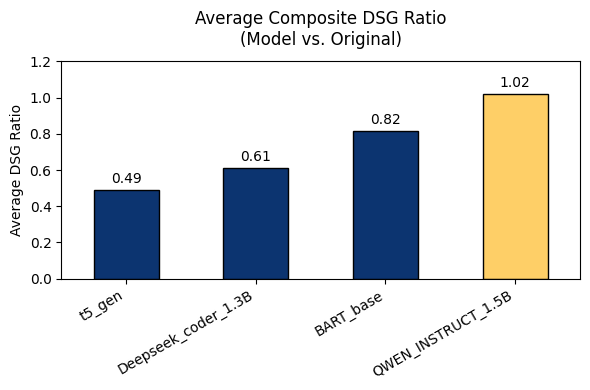

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ─── Load Data ────────────────────────────────────────────────────────────────
csv_path = '/content/drive/MyDrive/NLP-Project/t2i_interpolation_dsg_results_all_models.csv'
df = pd.read_csv(csv_path)

# ─── Compute Average DSG Ratios ───────────────────────────────────────────────
# Pivot so each model is its own column for DSG
df_pivot = df.pivot(index='image_id', columns='model_name', values='DSG_score')

# Exclude the original reference
models = [m for m in df_pivot.columns if m != 'original']

# Per-image ratio (model / original)
ratio_df = (
    df_pivot[models]
      .divide(df_pivot['original'], axis=0)
      .replace([float('inf'), -float('inf')], pd.NA)
)

# Average ratio per model
avg_ratios = ratio_df.mean().rename('avg_dsg_ratio')

# Map to slide-friendly names
display_names = {
    'BART':     'BART_base',
    'DEEPSEEK': 'Deepseek_coder_1.3B',
    'QWEN':     'QWEN_INSTRUCT_1.5B',
    'T5':       't5_gen',
}
avg_ratios.index = [display_names[m] for m in avg_ratios.index]

# Sort ascending (lowest → highest)
avg_ratios = avg_ratios.sort_values(ascending=True)

# ─── Plot with Annotations ───────────────────────────────────────────────────
# Choose gold only for QWEN, navy for others
bar_colors = [
    '#fecf67' if name == display_names['QWEN'] else '#0c3470'
    for name in avg_ratios.index
]

plt.figure(figsize=(6, 4))
ax = avg_ratios.plot(
    kind='bar',
    color=bar_colors,
    edgecolor='black'
)

# Annotate each bar with its value (two decimal places)
for idx, value in enumerate(avg_ratios):
    ax.text(
        idx,
        value + 0.02,        # offset above the bar
        f"{value:.2f}",      # formatted label
        ha='center',
        va='bottom',
        fontsize=10
    )

# Title & Axis
plt.title("Average Composite DSG Ratio\n(Model vs. Original)", pad=12)
plt.ylabel("Average DSG Ratio")
plt.ylim(0, 1.2)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

**Average CLIP Interpolation Ratio**

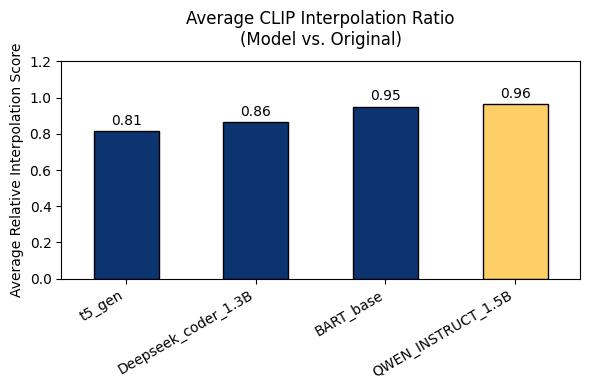

In [ ]:
# ─── Compute Average Interpolation Ratios ──────────────────────────────────────
# Pivot each model into its own column for Interp_score
df_interp = df.pivot(index='image_id', columns='model_name', values='Interp_score')

# Exclude the original column
models = [m for m in df_interp.columns if m != 'original']

# Compute per-image ratio (model / original) and handle infinities
ratio_interp = (
    df_interp[models]
      .divide(df_interp['original'], axis=0)
      .replace([float('inf'), -float('inf')], pd.NA)
)

# Average ratio per model
avg_interp_ratios = ratio_interp.mean().rename('avg_interp_ratio')

# Map internal names → slide-friendly names
display_names = {
    'BART':    'BART_base',
    'DEEPSEEK':'Deepseek_coder_1.3B',
    'QWEN':    'QWEN_INSTRUCT_1.5B',
    'T5':      't5_gen',
}
avg_interp_ratios.index = [display_names[m] for m in avg_interp_ratios.index]

# Sort ascending (lowest → highest)
avg_interp_ratios = avg_interp_ratios.sort_values(ascending=True)

# ─── Plot with Annotations ───────────────────────────────────────────────────
# Choose gold only for QWEN, navy for others
bar_colors = [
    '#fecf67' if name == display_names['QWEN'] else '#0c3470'
    for name in avg_interp_ratios.index
]

plt.figure(figsize=(6, 4))
ax = avg_interp_ratios.plot(
    kind='bar',
    color=bar_colors,
    edgecolor='black'
)

# Annotate each bar with its value (two decimal places)
for idx, value in enumerate(avg_interp_ratios):
    ax.text(
        idx,
        value + 0.02,        # offset above the bar
        f"{value:.2f}",      # formatted label
        ha='center',
        va='bottom',
        fontsize=10
    )

# Title & Axis
plt.title("Average CLIP Interpolation Ratio\n(Model vs. Original)", pad=12)
plt.ylabel("Average Relative Interpolation Score")
plt.ylim(0, 1.2)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
